In [1]:
# Authors:
# A. del Rio Chanona - Imperial College

import pylab
import numpy as np
import scipy.integrate as scp
from pylab import *
import matplotlib.pyplot as plt
import csv
import os
import sys
import copy
import numpy.random as rnd
from scipy.spatial.distance import cdist
!pip install sobol_seq
import sobol_seq
from scipy.optimize import minimize
eps  = np.finfo(float).eps
import random

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
## Import up sound alert dependencies
from IPython.display import Audio, display
def Done():
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

## Dyanmical System

Here we have a dynamic system, where $x$ is biomas, $N$ is nitrogen source, and $F_{N_{in}}$ is an inflow rate.

$$\frac{\text{d}x}{\text{d}t}=\mu~x~\frac{N}{N+K_N}-\mu_d~x$$

$$\frac{\text{d}N}{\text{d}t}=-Y_{Nx}x~\mu~\frac{N}{N+K_N}+F_{N_{in}}$$

We wish to optimize at the final time $t_f$ the cost given by the biomass we can harves, minus a penalization for the nitrogen that was not consumed, the objective function is:

$$f_{obj_1}=100x_{t_f}-N_{t_f}$$

where $x_{t_f}$ and $N_{t_f}$ refer to the final biomass and nitrogen quantity. We can control $F_{N_{in}}\in[0,7]$ with a precision of $0.5$ changing it $10$ times (equidistantly) from time $0$ to time $t_f$

We can aditionally have an objective function that penalizes nitrogen source input:

$$f_{obj_2}=100x_{t_f}-N_{t_f}-\sum_{i=0}^{T}F_{N_{in}}^i$$

where $T$ is the total number of time steps (inputs) and $F_{N_{in}}^i$ corresponds to the nitrate input at time-step $i$.

In [2]:
class ModelIntegration:
    
    # --- initializing model --- #
    def __init__(self, parameters, controls, tf): # controls is a list of eg. ten numbers, each corresponding to 1 addition at a certain time step
        
        # Object variable definitions
        self.parameters, self.controls = parameters, controls
        self.dt, self.tf               = tf/(controls.shape[1]), tf
        self.u0                        = controls[:,0]
        
    # --- dynamic model definition --- #    
    def model(self, t, state):
        # internal definitions
        params = self.parameters
        ctrl   = self.u0
        
        FCn    = ctrl[0]
        
        # state vector
        Cx  = state[0]
        Cn  = state[1]
        
        # parameters
        u_m  = params['u_m']; K_N  = params['K_N'];
        u_d  = params['u_d']; Y_nx = params['Y_nx'];
        
        # algebraic equations
        
        # variable rate equations
        dev_Cx  = u_m * Cx * Cn/(Cn+K_N) - u_d*Cx**2
        dev_Cn  = - Y_nx * u_m * Cx * Cn/(Cn+K_N) + FCn
        
        return np.array([dev_Cx, dev_Cn],dtype='float64')
    
    # --- simulation --- #
    def simulation(self, x0):
        # internal definitions
        dt, steps   = self.dt, int(self.tf/float(self.dt))
        model, controls = self.model, self.controls
        
        # compile state trajectories
        xt = np.zeros((x0.shape[0],steps+1)) #x0 is init conditions eg. x0 = np.array([0.1,150.0])
        tt = np.zeros((steps+1)) #these two lines initializes a matrix of 2 x (no. of steps + 1)
        
        # initialize simulation
        current_state = x0
        xt[:,0]       = current_state
        tt[0]         = 0.
        
        # simulation
        for s in range(steps):
            self.u0   = controls[:,s]                       # control for this step
            ode       = scp.ode(model)                      # define ode
            ode.set_integrator('lsoda', nsteps=3000)        # define integrator
            ode.set_initial_value(current_state,dt)         # set initial value
            current_state = list(ode.integrate(ode.t + dt)) # integrate system
            xt[:,s+1]     = current_state                   # add current state Note: here we can add randomnes as: + RandomNormal noise
            tt[s+1]       = (s+1)*dt
        
        return xt, tt    
        
        
        

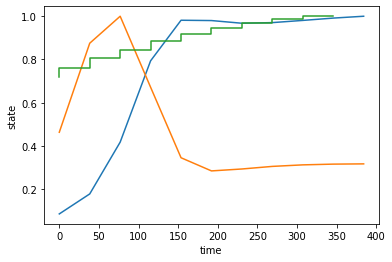

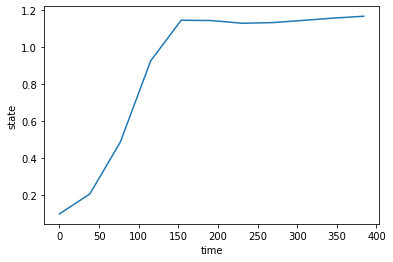

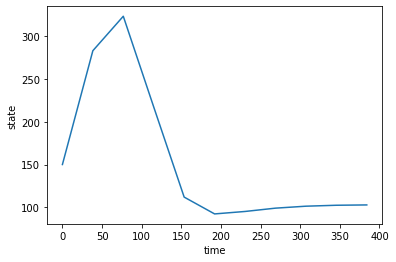

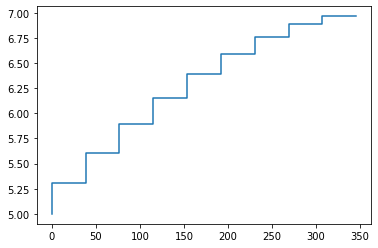

In [37]:
p  = {'u_m' : 0.0923*0.62, 'K_N' : 393.10, 'u_d' : 0.01, 'Y_nx' : 504.49} #don't touch the params!

steps_   = 10
FCn_0    = [np.sin(i/6.5)*2+5. for i in range(steps_)] #just an example solution! #FIND THIS
#FCn_0    = [6. for i in range(steps_)]

u  = np.array([FCn_0])
tf = 16.*24. #16 days of reaction time
x0 = np.array([0.1,150.0])  #don't change initial conditons


m      = ModelIntegration(p, u, tf)
xt, tt = m.simulation(x0) 

# --- plot results --- #

import matplotlib.pyplot as plt
for i in range(xt.shape[0]): #reminder: xt is the matrix of 2 x (no. of steps + 1). where rows 1 and 2 are the conc. of x and N, respectively.
    plt.plot(tt,xt[i,:]/np.max(xt[i,:])) #makes the two *normalized* plots (conc. of x and N) over time
plt.step(tt[:-1],FCn_0/np.max(FCn_0)) #plots the *normalized* control over time
plt.ylabel('state')
plt.xlabel('time')
plt.show()

for i in range(xt.shape[0]): #plot the three graphs separately, and with no normalization.
    plt.plot(tt,xt[i,:])
    plt.ylabel('state')
    plt.xlabel('time')
    plt.show()
plt.step(tt[:-1],FCn_0)
plt.show()


## Dynamic Programming solutions

To solve this problem, initially we should think of discretizing states (time is already discretized). This can be done for Biomass in $0.5$ intervals, and for Nitrate in $25$ intervals. 

## Defining discrete environment

In [93]:
############ Defining Environment ##############

class Model_env: 
    
    # --- initializing model --- #
    def __init__(self, parameters, tf, modulus):
        
        # Object variable definitions
        self.parameters       = parameters
        self.tf, self.modulus = tf, modulus  # two column array [biomass nitrate]
        
    # --- dynamic model definition --- #    
    # model takes state and action of previous time step and integrates -- definition of ODE system at time, t
    def model(self, t, state):
        # internal definitions
        params = self.parameters
        FCn   = self.u0
                
        # state vector
        Cx  = state[0]
        Cn  = state[1]
        
        # parameters
        u_m  = params['u_m']; K_N  = params['K_N'];
        u_d  = params['u_d']; Y_nx = params['Y_nx'];
        
        # algebraic equations
        
        # variable rate equations
        dev_Cx  = u_m * Cx * Cn/(Cn+K_N) - u_d*Cx**2
        dev_Cn  = - Y_nx * u_m * Cx * Cn/(Cn+K_N) + FCn
        
        return np.array([dev_Cx, dev_Cn],dtype='float64')
    
    def discrete_env(self, state):
        # discretisation of the system, with introduction of stochasticity in terms of modulus
        modulus = self.modulus
        
        # passing to arrays
        modulus = np.array(modulus)    # eg. modulus = np.array([0.2, 20.]) basically what modulus does is it indicates the rounding of the conc of x and conc of nitrate
        state   = np.array(state)  # eg. state = np.array([0.1,150.0]) first number is the conc of x and 2nd number is the conc of nitrate

        resid = state % modulus 
        resid = resid/modulus # remember resid is now an array. resid is normalized with respect to the size of modulus 
        LB = resid.copy()
        UB = 1 - resid # 1 minus resid because we are talking about normalized inverse length
        draw = [0,0]
        for i in range(state.shape[0]):
            if LB[i] < UB[i]: #if lower bound distance is smaller (more likely to round down)
                LB[i] = LB[i]**3 #make distance even closer
                draw[i] = np.random.uniform(0,LB[i]+UB[i],1)
            elif LB[i] > UB[i]: # else upper bound distance is smaller (more liekly to round up)
                UB[i] = UB[i]**3
                draw[i] = np.random.uniform(0,LB[i]+UB[i],1)
            else:
                draw[i] = np.random.uniform(0,1,1)        
        for i in range(state.shape[0]):
            if draw[i] < UB[i]: #introduce stochasticity w.r.t. rounding up or down
                state[i] = state[i] - resid[i] * modulus[i] #rmb now resid is now a NORMALIZED array of 2 numbers so it has to be multiplied back to un-normalize residual #rounds down by substracting away the residual
            else:
                state[i] = state[i] - resid[i] * modulus[i] + modulus[i] #rounds up
        
        # fixes for representation 
        # Nitrate fix
        if state[1] < 0:
            state[1] = 0
        elif state[0] < 0:
            state[0] = 0
        
        # Biomass fix
        f = str(self.modulus[0])
        decimal = f[::-1].find('.')  
        state[0] = np.round(state[0], decimal)
        f1 = str(self.modulus[1])
        decimal1 = f1[::-1].find('.')  
        state[0] = np.round(state[0], decimal1)

        if state[0] == eps:
            state[0] = 0
        if state[1] == eps:
            state[1] = 0
        
        return state

    def simulation(self, x0, controls):
        # internal definitions
        model, tf     = self.model, self.tf
        self.controls = controls
        
        # initialize simulation
        current_state = x0
        
        # simulation #ONLY ONE STEP unlike the previous code shown above
        self.u0   = controls[:]                       # control for this step
        ode       = scp.ode(model)                      # define ode
        ode.set_integrator('lsoda', nsteps=3000)        # define integrator
        ode.set_initial_value(current_state, tf)         # set initial value
        current_state = list(ode.integrate(ode.t + tf)) # integrate system
        xt            = current_state                   # add current state Note: here we can add randomnes as: + RandomNormal noise
        
        return xt

    def MDP_simulation(self, x0, controls): #simulate ONLY ONE STEP
        xt          = self.simulation(x0, controls) #simulate
        xt_discrete = self.discrete_env(xt) # make output state discrete
        return xt_discrete

    def reward(self, state):
        reward = 100*state[-1][0] - state[-1][1]              # objective function 1
        return reward

In [94]:
transition([1.0,160.0,0],7)

KeyError: 7

## Simulating one Step of the dynamic system as a MDP

In [107]:
# Creating the model
p        = {'u_m' : 0.0923*0.62, 'K_N' : 393.10, 'u_d' : 0.01, 'Y_nx' : 504.49} # predetermined parameters by design
tf       = 16.*24./10. # assuming 10 steps, we divide the whole horizon over 10 for one step
x0       = np.array([0.2,700.0]) # initial state
modulus  = [0.1, 60.] # basically what modulus does is it indicates the rounding of the conc of x and conc of nitrate
u0       = np.array([7.]) #this is your CONTROL (rmb here it's only ONE STEP)

MDP_BioEnv = Model_env(p, tf, modulus)
MDP_BioEnv.MDP_simulation(x0, u0)

array([  0.7, 660. ])

## Simulating multiple steps of the dynamic system as a MDP

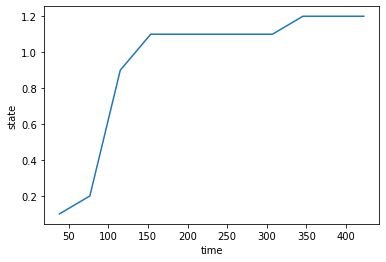

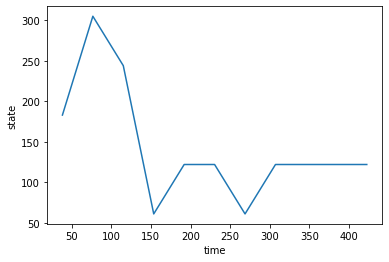

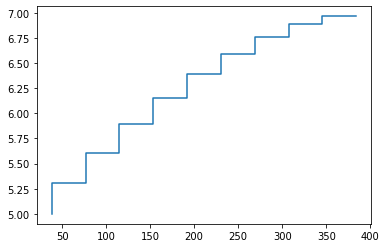

In [96]:
steps_      = 10
FCn_0       = [np.sin(i/6.5)*2+5. for i in range(steps_)]
x0          = np.array([0.1,183.0]) # initial state
tf          = 16.*24./10.
x_list      = np.zeros((2,steps_+1)) #initialize state as 2D array where the 2 rows refer to conc of x and N.
t_list      = np.zeros((1,steps_+1)) #initialize time as 1D array
x_list[:,0] = x0
t_list[0]   = tf

for s in range(len(FCn_0)):
    MDP_BioEnv    = Model_env(p, tf, modulus)
    u0            = np.array([FCn_0[s]])
    x0            = MDP_BioEnv.MDP_simulation(x0, u0) #simulate one step, and update current state 
    tf            = tf + 16.*24./10. #increment time
    x_list[:,s+1] = x0 #update state memory
    t_list[:,s+1] = tf #update time memory

for i in range(x_list.shape[0]):
    plt.plot(t_list[0,:],x_list[i,:])
    plt.ylabel('state')
    plt.xlabel('time')
    plt.show()
plt.step(t_list[0,:-1],FCn_0)
plt.show()

# Describing the size of system

In [66]:
modulus = [0.1, 60.] #modulus is the graining of x and N, respectively
Number_of_possible_x = int(2.0/modulus[0]+1) #assumed max x value is 1.6
Number_of_possible_N = int(700/modulus[1]+1) #assumed max N value is 400
Number_of_discrete_states = int(Number_of_possible_x * Number_of_possible_N)
Number_of_possible_actions = int(6.0/2 + 1)
Number_of_possible_times = 11

print('Number of discrete_states:', Number_of_discrete_states)
print('Shape of value table:', Number_of_possible_N , 'x', Number_of_possible_x)
print('Number of possible actions:', Number_of_possible_actions)
print('Number of possible times:', Number_of_possible_times)

Number of discrete_states: 252
Shape of value table: 12 x 21
Number of possible actions: 4
Number of possible times: 11


# Functions

In [126]:
#dictionary to map action to actual increase in N
action_ID = [x for x in range(Number_of_possible_actions)]
increase_in_N = [x for x in np.arange(0,7.5,2)]
action_ID_to_increase_in_N = dict(zip(action_ID,increase_in_N))
action_ID_to_increase_in_N #this dictionary maps action id to actual action itself (increase in N)

{0: 0.0, 1: 2.0, 2: 4.0, 3: 6.0}

In [127]:
def transition(state, action): # state can be described by tuple(x (algae conc), N (nitrate conc), time (in hours)), action can be described by FN ∈[0,7]
    '''arguments
       state: (x, N, t) tuple 
       action: int (0-14)
    
       outputs 
       new state: (x, N, t) tuple
       reward: int 
       '''
    state = np.array(state) 
    action = [action_ID_to_increase_in_N[action]] #assign action according to dictionary defined above
    
    if (abs(state[2] - 16.*24.) < 0.1): #check if terminal state is reached
        reward = (100 * state[0] - state[1])   #give reward when we LEAVE terminal state
        state[2]      += 16.*24./10. #increment time
        state_evolved = MDP_BioEnv.MDP_simulation(state[0:2], action) #evolve the system using ODE
        state_evolved = [round(state_evolved[0],1),round(state_evolved[1],1)]
        new_state = np.append(state_evolved,round(state[2],2)) # append time
        
    elif (state[2] > 16.*24.): #check if time is exceeded
        new_state = state #loop back to itself
        reward = 0 #and given zero reward    
        
#     elif (state[1] > 700) or (state[0] > 1.6): #check if unexplored state space is reached
#         new_state = state #loop back to itself
#         reward = 0 #and given zero reward
        
    else: #else evolve the system and assign zero reward
        state[2]      += 16.*24./10. #increment time
        state_evolved = MDP_BioEnv.MDP_simulation(state[0:2], action) #evolve the system using ODE
        state_evolved = [round(state_evolved[0],1),round(state_evolved[1],1)]
        new_state = np.append(state_evolved,round(state[2],2)) # append time
        reward    = 0 # if terminal step not reached, reward = 0

    return tuple(new_state), reward

In [128]:
# test transition function 
a= 3
result1 = transition((0.2, 680, 384),a)
# result2 = transition(result1[0],a)
# result3 = transition(result2[0],a)
# result4 = transition(result3[0],a)
# result5 = transition(result4[0],a)
# result6 = transition(result5[0],a)
# result7 = transition(result6[0],a)
# result8 = transition(result7[0],a)
# result9 = transition(result8[0],a)
# result10 = transition(result9[0],a)
result1

((0.7, 600.0, 422.4), -660.0)

In [129]:
## initialize value table
# might want to add entries of states as we visit them instead
# but here we use the brute force approach by generate all state and times

def initialise_value_table(num_states = Number_of_discrete_states): #number of discrete states
    '''initializes a random value table (a dictionary)'''
    value_table = {} # start off with empty dict that will be filled up
    for x in range(1, Number_of_possible_x): #remove x = 0.0
        for N in range(Number_of_possible_N):
            for t in np.linspace(0,16*24/10*11,12): #add extra time step
                 value_table[(round(x*modulus[0],1),N*modulus[1], round(t,1))] = np.random.rand()
    for key in value_table.keys():
        if 422.4 in key:
            value_table[key] = 0 #assign value of ZERO to terminal states
    return value_table
value_table = initialise_value_table(num_states = Number_of_discrete_states)
print('Number of entries in value table:', len(value_table))
value_table

Number of entries in value table: 2880


{(0.1, 0.0, 0.0): 0.11228033324497033,
 (0.1, 0.0, 38.4): 0.9555527793692102,
 (0.1, 0.0, 76.8): 0.8929338617693972,
 (0.1, 0.0, 115.2): 0.47427246977699045,
 (0.1, 0.0, 153.6): 0.9356476594567582,
 (0.1, 0.0, 192.0): 0.8974304907696988,
 (0.1, 0.0, 230.4): 0.11511538709261504,
 (0.1, 0.0, 268.8): 0.6669820713731124,
 (0.1, 0.0, 307.2): 0.7757235031874801,
 (0.1, 0.0, 345.6): 0.005098363969115227,
 (0.1, 0.0, 384.0): 0.7097379500228815,
 (0.1, 0.0, 422.4): 0,
 (0.1, 60.0, 0.0): 0.787146183482436,
 (0.1, 60.0, 38.4): 0.47364636176010966,
 (0.1, 60.0, 76.8): 0.2572166029663523,
 (0.1, 60.0, 115.2): 0.1303603012664607,
 (0.1, 60.0, 153.6): 0.7930093103041826,
 (0.1, 60.0, 192.0): 0.9724618121924377,
 (0.1, 60.0, 230.4): 0.006255200643010883,
 (0.1, 60.0, 268.8): 0.8063443308835979,
 (0.1, 60.0, 307.2): 0.6552157078766762,
 (0.1, 60.0, 345.6): 0.7629862901386356,
 (0.1, 60.0, 384.0): 0.6098569688811659,
 (0.1, 60.0, 422.4): 0,
 (0.1, 120.0, 0.0): 0.05315200802151154,
 (0.1, 120.0, 38.4): 0

In [130]:
keys_to_be_iterated = []
for t in np.linspace(0,16*24/10*11,12): #add extra time step
    for x in range(1, Number_of_possible_x): #remove x = 0.0
            for N in range(Number_of_possible_N):
                keys_to_be_iterated += [(round(x*modulus[0],1),N*modulus[1], round(t,1))]
keys_to_be_iterated = list(reversed(keys_to_be_iterated))
keys_to_be_iterated

[(2.0, 660.0, 422.4),
 (2.0, 600.0, 422.4),
 (2.0, 540.0, 422.4),
 (2.0, 480.0, 422.4),
 (2.0, 420.0, 422.4),
 (2.0, 360.0, 422.4),
 (2.0, 300.0, 422.4),
 (2.0, 240.0, 422.4),
 (2.0, 180.0, 422.4),
 (2.0, 120.0, 422.4),
 (2.0, 60.0, 422.4),
 (2.0, 0.0, 422.4),
 (1.9, 660.0, 422.4),
 (1.9, 600.0, 422.4),
 (1.9, 540.0, 422.4),
 (1.9, 480.0, 422.4),
 (1.9, 420.0, 422.4),
 (1.9, 360.0, 422.4),
 (1.9, 300.0, 422.4),
 (1.9, 240.0, 422.4),
 (1.9, 180.0, 422.4),
 (1.9, 120.0, 422.4),
 (1.9, 60.0, 422.4),
 (1.9, 0.0, 422.4),
 (1.8, 660.0, 422.4),
 (1.8, 600.0, 422.4),
 (1.8, 540.0, 422.4),
 (1.8, 480.0, 422.4),
 (1.8, 420.0, 422.4),
 (1.8, 360.0, 422.4),
 (1.8, 300.0, 422.4),
 (1.8, 240.0, 422.4),
 (1.8, 180.0, 422.4),
 (1.8, 120.0, 422.4),
 (1.8, 60.0, 422.4),
 (1.8, 0.0, 422.4),
 (1.7, 660.0, 422.4),
 (1.7, 600.0, 422.4),
 (1.7, 540.0, 422.4),
 (1.7, 480.0, 422.4),
 (1.7, 420.0, 422.4),
 (1.7, 360.0, 422.4),
 (1.7, 300.0, 422.4),
 (1.7, 240.0, 422.4),
 (1.7, 180.0, 422.4),
 (1.7, 120.0, 422.4

# Policy iteration

In [131]:
def initialise_deterministic_policy(num_states = Number_of_discrete_states, num_actions = Number_of_possible_actions):
    '''Maps state with time to action ID
    returns a policy (dictionary) of this format:
    key (tuple) = (conc of x, conc of N, time). This describes the state and time at which the state is reached
    value (int) = a value from 0 to 14. basically refers to the specific action according to the action_ID_to_increase_in_N dict defined above
    
    For example, (0.2,260, 38.4): 4 means x = 0.2, N = 260 reached at time = 38.4 and take the 5th action which corresponds to increasing N by 2.0 units (according to the action_ID_to_increase_in_N dictionary)
    '''
    policy = {} # start off with empty map
    for x in range(1, Number_of_possible_x): #remove x = 0.0
        for N in range(Number_of_possible_N):
            for t in np.linspace(0,16*24/10*11,12): #add extra time step
                action_probs = np.random.rand((num_actions)) #randomly initialize
                action_probs /= sum(action_probs) #normalize probabilities
                policy[round(x*modulus[0],1),N*modulus[1], round(t,1)] = np.argmax(action_probs) # only line different to above - the function returns the action, rather than the dist over
    
#     for state in policy.keys(): # this loop makes sure that when x conc is low, the action is NOT zero
#         if (state[0] == 0.2) or (state[0] == 0.4) or (state[0] == 0.6): #check if x is low 
#             policy[state] = random.randint(3,Number_of_possible_actions) #reassign action to at least 3 and above to prevent x from falling further
            
    return policy

print('Number of entries in policy =', len(initialise_deterministic_policy(num_states = Number_of_discrete_states, num_actions = Number_of_possible_actions)))
policy = initialise_deterministic_policy(num_states = Number_of_discrete_states, num_actions = Number_of_possible_actions)
policy

Number of entries in policy = 2880


{(0.1, 0.0, 0.0): 1,
 (0.1, 0.0, 38.4): 2,
 (0.1, 0.0, 76.8): 2,
 (0.1, 0.0, 115.2): 0,
 (0.1, 0.0, 153.6): 2,
 (0.1, 0.0, 192.0): 3,
 (0.1, 0.0, 230.4): 1,
 (0.1, 0.0, 268.8): 3,
 (0.1, 0.0, 307.2): 0,
 (0.1, 0.0, 345.6): 0,
 (0.1, 0.0, 384.0): 1,
 (0.1, 0.0, 422.4): 2,
 (0.1, 60.0, 0.0): 3,
 (0.1, 60.0, 38.4): 3,
 (0.1, 60.0, 76.8): 2,
 (0.1, 60.0, 115.2): 1,
 (0.1, 60.0, 153.6): 3,
 (0.1, 60.0, 192.0): 1,
 (0.1, 60.0, 230.4): 3,
 (0.1, 60.0, 268.8): 1,
 (0.1, 60.0, 307.2): 3,
 (0.1, 60.0, 345.6): 1,
 (0.1, 60.0, 384.0): 3,
 (0.1, 60.0, 422.4): 3,
 (0.1, 120.0, 0.0): 2,
 (0.1, 120.0, 38.4): 2,
 (0.1, 120.0, 76.8): 0,
 (0.1, 120.0, 115.2): 0,
 (0.1, 120.0, 153.6): 0,
 (0.1, 120.0, 192.0): 2,
 (0.1, 120.0, 230.4): 0,
 (0.1, 120.0, 268.8): 0,
 (0.1, 120.0, 307.2): 2,
 (0.1, 120.0, 345.6): 3,
 (0.1, 120.0, 384.0): 2,
 (0.1, 120.0, 422.4): 3,
 (0.1, 180.0, 0.0): 2,
 (0.1, 180.0, 38.4): 0,
 (0.1, 180.0, 76.8): 3,
 (0.1, 180.0, 115.2): 0,
 (0.1, 180.0, 153.6): 1,
 (0.1, 180.0, 192.0): 1,
 (

In [132]:
# COMPUTING VALUE FUNCTION USING DYNAMIC PROGRAMMING
def policy_evaluation(policy, value_table, discount_factor, error_threshold=0.01, num_states=Number_of_discrete_states):
    print()
    num_cycles = 20 #number of repetitions per state to get Expectation value
     # init new value table to be filled in and returned
    converged = False # initially we have not found a converged value function for this policy
    k = 0 # sweep index
    while not converged: # until the value function converges
        print('sweep ', k)
        new_value_table = value_table.copy()
        k += 1 # increment sweep counter
        worst_delta = 0 # difference between previous values and iterated values
        total_delta = 0
        for state in keys_to_be_iterated: # loop over each state
            action = policy[state] # get the action according to current policy
            total_val = 0 
           # list_of_val = []
            for i in range(num_cycles):
                new_state, reward = transition(state, action) # use model to simulate next state and reward
             #check for errors if the state entry has not been created in value table
                if new_state in keys_to_be_iterated:
                    new_val = reward + discount_factor * new_value_table[new_state] # compute new value
                else:
                    new_value_table[new_state] = 0 #when the above fails, new state is TERMINAL state, hence has value of 0
                    new_val = reward + discount_factor * new_value_table[new_state]
                total_val += new_val
               # list_of_val += [new_val]
            new_val = total_val/num_cycles #calculate expectation (average) of new values
           # print('list_of_val:',list_of_val)
           # print('new_val:',new_val)
#             print(new_val)
#             print(value_table[state])
#             print(new_val - value_table[state])
#             print('')
            delta = abs(new_val - value_table[state]) # find the absolute diff between new val and old val for this state
            new_value_table[state] = new_val # update value table
#             print(new_val)
#             print(value_table[state])
#             print(new_val - value_table[state])
            
            total_delta += delta
#             print('delta:', delta)
            if delta > worst_delta: # is this state the one for which our value table is most wrong?
                worst_delta = delta # update worst error for this sweep
        print('total_delta:',total_delta)
        print('worst_delta:', worst_delta)    
        if k > 0: # once the values stop changing
            print('worst_delta:', worst_delta)
            converged = True # we have found the value function
            print('Converged on value function')
        
        value_table = new_value_table # update value table (took me ages to realise i was missing this line and debug )
    return value_table # return converged value table evaluated for this policy
        

In [133]:
# INITIALIZE VALUE TABLE AND POLICY
my_value_table = initialise_value_table(num_states = Number_of_discrete_states)
policy = initialise_deterministic_policy(num_states = Number_of_discrete_states, num_actions = Number_of_possible_actions)

In [454]:
# for i in range(Number_of_possible_actions):
#     new_state, reward = transition((0.2, 160, 0),i)
#     new_val = reward + 0.9 * my_value_table[new_state]
#     print('action', i)
#     print('new_state:', new_state)
#     print('reward:', reward)
#     print('new_val:', new_val)
#     print('')

In [716]:
#test evaluation function
discount_factor = 0.9
my_value_table = policy_evaluation(policy, my_value_table, discount_factor, error_threshold=0.01, num_states=Number_of_discrete_states)
Done()


sweep  0
total_delta: 18304.20859669173
worst_delta: 28.8
worst_delta: 28.8
Converged on value function


In [929]:
#View all state values in value table
for key in keys_to_be_iterated:
    print(key,my_value_table[key])

(1.6, 976.0, 422.4) 0
(1.6, 915.0, 422.4) 0
(1.6, 854.0, 422.4) 0
(1.6, 793.0, 422.4) 0
(1.6, 732.0, 422.4) 0
(1.6, 671.0, 422.4) 0
(1.6, 610.0, 422.4) 0
(1.6, 549.0, 422.4) 0
(1.6, 488.0, 422.4) 0
(1.6, 427.0, 422.4) 0
(1.6, 366.0, 422.4) 0
(1.6, 305.0, 422.4) 0
(1.6, 244.0, 422.4) 0
(1.6, 183.0, 422.4) 0
(1.6, 122.0, 422.4) 0
(1.6, 61.0, 422.4) 0
(1.6, 0.0, 422.4) 0
(1.5, 976.0, 422.4) 0
(1.5, 915.0, 422.4) 0
(1.5, 854.0, 422.4) 0
(1.5, 793.0, 422.4) 0
(1.5, 732.0, 422.4) 0
(1.5, 671.0, 422.4) 0
(1.5, 610.0, 422.4) 0
(1.5, 549.0, 422.4) 0
(1.5, 488.0, 422.4) 0
(1.5, 427.0, 422.4) 0
(1.5, 366.0, 422.4) 0
(1.5, 305.0, 422.4) 0
(1.5, 244.0, 422.4) 0
(1.5, 183.0, 422.4) 0
(1.5, 122.0, 422.4) 0
(1.5, 61.0, 422.4) 0
(1.5, 0.0, 422.4) 0
(1.4, 976.0, 422.4) 0
(1.4, 915.0, 422.4) 0
(1.4, 854.0, 422.4) 0
(1.4, 793.0, 422.4) 0
(1.4, 732.0, 422.4) 0
(1.4, 671.0, 422.4) 0
(1.4, 610.0, 422.4) 0
(1.4, 549.0, 422.4) 0
(1.4, 488.0, 422.4) 0
(1.4, 427.0, 422.4) 0
(1.4, 366.0, 422.4) 0
(1.4, 305.0, 422

(0.3, 366.0, 345.6) 0.8862792436722853
(0.3, 305.0, 345.6) 0.8472351515070239
(0.3, 244.0, 345.6) 0.3485489706101622
(0.3, 183.0, 345.6) 0.8143518287288728
(0.3, 122.0, 345.6) 0.6534094225230069
(0.3, 61.0, 345.6) 0.07608345527734783
(0.3, 0.0, 345.6) 0.717324972734103
(0.2, 976.0, 345.6) 0.05185122996950586
(0.2, 915.0, 345.6) 0.030823014592361475
(0.2, 854.0, 345.6) 0.574414935957253
(0.2, 793.0, 345.6) 0.15249811424213
(0.2, 732.0, 345.6) 0.2396678160757213
(0.2, 671.0, 345.6) 0.9933397909930626
(0.2, 610.0, 345.6) 0.6579763344339244
(0.2, 549.0, 345.6) 0.43167696853660054
(0.2, 488.0, 345.6) 0.6423044750725913
(0.2, 427.0, 345.6) 0.9727246958431951
(0.2, 366.0, 345.6) 0.09922142179380522
(0.2, 305.0, 345.6) 0.686609992072104
(0.2, 244.0, 345.6) 0.7368675020572405
(0.2, 183.0, 345.6) 0.5022384710927565
(0.2, 122.0, 345.6) 0.4307708926792141
(0.2, 61.0, 345.6) 0.719529568677389
(0.2, 0.0, 345.6) 0.23463099702243317
(0.1, 976.0, 345.6) 0.2604240580509287
(0.1, 915.0, 345.6) 0.61124010

(0.7, 244.0, 230.4) 0.15661058231694558
(0.7, 183.0, 230.4) 0.8944554776776973
(0.7, 122.0, 230.4) 0.8572400853281614
(0.7, 61.0, 230.4) 0.7911089565624081
(0.7, 0.0, 230.4) 0.5160648830685033
(0.6, 976.0, 230.4) 0.9959441527171251
(0.6, 915.0, 230.4) 0.09859312848557589
(0.6, 854.0, 230.4) 0.6651548058968171
(0.6, 793.0, 230.4) 0.19364943023265202
(0.6, 732.0, 230.4) 0.9749662485302292
(0.6, 671.0, 230.4) 0.6149381272250646
(0.6, 610.0, 230.4) 0.592601809925597
(0.6, 549.0, 230.4) 0.0441207861795162
(0.6, 488.0, 230.4) 0.3716406506893686
(0.6, 427.0, 230.4) 0.7738380043121683
(0.6, 366.0, 230.4) 0.12304352342636993
(0.6, 305.0, 230.4) 0.3496440246996628
(0.6, 244.0, 230.4) 0.9643098895486621
(0.6, 183.0, 230.4) 0.6766581724149386
(0.6, 122.0, 230.4) 0.2654029990699268
(0.6, 61.0, 230.4) 0.15126995478897287
(0.6, 0.0, 230.4) 0.7788400609975569
(0.5, 976.0, 230.4) 0.5565808797493981
(0.5, 915.0, 230.4) 0.39965563080744104
(0.5, 854.0, 230.4) 0.978951049734011
(0.5, 793.0, 230.4) 0.82512

(1.1, 122.0, 115.2) 0.7030785610699957
(1.1, 61.0, 115.2) 0.0010562515567729136
(1.1, 0.0, 115.2) 0.3269454886957244
(1.0, 976.0, 115.2) 0.4062244905804573
(1.0, 915.0, 115.2) 0.017387638507410985
(1.0, 854.0, 115.2) 0.11112391636086105
(1.0, 793.0, 115.2) 0.688143794091659
(1.0, 732.0, 115.2) 0.6927774731254435
(1.0, 671.0, 115.2) 0.3099694373421399
(1.0, 610.0, 115.2) 0.6707207926938266
(1.0, 549.0, 115.2) 0.008757053681116567
(1.0, 488.0, 115.2) 0.42601001428095175
(1.0, 427.0, 115.2) 0.6891801596786643
(1.0, 366.0, 115.2) 0.4519778769549784
(1.0, 305.0, 115.2) 0.3800452831550082
(1.0, 244.0, 115.2) 0.20924396282953484
(1.0, 183.0, 115.2) 0.0613443458661832
(1.0, 122.0, 115.2) 0.6166519704236993
(1.0, 61.0, 115.2) 0.46380353400788876
(1.0, 0.0, 115.2) 0.7959413073662656
(0.9, 976.0, 115.2) 0.6195002551263763
(0.9, 915.0, 115.2) 0.5917153409646452
(0.9, 854.0, 115.2) 0.11770649134784184
(0.9, 793.0, 115.2) 0.22736766132980957
(0.9, 732.0, 115.2) 0.03199493326886138
(0.9, 671.0, 115.2

(1.5, 61.0, 0.0) 0.6278845446104435
(1.5, 0.0, 0.0) 0.20434151775800735
(1.4, 976.0, 0.0) 0.9586950454113083
(1.4, 915.0, 0.0) 0.8843859897825459
(1.4, 854.0, 0.0) 0.39215355808114793
(1.4, 793.0, 0.0) 0.8787806638168639
(1.4, 732.0, 0.0) 0.15283707938456437
(1.4, 671.0, 0.0) 0.8269539513220651
(1.4, 610.0, 0.0) 0.510539189437609
(1.4, 549.0, 0.0) 0.9344036232366706
(1.4, 488.0, 0.0) 0.8002599051715548
(1.4, 427.0, 0.0) 0.07105601795596694
(1.4, 366.0, 0.0) 0.8268471395158483
(1.4, 305.0, 0.0) 0.02709629460140328
(1.4, 244.0, 0.0) 0.2590162815547882
(1.4, 183.0, 0.0) 0.4694330609592793
(1.4, 122.0, 0.0) 0.880444876751865
(1.4, 61.0, 0.0) 0.9367316177500667
(1.4, 0.0, 0.0) 0.5614485268890664
(1.3, 976.0, 0.0) 0.19722016404591813
(1.3, 915.0, 0.0) 0.16920818051943753
(1.3, 854.0, 0.0) 0.3589632935013316
(1.3, 793.0, 0.0) 0.6040108097826963
(1.3, 732.0, 0.0) 0.7086566460716862
(1.3, 671.0, 0.0) 0.23992887611697422
(1.3, 610.0, 0.0) 0.13178939894706687
(1.3, 549.0, 0.0) 0.6930961904594576


In [1010]:
for i in range(Number_of_possible_actions):
    num_cycles = 20
    total_score = 0
    list_of_new_states = []
    for j in range(num_cycles):
        new_state = transition((1.2, 580.0, 345.6) ,i)
        total_score += 100*new_state[0][0]-new_state[0][1]
        list_of_new_states += [new_state]
    averaged_score = total_score/num_cycles
    print('action:',i,'result:',new_state,averaged_score)

action: 0 result: ((0.2, 0.0, 384.0), 0) 22.0
action: 1 result: ((0.5, 0.0, 384.0), 0) 3.25
action: 2 result: ((0.6, 61.0, 384.0), 0) -1.0
action: 3 result: ((0.8, 61.0, 384.0), 0) 19.0
action: 4 result: ((0.9, 61.0, 384.0), 0) 29.0
action: 5 result: ((1.0, 61.0, 384.0), 0) 35.95
action: 6 result: ((1.1, 122.0, 384.0), 0) -5.899999999999987
action: 7 result: ((1.2, 122.0, 384.0), 0) -2.0


In [878]:
policy[(1.2, 580.0, 345.6)]

2

In [715]:
#test improvement function
policy = policy_improvement(my_value_table, discount_factor = 0.9)
policy

{(1.6, 1000.0, 422.4): 9.0,
 (1.6, 980.0, 422.4): 13.0,
 (1.6, 960.0, 422.4): 5.0,
 (1.6, 940.0, 422.4): 9.0,
 (1.6, 920.0, 422.4): 10.0,
 (1.6, 900.0, 422.4): 2.0,
 (1.6, 880.0, 422.4): 3.0,
 (1.6, 860.0, 422.4): 14.0,
 (1.6, 840.0, 422.4): 1.0,
 (1.6, 820.0, 422.4): 4.0,
 (1.6, 800.0, 422.4): 4.0,
 (1.6, 780.0, 422.4): 7.0,
 (1.6, 760.0, 422.4): 10.0,
 (1.6, 740.0, 422.4): 8.0,
 (1.6, 720.0, 422.4): 11.0,
 (1.6, 700.0, 422.4): 8.0,
 (1.6, 680.0, 422.4): 2.0,
 (1.6, 660.0, 422.4): 1.0,
 (1.6, 640.0, 422.4): 10.0,
 (1.6, 620.0, 422.4): 7.0,
 (1.6, 600.0, 422.4): 0.0,
 (1.6, 580.0, 422.4): 11.0,
 (1.6, 560.0, 422.4): 2.0,
 (1.6, 540.0, 422.4): 0.0,
 (1.6, 520.0, 422.4): 11.0,
 (1.6, 500.0, 422.4): 8.0,
 (1.6, 480.0, 422.4): 5.0,
 (1.6, 460.0, 422.4): 13.0,
 (1.6, 440.0, 422.4): 0.0,
 (1.6, 420.0, 422.4): 14.0,
 (1.6, 400.0, 422.4): 12.0,
 (1.6, 380.0, 422.4): 0.0,
 (1.6, 360.0, 422.4): 9.0,
 (1.6, 340.0, 422.4): 12.0,
 (1.6, 320.0, 422.4): 3.0,
 (1.6, 300.0, 422.4): 2.0,
 (1.6, 280.0, 4

In [991]:
# count = 0
# for key in keys_to_be_iterated:
#     if policy[key] == policy1[key]:
#         count += 1
# print(count/len(keys_to_be_iterated))

In [372]:
score_policy(policy,num_episodes = 500) #score policy

KeyError: (0.0, 0.0, 192.0)

In [147]:
#for looping!
# policy_library = []
# score_list = []
discount_factor = 0.9
for i in range(1):
    print('POLICY ITERATION CYCLE ',i)
    print('')
    print('EVALUATION')
    my_value_table = policy_evaluation(policy, my_value_table, discount_factor, error_threshold=0.01, num_states=Number_of_discrete_states)
    last_two_value_tables += [my_value_table]
    print('IMPROVEMENT')
    policy = policy_improvement(my_value_table, discount_factor = 0.9)
    try:
        score = score_policy(policy, num_episodes = 500)
        print('SCORE:', score) #score policy with 500 episodes
        score_list += [score]
    except:
        pass
    policy_library += [policy]
    print('')
Done()

POLICY ITERATION CYCLE  0

EVALUATION

sweep  0
total_delta: 1742.4664548592034
worst_delta: 18.89999999999999
worst_delta: 18.89999999999999
Converged on value function
IMPROVEMENT
SCORE: 89.3



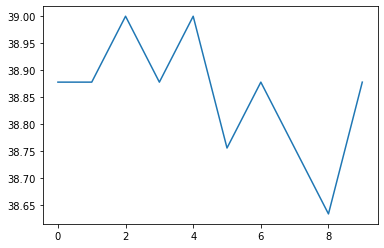

In [23]:
plt.plot(range(len(score_list)), score_list)

In [151]:
for key in keys_to_be_iterated:
    print(key,last_two_value_tables[0][key])

(2.0, 660.0, 422.4) 0.0
(2.0, 600.0, 422.4) 0.0
(2.0, 540.0, 422.4) 0.0
(2.0, 480.0, 422.4) 0.0
(2.0, 420.0, 422.4) 0.0
(2.0, 360.0, 422.4) 0.0
(2.0, 300.0, 422.4) 0.0
(2.0, 240.0, 422.4) 0.0
(2.0, 180.0, 422.4) 0.0
(2.0, 120.0, 422.4) 0.0
(2.0, 60.0, 422.4) 0.0
(2.0, 0.0, 422.4) 0.0
(1.9, 660.0, 422.4) 0.0
(1.9, 600.0, 422.4) 0.0
(1.9, 540.0, 422.4) 0.0
(1.9, 480.0, 422.4) 0.0
(1.9, 420.0, 422.4) 0.0
(1.9, 360.0, 422.4) 0.0
(1.9, 300.0, 422.4) 0.0
(1.9, 240.0, 422.4) 0.0
(1.9, 180.0, 422.4) 0.0
(1.9, 120.0, 422.4) 0.0
(1.9, 60.0, 422.4) 0.0
(1.9, 0.0, 422.4) 0.0
(1.8, 660.0, 422.4) 0.0
(1.8, 600.0, 422.4) 0.0
(1.8, 540.0, 422.4) 0.0
(1.8, 480.0, 422.4) 0.0
(1.8, 420.0, 422.4) 0.0
(1.8, 360.0, 422.4) 0.0
(1.8, 300.0, 422.4) 0.0
(1.8, 240.0, 422.4) 0.0
(1.8, 180.0, 422.4) 0.0
(1.8, 120.0, 422.4) 0.0
(1.8, 60.0, 422.4) 0.0
(1.8, 0.0, 422.4) 0.0
(1.7, 660.0, 422.4) 0.0
(1.7, 600.0, 422.4) 0.0
(1.7, 540.0, 422.4) 0.0
(1.7, 480.0, 422.4) 0.0
(1.7, 420.0, 422.4) 0.0
(1.7, 360.0, 422.4) 0.0
(

(1.5, 300.0, 345.6) 109.8
(1.5, 240.0, 345.6) 105.3
(1.5, 180.0, 345.6) 99.9
(1.5, 120.0, 345.6) 99.00000000000001
(1.5, 60.0, 345.6) 93.60000000000001
(1.5, 0.0, 345.6) 73.8
(1.4, 660.0, 345.6) 125.1
(1.4, 600.0, 345.6) 129.6
(1.4, 540.0, 345.6) 130.05
(1.4, 480.0, 345.6) 123.3
(1.4, 420.0, 345.6) 117.9
(1.4, 360.0, 345.6) 117.0
(1.4, 300.0, 345.6) 108.0
(1.4, 240.0, 345.6) 106.65
(1.4, 180.0, 345.6) 99.00000000000001
(1.4, 120.0, 345.6) 93.60000000000001
(1.4, 60.0, 345.6) 90.0
(1.4, 0.0, 345.6) 76.5
(1.3, 660.0, 345.6) 93.6
(1.3, 600.0, 345.6) 82.35
(1.3, 540.0, 345.6) 118.35
(1.3, 480.0, 345.6) 117.9
(1.3, 420.0, 345.6) 114.3
(1.3, 360.0, 345.6) 109.35
(1.3, 300.0, 345.6) 108.0
(1.3, 240.0, 345.6) 99.00000000000001
(1.3, 180.0, 345.6) 97.65
(1.3, 120.0, 345.6) 90.0
(1.3, 60.0, 345.6) 81.0
(1.3, 0.0, 345.6) 80.55
(1.2, 660.0, 345.6) 90.0
(1.2, 600.0, 345.6) 83.7
(1.2, 540.0, 345.6) 82.8
(1.2, 480.0, 345.6) 107.1
(1.2, 420.0, 345.6) 100.8
(1.2, 360.0, 345.6) 105.3
(1.2, 300.0, 345.6)

(1.0, 60.0, 307.2) 70.65224999999997
(1.0, 0.0, 307.2) 62.00549999999997
(0.9, 660.0, 307.2) 96.39000000000004
(0.9, 600.0, 307.2) 95.74200000000005
(0.9, 540.0, 307.2) 89.86950000000003
(0.9, 480.0, 307.2) 84.726
(0.9, 420.0, 307.2) 81.0
(0.9, 360.0, 307.2) 81.0
(0.9, 300.0, 307.2) 79.84575000000002
(0.9, 240.0, 307.2) 79.09650000000002
(0.9, 180.0, 307.2) 72.9
(0.9, 120.0, 307.2) 71.68499999999997
(0.9, 60.0, 307.2) 64.23299999999999
(0.9, 0.0, 307.2) 62.36999999999998
(0.8, 660.0, 307.2) 98.86050000000003
(0.8, 600.0, 307.2) 89.91000000000003
(0.8, 540.0, 307.2) 89.14049999999997
(0.8, 480.0, 307.2) 89.09999999999997
(0.8, 420.0, 307.2) 87.1965
(0.8, 360.0, 307.2) 80.02800000000002
(0.8, 300.0, 307.2) 79.50150000000004
(0.8, 240.0, 307.2) 73.30500000000002
(0.8, 180.0, 307.2) 71.68499999999997
(0.8, 120.0, 307.2) 71.21924999999997
(0.8, 60.0, 307.2) 62.126999999999974
(0.8, 0.0, 307.2) 60.34500000000001
(0.7, 660.0, 307.2) 94.77
(0.7, 600.0, 307.2) 95.64075000000007
(0.7, 540.0, 307

(1.2, 600.0, 230.4) 59.32784250000001
(1.2, 540.0, 230.4) 58.34631690000002
(1.2, 480.0, 230.4) 57.542758424999974
(1.2, 420.0, 230.4) 57.30549626249997
(1.2, 360.0, 230.4) 57.56933047499997
(1.2, 300.0, 230.4) 58.37485725000001
(1.2, 240.0, 230.4) 58.32294333750001
(1.2, 180.0, 230.4) 58.19529088125002
(1.2, 120.0, 230.4) 58.239536625000014
(1.2, 60.0, 230.4) 58.210135143750016
(1.2, 0.0, 230.4) 58.27152150000002
(1.1, 660.0, 230.4) 59.32784250000001
(1.1, 600.0, 230.4) 58.268241
(1.1, 540.0, 230.4) 58.39290000000003
(1.1, 480.0, 230.4) 58.39290000000003
(1.1, 420.0, 230.4) 58.2240362625
(1.1, 360.0, 230.4) 58.377563662500016
(1.1, 300.0, 230.4) 58.37485725000001
(1.1, 240.0, 230.4) 58.19529088125002
(1.1, 180.0, 230.4) 58.24630265625002
(1.1, 120.0, 230.4) 58.06312773749998
(1.1, 60.0, 230.4) 58.09252921874999
(1.1, 0.0, 230.4) 58.28177306250003
(1.0, 660.0, 230.4) 59.274862425000016
(1.0, 600.0, 230.4) 58.39290000000003
(1.0, 540.0, 230.4) 58.39290000000003
(1.0, 480.0, 230.4) 58.39

(1.2, 660.0, 192.0) 51.77247107709371
(1.2, 600.0, 192.0) 51.77247107709371
(1.2, 540.0, 192.0) 52.41401262815627
(1.2, 480.0, 192.0) 52.41558296250001
(1.2, 420.0, 192.0) 52.41558296250001
(1.2, 360.0, 192.0) 52.41514194028127
(1.2, 300.0, 192.0) 52.41558296250001
(1.2, 240.0, 192.0) 52.15077218615627
(1.2, 180.0, 192.0) 52.58398332937499
(1.2, 120.0, 192.0) 52.41815343928124
(1.2, 60.0, 192.0) 52.39424782068748
(1.2, 0.0, 192.0) 52.40657798999998
(1.1, 660.0, 192.0) 51.738623083124956
(1.1, 600.0, 192.0) 52.414012628156264
(1.1, 540.0, 192.0) 52.41514194028126
(1.1, 480.0, 192.0) 52.41558296250001
(1.1, 420.0, 192.0) 52.41558296250001
(1.1, 360.0, 192.0) 52.387708143937516
(1.1, 300.0, 192.0) 52.412936829187515
(1.1, 240.0, 192.0) 52.192584414000024
(1.1, 180.0, 192.0) 52.31410172015624
(1.1, 120.0, 192.0) 52.41544825696874
(1.1, 60.0, 192.0) 52.40657798999998
(1.1, 0.0, 192.0) 52.38983759849998
(1.0, 660.0, 192.0) 51.80631907106247
(1.0, 600.0, 192.0) 52.41558296250001
(1.0, 540.0, 

(0.1, 420.0, 153.6) 47.15328185971874
(0.1, 360.0, 153.6) 47.25372952312879
(0.1, 300.0, 153.6) 47.72804991584627
(0.1, 240.0, 153.6) 47.76192994389752
(0.1, 180.0, 153.6) 48.698377147738114
(0.1, 120.0, 153.6) 49.11515111607188
(0.1, 60.0, 153.6) 52.32435225750006
(0.1, 0.0, 153.6) 51.90375623192442
(2.0, 660.0, 115.2) 42.44661622847697
(2.0, 600.0, 115.2) 42.435768454784956
(2.0, 540.0, 115.2) 42.435768454784956
(2.0, 480.0, 115.2) 42.435768454784956
(2.0, 420.0, 115.2) 42.435768454784956
(2.0, 360.0, 115.2) 42.48720330766874
(2.0, 300.0, 115.2) 42.48341579409187
(2.0, 240.0, 115.2) 42.48720330766874
(2.0, 180.0, 115.2) 42.44932817189998
(2.0, 120.0, 115.2) 42.60082871497501
(2.0, 60.0, 115.2) 42.60082871497501
(2.0, 0.0, 115.2) 42.45576694498067
(1.9, 660.0, 115.2) 42.44553145110776
(1.9, 600.0, 115.2) 42.43631084346955
(1.9, 540.0, 115.2) 42.435768454784956
(1.9, 480.0, 115.2) 42.435768454784956
(1.9, 420.0, 115.2) 42.435768454784956
(1.9, 360.0, 115.2) 42.48720330766874
(1.9, 300.

(1.9, 660.0, 38.4) 34.48942650668004
(1.9, 600.0, 38.4) 34.492438641052914
(1.9, 540.0, 38.4) 34.49293041809338
(1.9, 480.0, 38.4) 34.4936680836541
(1.9, 420.0, 38.4) 34.49391064580623
(1.9, 360.0, 38.4) 34.49356452131464
(1.9, 300.0, 38.4) 34.495042602516165
(1.9, 240.0, 38.4) 34.49496174846546
(1.9, 180.0, 38.4) 34.410556310806534
(1.9, 120.0, 38.4) 34.49496174846546
(1.9, 60.0, 38.4) 34.49057800612043
(1.9, 0.0, 38.4) 34.49858585405877
(1.8, 660.0, 38.4) 34.49093257386648
(1.8, 600.0, 38.4) 34.491685607459694
(1.8, 540.0, 38.4) 34.49354513939399
(1.8, 480.0, 38.4) 34.4936680836541
(1.8, 420.0, 38.4) 34.49504260251617
(1.8, 360.0, 38.4) 34.495285164668296
(1.8, 300.0, 38.4) 34.49520431061759
(1.8, 240.0, 38.4) 34.48562828542042
(1.8, 180.0, 38.4) 34.508605284548025
(1.8, 120.0, 38.4) 34.495285164668296
(1.8, 60.0, 38.4) 34.49858585405877
(1.8, 0.0, 38.4) 34.50056833025316
(1.7, 660.0, 38.4) 34.492438641052914
(1.7, 600.0, 38.4) 34.49093257386647
(1.7, 540.0, 38.4) 34.4936680836541
(1

In [152]:
for key in keys_to_be_iterated:
    print(key,last_two_value_tables[1][key])

(2.0, 660.0, 422.4) 0.0
(2.0, 600.0, 422.4) 0.0
(2.0, 540.0, 422.4) 0.0
(2.0, 480.0, 422.4) 0.0
(2.0, 420.0, 422.4) 0.0
(2.0, 360.0, 422.4) 0.0
(2.0, 300.0, 422.4) 0.0
(2.0, 240.0, 422.4) 0.0
(2.0, 180.0, 422.4) 0.0
(2.0, 120.0, 422.4) 0.0
(2.0, 60.0, 422.4) 0.0
(2.0, 0.0, 422.4) 0.0
(1.9, 660.0, 422.4) 0.0
(1.9, 600.0, 422.4) 0.0
(1.9, 540.0, 422.4) 0.0
(1.9, 480.0, 422.4) 0.0
(1.9, 420.0, 422.4) 0.0
(1.9, 360.0, 422.4) 0.0
(1.9, 300.0, 422.4) 0.0
(1.9, 240.0, 422.4) 0.0
(1.9, 180.0, 422.4) 0.0
(1.9, 120.0, 422.4) 0.0
(1.9, 60.0, 422.4) 0.0
(1.9, 0.0, 422.4) 0.0
(1.8, 660.0, 422.4) 0.0
(1.8, 600.0, 422.4) 0.0
(1.8, 540.0, 422.4) 0.0
(1.8, 480.0, 422.4) 0.0
(1.8, 420.0, 422.4) 0.0
(1.8, 360.0, 422.4) 0.0
(1.8, 300.0, 422.4) 0.0
(1.8, 240.0, 422.4) 0.0
(1.8, 180.0, 422.4) 0.0
(1.8, 120.0, 422.4) 0.0
(1.8, 60.0, 422.4) 0.0
(1.8, 0.0, 422.4) 0.0
(1.7, 660.0, 422.4) 0.0
(1.7, 600.0, 422.4) 0.0
(1.7, 540.0, 422.4) 0.0
(1.7, 480.0, 422.4) 0.0
(1.7, 420.0, 422.4) 0.0
(1.7, 360.0, 422.4) 0.0
(

(1.6, 600.0, 345.6) 135.9
(1.6, 540.0, 345.6) 135.0
(1.6, 480.0, 345.6) 126.9
(1.6, 420.0, 345.6) 123.3
(1.6, 360.0, 345.6) 117.0
(1.6, 300.0, 345.6) 117.0
(1.6, 240.0, 345.6) 108.45
(1.6, 180.0, 345.6) 106.65
(1.6, 120.0, 345.6) 99.00000000000001
(1.6, 60.0, 345.6) 88.20000000000002
(1.6, 0.0, 345.6) 95.85000000000001
(1.5, 660.0, 345.6) 138.6
(1.5, 600.0, 345.6) 127.35
(1.5, 540.0, 345.6) 135.0
(1.5, 480.0, 345.6) 123.3
(1.5, 420.0, 345.6) 124.65
(1.5, 360.0, 345.6) 114.3
(1.5, 300.0, 345.6) 110.7
(1.5, 240.0, 345.6) 108.0
(1.5, 180.0, 345.6) 99.45000000000002
(1.5, 120.0, 345.6) 99.00000000000001
(1.5, 60.0, 345.6) 85.50000000000001
(1.5, 0.0, 345.6) 89.1
(1.4, 660.0, 345.6) 133.2
(1.4, 600.0, 345.6) 126.9
(1.4, 540.0, 345.6) 131.4
(1.4, 480.0, 345.6) 126.0
(1.4, 420.0, 345.6) 117.0
(1.4, 360.0, 345.6) 113.85
(1.4, 300.0, 345.6) 108.0
(1.4, 240.0, 345.6) 105.75
(1.4, 180.0, 345.6) 99.00000000000001
(1.4, 120.0, 345.6) 90.0
(1.4, 60.0, 345.6) 90.0
(1.4, 0.0, 345.6) 79.2
(1.3, 660.0, 

(1.5, 120.0, 268.8) 64.99035000000003
(1.5, 60.0, 268.8) 61.155810000000045
(1.5, 0.0, 268.8) 63.29542500000001
(1.4, 660.0, 268.8) 72.62115750000001
(1.4, 600.0, 268.8) 71.61695999999998
(1.4, 540.0, 268.8) 67.95555749999997
(1.4, 480.0, 268.8) 65.61000000000004
(1.4, 420.0, 268.8) 65.73484125000004
(1.4, 360.0, 268.8) 65.62731375000003
(1.4, 300.0, 268.8) 65.74122000000003
(1.4, 240.0, 268.8) 65.65374000000001
(1.4, 180.0, 268.8) 64.99035000000003
(1.4, 120.0, 268.8) 64.75889250000003
(1.4, 60.0, 268.8) 63.29542500000001
(1.4, 0.0, 268.8) 63.29542500000001
(1.3, 660.0, 268.8) 72.86719500000001
(1.3, 600.0, 268.8) 71.91402749999996
(1.3, 540.0, 268.8) 66.33900000000003
(1.3, 480.0, 268.8) 66.30255000000002
(1.3, 420.0, 268.8) 66.24331875000001
(1.3, 360.0, 268.8) 65.61000000000004
(1.3, 300.0, 268.8) 65.74122000000003
(1.3, 240.0, 268.8) 65.15255250000004
(1.3, 180.0, 268.8) 65.05596000000003
(1.3, 120.0, 268.8) 62.561868750000016
(1.3, 60.0, 268.8) 63.29542500000001
(1.3, 0.0, 268.8)

(1.3, 420.0, 192.0) 51.377058675000036
(1.3, 360.0, 192.0) 52.587135069749976
(1.3, 300.0, 192.0) 52.585496459999966
(1.3, 240.0, 192.0) 52.54918132499997
(1.3, 180.0, 192.0) 52.55231092199999
(1.3, 120.0, 192.0) 52.56482931000003
(1.3, 60.0, 192.0) 52.574926688999994
(1.3, 0.0, 192.0) 52.577451033749995
(1.2, 660.0, 192.0) 51.377058675000036
(1.2, 600.0, 192.0) 51.377058675000036
(1.2, 540.0, 192.0) 51.50127193706252
(1.2, 480.0, 192.0) 51.377058675000036
(1.2, 420.0, 192.0) 51.562841591250006
(1.2, 360.0, 192.0) 51.26788076456253
(1.2, 300.0, 192.0) 51.26181532509378
(1.2, 240.0, 192.0) 52.55154328499998
(1.2, 180.0, 192.0) 52.55578005075002
(1.2, 120.0, 192.0) 52.55830439550002
(1.2, 60.0, 192.0) 52.577451033749995
(1.2, 0.0, 192.0) 52.578447485625
(1.1, 660.0, 192.0) 51.20987619374999
(1.1, 600.0, 192.0) 51.377058675000036
(1.1, 540.0, 192.0) 51.49181671593753
(1.1, 480.0, 192.0) 51.377058675000036
(1.1, 420.0, 192.0) 51.36492779606253
(1.1, 360.0, 192.0) 51.25574988562503
(1.1, 30

(1.1, 660.0, 115.2) 42.61462823819823
(1.1, 600.0, 115.2) 42.61625378999999
(1.1, 540.0, 115.2) 42.61625378999999
(1.1, 480.0, 115.2) 42.61625378999999
(1.1, 420.0, 115.2) 42.61625378999999
(1.1, 360.0, 115.2) 42.61625378999999
(1.1, 300.0, 115.2) 42.61625378999999
(1.1, 240.0, 115.2) 42.601531811417985
(1.1, 180.0, 115.2) 42.59877144043386
(1.1, 120.0, 115.2) 42.61441354267724
(1.1, 60.0, 115.2) 42.61625378999999
(1.1, 0.0, 115.2) 42.61625378999999
(1.0, 660.0, 115.2) 42.58509253771011
(1.0, 600.0, 115.2) 42.61625378999999
(1.0, 540.0, 115.2) 42.61625378999999
(1.0, 480.0, 115.2) 42.61625378999999
(1.0, 420.0, 115.2) 42.61625378999999
(1.0, 360.0, 115.2) 42.61625378999999
(1.0, 300.0, 115.2) 42.61625378999999
(1.0, 240.0, 115.2) 42.597851316772484
(1.0, 180.0, 115.2) 42.61625378999999
(1.0, 120.0, 115.2) 42.61625378999999
(1.0, 60.0, 115.2) 42.61625378999999
(1.0, 0.0, 115.2) 42.61625378999999
(0.9, 660.0, 115.2) 42.616239530773655
(0.9, 600.0, 115.2) 42.61625378999999
(0.9, 540.0, 11

(1.1, 60.0, 76.8) 38.35462841100001
(1.1, 0.0, 76.8) 38.35462841100001
(1.0, 660.0, 76.8) 38.338066185095244
(1.0, 600.0, 76.8) 38.33889429639048
(1.0, 540.0, 76.8) 38.35313781066858
(1.0, 480.0, 76.8) 38.35462841100001
(1.0, 420.0, 76.8) 38.33860445743714
(1.0, 360.0, 76.8) 38.33839742961334
(1.0, 300.0, 76.8) 38.338066185095244
(1.0, 240.0, 76.8) 38.35462841100001
(1.0, 180.0, 76.8) 38.35462841100001
(1.0, 120.0, 76.8) 38.35448776929125
(1.0, 60.0, 76.8) 38.35462841100001
(1.0, 0.0, 76.8) 38.399122241691124
(0.9, 660.0, 76.8) 38.35462841100001
(0.9, 600.0, 76.8) 38.35462841100001
(0.9, 540.0, 76.8) 38.34046770785143
(0.9, 480.0, 76.8) 38.33972240768571
(0.9, 420.0, 76.8) 38.338314618483814
(0.9, 360.0, 76.8) 38.338066185095244
(0.9, 300.0, 76.8) 38.35462841100001
(0.9, 240.0, 76.8) 38.35462841100001
(0.9, 180.0, 76.8) 38.35462841100001
(0.9, 120.0, 76.8) 38.35462841100001
(0.9, 60.0, 76.8) 38.3967569084478
(0.9, 0.0, 76.8) 38.425929351782116
(0.8, 660.0, 76.8) 38.34121300801714
(0.8,

(0.9, 360.0, 0.0) 31.302876992088613
(0.9, 300.0, 0.0) 31.321197197755698
(0.9, 240.0, 0.0) 31.325820739248627
(0.9, 180.0, 0.0) 31.32813250999509
(0.9, 120.0, 0.0) 31.34244347175895
(0.9, 60.0, 0.0) 31.34301645068107
(0.9, 0.0, 0.0) 31.34308011500575
(0.8, 660.0, 0.0) 31.067249012910004
(0.8, 600.0, 0.0) 31.117728665620326
(0.8, 540.0, 0.0) 31.124948490545563
(0.8, 480.0, 0.0) 31.125002774943493
(0.8, 420.0, 0.0) 31.300884224250545
(0.8, 360.0, 0.0) 31.32042660750688
(0.8, 300.0, 0.0) 31.320811902631288
(0.8, 240.0, 0.0) 31.327516037796038
(0.8, 180.0, 0.0) 31.34172792367076
(0.8, 120.0, 0.0) 31.342507136083633
(0.8, 60.0, 0.0) 31.34308011500575
(0.8, 0.0, 0.0) 31.345626687993
(0.7, 660.0, 0.0) 31.103289015769814
(0.7, 600.0, 0.0) 31.107197492421058
(0.7, 540.0, 0.0) 31.107631767604527
(0.7, 480.0, 0.0) 31.283296079319843
(0.7, 420.0, 0.0) 31.30674693922744
(0.7, 360.0, 0.0) 31.32042660750688
(0.7, 300.0, 0.0) 31.327361919746284
(0.7, 240.0, 0.0) 31.328016921457767
(0.7, 180.0, 0.0) 3

In [201]:
count = 0
for key in keys_to_be_iterated[480:]:
    try:
        if (last_two_value_tables[0][key] - last_two_value_tables[1][key])/last_two_value_tables[1][key] < 0.01 :
            count += 1
    except:
        count += 1
print(count/len(keys_to_be_iterated[480:]))

0.84375


In [184]:
keys_to_be_iterated[480:]

[(2.0, 660.0, 345.6),
 (2.0, 600.0, 345.6),
 (2.0, 540.0, 345.6),
 (2.0, 480.0, 345.6),
 (2.0, 420.0, 345.6),
 (2.0, 360.0, 345.6),
 (2.0, 300.0, 345.6),
 (2.0, 240.0, 345.6),
 (2.0, 180.0, 345.6),
 (2.0, 120.0, 345.6),
 (2.0, 60.0, 345.6),
 (2.0, 0.0, 345.6),
 (1.9, 660.0, 345.6),
 (1.9, 600.0, 345.6),
 (1.9, 540.0, 345.6),
 (1.9, 480.0, 345.6),
 (1.9, 420.0, 345.6),
 (1.9, 360.0, 345.6),
 (1.9, 300.0, 345.6),
 (1.9, 240.0, 345.6),
 (1.9, 180.0, 345.6),
 (1.9, 120.0, 345.6),
 (1.9, 60.0, 345.6),
 (1.9, 0.0, 345.6),
 (1.8, 660.0, 345.6),
 (1.8, 600.0, 345.6),
 (1.8, 540.0, 345.6),
 (1.8, 480.0, 345.6),
 (1.8, 420.0, 345.6),
 (1.8, 360.0, 345.6),
 (1.8, 300.0, 345.6),
 (1.8, 240.0, 345.6),
 (1.8, 180.0, 345.6),
 (1.8, 120.0, 345.6),
 (1.8, 60.0, 345.6),
 (1.8, 0.0, 345.6),
 (1.7, 660.0, 345.6),
 (1.7, 600.0, 345.6),
 (1.7, 540.0, 345.6),
 (1.7, 480.0, 345.6),
 (1.7, 420.0, 345.6),
 (1.7, 360.0, 345.6),
 (1.7, 300.0, 345.6),
 (1.7, 240.0, 345.6),
 (1.7, 180.0, 345.6),
 (1.7, 120.0, 345.6

In [19]:
def policy_improvement(value_table, discount_factor): # set a greedy policy which will always be better than the previous
    num_transitions = 20
    new_policy = {} # initialise empty new policy to be filled and returned
    action_space = range(Number_of_possible_actions) #  
    for state in keys_to_be_iterated: # loop over each state
        best_value = -100000 # initialise best value as negative infinity
        best_action = None # no best action found yet
       # print('state:', state)
        list_of_values_and_actions = [] #creates list of state values and actions (2D list)
        for action in range(Number_of_possible_actions): #consider all actions
            total_value = 0
            for i in range(num_transitions): #take many transitions to get expectation value
                new_state, reward = transition(state, action) # use model to simulate next state and reward
                if new_state not in value_table.keys():
                    value = 0
                else:
                    value = reward + discount_factor * value_table[new_state] # update value of state
                total_value += value    
       #     print('action:',action,'value:',total_value/num_transitions) #take average (expectation)
            list_of_values_and_actions += [[total_value/num_transitions, action]]
        list_of_values_and_actions = np.array(list_of_values_and_actions)
#         print(list_of_values_and_actions)
        best_value = sorted(list_of_values_and_actions, key=lambda x: x[0], reverse = True)[0][0]#assign best action
        list_of_best_actions = []
        for i in list_of_values_and_actions[list_of_values_and_actions[:,0] == best_value]:  #loop find out which rows have best values
            list_of_best_actions += [i[1]] #add action
       # print('list_of_best_actions', list_of_best_actions)
        best_action = random.choice(list_of_best_actions)
#             if value >= best_value: # checking all actions, which gives this state the best value?
#                 list_of_top_values += [value]
#                 list_of_top_actions += [action]
#         best_action = random.choice(list_of_top_actions)
#         best_value = list_of_top_values[0]

#                 best_value = value # update best value
#                 best_action = action # update best action found so far
       # print('best_value', best_value)
       # print('best_action', best_action)
       # print('')
#         else:
#             for action in action_space: # set the policy as greedy with respect to the value function
# #                 try:
#                 new_state, reward = transition(state, action) # use model to simulate next state and reward
#                 value = reward + discount_factor * value_table[new_state] # update value of state
# #                 except:
# #                     value = 0 #assign zero value to new states
#                 if value > best_value: # checking all actions, which gives this state the best value?
#                     best_value = value # update best value
#                     best_action = action # update best action found so far
        new_policy[state] = best_action # update new policy to take best action found when it sees this state
    return new_policy

In [19]:
def check_stable_policy(old_policy, new_policy):
    stable = True
    for state in keys_to_be_iterated:
        old_action = old_policy[state]
        new_action = new_policy[state]
        if new_action != old_action:
            stable = False
    return stable

In [270]:
# POLICY ITERATION ALGORITHM
def policy_iteration(discount_factor=0.9):
    value_table = initialise_value_table()
#     policy = initialise_policy()
    policy = initialise_deterministic_policy()
    policy_stable = False
    policy_idx = 0
    policy_library = []
    while not policy_stable: # until convergence
        
        # POLICY ITERATION
        print('Evaluating policy ', policy_idx)
        value_table = policy_evaluation(policy, value_table, discount_factor) # converge on value function
        
        # POLICY IMPROVEMENT
        print('Improving policy ', policy_idx)
        new_policy = policy_improvement(value_table, discount_factor) # get greedy policy using converged value function
        
        # CHECK CONVERGENCE
        if check_stable_policy(policy, new_policy): # compare policies
            policy_stable = True # when they have the same greedy action for each state in the state space
            print('Policy now stable - optimal policy found')
            
        policy = new_policy # update policy
        
        policy_idx += 1
        
        policy_library += [policy]
        
        if policy_idx >= 30:
            break
    print('Optimal policy:', policy)
    return policy, policy_library
        
optimal_policy, policy_library = policy_iteration()

Evaluating policy  0

sweep  0
worst_delta: 700.5825321831428
sweep  1
worst_delta: 540.366710730613
sweep  2
worst_delta: 36.0
sweep  3
worst_delta: 36.0
sweep  4
worst_delta: 36.0
sweep  5
worst_delta: 36.0
sweep  6
worst_delta: 48.599999999999994
sweep  7
worst_delta: 36.0
sweep  8
worst_delta: 36.0
sweep  9
worst_delta: 36.0
sweep  10
worst_delta: 36.0
worst_delta: 36.0
Converged on value function
Improving policy  0
state: (0.0, 960.0, 38.4)
state: (0.0, 0, 0.0)
state: (0.0, 0, 38.4)
state: (0.0, 0, 76.8)
state: (0.0, 960.0, 153.6)
state: (0.0, 0, 115.2)
state: (0.0, 0, 153.6)
state: (0.0, 960.0, 230.4)
state: (0.0, 0, 192.0)
state: (0.0, 2320.0, 268.8)
state: (0.0, 0, 230.4)
state: (0.0, 0, 268.8)
state: (0.0, 0, 307.2)
state: (0.0, 0, 345.6)
state: (0.0, 0, 384.0)
state: (0.0, 0, 422.4)
state: (0.0, 780.0, 38.4)
state: (0.0, 20, 0.0)
state: (0.0, 20, 38.4)
state: (0.0, 20, 76.8)
state: (0.0, 1740.0, 153.6)
state: (0.0, 20, 115.2)
state: (0.0, 20, 153.6)
state: (0.0, 20, 192.0)
s

state: (0.0, 1300.0, 384.0)
state: (0.0, 340, 345.6)
state: (0.0, 340, 384.0)
state: (0.0, 340, 422.4)
state: (0.0, 360, 0.0)
state: (0.0, 360, 38.4)
state: (0.0, 2280.0, 115.2)
state: (0.0, 360, 76.8)
state: (0.0, 2660.0, 153.6)
state: (0.0, 360, 115.2)
state: (0.0, 3040.0, 192.0)
state: (0.0, 360, 153.6)
state: (0.0, 1500.0, 230.4)
state: (0.0, 360, 192.0)
state: (0.0, 360, 230.4)
state: (0.0, 3060.0, 307.2)
state: (0.0, 360, 268.8)
state: (0.0, 2280.0, 345.6)
state: (0.0, 360, 307.2)
state: (0.0, 360, 345.6)
state: (0.0, 360, 384.0)
state: (0.0, 360, 422.4)
state: (0.0, 2300.0, 38.4)
state: (0.0, 380, 0.0)
state: (0.0, 2120.0, 76.8)
state: (0.0, 380, 38.4)
state: (0.0, 960.0, 115.2)
state: (0.0, 380, 76.8)
state: (0.0, 380, 115.2)
state: (0.0, 2700.0, 192.0)
state: (0.0, 380, 153.6)
state: (0.0, 380, 192.0)
state: (0.0, 1160.0, 268.8)
state: (0.0, 380, 230.4)
state: (0.0, 2480.0, 307.2)
state: (0.0, 380, 268.8)
state: (0.0, 380, 307.2)
state: (0.0, 3060.0, 384.0)
state: (0.0, 380, 3

state: (0.2, 0, 153.6)
state: (0.2, 0, 192.0)
state: (0.2, 0, 230.4)
state: (0.2, 0, 268.8)
state: (0.2, 0, 307.2)
state: (0.2, 0, 345.6)
state: (0.2, 0, 384.0)
state: (0.2, 0, 422.4)
state: (0.2, 20, 0.0)
state: (0.2, 20, 38.4)
state: (0.2, 20, 76.8)
state: (0.2, 20, 115.2)
state: (0.2, 20, 153.6)
state: (0.2, 20, 192.0)
state: (0.2, 20, 230.4)
state: (0.2, 20, 268.8)
state: (0.2, 20, 307.2)
state: (0.2, 20, 345.6)
state: (0.2, 20, 384.0)
state: (0.2, 20, 422.4)
state: (0.2, 40, 0.0)
state: (0.2, 40, 38.4)
state: (0.2, 40, 76.8)
state: (0.2, 40, 115.2)
state: (0.2, 40, 153.6)
state: (0.2, 40, 192.0)
state: (0.2, 40, 230.4)
state: (0.2, 40, 268.8)
state: (0.2, 40, 307.2)
state: (0.2, 40, 345.6)
state: (0.2, 40, 384.0)
state: (0.2, 40, 422.4)
state: (0.2, 60, 0.0)
state: (0.2, 60, 38.4)
state: (0.2, 60, 76.8)
state: (0.2, 60, 115.2)
state: (0.2, 60, 153.6)
state: (0.2, 60, 192.0)
state: (0.2, 60, 230.4)
state: (0.2, 60, 268.8)
state: (0.2, 60, 307.2)
state: (0.2, 60, 345.6)
state: (0.2,

state: (0.2, 580, 192.0)
state: (0.2, 580, 230.4)
state: (0.2, 580, 268.8)
state: (0.2, 580, 307.2)
state: (0.2, 580, 345.6)
state: (0.2, 580, 384.0)
state: (0.2, 580, 422.4)
state: (0.2, 600, 0.0)
state: (0.2, 600, 38.4)
state: (0.2, 600, 76.8)
state: (0.2, 600, 115.2)
state: (0.2, 600, 153.6)
state: (0.2, 600, 192.0)
state: (0.2, 600, 230.4)
state: (0.2, 600, 268.8)
state: (0.2, 600, 307.2)
state: (0.2, 600, 345.6)
state: (0.2, 600, 384.0)
state: (0.2, 600, 422.4)
state: (0.2, 620, 0.0)
state: (0.2, 620, 38.4)
state: (0.2, 620, 76.8)
state: (0.2, 620, 115.2)
state: (0.2, 620, 153.6)
state: (0.2, 620, 192.0)
state: (0.2, 620, 230.4)
state: (0.2, 620, 268.8)
state: (0.2, 620, 307.2)
state: (0.2, 620, 345.6)
state: (0.2, 620, 384.0)
state: (0.2, 620, 422.4)
state: (0.2, 640, 0.0)
state: (0.2, 640, 38.4)
state: (0.2, 640, 76.8)
state: (0.2, 640, 115.2)
state: (0.2, 640, 153.6)
state: (0.2, 640, 192.0)
state: (0.2, 640, 230.4)
state: (0.2, 640, 268.8)
state: (0.2, 640, 307.2)
state: (0.2,

state: (0.4, 420, 230.4)
state: (0.4, 420, 268.8)
state: (0.4, 420, 307.2)
state: (0.4, 420, 345.6)
state: (0.4, 420, 384.0)
state: (0.4, 420, 422.4)
state: (0.4, 440, 0.0)
state: (0.4, 440, 38.4)
state: (0.4, 440, 76.8)
state: (0.4, 440, 115.2)
state: (0.4, 440, 153.6)
state: (0.4, 440, 192.0)
state: (0.4, 440, 230.4)
state: (0.4, 440, 268.8)
state: (0.4, 440, 307.2)
state: (0.4, 440, 345.6)
state: (0.4, 440, 384.0)
state: (0.4, 440, 422.4)
state: (0.4, 460, 0.0)
state: (0.4, 460, 38.4)
state: (0.4, 460, 76.8)
state: (0.4, 460, 115.2)
state: (0.4, 460, 153.6)
state: (0.4, 460, 192.0)
state: (0.4, 460, 230.4)
state: (0.4, 460, 268.8)
state: (0.4, 460, 307.2)
state: (0.4, 460, 345.6)
state: (0.4, 460, 384.0)
state: (0.4, 460, 422.4)
state: (0.4, 480, 0.0)
state: (0.4, 480, 38.4)
state: (0.4, 480, 76.8)
state: (0.4, 480, 115.2)
state: (0.4, 480, 153.6)
state: (0.4, 480, 192.0)
state: (0.4, 480, 230.4)
state: (0.4, 480, 268.8)
state: (0.4, 480, 307.2)
state: (0.4, 480, 345.6)
state: (0.4,

state: (0.6, 260, 422.4)
state: (0.6, 280, 0.0)
state: (0.6, 280, 38.4)
state: (0.6, 280, 76.8)
state: (0.6, 280, 115.2)
state: (0.6, 280, 153.6)
state: (0.6, 280, 192.0)
state: (0.6, 280, 230.4)
state: (0.6, 280, 268.8)
state: (0.6, 280, 307.2)
state: (0.6, 280, 345.6)
state: (0.6, 280, 384.0)
state: (0.6, 280, 422.4)
state: (0.6, 300, 0.0)
state: (0.6, 300, 38.4)
state: (0.6, 300, 76.8)
state: (0.6, 300, 115.2)
state: (0.6, 300, 153.6)
state: (0.6, 300, 192.0)
state: (0.6, 300, 230.4)
state: (0.6, 300, 268.8)
state: (0.6, 300, 307.2)
state: (0.6, 300, 345.6)
state: (0.6, 300, 384.0)
state: (0.6, 300, 422.4)
state: (0.6, 320, 0.0)
state: (0.6, 320, 38.4)
state: (0.6, 320, 76.8)
state: (0.6, 320, 115.2)
state: (0.6, 320, 153.6)
state: (0.6, 320, 192.0)
state: (0.6, 320, 230.4)
state: (0.6, 320, 268.8)
state: (0.6, 320, 307.2)
state: (0.6, 320, 345.6)
state: (0.6, 320, 384.0)
state: (0.6, 320, 422.4)
state: (0.6, 340, 0.0)
state: (0.6, 340, 38.4)
state: (0.6, 340, 76.8)
state: (0.6, 340

state: (0.8, 140, 115.2)
state: (0.8, 140, 153.6)
state: (0.8, 140, 192.0)
state: (0.8, 140, 230.4)
state: (0.8, 140, 268.8)
state: (0.8, 140, 307.2)
state: (0.8, 140, 345.6)
state: (0.8, 140, 384.0)
state: (0.8, 140, 422.4)
state: (0.8, 160, 0.0)
state: (0.8, 160, 38.4)
state: (0.8, 160, 76.8)
state: (0.8, 160, 115.2)
state: (0.8, 160, 153.6)
state: (0.8, 160, 192.0)
state: (0.8, 160, 230.4)
state: (0.8, 160, 268.8)
state: (0.8, 160, 307.2)
state: (0.8, 160, 345.6)
state: (0.8, 160, 384.0)
state: (0.8, 160, 422.4)
state: (0.8, 180, 0.0)
state: (0.8, 180, 38.4)
state: (0.8, 180, 76.8)
state: (0.8, 180, 115.2)
state: (0.8, 180, 153.6)
state: (0.8, 180, 192.0)
state: (0.8, 180, 230.4)
state: (0.8, 180, 268.8)
state: (0.8, 180, 307.2)
state: (0.8, 180, 345.6)
state: (0.8, 180, 384.0)
state: (0.8, 180, 422.4)
state: (0.8, 200, 0.0)
state: (0.8, 200, 38.4)
state: (0.8, 200, 76.8)
state: (0.8, 200, 115.2)
state: (0.8, 200, 153.6)
state: (0.8, 200, 192.0)
state: (0.8, 200, 230.4)
state: (0.8,

state: (1.0, 0, 307.2)
state: (1.0, 0, 345.6)
state: (1.0, 0, 384.0)
state: (1.0, 0, 422.4)
state: (1.0, 20, 0.0)
state: (1.0, 20, 38.4)
state: (1.0, 20, 76.8)
state: (1.0, 20, 115.2)
state: (1.0, 20, 153.6)
state: (1.0, 20, 192.0)
state: (1.0, 20, 230.4)
state: (1.0, 20, 268.8)
state: (1.0, 20, 307.2)
state: (1.0, 20, 345.6)
state: (1.0, 20, 384.0)
state: (1.0, 20, 422.4)
state: (1.0, 40, 0.0)
state: (1.0, 40, 38.4)
state: (1.0, 40, 76.8)
state: (1.0, 40, 115.2)
state: (1.0, 40, 153.6)
state: (1.0, 40, 192.0)
state: (1.0, 40, 230.4)
state: (1.0, 40, 268.8)
state: (1.0, 40, 307.2)
state: (1.0, 40, 345.6)
state: (1.0, 40, 384.0)
state: (1.0, 40, 422.4)
state: (1.0, 60, 0.0)
state: (1.0, 60, 38.4)
state: (1.0, 60, 76.8)
state: (1.0, 60, 115.2)
state: (1.0, 60, 153.6)
state: (1.0, 60, 192.0)
state: (1.0, 60, 230.4)
state: (1.0, 60, 268.8)
state: (1.0, 60, 307.2)
state: (1.0, 60, 345.6)
state: (1.0, 60, 384.0)
state: (1.0, 60, 422.4)
state: (1.0, 80, 0.0)
state: (1.0, 80, 38.4)
state: (1.0

state: (1.0, 560, 345.6)
state: (1.0, 560, 384.0)
state: (1.0, 560, 422.4)
state: (1.0, 580, 0.0)
state: (1.0, 580, 38.4)
state: (1.0, 580, 76.8)
state: (1.0, 580, 115.2)
state: (1.0, 580, 153.6)
state: (1.0, 580, 192.0)
state: (1.0, 580, 230.4)
state: (1.0, 580, 268.8)
state: (1.0, 580, 307.2)
state: (1.0, 580, 345.6)
state: (1.0, 580, 384.0)
state: (1.0, 580, 422.4)
state: (1.0, 600, 0.0)
state: (1.0, 600, 38.4)
state: (1.0, 600, 76.8)
state: (1.0, 600, 115.2)
state: (1.0, 600, 153.6)
state: (1.0, 600, 192.0)
state: (1.0, 600, 230.4)
state: (1.0, 600, 268.8)
state: (1.0, 600, 307.2)
state: (1.0, 600, 345.6)
state: (1.0, 600, 384.0)
state: (1.0, 600, 422.4)
state: (1.0, 620, 0.0)
state: (1.0, 620, 38.4)
state: (1.0, 620, 76.8)
state: (1.0, 620, 115.2)
state: (1.0, 620, 153.6)
state: (1.0, 620, 192.0)
state: (1.0, 620, 230.4)
state: (1.0, 620, 268.8)
state: (1.0, 620, 307.2)
state: (1.0, 620, 345.6)
state: (1.0, 620, 384.0)
state: (1.0, 620, 422.4)
state: (1.0, 640, 0.0)
state: (1.0, 6

state: (1.2, 420, 115.2)
state: (1.2, 420, 153.6)
state: (1.2, 420, 192.0)
state: (1.2, 420, 230.4)
state: (1.2, 420, 268.8)
state: (1.2, 420, 307.2)
state: (1.2, 420, 345.6)
state: (1.2, 420, 384.0)
state: (1.2, 420, 422.4)
state: (1.2, 440, 0.0)
state: (1.2, 440, 38.4)
state: (1.2, 440, 76.8)
state: (1.2, 440, 115.2)
state: (1.2, 440, 153.6)
state: (1.2, 440, 192.0)
state: (1.2, 440, 230.4)
state: (1.2, 440, 268.8)
state: (1.2, 440, 307.2)
state: (1.2, 440, 345.6)
state: (1.2, 440, 384.0)
state: (1.2, 440, 422.4)
state: (1.2, 460, 0.0)
state: (1.2, 460, 38.4)
state: (1.2, 460, 76.8)
state: (1.2, 460, 115.2)
state: (1.2, 460, 153.6)
state: (1.2, 460, 192.0)
state: (1.2, 460, 230.4)
state: (1.2, 460, 268.8)
state: (1.2, 460, 307.2)
state: (1.2, 460, 345.6)
state: (1.2, 460, 384.0)
state: (1.2, 460, 422.4)
state: (1.2, 480, 0.0)
state: (1.2, 480, 38.4)
state: (1.2, 480, 76.8)
state: (1.2, 480, 115.2)
state: (1.2, 480, 153.6)
state: (1.2, 480, 192.0)
state: (1.2, 480, 230.4)
state: (1.2,

state: (1.4, 260, 115.2)
state: (1.4, 260, 153.6)
state: (1.4, 260, 192.0)
state: (1.4, 260, 230.4)
state: (1.4, 260, 268.8)
state: (1.4, 260, 307.2)
state: (1.4, 260, 345.6)
state: (1.4, 260, 384.0)
state: (1.4, 260, 422.4)
state: (1.4, 280, 0.0)
state: (1.4, 280, 38.4)
state: (1.4, 280, 76.8)
state: (1.4, 280, 115.2)
state: (1.4, 280, 153.6)
state: (1.4, 280, 192.0)
state: (1.4, 280, 230.4)
state: (1.4, 280, 268.8)
state: (1.4, 280, 307.2)
state: (1.4, 280, 345.6)
state: (1.4, 280, 384.0)
state: (1.4, 280, 422.4)
state: (1.4, 300, 0.0)
state: (1.4, 300, 38.4)
state: (1.4, 300, 76.8)
state: (1.4, 300, 115.2)
state: (1.4, 300, 153.6)
state: (1.4, 300, 192.0)
state: (1.4, 300, 230.4)
state: (1.4, 300, 268.8)
state: (1.4, 300, 307.2)
state: (1.4, 300, 345.6)
state: (1.4, 300, 384.0)
state: (1.4, 300, 422.4)
state: (1.4, 320, 0.0)
state: (1.4, 320, 38.4)
state: (1.4, 320, 76.8)
state: (1.4, 320, 115.2)
state: (1.4, 320, 153.6)
state: (1.4, 320, 192.0)
state: (1.4, 320, 230.4)
state: (1.4,

state: (1.6, 100, 307.2)
state: (1.6, 100, 345.6)
state: (1.6, 100, 384.0)
state: (1.6, 100, 422.4)
state: (1.6, 120, 0.0)
state: (1.6, 120, 38.4)
state: (1.6, 120, 76.8)
state: (1.6, 120, 115.2)
state: (1.6, 120, 153.6)
state: (1.6, 120, 192.0)
state: (1.6, 120, 230.4)
state: (1.6, 120, 268.8)
state: (1.6, 120, 307.2)
state: (1.6, 120, 345.6)
state: (1.6, 120, 384.0)
state: (1.6, 120, 422.4)
state: (1.6, 140, 0.0)
state: (1.6, 140, 38.4)
state: (1.6, 140, 76.8)
state: (1.6, 140, 115.2)
state: (1.6, 140, 153.6)
state: (1.6, 140, 192.0)
state: (1.6, 140, 230.4)
state: (1.6, 140, 268.8)
state: (1.6, 140, 307.2)
state: (1.6, 140, 345.6)
state: (1.6, 140, 384.0)
state: (1.6, 140, 422.4)
state: (1.6, 160, 0.0)
state: (1.6, 160, 38.4)
state: (1.6, 160, 76.8)
state: (1.6, 160, 115.2)
state: (1.6, 160, 153.6)
state: (1.6, 160, 192.0)
state: (1.6, 160, 230.4)
state: (1.6, 160, 268.8)
state: (1.6, 160, 307.2)
state: (1.6, 160, 345.6)
state: (1.6, 160, 384.0)
state: (1.6, 160, 422.4)
state: (1.6,

state: (1.6, 660, 230.4)
state: (1.6, 660, 268.8)
state: (1.6, 660, 307.2)
state: (1.6, 660, 345.6)
state: (1.6, 660, 384.0)
state: (1.6, 660, 422.4)
state: (1.6, 680, 0.0)
state: (1.6, 680, 38.4)
state: (1.6, 680, 76.8)
state: (1.6, 680, 115.2)
state: (1.6, 680, 153.6)
state: (1.6, 680, 192.0)
state: (1.6, 680, 230.4)
state: (1.6, 680, 268.8)
state: (1.6, 680, 307.2)
state: (1.6, 680, 345.6)
state: (1.6, 680, 384.0)
state: (1.6, 680, 422.4)
state: (1.6, 700, 0.0)
state: (1.6, 700, 38.4)
state: (1.6, 700, 76.8)
state: (1.6, 700, 115.2)
state: (1.6, 700, 153.6)
state: (1.6, 700, 192.0)
state: (1.6, 700, 230.4)
state: (1.6, 700, 268.8)
state: (1.6, 700, 307.2)
state: (1.6, 700, 345.6)
state: (1.6, 700, 384.0)
state: (1.6, 700, 422.4)
Evaluating policy  1

sweep  0
worst_delta: 3340.0
sweep  1
worst_delta: 2448.0
sweep  2
worst_delta: 1404.0
sweep  3
worst_delta: 2448.0
sweep  4
worst_delta: 2448.0
sweep  5
worst_delta: 2448.0
sweep  6
worst_delta: 2448.0
sweep  7
worst_delta: 1890.0
swee

state: (0.0, 3020.0, 307.2)
state: (0.0, 2820.0, 307.2)
state: (0.0, 320, 268.8)
state: (0.0, 320, 307.2)
state: (0.0, 2620.0, 384.0)
state: (0.0, 2060.0, 384.0)
state: (0.0, 320, 345.6)
state: (0.0, 2620.0, 422.4)
state: (0.0, 320, 384.0)
state: (0.0, 320, 422.4)
state: (0.0, 1680.0, 38.4)
state: (0.0, 340, 0.0)
state: (0.0, 720.0, 76.8)
state: (0.0, 340, 38.4)
state: (0.0, 720.0, 115.2)
state: (0.0, 340, 76.8)
state: (0.0, 2260.0, 153.6)
state: (0.0, 1300.0, 153.6)
state: (0.0, 340, 115.2)
state: (0.0, 340, 153.6)
state: (0.0, 1680.0, 230.4)
state: (0.0, 1300.0, 230.4)
state: (0.0, 340, 192.0)
state: (0.0, 2460.0, 268.8)
state: (0.0, 340, 230.4)
state: (0.0, 2260.0, 307.2)
state: (0.0, 2080.0, 307.2)
state: (0.0, 340, 268.8)
state: (0.0, 2640.0, 345.6)
state: (0.0, 340, 307.2)
state: (0.0, 1880.0, 422.4)
state: (0.0, 1300.0, 384.0)
state: (0.0, 340, 345.6)
state: (0.0, 900.0, 422.4)
state: (0.0, 340, 384.0)
state: (0.0, 340, 422.4)
state: (0.0, 2080.0, 38.4)
state: (0.0, 360, 0.0)
st

state: (0.0, 820.0, 115.2)
state: (0.0, 640, 76.8)
state: (0.0, 640, 115.2)
state: (0.0, 640, 153.6)
state: (0.0, 1600.0, 230.4)
state: (0.0, 640, 192.0)
state: (0.0, 640, 230.4)
state: (0.0, 1980.0, 307.2)
state: (0.0, 640, 268.8)
state: (0.0, 640, 307.2)
state: (0.0, 4680.0, 422.4)
state: (0.0, 3340.0, 384.0)
state: (0.0, 2960.0, 384.0)
state: (0.0, 640, 345.6)
state: (0.0, 640, 384.0)
state: (0.0, 640, 422.4)
state: (0.0, 860.0, 38.4)
state: (0.0, 660, 0.0)
state: (0.0, 660, 38.4)
state: (0.0, 2200.0, 115.2)
state: (0.0, 660, 76.8)
state: (0.0, 660, 115.2)
state: (0.0, 2200.0, 192.0)
state: (0.0, 1800.0, 192.0)
state: (0.0, 660, 153.6)
state: (0.0, 660, 192.0)
state: (0.0, 3160.0, 268.8)
state: (0.0, 660, 230.4)
state: (0.0, 2960.0, 307.2)
state: (0.0, 3360.0, 307.2)
state: (0.0, 660, 268.8)
state: (0.0, 1620.0, 345.6)
state: (0.0, 2980.0, 345.6)
state: (0.0, 660, 307.2)
state: (0.0, 1620.0, 384.0)
state: (0.0, 660, 345.6)
state: (0.0, 1420.0, 422.4)
state: (0.0, 660, 384.0)
state: 

state: (0.2, 420, 384.0)
state: (0.2, 420, 422.4)
state: (0.2, 440, 0.0)
state: (0.2, 440, 38.4)
state: (0.2, 440, 76.8)
state: (0.2, 440, 115.2)
state: (0.2, 440, 153.6)
state: (0.2, 440, 192.0)
state: (0.2, 440, 230.4)
state: (0.2, 440, 268.8)
state: (0.2, 440, 307.2)
state: (0.2, 440, 345.6)
state: (0.2, 440, 384.0)
state: (0.2, 440, 422.4)
state: (0.2, 460, 0.0)
state: (0.2, 460, 38.4)
state: (0.2, 460, 76.8)
state: (0.2, 460, 115.2)
state: (0.2, 460, 153.6)
state: (0.2, 460, 192.0)
state: (0.2, 460, 230.4)
state: (0.2, 460, 268.8)
state: (0.2, 460, 307.2)
state: (0.2, 460, 345.6)
state: (0.2, 460, 384.0)
state: (0.2, 460, 422.4)
state: (0.2, 480, 0.0)
state: (0.2, 480, 38.4)
state: (0.2, 480, 76.8)
state: (0.2, 480, 115.2)
state: (0.2, 480, 153.6)
state: (0.2, 480, 192.0)
state: (0.2, 480, 230.4)
state: (0.2, 480, 268.8)
state: (0.2, 480, 307.2)
state: (0.2, 480, 345.6)
state: (0.2, 480, 384.0)
state: (0.2, 480, 422.4)
state: (0.2, 500, 0.0)
state: (0.2, 500, 38.4)
state: (0.2, 50

state: (0.4, 260, 384.0)
state: (0.4, 260, 422.4)
state: (0.4, 280, 0.0)
state: (0.4, 280, 38.4)
state: (0.4, 280, 76.8)
state: (0.4, 280, 115.2)
state: (0.4, 280, 153.6)
state: (0.4, 280, 192.0)
state: (0.4, 280, 230.4)
state: (0.4, 280, 268.8)
state: (0.4, 280, 307.2)
state: (0.4, 280, 345.6)
state: (0.4, 280, 384.0)
state: (0.4, 280, 422.4)
state: (0.4, 300, 0.0)
state: (0.4, 300, 38.4)
state: (0.4, 300, 76.8)
state: (0.4, 300, 115.2)
state: (0.4, 300, 153.6)
state: (0.4, 300, 192.0)
state: (0.4, 300, 230.4)
state: (0.4, 300, 268.8)
state: (0.4, 300, 307.2)
state: (0.4, 300, 345.6)
state: (0.4, 300, 384.0)
state: (0.4, 300, 422.4)
state: (0.4, 320, 0.0)
state: (0.4, 320, 38.4)
state: (0.4, 320, 76.8)
state: (0.4, 320, 115.2)
state: (0.4, 320, 153.6)
state: (0.4, 320, 192.0)
state: (0.4, 320, 230.4)
state: (0.4, 320, 268.8)
state: (0.4, 320, 307.2)
state: (0.4, 320, 345.6)
state: (0.4, 320, 384.0)
state: (0.4, 320, 422.4)
state: (0.4, 340, 0.0)
state: (0.4, 340, 38.4)
state: (0.4, 34

state: (0.6, 120, 268.8)
state: (0.6, 120, 307.2)
state: (0.6, 120, 345.6)
state: (0.6, 120, 384.0)
state: (0.6, 120, 422.4)
state: (0.6, 140, 0.0)
state: (0.6, 140, 38.4)
state: (0.6, 140, 76.8)
state: (0.6, 140, 115.2)
state: (0.6, 140, 153.6)
state: (0.6, 140, 192.0)
state: (0.6, 140, 230.4)
state: (0.6, 140, 268.8)
state: (0.6, 140, 307.2)
state: (0.6, 140, 345.6)
state: (0.6, 140, 384.0)
state: (0.6, 140, 422.4)
state: (0.6, 160, 0.0)
state: (0.6, 160, 38.4)
state: (0.6, 160, 76.8)
state: (0.6, 160, 115.2)
state: (0.6, 160, 153.6)
state: (0.6, 160, 192.0)
state: (0.6, 160, 230.4)
state: (0.6, 160, 268.8)
state: (0.6, 160, 307.2)
state: (0.6, 160, 345.6)
state: (0.6, 160, 384.0)
state: (0.6, 160, 422.4)
state: (0.6, 180, 0.0)
state: (0.6, 180, 38.4)
state: (0.6, 180, 76.8)
state: (0.6, 180, 115.2)
state: (0.6, 180, 153.6)
state: (0.6, 180, 192.0)
state: (0.6, 180, 230.4)
state: (0.6, 180, 268.8)
state: (0.6, 180, 307.2)
state: (0.6, 180, 345.6)
state: (0.6, 180, 384.0)
state: (0.6,

state: (0.6, 680, 192.0)
state: (0.6, 680, 230.4)
state: (0.6, 680, 268.8)
state: (0.6, 680, 307.2)
state: (0.6, 680, 345.6)
state: (0.6, 680, 384.0)
state: (0.6, 680, 422.4)
state: (0.6, 700, 0.0)
state: (0.6, 700, 38.4)
state: (0.6, 700, 76.8)
state: (0.6, 700, 115.2)
state: (0.6, 700, 153.6)
state: (0.6, 700, 192.0)
state: (0.6, 700, 230.4)
state: (0.6, 700, 268.8)
state: (0.6, 700, 307.2)
state: (0.6, 700, 345.6)
state: (0.6, 700, 384.0)
state: (0.6, 700, 422.4)
state: (0.8, 0, 0.0)
state: (0.8, 0, 38.4)
state: (0.8, 0, 76.8)
state: (0.8, 0, 115.2)
state: (0.8, 0, 153.6)
state: (0.8, 0, 192.0)
state: (0.8, 0, 230.4)
state: (0.8, 0, 268.8)
state: (0.8, 0, 307.2)
state: (0.8, 0, 345.6)
state: (0.8, 0, 384.0)
state: (0.8, 0, 422.4)
state: (0.8, 20, 0.0)
state: (0.8, 20, 38.4)
state: (0.8, 20, 76.8)
state: (0.8, 20, 115.2)
state: (0.8, 20, 153.6)
state: (0.8, 20, 192.0)
state: (0.8, 20, 230.4)
state: (0.8, 20, 268.8)
state: (0.8, 20, 307.2)
state: (0.8, 20, 345.6)
state: (0.8, 20, 384.

state: (0.8, 520, 307.2)
state: (0.8, 520, 345.6)
state: (0.8, 520, 384.0)
state: (0.8, 520, 422.4)
state: (0.8, 540, 0.0)
state: (0.8, 540, 38.4)
state: (0.8, 540, 76.8)
state: (0.8, 540, 115.2)
state: (0.8, 540, 153.6)
state: (0.8, 540, 192.0)
state: (0.8, 540, 230.4)
state: (0.8, 540, 268.8)
state: (0.8, 540, 307.2)
state: (0.8, 540, 345.6)
state: (0.8, 540, 384.0)
state: (0.8, 540, 422.4)
state: (0.8, 560, 0.0)
state: (0.8, 560, 38.4)
state: (0.8, 560, 76.8)
state: (0.8, 560, 115.2)
state: (0.8, 560, 153.6)
state: (0.8, 560, 192.0)
state: (0.8, 560, 230.4)
state: (0.8, 560, 268.8)
state: (0.8, 560, 307.2)
state: (0.8, 560, 345.6)
state: (0.8, 560, 384.0)
state: (0.8, 560, 422.4)
state: (0.8, 580, 0.0)
state: (0.8, 580, 38.4)
state: (0.8, 580, 76.8)
state: (0.8, 580, 115.2)
state: (0.8, 580, 153.6)
state: (0.8, 580, 192.0)
state: (0.8, 580, 230.4)
state: (0.8, 580, 268.8)
state: (0.8, 580, 307.2)
state: (0.8, 580, 345.6)
state: (0.8, 580, 384.0)
state: (0.8, 580, 422.4)
state: (0.8,

state: (1.0, 360, 307.2)
state: (1.0, 360, 345.6)
state: (1.0, 360, 384.0)
state: (1.0, 360, 422.4)
state: (1.0, 380, 0.0)
state: (1.0, 380, 38.4)
state: (1.0, 380, 76.8)
state: (1.0, 380, 115.2)
state: (1.0, 380, 153.6)
state: (1.0, 380, 192.0)
state: (1.0, 380, 230.4)
state: (1.0, 380, 268.8)
state: (1.0, 380, 307.2)
state: (1.0, 380, 345.6)
state: (1.0, 380, 384.0)
state: (1.0, 380, 422.4)
state: (1.0, 400, 0.0)
state: (1.0, 400, 38.4)
state: (1.0, 400, 76.8)
state: (1.0, 400, 115.2)
state: (1.0, 400, 153.6)
state: (1.0, 400, 192.0)
state: (1.0, 400, 230.4)
state: (1.0, 400, 268.8)
state: (1.0, 400, 307.2)
state: (1.0, 400, 345.6)
state: (1.0, 400, 384.0)
state: (1.0, 400, 422.4)
state: (1.0, 420, 0.0)
state: (1.0, 420, 38.4)
state: (1.0, 420, 76.8)
state: (1.0, 420, 115.2)
state: (1.0, 420, 153.6)
state: (1.0, 420, 192.0)
state: (1.0, 420, 230.4)
state: (1.0, 420, 268.8)
state: (1.0, 420, 307.2)
state: (1.0, 420, 345.6)
state: (1.0, 420, 384.0)
state: (1.0, 420, 422.4)
state: (1.0,

state: (1.2, 220, 38.4)
state: (1.2, 220, 76.8)
state: (1.2, 220, 115.2)
state: (1.2, 220, 153.6)
state: (1.2, 220, 192.0)
state: (1.2, 220, 230.4)
state: (1.2, 220, 268.8)
state: (1.2, 220, 307.2)
state: (1.2, 220, 345.6)
state: (1.2, 220, 384.0)
state: (1.2, 220, 422.4)
state: (1.2, 240, 0.0)
state: (1.2, 240, 38.4)
state: (1.2, 240, 76.8)
state: (1.2, 240, 115.2)
state: (1.2, 240, 153.6)
state: (1.2, 240, 192.0)
state: (1.2, 240, 230.4)
state: (1.2, 240, 268.8)
state: (1.2, 240, 307.2)
state: (1.2, 240, 345.6)
state: (1.2, 240, 384.0)
state: (1.2, 240, 422.4)
state: (1.2, 260, 0.0)
state: (1.2, 260, 38.4)
state: (1.2, 260, 76.8)
state: (1.2, 260, 115.2)
state: (1.2, 260, 153.6)
state: (1.2, 260, 192.0)
state: (1.2, 260, 230.4)
state: (1.2, 260, 268.8)
state: (1.2, 260, 307.2)
state: (1.2, 260, 345.6)
state: (1.2, 260, 384.0)
state: (1.2, 260, 422.4)
state: (1.2, 280, 0.0)
state: (1.2, 280, 38.4)
state: (1.2, 280, 76.8)
state: (1.2, 280, 115.2)
state: (1.2, 280, 153.6)
state: (1.2, 2

state: (1.4, 60, 153.6)
state: (1.4, 60, 192.0)
state: (1.4, 60, 230.4)
state: (1.4, 60, 268.8)
state: (1.4, 60, 307.2)
state: (1.4, 60, 345.6)
state: (1.4, 60, 384.0)
state: (1.4, 60, 422.4)
state: (1.4, 80, 0.0)
state: (1.4, 80, 38.4)
state: (1.4, 80, 76.8)
state: (1.4, 80, 115.2)
state: (1.4, 80, 153.6)
state: (1.4, 80, 192.0)
state: (1.4, 80, 230.4)
state: (1.4, 80, 268.8)
state: (1.4, 80, 307.2)
state: (1.4, 80, 345.6)
state: (1.4, 80, 384.0)
state: (1.4, 80, 422.4)
state: (1.4, 100, 0.0)
state: (1.4, 100, 38.4)
state: (1.4, 100, 76.8)
state: (1.4, 100, 115.2)
state: (1.4, 100, 153.6)
state: (1.4, 100, 192.0)
state: (1.4, 100, 230.4)
state: (1.4, 100, 268.8)
state: (1.4, 100, 307.2)
state: (1.4, 100, 345.6)
state: (1.4, 100, 384.0)
state: (1.4, 100, 422.4)
state: (1.4, 120, 0.0)
state: (1.4, 120, 38.4)
state: (1.4, 120, 76.8)
state: (1.4, 120, 115.2)
state: (1.4, 120, 153.6)
state: (1.4, 120, 192.0)
state: (1.4, 120, 230.4)
state: (1.4, 120, 268.8)
state: (1.4, 120, 307.2)
state: 

state: (1.4, 620, 115.2)
state: (1.4, 620, 153.6)
state: (1.4, 620, 192.0)
state: (1.4, 620, 230.4)
state: (1.4, 620, 268.8)
state: (1.4, 620, 307.2)
state: (1.4, 620, 345.6)
state: (1.4, 620, 384.0)
state: (1.4, 620, 422.4)
state: (1.4, 640, 0.0)
state: (1.4, 640, 38.4)
state: (1.4, 640, 76.8)
state: (1.4, 640, 115.2)
state: (1.4, 640, 153.6)
state: (1.4, 640, 192.0)
state: (1.4, 640, 230.4)
state: (1.4, 640, 268.8)
state: (1.4, 640, 307.2)
state: (1.4, 640, 345.6)
state: (1.4, 640, 384.0)
state: (1.4, 640, 422.4)
state: (1.4, 660, 0.0)
state: (1.4, 660, 38.4)
state: (1.4, 660, 76.8)
state: (1.4, 660, 115.2)
state: (1.4, 660, 153.6)
state: (1.4, 660, 192.0)
state: (1.4, 660, 230.4)
state: (1.4, 660, 268.8)
state: (1.4, 660, 307.2)
state: (1.4, 660, 345.6)
state: (1.4, 660, 384.0)
state: (1.4, 660, 422.4)
state: (1.4, 680, 0.0)
state: (1.4, 680, 38.4)
state: (1.4, 680, 76.8)
state: (1.4, 680, 115.2)
state: (1.4, 680, 153.6)
state: (1.4, 680, 192.0)
state: (1.4, 680, 230.4)
state: (1.4,

state: (1.6, 460, 268.8)
state: (1.6, 460, 307.2)
state: (1.6, 460, 345.6)
state: (1.6, 460, 384.0)
state: (1.6, 460, 422.4)
state: (1.6, 480, 0.0)
state: (1.6, 480, 38.4)
state: (1.6, 480, 76.8)
state: (1.6, 480, 115.2)
state: (1.6, 480, 153.6)
state: (1.6, 480, 192.0)
state: (1.6, 480, 230.4)
state: (1.6, 480, 268.8)
state: (1.6, 480, 307.2)
state: (1.6, 480, 345.6)
state: (1.6, 480, 384.0)
state: (1.6, 480, 422.4)
state: (1.6, 500, 0.0)
state: (1.6, 500, 38.4)
state: (1.6, 500, 76.8)
state: (1.6, 500, 115.2)
state: (1.6, 500, 153.6)
state: (1.6, 500, 192.0)
state: (1.6, 500, 230.4)
state: (1.6, 500, 268.8)
state: (1.6, 500, 307.2)
state: (1.6, 500, 345.6)
state: (1.6, 500, 384.0)
state: (1.6, 500, 422.4)
state: (1.6, 520, 0.0)
state: (1.6, 520, 38.4)
state: (1.6, 520, 76.8)
state: (1.6, 520, 115.2)
state: (1.6, 520, 153.6)
state: (1.6, 520, 192.0)
state: (1.6, 520, 230.4)
state: (1.6, 520, 268.8)
state: (1.6, 520, 307.2)
state: (1.6, 520, 345.6)
state: (1.6, 520, 384.0)
state: (1.6,

state: (0.0, 2840.0, 268.8)
state: (0.0, 1480.0, 268.8)
state: (0.0, 720.0, 268.8)
state: (0.0, 140, 230.4)
state: (0.0, 720.0, 307.2)
state: (0.0, 140, 268.8)
state: (0.0, 1860.0, 345.6)
state: (0.0, 720.0, 345.6)
state: (0.0, 140, 307.2)
state: (0.0, 1860.0, 422.4)
state: (0.0, 900.0, 384.0)
state: (0.0, 140, 345.6)
state: (0.0, 2640.0, 422.4)
state: (0.0, 1100.0, 422.4)
state: (0.0, 720.0, 422.4)
state: (0.0, 140, 384.0)
state: (0.0, 140, 422.4)
state: (0.0, 2660.0, 38.4)
state: (0.0, 160, 0.0)
state: (0.0, 1120.0, 76.8)
state: (0.0, 740.0, 76.8)
state: (0.0, 160, 38.4)
state: (0.0, 740.0, 115.2)
state: (0.0, 160, 76.8)
state: (0.0, 2460.0, 153.6)
state: (0.0, 1320.0, 153.6)
state: (0.0, 160, 115.2)
state: (0.0, 1120.0, 192.0)
state: (0.0, 2660.0, 192.0)
state: (0.0, 160, 153.6)
state: (0.0, 2640.0, 230.4)
state: (0.0, 160, 192.0)
state: (0.0, 740.0, 268.8)
state: (0.0, 2260.0, 268.8)
state: (0.0, 1700.0, 268.8)
state: (0.0, 160, 230.4)
state: (0.0, 2460.0, 307.2)
state: (0.0, 160, 

state: (0.0, 3040.0, 192.0)
state: (0.0, 1520.0, 192.0)
state: (0.0, 2860.0, 192.0)
state: (0.0, 360, 153.6)
state: (0.0, 1500.0, 230.4)
state: (0.0, 2480.0, 230.4)
state: (0.0, 360, 192.0)
state: (0.0, 940.0, 268.8)
state: (0.0, 360, 230.4)
state: (0.0, 3060.0, 307.2)
state: (0.0, 1320.0, 307.2)
state: (0.0, 1900.0, 307.2)
state: (0.0, 360, 268.8)
state: (0.0, 2280.0, 345.6)
state: (0.0, 360, 307.2)
state: (0.0, 2080.0, 384.0)
state: (0.0, 360, 345.6)
state: (0.0, 1120.0, 422.4)
state: (0.0, 360, 384.0)
state: (0.0, 360, 422.4)
state: (0.0, 2300.0, 38.4)
state: (0.0, 1720.0, 38.4)
state: (0.0, 2480.0, 38.4)
state: (0.0, 380, 0.0)
state: (0.0, 2120.0, 76.8)
state: (0.0, 760.0, 76.8)
state: (0.0, 380, 38.4)
state: (0.0, 960.0, 115.2)
state: (0.0, 1340.0, 115.2)
state: (0.0, 1900.0, 115.2)
state: (0.0, 380, 76.8)
state: (0.0, 2300.0, 153.6)
state: (0.0, 380, 115.2)
state: (0.0, 2700.0, 192.0)
state: (0.0, 2480.0, 192.0)
state: (0.0, 1540.0, 192.0)
state: (0.0, 380, 153.6)
state: (0.0, 26

state: (0.0, 580, 153.6)
state: (0.0, 580, 192.0)
state: (0.0, 3080.0, 268.8)
state: (0.0, 580, 230.4)
state: (0.0, 1340.0, 307.2)
state: (0.0, 1360.0, 307.2)
state: (0.0, 2680.0, 307.2)
state: (0.0, 580, 268.8)
state: (0.0, 1720.0, 345.6)
state: (0.0, 2300.0, 345.6)
state: (0.0, 580, 307.2)
state: (0.0, 3660.0, 422.4)
state: (0.0, 3840.0, 422.4)
state: (0.0, 1540.0, 384.0)
state: (0.0, 960.0, 384.0)
state: (0.0, 580, 345.6)
state: (0.0, 580, 384.0)
state: (0.0, 580, 422.4)
state: (0.0, 1760.0, 38.4)
state: (0.0, 3080.0, 38.4)
state: (0.0, 2320.0, 38.4)
state: (0.0, 600, 0.0)
state: (0.0, 1560.0, 76.8)
state: (0.0, 980.0, 76.8)
state: (0.0, 600, 38.4)
state: (0.0, 3300.0, 115.2)
state: (0.0, 3280.0, 115.2)
state: (0.0, 600, 76.8)
state: (0.0, 600, 115.2)
state: (0.0, 780.0, 192.0)
state: (0.0, 600, 153.6)
state: (0.0, 2320.0, 230.4)
state: (0.0, 600, 192.0)
state: (0.0, 3100.0, 268.8)
state: (0.0, 600, 230.4)
state: (0.0, 1960.0, 307.2)
state: (0.0, 2720.0, 307.2)
state: (0.0, 600, 268

state: (0.2, 260, 153.6)
state: (0.2, 260, 192.0)
state: (0.2, 260, 230.4)
state: (0.2, 260, 268.8)
state: (0.2, 260, 307.2)
state: (0.2, 260, 345.6)
state: (0.2, 260, 384.0)
state: (0.2, 260, 422.4)
state: (0.2, 280, 0.0)
state: (0.2, 280, 38.4)
state: (0.2, 280, 76.8)
state: (0.2, 280, 115.2)
state: (0.2, 280, 153.6)
state: (0.2, 280, 192.0)
state: (0.2, 280, 230.4)
state: (0.2, 280, 268.8)
state: (0.2, 280, 307.2)
state: (0.2, 280, 345.6)
state: (0.2, 280, 384.0)
state: (0.2, 280, 422.4)
state: (0.2, 300, 0.0)
state: (0.2, 300, 38.4)
state: (0.2, 300, 76.8)
state: (0.2, 300, 115.2)
state: (0.2, 300, 153.6)
state: (0.2, 300, 192.0)
state: (0.2, 300, 230.4)
state: (0.2, 300, 268.8)
state: (0.2, 300, 307.2)
state: (0.2, 300, 345.6)
state: (0.2, 300, 384.0)
state: (0.2, 300, 422.4)
state: (0.2, 320, 0.0)
state: (0.2, 320, 38.4)
state: (0.2, 320, 76.8)
state: (0.2, 320, 115.2)
state: (0.2, 320, 153.6)
state: (0.2, 320, 192.0)
state: (0.2, 320, 230.4)
state: (0.2, 320, 268.8)
state: (0.2,

state: (0.4, 100, 307.2)
state: (0.4, 100, 345.6)
state: (0.4, 100, 384.0)
state: (0.4, 100, 422.4)
state: (0.4, 120, 0.0)
state: (0.4, 120, 38.4)
state: (0.4, 120, 76.8)
state: (0.4, 120, 115.2)
state: (0.4, 120, 153.6)
state: (0.4, 120, 192.0)
state: (0.4, 120, 230.4)
state: (0.4, 120, 268.8)
state: (0.4, 120, 307.2)
state: (0.4, 120, 345.6)
state: (0.4, 120, 384.0)
state: (0.4, 120, 422.4)
state: (0.4, 140, 0.0)
state: (0.4, 140, 38.4)
state: (0.4, 140, 76.8)
state: (0.4, 140, 115.2)
state: (0.4, 140, 153.6)
state: (0.4, 140, 192.0)
state: (0.4, 140, 230.4)
state: (0.4, 140, 268.8)
state: (0.4, 140, 307.2)
state: (0.4, 140, 345.6)
state: (0.4, 140, 384.0)
state: (0.4, 140, 422.4)
state: (0.4, 160, 0.0)
state: (0.4, 160, 38.4)
state: (0.4, 160, 76.8)
state: (0.4, 160, 115.2)
state: (0.4, 160, 153.6)
state: (0.4, 160, 192.0)
state: (0.4, 160, 230.4)
state: (0.4, 160, 268.8)
state: (0.4, 160, 307.2)
state: (0.4, 160, 345.6)
state: (0.4, 160, 384.0)
state: (0.4, 160, 422.4)
state: (0.4,

state: (0.4, 660, 268.8)
state: (0.4, 660, 307.2)
state: (0.4, 660, 345.6)
state: (0.4, 660, 384.0)
state: (0.4, 660, 422.4)
state: (0.4, 680, 0.0)
state: (0.4, 680, 38.4)
state: (0.4, 680, 76.8)
state: (0.4, 680, 115.2)
state: (0.4, 680, 153.6)
state: (0.4, 680, 192.0)
state: (0.4, 680, 230.4)
state: (0.4, 680, 268.8)
state: (0.4, 680, 307.2)
state: (0.4, 680, 345.6)
state: (0.4, 680, 384.0)
state: (0.4, 680, 422.4)
state: (0.4, 700, 0.0)
state: (0.4, 700, 38.4)
state: (0.4, 700, 76.8)
state: (0.4, 700, 115.2)
state: (0.4, 700, 153.6)
state: (0.4, 700, 192.0)
state: (0.4, 700, 230.4)
state: (0.4, 700, 268.8)
state: (0.4, 700, 307.2)
state: (0.4, 700, 345.6)
state: (0.4, 700, 384.0)
state: (0.4, 700, 422.4)
state: (0.6, 0, 0.0)
state: (0.6, 0, 38.4)
state: (0.6, 0, 76.8)
state: (0.6, 0, 115.2)
state: (0.6, 0, 153.6)
state: (0.6, 0, 192.0)
state: (0.6, 0, 230.4)
state: (0.6, 0, 268.8)
state: (0.6, 0, 307.2)
state: (0.6, 0, 345.6)
state: (0.6, 0, 384.0)
state: (0.6, 0, 422.4)
state: (0.6

state: (0.6, 520, 268.8)
state: (0.6, 520, 307.2)
state: (0.6, 520, 345.6)
state: (0.6, 520, 384.0)
state: (0.6, 520, 422.4)
state: (0.6, 540, 0.0)
state: (0.6, 540, 38.4)
state: (0.6, 540, 76.8)
state: (0.6, 540, 115.2)
state: (0.6, 540, 153.6)
state: (0.6, 540, 192.0)
state: (0.6, 540, 230.4)
state: (0.6, 540, 268.8)
state: (0.6, 540, 307.2)
state: (0.6, 540, 345.6)
state: (0.6, 540, 384.0)
state: (0.6, 540, 422.4)
state: (0.6, 560, 0.0)
state: (0.6, 560, 38.4)
state: (0.6, 560, 76.8)
state: (0.6, 560, 115.2)
state: (0.6, 560, 153.6)
state: (0.6, 560, 192.0)
state: (0.6, 560, 230.4)
state: (0.6, 560, 268.8)
state: (0.6, 560, 307.2)
state: (0.6, 560, 345.6)
state: (0.6, 560, 384.0)
state: (0.6, 560, 422.4)
state: (0.6, 580, 0.0)
state: (0.6, 580, 38.4)
state: (0.6, 580, 76.8)
state: (0.6, 580, 115.2)
state: (0.6, 580, 153.6)
state: (0.6, 580, 192.0)
state: (0.6, 580, 230.4)
state: (0.6, 580, 268.8)
state: (0.6, 580, 307.2)
state: (0.6, 580, 345.6)
state: (0.6, 580, 384.0)
state: (0.6,

state: (0.8, 380, 268.8)
state: (0.8, 380, 307.2)
state: (0.8, 380, 345.6)
state: (0.8, 380, 384.0)
state: (0.8, 380, 422.4)
state: (0.8, 400, 0.0)
state: (0.8, 400, 38.4)
state: (0.8, 400, 76.8)
state: (0.8, 400, 115.2)
state: (0.8, 400, 153.6)
state: (0.8, 400, 192.0)
state: (0.8, 400, 230.4)
state: (0.8, 400, 268.8)
state: (0.8, 400, 307.2)
state: (0.8, 400, 345.6)
state: (0.8, 400, 384.0)
state: (0.8, 400, 422.4)
state: (0.8, 420, 0.0)
state: (0.8, 420, 38.4)
state: (0.8, 420, 76.8)
state: (0.8, 420, 115.2)
state: (0.8, 420, 153.6)
state: (0.8, 420, 192.0)
state: (0.8, 420, 230.4)
state: (0.8, 420, 268.8)
state: (0.8, 420, 307.2)
state: (0.8, 420, 345.6)
state: (0.8, 420, 384.0)
state: (0.8, 420, 422.4)
state: (0.8, 440, 0.0)
state: (0.8, 440, 38.4)
state: (0.8, 440, 76.8)
state: (0.8, 440, 115.2)
state: (0.8, 440, 153.6)
state: (0.8, 440, 192.0)
state: (0.8, 440, 230.4)
state: (0.8, 440, 268.8)
state: (0.8, 440, 307.2)
state: (0.8, 440, 345.6)
state: (0.8, 440, 384.0)
state: (0.8,

state: (1.0, 240, 192.0)
state: (1.0, 240, 230.4)
state: (1.0, 240, 268.8)
state: (1.0, 240, 307.2)
state: (1.0, 240, 345.6)
state: (1.0, 240, 384.0)
state: (1.0, 240, 422.4)
state: (1.0, 260, 0.0)
state: (1.0, 260, 38.4)
state: (1.0, 260, 76.8)
state: (1.0, 260, 115.2)
state: (1.0, 260, 153.6)
state: (1.0, 260, 192.0)
state: (1.0, 260, 230.4)
state: (1.0, 260, 268.8)
state: (1.0, 260, 307.2)
state: (1.0, 260, 345.6)
state: (1.0, 260, 384.0)
state: (1.0, 260, 422.4)
state: (1.0, 280, 0.0)
state: (1.0, 280, 38.4)
state: (1.0, 280, 76.8)
state: (1.0, 280, 115.2)
state: (1.0, 280, 153.6)
state: (1.0, 280, 192.0)
state: (1.0, 280, 230.4)
state: (1.0, 280, 268.8)
state: (1.0, 280, 307.2)
state: (1.0, 280, 345.6)
state: (1.0, 280, 384.0)
state: (1.0, 280, 422.4)
state: (1.0, 300, 0.0)
state: (1.0, 300, 38.4)
state: (1.0, 300, 76.8)
state: (1.0, 300, 115.2)
state: (1.0, 300, 153.6)
state: (1.0, 300, 192.0)
state: (1.0, 300, 230.4)
state: (1.0, 300, 268.8)
state: (1.0, 300, 307.2)
state: (1.0,

state: (1.2, 80, 384.0)
state: (1.2, 80, 422.4)
state: (1.2, 100, 0.0)
state: (1.2, 100, 38.4)
state: (1.2, 100, 76.8)
state: (1.2, 100, 115.2)
state: (1.2, 100, 153.6)
state: (1.2, 100, 192.0)
state: (1.2, 100, 230.4)
state: (1.2, 100, 268.8)
state: (1.2, 100, 307.2)
state: (1.2, 100, 345.6)
state: (1.2, 100, 384.0)
state: (1.2, 100, 422.4)
state: (1.2, 120, 0.0)
state: (1.2, 120, 38.4)
state: (1.2, 120, 76.8)
state: (1.2, 120, 115.2)
state: (1.2, 120, 153.6)
state: (1.2, 120, 192.0)
state: (1.2, 120, 230.4)
state: (1.2, 120, 268.8)
state: (1.2, 120, 307.2)
state: (1.2, 120, 345.6)
state: (1.2, 120, 384.0)
state: (1.2, 120, 422.4)
state: (1.2, 140, 0.0)
state: (1.2, 140, 38.4)
state: (1.2, 140, 76.8)
state: (1.2, 140, 115.2)
state: (1.2, 140, 153.6)
state: (1.2, 140, 192.0)
state: (1.2, 140, 230.4)
state: (1.2, 140, 268.8)
state: (1.2, 140, 307.2)
state: (1.2, 140, 345.6)
state: (1.2, 140, 384.0)
state: (1.2, 140, 422.4)
state: (1.2, 160, 0.0)
state: (1.2, 160, 38.4)
state: (1.2, 160,

state: (1.2, 640, 345.6)
state: (1.2, 640, 384.0)
state: (1.2, 640, 422.4)
state: (1.2, 660, 0.0)
state: (1.2, 660, 38.4)
state: (1.2, 660, 76.8)
state: (1.2, 660, 115.2)
state: (1.2, 660, 153.6)
state: (1.2, 660, 192.0)
state: (1.2, 660, 230.4)
state: (1.2, 660, 268.8)
state: (1.2, 660, 307.2)
state: (1.2, 660, 345.6)
state: (1.2, 660, 384.0)
state: (1.2, 660, 422.4)
state: (1.2, 680, 0.0)
state: (1.2, 680, 38.4)
state: (1.2, 680, 76.8)
state: (1.2, 680, 115.2)
state: (1.2, 680, 153.6)
state: (1.2, 680, 192.0)
state: (1.2, 680, 230.4)
state: (1.2, 680, 268.8)
state: (1.2, 680, 307.2)
state: (1.2, 680, 345.6)
state: (1.2, 680, 384.0)
state: (1.2, 680, 422.4)
state: (1.2, 700, 0.0)
state: (1.2, 700, 38.4)
state: (1.2, 700, 76.8)
state: (1.2, 700, 115.2)
state: (1.2, 700, 153.6)
state: (1.2, 700, 192.0)
state: (1.2, 700, 230.4)
state: (1.2, 700, 268.8)
state: (1.2, 700, 307.2)
state: (1.2, 700, 345.6)
state: (1.2, 700, 384.0)
state: (1.2, 700, 422.4)
state: (1.4, 0, 0.0)
state: (1.4, 0, 

state: (1.4, 500, 115.2)
state: (1.4, 500, 153.6)
state: (1.4, 500, 192.0)
state: (1.4, 500, 230.4)
state: (1.4, 500, 268.8)
state: (1.4, 500, 307.2)
state: (1.4, 500, 345.6)
state: (1.4, 500, 384.0)
state: (1.4, 500, 422.4)
state: (1.4, 520, 0.0)
state: (1.4, 520, 38.4)
state: (1.4, 520, 76.8)
state: (1.4, 520, 115.2)
state: (1.4, 520, 153.6)
state: (1.4, 520, 192.0)
state: (1.4, 520, 230.4)
state: (1.4, 520, 268.8)
state: (1.4, 520, 307.2)
state: (1.4, 520, 345.6)
state: (1.4, 520, 384.0)
state: (1.4, 520, 422.4)
state: (1.4, 540, 0.0)
state: (1.4, 540, 38.4)
state: (1.4, 540, 76.8)
state: (1.4, 540, 115.2)
state: (1.4, 540, 153.6)
state: (1.4, 540, 192.0)
state: (1.4, 540, 230.4)
state: (1.4, 540, 268.8)
state: (1.4, 540, 307.2)
state: (1.4, 540, 345.6)
state: (1.4, 540, 384.0)
state: (1.4, 540, 422.4)
state: (1.4, 560, 0.0)
state: (1.4, 560, 38.4)
state: (1.4, 560, 76.8)
state: (1.4, 560, 115.2)
state: (1.4, 560, 153.6)
state: (1.4, 560, 192.0)
state: (1.4, 560, 230.4)
state: (1.4,

state: (1.6, 340, 153.6)
state: (1.6, 340, 192.0)
state: (1.6, 340, 230.4)
state: (1.6, 340, 268.8)
state: (1.6, 340, 307.2)
state: (1.6, 340, 345.6)
state: (1.6, 340, 384.0)
state: (1.6, 340, 422.4)
state: (1.6, 360, 0.0)
state: (1.6, 360, 38.4)
state: (1.6, 360, 76.8)
state: (1.6, 360, 115.2)
state: (1.6, 360, 153.6)
state: (1.6, 360, 192.0)
state: (1.6, 360, 230.4)
state: (1.6, 360, 268.8)
state: (1.6, 360, 307.2)
state: (1.6, 360, 345.6)
state: (1.6, 360, 384.0)
state: (1.6, 360, 422.4)
state: (1.6, 380, 0.0)
state: (1.6, 380, 38.4)
state: (1.6, 380, 76.8)
state: (1.6, 380, 115.2)
state: (1.6, 380, 153.6)
state: (1.6, 380, 192.0)
state: (1.6, 380, 230.4)
state: (1.6, 380, 268.8)
state: (1.6, 380, 307.2)
state: (1.6, 380, 345.6)
state: (1.6, 380, 384.0)
state: (1.6, 380, 422.4)
state: (1.6, 400, 0.0)
state: (1.6, 400, 38.4)
state: (1.6, 400, 76.8)
state: (1.6, 400, 115.2)
state: (1.6, 400, 153.6)
state: (1.6, 400, 192.0)
state: (1.6, 400, 230.4)
state: (1.6, 400, 268.8)
state: (1.6,

state: (0.0, 1020.0, 192.0)
state: (0.0, 2160.0, 192.0)
state: (0.0, 2360.0, 192.0)
state: (0.0, 60, 153.6)
state: (0.0, 1800.0, 230.4)
state: (0.0, 60, 192.0)
state: (0.0, 60, 230.4)
state: (0.0, 1020.0, 307.2)
state: (0.0, 2740.0, 307.2)
state: (0.0, 60, 268.8)
state: (0.0, 60, 307.2)
state: (0.0, 3900.0, 422.4)
state: (0.0, 2740.0, 422.4)
state: (0.0, 1980.0, 384.0)
state: (0.0, 1580.0, 422.4)
state: (0.0, 1020.0, 384.0)
state: (0.0, 1400.0, 384.0)
state: (0.0, 60, 345.6)
state: (0.0, 1980.0, 422.4)
state: (0.0, 1020.0, 422.4)
state: (0.0, 1600.0, 422.4)
state: (0.0, 60, 384.0)
state: (0.0, 60, 422.4)
state: (0.0, 2760.0, 38.4)
state: (0.0, 1820.0, 38.4)
state: (0.0, 80, 0.0)
state: (0.0, 80, 38.4)
state: (0.0, 2780.0, 115.2)
state: (0.0, 1040.0, 115.2)
state: (0.0, 80, 76.8)
state: (0.0, 2760.0, 153.6)
state: (0.0, 2380.0, 153.6)
state: (0.0, 80, 115.2)
state: (0.0, 2400.0, 192.0)
state: (0.0, 860.0, 192.0)
state: (0.0, 2780.0, 192.0)
state: (0.0, 2380.0, 192.0)
state: (0.0, 80, 15

state: (0.0, 5480.0, 422.4)
state: (0.0, 3360.0, 422.4)
state: (0.0, 4320.0, 422.4)
state: (0.0, 2980.0, 384.0)
state: (0.0, 2400.0, 422.4)
state: (0.0, 2780.0, 422.4)
state: (0.0, 860.0, 384.0)
state: (0.0, 1820.0, 384.0)
state: (0.0, 280, 345.6)
state: (0.0, 1240.0, 422.4)
state: (0.0, 2000.0, 422.4)
state: (0.0, 280, 384.0)
state: (0.0, 280, 422.4)
state: (0.0, 2220.0, 38.4)
state: (0.0, 1640.0, 38.4)
state: (0.0, 1260.0, 38.4)
state: (0.0, 300, 0.0)
state: (0.0, 1060.0, 76.8)
state: (0.0, 1260.0, 76.8)
state: (0.0, 2980.0, 76.8)
state: (0.0, 300, 38.4)
state: (0.0, 2800.0, 115.2)
state: (0.0, 300, 76.8)
state: (0.0, 2220.0, 153.6)
state: (0.0, 300, 115.2)
state: (0.0, 300, 153.6)
state: (0.0, 2800.0, 230.4)
state: (0.0, 300, 192.0)
state: (0.0, 2420.0, 268.8)
state: (0.0, 300, 230.4)
state: (0.0, 2600.0, 307.2)
state: (0.0, 300, 268.8)
state: (0.0, 2800.0, 345.6)
state: (0.0, 300, 307.2)
state: (0.0, 4520.0, 422.4)
state: (0.0, 1840.0, 384.0)
state: (0.0, 300, 345.6)
state: (0.0, 1

state: (0.0, 1640.0, 307.2)
state: (0.0, 500, 268.8)
state: (0.0, 500, 307.2)
state: (0.0, 3940.0, 422.4)
state: (0.0, 3560.0, 422.4)
state: (0.0, 3740.0, 422.4)
state: (0.0, 3180.0, 384.0)
state: (0.0, 3780.0, 422.4)
state: (0.0, 1460.0, 384.0)
state: (0.0, 2800.0, 384.0)
state: (0.0, 500, 345.6)
state: (0.0, 3200.0, 422.4)
state: (0.0, 500, 384.0)
state: (0.0, 500, 422.4)
state: (0.0, 2820.0, 38.4)
state: (0.0, 520, 0.0)
state: (0.0, 3220.0, 76.8)
state: (0.0, 2620.0, 76.8)
state: (0.0, 2240.0, 76.8)
state: (0.0, 520, 38.4)
state: (0.0, 2620.0, 115.2)
state: (0.0, 520, 76.8)
state: (0.0, 2060.0, 153.6)
state: (0.0, 520, 115.2)
state: (0.0, 1680.0, 192.0)
state: (0.0, 2260.0, 192.0)
state: (0.0, 520, 153.6)
state: (0.0, 1280.0, 230.4)
state: (0.0, 3020.0, 230.4)
state: (0.0, 520, 192.0)
state: (0.0, 2060.0, 268.8)
state: (0.0, 2620.0, 268.8)
state: (0.0, 520, 230.4)
state: (0.0, 520, 268.8)
state: (0.0, 1660.0, 345.6)
state: (0.0, 520, 307.2)
state: (0.0, 4000.0, 422.4)
state: (0.0, 4

state: (0.2, 0, 268.8)
state: (0.2, 0, 307.2)
state: (0.2, 0, 345.6)
state: (0.2, 0, 384.0)
state: (0.2, 0, 422.4)
state: (0.2, 20, 0.0)
state: (0.2, 20, 38.4)
state: (0.2, 20, 76.8)
state: (0.2, 20, 115.2)
state: (0.2, 20, 153.6)
state: (0.2, 20, 192.0)
state: (0.2, 20, 230.4)
state: (0.2, 20, 268.8)
state: (0.2, 20, 307.2)
state: (0.2, 20, 345.6)
state: (0.2, 20, 384.0)
state: (0.2, 20, 422.4)
state: (0.2, 40, 0.0)
state: (0.2, 40, 38.4)
state: (0.2, 40, 76.8)
state: (0.2, 40, 115.2)
state: (0.2, 40, 153.6)
state: (0.2, 40, 192.0)
state: (0.2, 40, 230.4)
state: (0.2, 40, 268.8)
state: (0.2, 40, 307.2)
state: (0.2, 40, 345.6)
state: (0.2, 40, 384.0)
state: (0.2, 40, 422.4)
state: (0.2, 60, 0.0)
state: (0.2, 60, 38.4)
state: (0.2, 60, 76.8)
state: (0.2, 60, 115.2)
state: (0.2, 60, 153.6)
state: (0.2, 60, 192.0)
state: (0.2, 60, 230.4)
state: (0.2, 60, 268.8)
state: (0.2, 60, 307.2)
state: (0.2, 60, 345.6)
state: (0.2, 60, 384.0)
state: (0.2, 60, 422.4)
state: (0.2, 80, 0.0)
state: (0.2

state: (0.2, 560, 307.2)
state: (0.2, 560, 345.6)
state: (0.2, 560, 384.0)
state: (0.2, 560, 422.4)
state: (0.2, 580, 0.0)
state: (0.2, 580, 38.4)
state: (0.2, 580, 76.8)
state: (0.2, 580, 115.2)
state: (0.2, 580, 153.6)
state: (0.2, 580, 192.0)
state: (0.2, 580, 230.4)
state: (0.2, 580, 268.8)
state: (0.2, 580, 307.2)
state: (0.2, 580, 345.6)
state: (0.2, 580, 384.0)
state: (0.2, 580, 422.4)
state: (0.2, 600, 0.0)
state: (0.2, 600, 38.4)
state: (0.2, 600, 76.8)
state: (0.2, 600, 115.2)
state: (0.2, 600, 153.6)
state: (0.2, 600, 192.0)
state: (0.2, 600, 230.4)
state: (0.2, 600, 268.8)
state: (0.2, 600, 307.2)
state: (0.2, 600, 345.6)
state: (0.2, 600, 384.0)
state: (0.2, 600, 422.4)
state: (0.2, 620, 0.0)
state: (0.2, 620, 38.4)
state: (0.2, 620, 76.8)
state: (0.2, 620, 115.2)
state: (0.2, 620, 153.6)
state: (0.2, 620, 192.0)
state: (0.2, 620, 230.4)
state: (0.2, 620, 268.8)
state: (0.2, 620, 307.2)
state: (0.2, 620, 345.6)
state: (0.2, 620, 384.0)
state: (0.2, 620, 422.4)
state: (0.2,

state: (0.4, 400, 422.4)
state: (0.4, 420, 0.0)
state: (0.4, 420, 38.4)
state: (0.4, 420, 76.8)
state: (0.4, 420, 115.2)
state: (0.4, 420, 153.6)
state: (0.4, 420, 192.0)
state: (0.4, 420, 230.4)
state: (0.4, 420, 268.8)
state: (0.4, 420, 307.2)
state: (0.4, 420, 345.6)
state: (0.4, 420, 384.0)
state: (0.4, 420, 422.4)
state: (0.4, 440, 0.0)
state: (0.4, 440, 38.4)
state: (0.4, 440, 76.8)
state: (0.4, 440, 115.2)
state: (0.4, 440, 153.6)
state: (0.4, 440, 192.0)
state: (0.4, 440, 230.4)
state: (0.4, 440, 268.8)
state: (0.4, 440, 307.2)
state: (0.4, 440, 345.6)
state: (0.4, 440, 384.0)
state: (0.4, 440, 422.4)
state: (0.4, 460, 0.0)
state: (0.4, 460, 38.4)
state: (0.4, 460, 76.8)
state: (0.4, 460, 115.2)
state: (0.4, 460, 153.6)
state: (0.4, 460, 192.0)
state: (0.4, 460, 230.4)
state: (0.4, 460, 268.8)
state: (0.4, 460, 307.2)
state: (0.4, 460, 345.6)
state: (0.4, 460, 384.0)
state: (0.4, 460, 422.4)
state: (0.4, 480, 0.0)
state: (0.4, 480, 38.4)
state: (0.4, 480, 76.8)
state: (0.4, 480

state: (0.6, 260, 384.0)
state: (0.6, 260, 422.4)
state: (0.6, 280, 0.0)
state: (0.6, 280, 38.4)
state: (0.6, 280, 76.8)
state: (0.6, 280, 115.2)
state: (0.6, 280, 153.6)
state: (0.6, 280, 192.0)
state: (0.6, 280, 230.4)
state: (0.6, 280, 268.8)
state: (0.6, 280, 307.2)
state: (0.6, 280, 345.6)
state: (0.6, 280, 384.0)
state: (0.6, 280, 422.4)
state: (0.6, 300, 0.0)
state: (0.6, 300, 38.4)
state: (0.6, 300, 76.8)
state: (0.6, 300, 115.2)
state: (0.6, 300, 153.6)
state: (0.6, 300, 192.0)
state: (0.6, 300, 230.4)
state: (0.6, 300, 268.8)
state: (0.6, 300, 307.2)
state: (0.6, 300, 345.6)
state: (0.6, 300, 384.0)
state: (0.6, 300, 422.4)
state: (0.6, 320, 0.0)
state: (0.6, 320, 38.4)
state: (0.6, 320, 76.8)
state: (0.6, 320, 115.2)
state: (0.6, 320, 153.6)
state: (0.6, 320, 192.0)
state: (0.6, 320, 230.4)
state: (0.6, 320, 268.8)
state: (0.6, 320, 307.2)
state: (0.6, 320, 345.6)
state: (0.6, 320, 384.0)
state: (0.6, 320, 422.4)
state: (0.6, 340, 0.0)
state: (0.6, 340, 38.4)
state: (0.6, 34

state: (0.8, 120, 384.0)
state: (0.8, 120, 422.4)
state: (0.8, 140, 0.0)
state: (0.8, 140, 38.4)
state: (0.8, 140, 76.8)
state: (0.8, 140, 115.2)
state: (0.8, 140, 153.6)
state: (0.8, 140, 192.0)
state: (0.8, 140, 230.4)
state: (0.8, 140, 268.8)
state: (0.8, 140, 307.2)
state: (0.8, 140, 345.6)
state: (0.8, 140, 384.0)
state: (0.8, 140, 422.4)
state: (0.8, 160, 0.0)
state: (0.8, 160, 38.4)
state: (0.8, 160, 76.8)
state: (0.8, 160, 115.2)
state: (0.8, 160, 153.6)
state: (0.8, 160, 192.0)
state: (0.8, 160, 230.4)
state: (0.8, 160, 268.8)
state: (0.8, 160, 307.2)
state: (0.8, 160, 345.6)
state: (0.8, 160, 384.0)
state: (0.8, 160, 422.4)
state: (0.8, 180, 0.0)
state: (0.8, 180, 38.4)
state: (0.8, 180, 76.8)
state: (0.8, 180, 115.2)
state: (0.8, 180, 153.6)
state: (0.8, 180, 192.0)
state: (0.8, 180, 230.4)
state: (0.8, 180, 268.8)
state: (0.8, 180, 307.2)
state: (0.8, 180, 345.6)
state: (0.8, 180, 384.0)
state: (0.8, 180, 422.4)
state: (0.8, 200, 0.0)
state: (0.8, 200, 38.4)
state: (0.8, 20

state: (1.0, 0, 345.6)
state: (1.0, 0, 384.0)
state: (1.0, 0, 422.4)
state: (1.0, 20, 0.0)
state: (1.0, 20, 38.4)
state: (1.0, 20, 76.8)
state: (1.0, 20, 115.2)
state: (1.0, 20, 153.6)
state: (1.0, 20, 192.0)
state: (1.0, 20, 230.4)
state: (1.0, 20, 268.8)
state: (1.0, 20, 307.2)
state: (1.0, 20, 345.6)
state: (1.0, 20, 384.0)
state: (1.0, 20, 422.4)
state: (1.0, 40, 0.0)
state: (1.0, 40, 38.4)
state: (1.0, 40, 76.8)
state: (1.0, 40, 115.2)
state: (1.0, 40, 153.6)
state: (1.0, 40, 192.0)
state: (1.0, 40, 230.4)
state: (1.0, 40, 268.8)
state: (1.0, 40, 307.2)
state: (1.0, 40, 345.6)
state: (1.0, 40, 384.0)
state: (1.0, 40, 422.4)
state: (1.0, 60, 0.0)
state: (1.0, 60, 38.4)
state: (1.0, 60, 76.8)
state: (1.0, 60, 115.2)
state: (1.0, 60, 153.6)
state: (1.0, 60, 192.0)
state: (1.0, 60, 230.4)
state: (1.0, 60, 268.8)
state: (1.0, 60, 307.2)
state: (1.0, 60, 345.6)
state: (1.0, 60, 384.0)
state: (1.0, 60, 422.4)
state: (1.0, 80, 0.0)
state: (1.0, 80, 38.4)
state: (1.0, 80, 76.8)
state: (1.0

state: (1.0, 580, 230.4)
state: (1.0, 580, 268.8)
state: (1.0, 580, 307.2)
state: (1.0, 580, 345.6)
state: (1.0, 580, 384.0)
state: (1.0, 580, 422.4)
state: (1.0, 600, 0.0)
state: (1.0, 600, 38.4)
state: (1.0, 600, 76.8)
state: (1.0, 600, 115.2)
state: (1.0, 600, 153.6)
state: (1.0, 600, 192.0)
state: (1.0, 600, 230.4)
state: (1.0, 600, 268.8)
state: (1.0, 600, 307.2)
state: (1.0, 600, 345.6)
state: (1.0, 600, 384.0)
state: (1.0, 600, 422.4)
state: (1.0, 620, 0.0)
state: (1.0, 620, 38.4)
state: (1.0, 620, 76.8)
state: (1.0, 620, 115.2)
state: (1.0, 620, 153.6)
state: (1.0, 620, 192.0)
state: (1.0, 620, 230.4)
state: (1.0, 620, 268.8)
state: (1.0, 620, 307.2)
state: (1.0, 620, 345.6)
state: (1.0, 620, 384.0)
state: (1.0, 620, 422.4)
state: (1.0, 640, 0.0)
state: (1.0, 640, 38.4)
state: (1.0, 640, 76.8)
state: (1.0, 640, 115.2)
state: (1.0, 640, 153.6)
state: (1.0, 640, 192.0)
state: (1.0, 640, 230.4)
state: (1.0, 640, 268.8)
state: (1.0, 640, 307.2)
state: (1.0, 640, 345.6)
state: (1.0,

state: (1.2, 420, 268.8)
state: (1.2, 420, 307.2)
state: (1.2, 420, 345.6)
state: (1.2, 420, 384.0)
state: (1.2, 420, 422.4)
state: (1.2, 440, 0.0)
state: (1.2, 440, 38.4)
state: (1.2, 440, 76.8)
state: (1.2, 440, 115.2)
state: (1.2, 440, 153.6)
state: (1.2, 440, 192.0)
state: (1.2, 440, 230.4)
state: (1.2, 440, 268.8)
state: (1.2, 440, 307.2)
state: (1.2, 440, 345.6)
state: (1.2, 440, 384.0)
state: (1.2, 440, 422.4)
state: (1.2, 460, 0.0)
state: (1.2, 460, 38.4)
state: (1.2, 460, 76.8)
state: (1.2, 460, 115.2)
state: (1.2, 460, 153.6)
state: (1.2, 460, 192.0)
state: (1.2, 460, 230.4)
state: (1.2, 460, 268.8)
state: (1.2, 460, 307.2)
state: (1.2, 460, 345.6)
state: (1.2, 460, 384.0)
state: (1.2, 460, 422.4)
state: (1.2, 480, 0.0)
state: (1.2, 480, 38.4)
state: (1.2, 480, 76.8)
state: (1.2, 480, 115.2)
state: (1.2, 480, 153.6)
state: (1.2, 480, 192.0)
state: (1.2, 480, 230.4)
state: (1.2, 480, 268.8)
state: (1.2, 480, 307.2)
state: (1.2, 480, 345.6)
state: (1.2, 480, 384.0)
state: (1.2,

state: (1.4, 280, 192.0)
state: (1.4, 280, 230.4)
state: (1.4, 280, 268.8)
state: (1.4, 280, 307.2)
state: (1.4, 280, 345.6)
state: (1.4, 280, 384.0)
state: (1.4, 280, 422.4)
state: (1.4, 300, 0.0)
state: (1.4, 300, 38.4)
state: (1.4, 300, 76.8)
state: (1.4, 300, 115.2)
state: (1.4, 300, 153.6)
state: (1.4, 300, 192.0)
state: (1.4, 300, 230.4)
state: (1.4, 300, 268.8)
state: (1.4, 300, 307.2)
state: (1.4, 300, 345.6)
state: (1.4, 300, 384.0)
state: (1.4, 300, 422.4)
state: (1.4, 320, 0.0)
state: (1.4, 320, 38.4)
state: (1.4, 320, 76.8)
state: (1.4, 320, 115.2)
state: (1.4, 320, 153.6)
state: (1.4, 320, 192.0)
state: (1.4, 320, 230.4)
state: (1.4, 320, 268.8)
state: (1.4, 320, 307.2)
state: (1.4, 320, 345.6)
state: (1.4, 320, 384.0)
state: (1.4, 320, 422.4)
state: (1.4, 340, 0.0)
state: (1.4, 340, 38.4)
state: (1.4, 340, 76.8)
state: (1.4, 340, 115.2)
state: (1.4, 340, 153.6)
state: (1.4, 340, 192.0)
state: (1.4, 340, 230.4)
state: (1.4, 340, 268.8)
state: (1.4, 340, 307.2)
state: (1.4,

state: (1.6, 140, 422.4)
state: (1.6, 160, 0.0)
state: (1.6, 160, 38.4)
state: (1.6, 160, 76.8)
state: (1.6, 160, 115.2)
state: (1.6, 160, 153.6)
state: (1.6, 160, 192.0)
state: (1.6, 160, 230.4)
state: (1.6, 160, 268.8)
state: (1.6, 160, 307.2)
state: (1.6, 160, 345.6)
state: (1.6, 160, 384.0)
state: (1.6, 160, 422.4)
state: (1.6, 180, 0.0)
state: (1.6, 180, 38.4)
state: (1.6, 180, 76.8)
state: (1.6, 180, 115.2)
state: (1.6, 180, 153.6)
state: (1.6, 180, 192.0)
state: (1.6, 180, 230.4)
state: (1.6, 180, 268.8)
state: (1.6, 180, 307.2)
state: (1.6, 180, 345.6)
state: (1.6, 180, 384.0)
state: (1.6, 180, 422.4)
state: (1.6, 200, 0.0)
state: (1.6, 200, 38.4)
state: (1.6, 200, 76.8)
state: (1.6, 200, 115.2)
state: (1.6, 200, 153.6)
state: (1.6, 200, 192.0)
state: (1.6, 200, 230.4)
state: (1.6, 200, 268.8)
state: (1.6, 200, 307.2)
state: (1.6, 200, 345.6)
state: (1.6, 200, 384.0)
state: (1.6, 200, 422.4)
state: (1.6, 220, 0.0)
state: (1.6, 220, 38.4)
state: (1.6, 220, 76.8)
state: (1.6, 220

worst_delta: 3280.0
sweep  1
worst_delta: 2790.0
sweep  2
worst_delta: 2790.0
sweep  3
worst_delta: 2790.0
sweep  4
worst_delta: 2664.0
sweep  5
worst_delta: 2754.0
sweep  6
worst_delta: 2484.0
sweep  7
worst_delta: 2448.0
sweep  8
worst_delta: 2664.0
sweep  9
worst_delta: 2790.0
sweep  10
worst_delta: 2664.0
worst_delta: 2664.0
Converged on value function
Improving policy  4
state: (0.0, 960.0, 38.4)
state: (0.0, 1740.0, 38.4)
state: (0.0, 0, 0.0)
state: (0.0, 960.0, 76.8)
state: (0.0, 0, 38.4)
state: (0.0, 1520.0, 115.2)
state: (0.0, 1920.0, 115.2)
state: (0.0, 0, 76.8)
state: (0.0, 960.0, 153.6)
state: (0.0, 2320.0, 153.6)
state: (0.0, 1340.0, 153.6)
state: (0.0, 1160.0, 153.6)
state: (0.0, 0, 115.2)
state: (0.0, 0, 153.6)
state: (0.0, 960.0, 230.4)
state: (0.0, 2100.0, 230.4)
state: (0.0, 0, 192.0)
state: (0.0, 2320.0, 268.8)
state: (0.0, 2300.0, 268.8)
state: (0.0, 1540.0, 268.8)
state: (0.0, 0, 230.4)
state: (0.0, 1720.0, 307.2)
state: (0.0, 0, 268.8)
state: (0.0, 0, 307.2)
state

state: (0.0, 2340.0, 307.2)
state: (0.0, 240, 268.8)
state: (0.0, 1000.0, 345.6)
state: (0.0, 1960.0, 345.6)
state: (0.0, 2740.0, 345.6)
state: (0.0, 240, 307.2)
state: (0.0, 3320.0, 422.4)
state: (0.0, 2360.0, 384.0)
state: (0.0, 1380.0, 384.0)
state: (0.0, 240, 345.6)
state: (0.0, 820.0, 422.4)
state: (0.0, 2540.0, 422.4)
state: (0.0, 1760.0, 422.4)
state: (0.0, 2160.0, 422.4)
state: (0.0, 1200.0, 422.4)
state: (0.0, 240, 384.0)
state: (0.0, 240, 422.4)
state: (0.0, 2000.0, 38.4)
state: (0.0, 2180.0, 38.4)
state: (0.0, 260, 0.0)
state: (0.0, 2000.0, 76.8)
state: (0.0, 1220.0, 76.8)
state: (0.0, 260, 38.4)
state: (0.0, 1400.0, 115.2)
state: (0.0, 2000.0, 115.2)
state: (0.0, 260, 76.8)
state: (0.0, 260, 115.2)
state: (0.0, 2560.0, 192.0)
state: (0.0, 2740.0, 192.0)
state: (0.0, 260, 153.6)
state: (0.0, 1980.0, 230.4)
state: (0.0, 2960.0, 230.4)
state: (0.0, 260, 192.0)
state: (0.0, 1420.0, 268.8)
state: (0.0, 260, 230.4)
state: (0.0, 2760.0, 307.2)
state: (0.0, 1040.0, 307.2)
state: (0

state: (0.0, 4440.0, 422.4)
state: (0.0, 4260.0, 422.4)
state: (0.0, 2520.0, 384.0)
state: (0.0, 400, 345.6)
state: (0.0, 2120.0, 422.4)
state: (0.0, 800.0, 422.4)
state: (0.0, 1160.0, 422.4)
state: (0.0, 400, 384.0)
state: (0.0, 400, 422.4)
state: (0.0, 1780.0, 38.4)
state: (0.0, 2340.0, 38.4)
state: (0.0, 2720.0, 38.4)
state: (0.0, 420, 0.0)
state: (0.0, 1760.0, 76.8)
state: (0.0, 2340.0, 76.8)
state: (0.0, 420, 38.4)
state: (0.0, 1940.0, 115.2)
state: (0.0, 2720.0, 115.2)
state: (0.0, 420, 76.8)
state: (0.0, 1560.0, 153.6)
state: (0.0, 420, 115.2)
state: (0.0, 1760.0, 192.0)
state: (0.0, 1180.0, 192.0)
state: (0.0, 2720.0, 192.0)
state: (0.0, 420, 153.6)
state: (0.0, 2140.0, 230.4)
state: (0.0, 1180.0, 230.4)
state: (0.0, 420, 192.0)
state: (0.0, 420, 230.4)
state: (0.0, 1940.0, 307.2)
state: (0.0, 420, 268.8)
state: (0.0, 1380.0, 345.6)
state: (0.0, 1200.0, 345.6)
state: (0.0, 420, 307.2)
state: (0.0, 3880.0, 422.4)
state: (0.0, 3120.0, 422.4)
state: (0.0, 2720.0, 384.0)
state: (0.

state: (0.0, 1620.0, 345.6)
state: (0.0, 2980.0, 345.6)
state: (0.0, 660, 307.2)
state: (0.0, 3540.0, 422.4)
state: (0.0, 4300.0, 422.4)
state: (0.0, 1620.0, 384.0)
state: (0.0, 660, 345.6)
state: (0.0, 1420.0, 422.4)
state: (0.0, 660, 384.0)
state: (0.0, 660, 422.4)
state: (0.0, 1080.0, 38.4)
state: (0.0, 3360.0, 38.4)
state: (0.0, 2600.0, 38.4)
state: (0.0, 680, 0.0)
state: (0.0, 3180.0, 76.8)
state: (0.0, 1640.0, 76.8)
state: (0.0, 2420.0, 76.8)
state: (0.0, 680, 38.4)
state: (0.0, 2220.0, 115.2)
state: (0.0, 680, 76.8)
state: (0.0, 2800.0, 153.6)
state: (0.0, 3180.0, 153.6)
state: (0.0, 1840.0, 153.6)
state: (0.0, 680, 115.2)
state: (0.0, 1840.0, 192.0)
state: (0.0, 2600.0, 192.0)
state: (0.0, 680, 153.6)
state: (0.0, 2040.0, 230.4)
state: (0.0, 680, 192.0)
state: (0.0, 2600.0, 268.8)
state: (0.0, 1460.0, 268.8)
state: (0.0, 680, 230.4)
state: (0.0, 2980.0, 307.2)
state: (0.0, 2040.0, 307.2)
state: (0.0, 2220.0, 307.2)
state: (0.0, 680, 268.8)
state: (0.0, 2600.0, 345.6)
state: (0.

state: (0.2, 440, 192.0)
state: (0.2, 440, 230.4)
state: (0.2, 440, 268.8)
state: (0.2, 440, 307.2)
state: (0.2, 440, 345.6)
state: (0.2, 440, 384.0)
state: (0.2, 440, 422.4)
state: (0.2, 460, 0.0)
state: (0.2, 460, 38.4)
state: (0.2, 460, 76.8)
state: (0.2, 460, 115.2)
state: (0.2, 460, 153.6)
state: (0.2, 460, 192.0)
state: (0.2, 460, 230.4)
state: (0.2, 460, 268.8)
state: (0.2, 460, 307.2)
state: (0.2, 460, 345.6)
state: (0.2, 460, 384.0)
state: (0.2, 460, 422.4)
state: (0.2, 480, 0.0)
state: (0.2, 480, 38.4)
state: (0.2, 480, 76.8)
state: (0.2, 480, 115.2)
state: (0.2, 480, 153.6)
state: (0.2, 480, 192.0)
state: (0.2, 480, 230.4)
state: (0.2, 480, 268.8)
state: (0.2, 480, 307.2)
state: (0.2, 480, 345.6)
state: (0.2, 480, 384.0)
state: (0.2, 480, 422.4)
state: (0.2, 500, 0.0)
state: (0.2, 500, 38.4)
state: (0.2, 500, 76.8)
state: (0.2, 500, 115.2)
state: (0.2, 500, 153.6)
state: (0.2, 500, 192.0)
state: (0.2, 500, 230.4)
state: (0.2, 500, 268.8)
state: (0.2, 500, 307.2)
state: (0.2,

state: (0.4, 300, 38.4)
state: (0.4, 300, 76.8)
state: (0.4, 300, 115.2)
state: (0.4, 300, 153.6)
state: (0.4, 300, 192.0)
state: (0.4, 300, 230.4)
state: (0.4, 300, 268.8)
state: (0.4, 300, 307.2)
state: (0.4, 300, 345.6)
state: (0.4, 300, 384.0)
state: (0.4, 300, 422.4)
state: (0.4, 320, 0.0)
state: (0.4, 320, 38.4)
state: (0.4, 320, 76.8)
state: (0.4, 320, 115.2)
state: (0.4, 320, 153.6)
state: (0.4, 320, 192.0)
state: (0.4, 320, 230.4)
state: (0.4, 320, 268.8)
state: (0.4, 320, 307.2)
state: (0.4, 320, 345.6)
state: (0.4, 320, 384.0)
state: (0.4, 320, 422.4)
state: (0.4, 340, 0.0)
state: (0.4, 340, 38.4)
state: (0.4, 340, 76.8)
state: (0.4, 340, 115.2)
state: (0.4, 340, 153.6)
state: (0.4, 340, 192.0)
state: (0.4, 340, 230.4)
state: (0.4, 340, 268.8)
state: (0.4, 340, 307.2)
state: (0.4, 340, 345.6)
state: (0.4, 340, 384.0)
state: (0.4, 340, 422.4)
state: (0.4, 360, 0.0)
state: (0.4, 360, 38.4)
state: (0.4, 360, 76.8)
state: (0.4, 360, 115.2)
state: (0.4, 360, 153.6)
state: (0.4, 3

state: (0.6, 160, 76.8)
state: (0.6, 160, 115.2)
state: (0.6, 160, 153.6)
state: (0.6, 160, 192.0)
state: (0.6, 160, 230.4)
state: (0.6, 160, 268.8)
state: (0.6, 160, 307.2)
state: (0.6, 160, 345.6)
state: (0.6, 160, 384.0)
state: (0.6, 160, 422.4)
state: (0.6, 180, 0.0)
state: (0.6, 180, 38.4)
state: (0.6, 180, 76.8)
state: (0.6, 180, 115.2)
state: (0.6, 180, 153.6)
state: (0.6, 180, 192.0)
state: (0.6, 180, 230.4)
state: (0.6, 180, 268.8)
state: (0.6, 180, 307.2)
state: (0.6, 180, 345.6)
state: (0.6, 180, 384.0)
state: (0.6, 180, 422.4)
state: (0.6, 200, 0.0)
state: (0.6, 200, 38.4)
state: (0.6, 200, 76.8)
state: (0.6, 200, 115.2)
state: (0.6, 200, 153.6)
state: (0.6, 200, 192.0)
state: (0.6, 200, 230.4)
state: (0.6, 200, 268.8)
state: (0.6, 200, 307.2)
state: (0.6, 200, 345.6)
state: (0.6, 200, 384.0)
state: (0.6, 200, 422.4)
state: (0.6, 220, 0.0)
state: (0.6, 220, 38.4)
state: (0.6, 220, 76.8)
state: (0.6, 220, 115.2)
state: (0.6, 220, 153.6)
state: (0.6, 220, 192.0)
state: (0.6, 

state: (0.8, 20, 192.0)
state: (0.8, 20, 230.4)
state: (0.8, 20, 268.8)
state: (0.8, 20, 307.2)
state: (0.8, 20, 345.6)
state: (0.8, 20, 384.0)
state: (0.8, 20, 422.4)
state: (0.8, 40, 0.0)
state: (0.8, 40, 38.4)
state: (0.8, 40, 76.8)
state: (0.8, 40, 115.2)
state: (0.8, 40, 153.6)
state: (0.8, 40, 192.0)
state: (0.8, 40, 230.4)
state: (0.8, 40, 268.8)
state: (0.8, 40, 307.2)
state: (0.8, 40, 345.6)
state: (0.8, 40, 384.0)
state: (0.8, 40, 422.4)
state: (0.8, 60, 0.0)
state: (0.8, 60, 38.4)
state: (0.8, 60, 76.8)
state: (0.8, 60, 115.2)
state: (0.8, 60, 153.6)
state: (0.8, 60, 192.0)
state: (0.8, 60, 230.4)
state: (0.8, 60, 268.8)
state: (0.8, 60, 307.2)
state: (0.8, 60, 345.6)
state: (0.8, 60, 384.0)
state: (0.8, 60, 422.4)
state: (0.8, 80, 0.0)
state: (0.8, 80, 38.4)
state: (0.8, 80, 76.8)
state: (0.8, 80, 115.2)
state: (0.8, 80, 153.6)
state: (0.8, 80, 192.0)
state: (0.8, 80, 230.4)
state: (0.8, 80, 268.8)
state: (0.8, 80, 307.2)
state: (0.8, 80, 345.6)
state: (0.8, 80, 384.0)
stat

state: (0.8, 580, 384.0)
state: (0.8, 580, 422.4)
state: (0.8, 600, 0.0)
state: (0.8, 600, 38.4)
state: (0.8, 600, 76.8)
state: (0.8, 600, 115.2)
state: (0.8, 600, 153.6)
state: (0.8, 600, 192.0)
state: (0.8, 600, 230.4)
state: (0.8, 600, 268.8)
state: (0.8, 600, 307.2)
state: (0.8, 600, 345.6)
state: (0.8, 600, 384.0)
state: (0.8, 600, 422.4)
state: (0.8, 620, 0.0)
state: (0.8, 620, 38.4)
state: (0.8, 620, 76.8)
state: (0.8, 620, 115.2)
state: (0.8, 620, 153.6)
state: (0.8, 620, 192.0)
state: (0.8, 620, 230.4)
state: (0.8, 620, 268.8)
state: (0.8, 620, 307.2)
state: (0.8, 620, 345.6)
state: (0.8, 620, 384.0)
state: (0.8, 620, 422.4)
state: (0.8, 640, 0.0)
state: (0.8, 640, 38.4)
state: (0.8, 640, 76.8)
state: (0.8, 640, 115.2)
state: (0.8, 640, 153.6)
state: (0.8, 640, 192.0)
state: (0.8, 640, 230.4)
state: (0.8, 640, 268.8)
state: (0.8, 640, 307.2)
state: (0.8, 640, 345.6)
state: (0.8, 640, 384.0)
state: (0.8, 640, 422.4)
state: (0.8, 660, 0.0)
state: (0.8, 660, 38.4)
state: (0.8, 66

state: (1.0, 440, 115.2)
state: (1.0, 440, 153.6)
state: (1.0, 440, 192.0)
state: (1.0, 440, 230.4)
state: (1.0, 440, 268.8)
state: (1.0, 440, 307.2)
state: (1.0, 440, 345.6)
state: (1.0, 440, 384.0)
state: (1.0, 440, 422.4)
state: (1.0, 460, 0.0)
state: (1.0, 460, 38.4)
state: (1.0, 460, 76.8)
state: (1.0, 460, 115.2)
state: (1.0, 460, 153.6)
state: (1.0, 460, 192.0)
state: (1.0, 460, 230.4)
state: (1.0, 460, 268.8)
state: (1.0, 460, 307.2)
state: (1.0, 460, 345.6)
state: (1.0, 460, 384.0)
state: (1.0, 460, 422.4)
state: (1.0, 480, 0.0)
state: (1.0, 480, 38.4)
state: (1.0, 480, 76.8)
state: (1.0, 480, 115.2)
state: (1.0, 480, 153.6)
state: (1.0, 480, 192.0)
state: (1.0, 480, 230.4)
state: (1.0, 480, 268.8)
state: (1.0, 480, 307.2)
state: (1.0, 480, 345.6)
state: (1.0, 480, 384.0)
state: (1.0, 480, 422.4)
state: (1.0, 500, 0.0)
state: (1.0, 500, 38.4)
state: (1.0, 500, 76.8)
state: (1.0, 500, 115.2)
state: (1.0, 500, 153.6)
state: (1.0, 500, 192.0)
state: (1.0, 500, 230.4)
state: (1.0,

state: (1.4, 120, 268.8)
state: (1.4, 120, 307.2)
state: (1.4, 120, 345.6)
state: (1.4, 120, 384.0)
state: (1.4, 120, 422.4)
state: (1.4, 140, 0.0)
state: (1.4, 140, 38.4)
state: (1.4, 140, 76.8)
state: (1.4, 140, 115.2)
state: (1.4, 140, 153.6)
state: (1.4, 140, 192.0)
state: (1.4, 140, 230.4)
state: (1.4, 140, 268.8)
state: (1.4, 140, 307.2)
state: (1.4, 140, 345.6)
state: (1.4, 140, 384.0)
state: (1.4, 140, 422.4)
state: (1.4, 160, 0.0)
state: (1.4, 160, 38.4)
state: (1.4, 160, 76.8)
state: (1.4, 160, 115.2)
state: (1.4, 160, 153.6)
state: (1.4, 160, 192.0)
state: (1.4, 160, 230.4)
state: (1.4, 160, 268.8)
state: (1.4, 160, 307.2)
state: (1.4, 160, 345.6)
state: (1.4, 160, 384.0)
state: (1.4, 160, 422.4)
state: (1.4, 180, 0.0)
state: (1.4, 180, 38.4)
state: (1.4, 180, 76.8)
state: (1.4, 180, 115.2)
state: (1.4, 180, 153.6)
state: (1.4, 180, 192.0)
state: (1.4, 180, 230.4)
state: (1.4, 180, 268.8)
state: (1.4, 180, 307.2)
state: (1.4, 180, 345.6)
state: (1.4, 180, 384.0)
state: (1.4,

state: (1.4, 680, 153.6)
state: (1.4, 680, 192.0)
state: (1.4, 680, 230.4)
state: (1.4, 680, 268.8)
state: (1.4, 680, 307.2)
state: (1.4, 680, 345.6)
state: (1.4, 680, 384.0)
state: (1.4, 680, 422.4)
state: (1.4, 700, 0.0)
state: (1.4, 700, 38.4)
state: (1.4, 700, 76.8)
state: (1.4, 700, 115.2)
state: (1.4, 700, 153.6)
state: (1.4, 700, 192.0)
state: (1.4, 700, 230.4)
state: (1.4, 700, 268.8)
state: (1.4, 700, 307.2)
state: (1.4, 700, 345.6)
state: (1.4, 700, 384.0)
state: (1.4, 700, 422.4)
state: (1.6, 0, 0.0)
state: (1.6, 0, 38.4)
state: (1.6, 0, 76.8)
state: (1.6, 0, 115.2)
state: (1.6, 0, 153.6)
state: (1.6, 0, 192.0)
state: (1.6, 0, 230.4)
state: (1.6, 0, 268.8)
state: (1.6, 0, 307.2)
state: (1.6, 0, 345.6)
state: (1.6, 0, 384.0)
state: (1.6, 0, 422.4)
state: (1.6, 20, 0.0)
state: (1.6, 20, 38.4)
state: (1.6, 20, 76.8)
state: (1.6, 20, 115.2)
state: (1.6, 20, 153.6)
state: (1.6, 20, 192.0)
state: (1.6, 20, 230.4)
state: (1.6, 20, 268.8)
state: (1.6, 20, 307.2)
state: (1.6, 20, 345

state: (1.6, 540, 230.4)
state: (1.6, 540, 268.8)
state: (1.6, 540, 307.2)
state: (1.6, 540, 345.6)
state: (1.6, 540, 384.0)
state: (1.6, 540, 422.4)
state: (1.6, 560, 0.0)
state: (1.6, 560, 38.4)
state: (1.6, 560, 76.8)
state: (1.6, 560, 115.2)
state: (1.6, 560, 153.6)
state: (1.6, 560, 192.0)
state: (1.6, 560, 230.4)
state: (1.6, 560, 268.8)
state: (1.6, 560, 307.2)
state: (1.6, 560, 345.6)
state: (1.6, 560, 384.0)
state: (1.6, 560, 422.4)
state: (1.6, 580, 0.0)
state: (1.6, 580, 38.4)
state: (1.6, 580, 76.8)
state: (1.6, 580, 115.2)
state: (1.6, 580, 153.6)
state: (1.6, 580, 192.0)
state: (1.6, 580, 230.4)
state: (1.6, 580, 268.8)
state: (1.6, 580, 307.2)
state: (1.6, 580, 345.6)
state: (1.6, 580, 384.0)
state: (1.6, 580, 422.4)
state: (1.6, 600, 0.0)
state: (1.6, 600, 38.4)
state: (1.6, 600, 76.8)
state: (1.6, 600, 115.2)
state: (1.6, 600, 153.6)
state: (1.6, 600, 192.0)
state: (1.6, 600, 230.4)
state: (1.6, 600, 268.8)
state: (1.6, 600, 307.2)
state: (1.6, 600, 345.6)
state: (1.6,

state: (0.0, 140, 422.4)
state: (0.0, 2660.0, 38.4)
state: (0.0, 160, 0.0)
state: (0.0, 1120.0, 76.8)
state: (0.0, 740.0, 76.8)
state: (0.0, 2660.0, 76.8)
state: (0.0, 160, 38.4)
state: (0.0, 740.0, 115.2)
state: (0.0, 1120.0, 115.2)
state: (0.0, 160, 76.8)
state: (0.0, 2460.0, 153.6)
state: (0.0, 1320.0, 153.6)
state: (0.0, 920.0, 153.6)
state: (0.0, 2840.0, 153.6)
state: (0.0, 160, 115.2)
state: (0.0, 1120.0, 192.0)
state: (0.0, 2660.0, 192.0)
state: (0.0, 160, 153.6)
state: (0.0, 2640.0, 230.4)
state: (0.0, 1120.0, 230.4)
state: (0.0, 160, 192.0)
state: (0.0, 740.0, 268.8)
state: (0.0, 2260.0, 268.8)
state: (0.0, 1700.0, 268.8)
state: (0.0, 920.0, 268.8)
state: (0.0, 160, 230.4)
state: (0.0, 2460.0, 307.2)
state: (0.0, 1680.0, 307.2)
state: (0.0, 160, 268.8)
state: (0.0, 1880.0, 345.6)
state: (0.0, 1500.0, 345.6)
state: (0.0, 2080.0, 345.6)
state: (0.0, 160, 307.2)
state: (0.0, 2460.0, 422.4)
state: (0.0, 3800.0, 422.4)
state: (0.0, 3420.0, 422.4)
state: (0.0, 3240.0, 422.4)
state: 

state: (0.0, 1060.0, 76.8)
state: (0.0, 1260.0, 76.8)
state: (0.0, 2980.0, 76.8)
state: (0.0, 1460.0, 76.8)
state: (0.0, 300, 38.4)
state: (0.0, 2800.0, 115.2)
state: (0.0, 300, 76.8)
state: (0.0, 2220.0, 153.6)
state: (0.0, 1660.0, 153.6)
state: (0.0, 300, 115.2)
state: (0.0, 1080.0, 192.0)
state: (0.0, 1660.0, 192.0)
state: (0.0, 300, 153.6)
state: (0.0, 2800.0, 230.4)
state: (0.0, 300, 192.0)
state: (0.0, 2420.0, 268.8)
state: (0.0, 300, 230.4)
state: (0.0, 2600.0, 307.2)
state: (0.0, 300, 268.8)
state: (0.0, 2800.0, 345.6)
state: (0.0, 300, 307.2)
state: (0.0, 4520.0, 422.4)
state: (0.0, 4140.0, 422.4)
state: (0.0, 1840.0, 384.0)
state: (0.0, 300, 345.6)
state: (0.0, 1060.0, 422.4)
state: (0.0, 1640.0, 422.4)
state: (0.0, 1460.0, 422.4)
state: (0.0, 300, 384.0)
state: (0.0, 300, 422.4)
state: (0.0, 320, 0.0)
state: (0.0, 1480.0, 76.8)
state: (0.0, 320, 38.4)
state: (0.0, 320, 76.8)
state: (0.0, 2240.0, 153.6)
state: (0.0, 720.0, 153.6)
state: (0.0, 320, 115.2)
state: (0.0, 320, 153

state: (0.0, 2960.0, 76.8)
state: (0.0, 1420.0, 76.8)
state: (0.0, 2580.0, 76.8)
state: (0.0, 2180.0, 76.8)
state: (0.0, 460, 38.4)
state: (0.0, 1220.0, 115.2)
state: (0.0, 2380.0, 115.2)
state: (0.0, 1420.0, 115.2)
state: (0.0, 2760.0, 115.2)
state: (0.0, 460, 76.8)
state: (0.0, 1240.0, 153.6)
state: (0.0, 1800.0, 153.6)
state: (0.0, 840.0, 153.6)
state: (0.0, 460, 115.2)
state: (0.0, 1620.0, 192.0)
state: (0.0, 460, 153.6)
state: (0.0, 2000.0, 230.4)
state: (0.0, 840.0, 230.4)
state: (0.0, 460, 192.0)
state: (0.0, 2200.0, 268.8)
state: (0.0, 2180.0, 268.8)
state: (0.0, 460, 230.4)
state: (0.0, 1800.0, 307.2)
state: (0.0, 2380.0, 307.2)
state: (0.0, 460, 268.8)
state: (0.0, 460, 307.2)
state: (0.0, 5860.0, 422.4)
state: (0.0, 4120.0, 422.4)
state: (0.0, 3160.0, 384.0)
state: (0.0, 2580.0, 384.0)
state: (0.0, 2180.0, 384.0)
state: (0.0, 460, 345.6)
state: (0.0, 2960.0, 422.4)
state: (0.0, 3140.0, 422.4)
state: (0.0, 2380.0, 422.4)
state: (0.0, 460, 384.0)
state: (0.0, 460, 422.4)
state

state: (0.0, 680, 422.4)
state: (0.0, 700, 0.0)
state: (0.0, 700, 38.4)
state: (0.0, 700, 76.8)
state: (0.0, 700, 115.2)
state: (0.0, 700, 153.6)
state: (0.0, 700, 192.0)
state: (0.0, 700, 230.4)
state: (0.0, 700, 268.8)
state: (0.0, 700, 307.2)
state: (0.0, 700, 345.6)
state: (0.0, 2040.0, 422.4)
state: (0.0, 1660.0, 422.4)
state: (0.0, 700, 384.0)
state: (0.0, 700, 422.4)
state: (0.2, 0, 0.0)
state: (0.2, 0, 38.4)
state: (0.2, 0, 76.8)
state: (0.2, 0, 115.2)
state: (0.2, 0, 153.6)
state: (0.2, 0, 192.0)
state: (0.2, 0, 230.4)
state: (0.2, 0, 268.8)
state: (0.2, 0, 307.2)
state: (0.2, 0, 345.6)
state: (0.2, 0, 384.0)
state: (0.2, 0, 422.4)
state: (0.2, 20, 0.0)
state: (0.2, 20, 38.4)
state: (0.2, 20, 76.8)
state: (0.2, 20, 115.2)
state: (0.2, 20, 153.6)
state: (0.2, 20, 192.0)
state: (0.2, 20, 230.4)
state: (0.2, 20, 268.8)
state: (0.2, 20, 307.2)
state: (0.2, 20, 345.6)
state: (0.2, 20, 384.0)
state: (0.2, 20, 422.4)
state: (0.2, 40, 0.0)
state: (0.2, 40, 38.4)
state: (0.2, 40, 76.8)

state: (0.2, 540, 76.8)
state: (0.2, 540, 115.2)
state: (0.2, 540, 153.6)
state: (0.2, 540, 192.0)
state: (0.2, 540, 230.4)
state: (0.2, 540, 268.8)
state: (0.2, 540, 307.2)
state: (0.2, 540, 345.6)
state: (0.2, 540, 384.0)
state: (0.2, 540, 422.4)
state: (0.2, 560, 0.0)
state: (0.2, 560, 38.4)
state: (0.2, 560, 76.8)
state: (0.2, 560, 115.2)
state: (0.2, 560, 153.6)
state: (0.2, 560, 192.0)
state: (0.2, 560, 230.4)
state: (0.2, 560, 268.8)
state: (0.2, 560, 307.2)
state: (0.2, 560, 345.6)
state: (0.2, 560, 384.0)
state: (0.2, 560, 422.4)
state: (0.2, 580, 0.0)
state: (0.2, 580, 38.4)
state: (0.2, 580, 76.8)
state: (0.2, 580, 115.2)
state: (0.2, 580, 153.6)
state: (0.2, 580, 192.0)
state: (0.2, 580, 230.4)
state: (0.2, 580, 268.8)
state: (0.2, 580, 307.2)
state: (0.2, 580, 345.6)
state: (0.2, 580, 384.0)
state: (0.2, 580, 422.4)
state: (0.2, 600, 0.0)
state: (0.2, 600, 38.4)
state: (0.2, 600, 76.8)
state: (0.2, 600, 115.2)
state: (0.2, 600, 153.6)
state: (0.2, 600, 192.0)
state: (0.2, 

state: (0.6, 240, 230.4)
state: (0.6, 240, 268.8)
state: (0.6, 240, 307.2)
state: (0.6, 240, 345.6)
state: (0.6, 240, 384.0)
state: (0.6, 240, 422.4)
state: (0.6, 260, 0.0)
state: (0.6, 260, 38.4)
state: (0.6, 260, 76.8)
state: (0.6, 260, 115.2)
state: (0.6, 260, 153.6)
state: (0.6, 260, 192.0)
state: (0.6, 260, 230.4)
state: (0.6, 260, 268.8)
state: (0.6, 260, 307.2)
state: (0.6, 260, 345.6)
state: (0.6, 260, 384.0)
state: (0.6, 260, 422.4)
state: (0.6, 280, 0.0)
state: (0.6, 280, 38.4)
state: (0.6, 280, 76.8)
state: (0.6, 280, 115.2)
state: (0.6, 280, 153.6)
state: (0.6, 280, 192.0)
state: (0.6, 280, 230.4)
state: (0.6, 280, 268.8)
state: (0.6, 280, 307.2)
state: (0.6, 280, 345.6)
state: (0.6, 280, 384.0)
state: (0.6, 280, 422.4)
state: (0.6, 300, 0.0)
state: (0.6, 300, 38.4)
state: (0.6, 300, 76.8)
state: (0.6, 300, 115.2)
state: (0.6, 300, 153.6)
state: (0.6, 300, 192.0)
state: (0.6, 300, 230.4)
state: (0.6, 300, 268.8)
state: (0.6, 300, 307.2)
state: (0.6, 300, 345.6)
state: (0.6,

state: (0.8, 100, 230.4)
state: (0.8, 100, 268.8)
state: (0.8, 100, 307.2)
state: (0.8, 100, 345.6)
state: (0.8, 100, 384.0)
state: (0.8, 100, 422.4)
state: (0.8, 120, 0.0)
state: (0.8, 120, 38.4)
state: (0.8, 120, 76.8)
state: (0.8, 120, 115.2)
state: (0.8, 120, 153.6)
state: (0.8, 120, 192.0)
state: (0.8, 120, 230.4)
state: (0.8, 120, 268.8)
state: (0.8, 120, 307.2)
state: (0.8, 120, 345.6)
state: (0.8, 120, 384.0)
state: (0.8, 120, 422.4)
state: (0.8, 140, 0.0)
state: (0.8, 140, 38.4)
state: (0.8, 140, 76.8)
state: (0.8, 140, 115.2)
state: (0.8, 140, 153.6)
state: (0.8, 140, 192.0)
state: (0.8, 140, 230.4)
state: (0.8, 140, 268.8)
state: (0.8, 140, 307.2)
state: (0.8, 140, 345.6)
state: (0.8, 140, 384.0)
state: (0.8, 140, 422.4)
state: (0.8, 160, 0.0)
state: (0.8, 160, 38.4)
state: (0.8, 160, 76.8)
state: (0.8, 160, 115.2)
state: (0.8, 160, 153.6)
state: (0.8, 160, 192.0)
state: (0.8, 160, 230.4)
state: (0.8, 160, 268.8)
state: (0.8, 160, 307.2)
state: (0.8, 160, 345.6)
state: (0.8,

state: (0.8, 660, 268.8)
state: (0.8, 660, 307.2)
state: (0.8, 660, 345.6)
state: (0.8, 660, 384.0)
state: (0.8, 660, 422.4)
state: (0.8, 680, 0.0)
state: (0.8, 680, 38.4)
state: (0.8, 680, 76.8)
state: (0.8, 680, 115.2)
state: (0.8, 680, 153.6)
state: (0.8, 680, 192.0)
state: (0.8, 680, 230.4)
state: (0.8, 680, 268.8)
state: (0.8, 680, 307.2)
state: (0.8, 680, 345.6)
state: (0.8, 680, 384.0)
state: (0.8, 680, 422.4)
state: (0.8, 700, 0.0)
state: (0.8, 700, 38.4)
state: (0.8, 700, 76.8)
state: (0.8, 700, 115.2)
state: (0.8, 700, 153.6)
state: (0.8, 700, 192.0)
state: (0.8, 700, 230.4)
state: (0.8, 700, 268.8)
state: (0.8, 700, 307.2)
state: (0.8, 700, 345.6)
state: (0.8, 700, 384.0)
state: (0.8, 700, 422.4)
state: (1.0, 0, 0.0)
state: (1.0, 0, 38.4)
state: (1.0, 0, 76.8)
state: (1.0, 0, 115.2)
state: (1.0, 0, 153.6)
state: (1.0, 0, 192.0)
state: (1.0, 0, 230.4)
state: (1.0, 0, 268.8)
state: (1.0, 0, 307.2)
state: (1.0, 0, 345.6)
state: (1.0, 0, 384.0)
state: (1.0, 0, 422.4)
state: (1.0

state: (1.0, 520, 115.2)
state: (1.0, 520, 153.6)
state: (1.0, 520, 192.0)
state: (1.0, 520, 230.4)
state: (1.0, 520, 268.8)
state: (1.0, 520, 307.2)
state: (1.0, 520, 345.6)
state: (1.0, 520, 384.0)
state: (1.0, 520, 422.4)
state: (1.0, 540, 0.0)
state: (1.0, 540, 38.4)
state: (1.0, 540, 76.8)
state: (1.0, 540, 115.2)
state: (1.0, 540, 153.6)
state: (1.0, 540, 192.0)
state: (1.0, 540, 230.4)
state: (1.0, 540, 268.8)
state: (1.0, 540, 307.2)
state: (1.0, 540, 345.6)
state: (1.0, 540, 384.0)
state: (1.0, 540, 422.4)
state: (1.0, 560, 0.0)
state: (1.0, 560, 38.4)
state: (1.0, 560, 76.8)
state: (1.0, 560, 115.2)
state: (1.0, 560, 153.6)
state: (1.0, 560, 192.0)
state: (1.0, 560, 230.4)
state: (1.0, 560, 268.8)
state: (1.0, 560, 307.2)
state: (1.0, 560, 345.6)
state: (1.0, 560, 384.0)
state: (1.0, 560, 422.4)
state: (1.0, 580, 0.0)
state: (1.0, 580, 38.4)
state: (1.0, 580, 76.8)
state: (1.0, 580, 115.2)
state: (1.0, 580, 153.6)
state: (1.0, 580, 192.0)
state: (1.0, 580, 230.4)
state: (1.0,

state: (1.2, 360, 230.4)
state: (1.2, 360, 268.8)
state: (1.2, 360, 307.2)
state: (1.2, 360, 345.6)
state: (1.2, 360, 384.0)
state: (1.2, 360, 422.4)
state: (1.2, 380, 0.0)
state: (1.2, 380, 38.4)
state: (1.2, 380, 76.8)
state: (1.2, 380, 115.2)
state: (1.2, 380, 153.6)
state: (1.2, 380, 192.0)
state: (1.2, 380, 230.4)
state: (1.2, 380, 268.8)
state: (1.2, 380, 307.2)
state: (1.2, 380, 345.6)
state: (1.2, 380, 384.0)
state: (1.2, 380, 422.4)
state: (1.2, 400, 0.0)
state: (1.2, 400, 38.4)
state: (1.2, 400, 76.8)
state: (1.2, 400, 115.2)
state: (1.2, 400, 153.6)
state: (1.2, 400, 192.0)
state: (1.2, 400, 230.4)
state: (1.2, 400, 268.8)
state: (1.2, 400, 307.2)
state: (1.2, 400, 345.6)
state: (1.2, 400, 384.0)
state: (1.2, 400, 422.4)
state: (1.2, 420, 0.0)
state: (1.2, 420, 38.4)
state: (1.2, 420, 76.8)
state: (1.2, 420, 115.2)
state: (1.2, 420, 153.6)
state: (1.2, 420, 192.0)
state: (1.2, 420, 230.4)
state: (1.2, 420, 268.8)
state: (1.2, 420, 307.2)
state: (1.2, 420, 345.6)
state: (1.2,

state: (1.4, 220, 307.2)
state: (1.4, 220, 345.6)
state: (1.4, 220, 384.0)
state: (1.4, 220, 422.4)
state: (1.4, 240, 0.0)
state: (1.4, 240, 38.4)
state: (1.4, 240, 76.8)
state: (1.4, 240, 115.2)
state: (1.4, 240, 153.6)
state: (1.4, 240, 192.0)
state: (1.4, 240, 230.4)
state: (1.4, 240, 268.8)
state: (1.4, 240, 307.2)
state: (1.4, 240, 345.6)
state: (1.4, 240, 384.0)
state: (1.4, 240, 422.4)
state: (1.4, 260, 0.0)
state: (1.4, 260, 38.4)
state: (1.4, 260, 76.8)
state: (1.4, 260, 115.2)
state: (1.4, 260, 153.6)
state: (1.4, 260, 192.0)
state: (1.4, 260, 230.4)
state: (1.4, 260, 268.8)
state: (1.4, 260, 307.2)
state: (1.4, 260, 345.6)
state: (1.4, 260, 384.0)
state: (1.4, 260, 422.4)
state: (1.4, 280, 0.0)
state: (1.4, 280, 38.4)
state: (1.4, 280, 76.8)
state: (1.4, 280, 115.2)
state: (1.4, 280, 153.6)
state: (1.4, 280, 192.0)
state: (1.4, 280, 230.4)
state: (1.4, 280, 268.8)
state: (1.4, 280, 307.2)
state: (1.4, 280, 345.6)
state: (1.4, 280, 384.0)
state: (1.4, 280, 422.4)
state: (1.4,

state: (1.6, 80, 268.8)
state: (1.6, 80, 307.2)
state: (1.6, 80, 345.6)
state: (1.6, 80, 384.0)
state: (1.6, 80, 422.4)
state: (1.6, 100, 0.0)
state: (1.6, 100, 38.4)
state: (1.6, 100, 76.8)
state: (1.6, 100, 115.2)
state: (1.6, 100, 153.6)
state: (1.6, 100, 192.0)
state: (1.6, 100, 230.4)
state: (1.6, 100, 268.8)
state: (1.6, 100, 307.2)
state: (1.6, 100, 345.6)
state: (1.6, 100, 384.0)
state: (1.6, 100, 422.4)
state: (1.6, 120, 0.0)
state: (1.6, 120, 38.4)
state: (1.6, 120, 76.8)
state: (1.6, 120, 115.2)
state: (1.6, 120, 153.6)
state: (1.6, 120, 192.0)
state: (1.6, 120, 230.4)
state: (1.6, 120, 268.8)
state: (1.6, 120, 307.2)
state: (1.6, 120, 345.6)
state: (1.6, 120, 384.0)
state: (1.6, 120, 422.4)
state: (1.6, 140, 0.0)
state: (1.6, 140, 38.4)
state: (1.6, 140, 76.8)
state: (1.6, 140, 115.2)
state: (1.6, 140, 153.6)
state: (1.6, 140, 192.0)
state: (1.6, 140, 230.4)
state: (1.6, 140, 268.8)
state: (1.6, 140, 307.2)
state: (1.6, 140, 345.6)
state: (1.6, 140, 384.0)
state: (1.6, 140,

state: (1.6, 660, 192.0)
state: (1.6, 660, 230.4)
state: (1.6, 660, 268.8)
state: (1.6, 660, 307.2)
state: (1.6, 660, 345.6)
state: (1.6, 660, 384.0)
state: (1.6, 660, 422.4)
state: (1.6, 680, 0.0)
state: (1.6, 680, 38.4)
state: (1.6, 680, 76.8)
state: (1.6, 680, 115.2)
state: (1.6, 680, 153.6)
state: (1.6, 680, 192.0)
state: (1.6, 680, 230.4)
state: (1.6, 680, 268.8)
state: (1.6, 680, 307.2)
state: (1.6, 680, 345.6)
state: (1.6, 680, 384.0)
state: (1.6, 680, 422.4)
state: (1.6, 700, 0.0)
state: (1.6, 700, 38.4)
state: (1.6, 700, 76.8)
state: (1.6, 700, 115.2)
state: (1.6, 700, 153.6)
state: (1.6, 700, 192.0)
state: (1.6, 700, 230.4)
state: (1.6, 700, 268.8)
state: (1.6, 700, 307.2)
state: (1.6, 700, 345.6)
state: (1.6, 700, 384.0)
state: (1.6, 700, 422.4)
Evaluating policy  6

sweep  0
worst_delta: 3020.0
sweep  1
worst_delta: 2718.0
sweep  2
worst_delta: 2268.0
sweep  3
worst_delta: 2718.0
sweep  4
worst_delta: 3006.0
sweep  5
worst_delta: 3006.0
sweep  6
worst_delta: 3006.0
sweep  7

state: (0.0, 2640.0, 422.4)
state: (0.0, 1100.0, 422.4)
state: (0.0, 720.0, 422.4)
state: (0.0, 1480.0, 422.4)
state: (0.0, 920.0, 422.4)
state: (0.0, 140, 384.0)
state: (0.0, 140, 422.4)
state: (0.0, 2660.0, 38.4)
state: (0.0, 1300.0, 38.4)
state: (0.0, 160, 0.0)
state: (0.0, 1120.0, 76.8)
state: (0.0, 740.0, 76.8)
state: (0.0, 2660.0, 76.8)
state: (0.0, 920.0, 76.8)
state: (0.0, 160, 38.4)
state: (0.0, 740.0, 115.2)
state: (0.0, 1120.0, 115.2)
state: (0.0, 2080.0, 115.2)
state: (0.0, 160, 76.8)
state: (0.0, 2460.0, 153.6)
state: (0.0, 1320.0, 153.6)
state: (0.0, 920.0, 153.6)
state: (0.0, 2840.0, 153.6)
state: (0.0, 940.0, 153.6)
state: (0.0, 160, 115.2)
state: (0.0, 1120.0, 192.0)
state: (0.0, 2660.0, 192.0)
state: (0.0, 160, 153.6)
state: (0.0, 2640.0, 230.4)
state: (0.0, 1120.0, 230.4)
state: (0.0, 160, 192.0)
state: (0.0, 740.0, 268.8)
state: (0.0, 2260.0, 268.8)
state: (0.0, 1700.0, 268.8)
state: (0.0, 920.0, 268.8)
state: (0.0, 1900.0, 268.8)
state: (0.0, 160, 230.4)
state: (0.

state: (0.0, 1240.0, 422.4)
state: (0.0, 2000.0, 422.4)
state: (0.0, 280, 384.0)
state: (0.0, 280, 422.4)
state: (0.0, 2220.0, 38.4)
state: (0.0, 1640.0, 38.4)
state: (0.0, 1260.0, 38.4)
state: (0.0, 1060.0, 38.4)
state: (0.0, 300, 0.0)
state: (0.0, 1060.0, 76.8)
state: (0.0, 1260.0, 76.8)
state: (0.0, 2980.0, 76.8)
state: (0.0, 1460.0, 76.8)
state: (0.0, 300, 38.4)
state: (0.0, 2800.0, 115.2)
state: (0.0, 300, 76.8)
state: (0.0, 2220.0, 153.6)
state: (0.0, 1660.0, 153.6)
state: (0.0, 300, 115.2)
state: (0.0, 1080.0, 192.0)
state: (0.0, 1660.0, 192.0)
state: (0.0, 1460.0, 192.0)
state: (0.0, 300, 153.6)
state: (0.0, 2800.0, 230.4)
state: (0.0, 300, 192.0)
state: (0.0, 2420.0, 268.8)
state: (0.0, 300, 230.4)
state: (0.0, 2600.0, 307.2)
state: (0.0, 300, 268.8)
state: (0.0, 2800.0, 345.6)
state: (0.0, 300, 307.2)
state: (0.0, 4520.0, 422.4)
state: (0.0, 4140.0, 422.4)
state: (0.0, 1840.0, 384.0)
state: (0.0, 1260.0, 384.0)
state: (0.0, 300, 345.6)
state: (0.0, 1060.0, 422.4)
state: (0.0,

state: (0.0, 500, 76.8)
state: (0.0, 2020.0, 153.6)
state: (0.0, 500, 115.2)
state: (0.0, 2040.0, 192.0)
state: (0.0, 3180.0, 192.0)
state: (0.0, 3000.0, 192.0)
state: (0.0, 500, 153.6)
state: (0.0, 1860.0, 230.4)
state: (0.0, 500, 192.0)
state: (0.0, 500, 230.4)
state: (0.0, 1640.0, 307.2)
state: (0.0, 880.0, 307.2)
state: (0.0, 500, 268.8)
state: (0.0, 500, 307.2)
state: (0.0, 3940.0, 422.4)
state: (0.0, 3560.0, 422.4)
state: (0.0, 3740.0, 422.4)
state: (0.0, 5100.0, 422.4)
state: (0.0, 5680.0, 422.4)
state: (0.0, 3180.0, 384.0)
state: (0.0, 3780.0, 422.4)
state: (0.0, 3760.0, 422.4)
state: (0.0, 1460.0, 384.0)
state: (0.0, 5120.0, 422.4)
state: (0.0, 2800.0, 384.0)
state: (0.0, 2420.0, 384.0)
state: (0.0, 500, 345.6)
state: (0.0, 3200.0, 422.4)
state: (0.0, 500, 384.0)
state: (0.0, 500, 422.4)
state: (0.0, 2820.0, 38.4)
state: (0.0, 520, 0.0)
state: (0.0, 3220.0, 76.8)
state: (0.0, 2620.0, 76.8)
state: (0.0, 2240.0, 76.8)
state: (0.0, 2440.0, 76.8)
state: (0.0, 520, 38.4)
state: (0.

state: (0.2, 0, 38.4)
state: (0.2, 0, 76.8)
state: (0.2, 0, 115.2)
state: (0.2, 0, 153.6)
state: (0.2, 0, 192.0)
state: (0.2, 0, 230.4)
state: (0.2, 0, 268.8)
state: (0.2, 0, 307.2)
state: (0.2, 0, 345.6)
state: (0.2, 0, 384.0)
state: (0.2, 0, 422.4)
state: (0.2, 20, 0.0)
state: (0.2, 20, 38.4)
state: (0.2, 20, 76.8)
state: (0.2, 20, 115.2)
state: (0.2, 20, 153.6)
state: (0.2, 20, 192.0)
state: (0.2, 20, 230.4)
state: (0.2, 20, 268.8)
state: (0.2, 20, 307.2)
state: (0.2, 20, 345.6)
state: (0.2, 20, 384.0)
state: (0.2, 20, 422.4)
state: (0.2, 40, 0.0)
state: (0.2, 40, 38.4)
state: (0.2, 40, 76.8)
state: (0.2, 40, 115.2)
state: (0.2, 40, 153.6)
state: (0.2, 40, 192.0)
state: (0.2, 40, 230.4)
state: (0.2, 40, 268.8)
state: (0.2, 40, 307.2)
state: (0.2, 40, 345.6)
state: (0.2, 40, 384.0)
state: (0.2, 40, 422.4)
state: (0.2, 60, 0.0)
state: (0.2, 60, 38.4)
state: (0.2, 60, 76.8)
state: (0.2, 60, 115.2)
state: (0.2, 60, 153.6)
state: (0.2, 60, 192.0)
state: (0.2, 60, 230.4)
state: (0.2, 60, 

state: (0.2, 560, 115.2)
state: (0.2, 560, 153.6)
state: (0.2, 560, 192.0)
state: (0.2, 560, 230.4)
state: (0.2, 560, 268.8)
state: (0.2, 560, 307.2)
state: (0.2, 560, 345.6)
state: (0.2, 560, 384.0)
state: (0.2, 560, 422.4)
state: (0.2, 580, 0.0)
state: (0.2, 580, 38.4)
state: (0.2, 580, 76.8)
state: (0.2, 580, 115.2)
state: (0.2, 580, 153.6)
state: (0.2, 580, 192.0)
state: (0.2, 580, 230.4)
state: (0.2, 580, 268.8)
state: (0.2, 580, 307.2)
state: (0.2, 580, 345.6)
state: (0.2, 580, 384.0)
state: (0.2, 580, 422.4)
state: (0.2, 600, 0.0)
state: (0.2, 600, 38.4)
state: (0.2, 600, 76.8)
state: (0.2, 600, 115.2)
state: (0.2, 600, 153.6)
state: (0.2, 600, 192.0)
state: (0.2, 600, 230.4)
state: (0.2, 600, 268.8)
state: (0.2, 600, 307.2)
state: (0.2, 600, 345.6)
state: (0.2, 600, 384.0)
state: (0.2, 600, 422.4)
state: (0.2, 620, 0.0)
state: (0.2, 620, 38.4)
state: (0.2, 620, 76.8)
state: (0.2, 620, 115.2)
state: (0.2, 620, 153.6)
state: (0.2, 620, 192.0)
state: (0.2, 620, 230.4)
state: (0.2,

state: (0.4, 400, 268.8)
state: (0.4, 400, 307.2)
state: (0.4, 400, 345.6)
state: (0.4, 400, 384.0)
state: (0.4, 400, 422.4)
state: (0.4, 420, 0.0)
state: (0.4, 420, 38.4)
state: (0.4, 420, 76.8)
state: (0.4, 420, 115.2)
state: (0.4, 420, 153.6)
state: (0.4, 420, 192.0)
state: (0.4, 420, 230.4)
state: (0.4, 420, 268.8)
state: (0.4, 420, 307.2)
state: (0.4, 420, 345.6)
state: (0.4, 420, 384.0)
state: (0.4, 420, 422.4)
state: (0.4, 440, 0.0)
state: (0.4, 440, 38.4)
state: (0.4, 440, 76.8)
state: (0.4, 440, 115.2)
state: (0.4, 440, 153.6)
state: (0.4, 440, 192.0)
state: (0.4, 440, 230.4)
state: (0.4, 440, 268.8)
state: (0.4, 440, 307.2)
state: (0.4, 440, 345.6)
state: (0.4, 440, 384.0)
state: (0.4, 440, 422.4)
state: (0.4, 460, 0.0)
state: (0.4, 460, 38.4)
state: (0.4, 460, 76.8)
state: (0.4, 460, 115.2)
state: (0.4, 460, 153.6)
state: (0.4, 460, 192.0)
state: (0.4, 460, 230.4)
state: (0.4, 460, 268.8)
state: (0.4, 460, 307.2)
state: (0.4, 460, 345.6)
state: (0.4, 460, 384.0)
state: (0.4,

state: (0.6, 260, 192.0)
state: (0.6, 260, 230.4)
state: (0.6, 260, 268.8)
state: (0.6, 260, 307.2)
state: (0.6, 260, 345.6)
state: (0.6, 260, 384.0)
state: (0.6, 260, 422.4)
state: (0.6, 280, 0.0)
state: (0.6, 280, 38.4)
state: (0.6, 280, 76.8)
state: (0.6, 280, 115.2)
state: (0.6, 280, 153.6)
state: (0.6, 280, 192.0)
state: (0.6, 280, 230.4)
state: (0.6, 280, 268.8)
state: (0.6, 280, 307.2)
state: (0.6, 280, 345.6)
state: (0.6, 280, 384.0)
state: (0.6, 280, 422.4)
state: (0.6, 300, 0.0)
state: (0.6, 300, 38.4)
state: (0.6, 300, 76.8)
state: (0.6, 300, 115.2)
state: (0.6, 300, 153.6)
state: (0.6, 300, 192.0)
state: (0.6, 300, 230.4)
state: (0.6, 300, 268.8)
state: (0.6, 300, 307.2)
state: (0.6, 300, 345.6)
state: (0.6, 300, 384.0)
state: (0.6, 300, 422.4)
state: (0.6, 320, 0.0)
state: (0.6, 320, 38.4)
state: (0.6, 320, 76.8)
state: (0.6, 320, 115.2)
state: (0.6, 320, 153.6)
state: (0.6, 320, 192.0)
state: (0.6, 320, 230.4)
state: (0.6, 320, 268.8)
state: (0.6, 320, 307.2)
state: (0.6,

state: (0.8, 100, 384.0)
state: (0.8, 100, 422.4)
state: (0.8, 120, 0.0)
state: (0.8, 120, 38.4)
state: (0.8, 120, 76.8)
state: (0.8, 120, 115.2)
state: (0.8, 120, 153.6)
state: (0.8, 120, 192.0)
state: (0.8, 120, 230.4)
state: (0.8, 120, 268.8)
state: (0.8, 120, 307.2)
state: (0.8, 120, 345.6)
state: (0.8, 120, 384.0)
state: (0.8, 120, 422.4)
state: (0.8, 140, 0.0)
state: (0.8, 140, 38.4)
state: (0.8, 140, 76.8)
state: (0.8, 140, 115.2)
state: (0.8, 140, 153.6)
state: (0.8, 140, 192.0)
state: (0.8, 140, 230.4)
state: (0.8, 140, 268.8)
state: (0.8, 140, 307.2)
state: (0.8, 140, 345.6)
state: (0.8, 140, 384.0)
state: (0.8, 140, 422.4)
state: (0.8, 160, 0.0)
state: (0.8, 160, 38.4)
state: (0.8, 160, 76.8)
state: (0.8, 160, 115.2)
state: (0.8, 160, 153.6)
state: (0.8, 160, 192.0)
state: (0.8, 160, 230.4)
state: (0.8, 160, 268.8)
state: (0.8, 160, 307.2)
state: (0.8, 160, 345.6)
state: (0.8, 160, 384.0)
state: (0.8, 160, 422.4)
state: (0.8, 180, 0.0)
state: (0.8, 180, 38.4)
state: (0.8, 18

state: (1.0, 520, 230.4)
state: (1.0, 520, 268.8)
state: (1.0, 520, 307.2)
state: (1.0, 520, 345.6)
state: (1.0, 520, 384.0)
state: (1.0, 520, 422.4)
state: (1.0, 540, 0.0)
state: (1.0, 540, 38.4)
state: (1.0, 540, 76.8)
state: (1.0, 540, 115.2)
state: (1.0, 540, 153.6)
state: (1.0, 540, 192.0)
state: (1.0, 540, 230.4)
state: (1.0, 540, 268.8)
state: (1.0, 540, 307.2)
state: (1.0, 540, 345.6)
state: (1.0, 540, 384.0)
state: (1.0, 540, 422.4)
state: (1.0, 560, 0.0)
state: (1.0, 560, 38.4)
state: (1.0, 560, 76.8)
state: (1.0, 560, 115.2)
state: (1.0, 560, 153.6)
state: (1.0, 560, 192.0)
state: (1.0, 560, 230.4)
state: (1.0, 560, 268.8)
state: (1.0, 560, 307.2)
state: (1.0, 560, 345.6)
state: (1.0, 560, 384.0)
state: (1.0, 560, 422.4)
state: (1.0, 580, 0.0)
state: (1.0, 580, 38.4)
state: (1.0, 580, 76.8)
state: (1.0, 580, 115.2)
state: (1.0, 580, 153.6)
state: (1.0, 580, 192.0)
state: (1.0, 580, 230.4)
state: (1.0, 580, 268.8)
state: (1.0, 580, 307.2)
state: (1.0, 580, 345.6)
state: (1.0,

state: (1.2, 360, 268.8)
state: (1.2, 360, 307.2)
state: (1.2, 360, 345.6)
state: (1.2, 360, 384.0)
state: (1.2, 360, 422.4)
state: (1.2, 380, 0.0)
state: (1.2, 380, 38.4)
state: (1.2, 380, 76.8)
state: (1.2, 380, 115.2)
state: (1.2, 380, 153.6)
state: (1.2, 380, 192.0)
state: (1.2, 380, 230.4)
state: (1.2, 380, 268.8)
state: (1.2, 380, 307.2)
state: (1.2, 380, 345.6)
state: (1.2, 380, 384.0)
state: (1.2, 380, 422.4)
state: (1.2, 400, 0.0)
state: (1.2, 400, 38.4)
state: (1.2, 400, 76.8)
state: (1.2, 400, 115.2)
state: (1.2, 400, 153.6)
state: (1.2, 400, 192.0)
state: (1.2, 400, 230.4)
state: (1.2, 400, 268.8)
state: (1.2, 400, 307.2)
state: (1.2, 400, 345.6)
state: (1.2, 400, 384.0)
state: (1.2, 400, 422.4)
state: (1.2, 420, 0.0)
state: (1.2, 420, 38.4)
state: (1.2, 420, 76.8)
state: (1.2, 420, 115.2)
state: (1.2, 420, 153.6)
state: (1.2, 420, 192.0)
state: (1.2, 420, 230.4)
state: (1.2, 420, 268.8)
state: (1.2, 420, 307.2)
state: (1.2, 420, 345.6)
state: (1.2, 420, 384.0)
state: (1.2,

state: (1.4, 220, 38.4)
state: (1.4, 220, 76.8)
state: (1.4, 220, 115.2)
state: (1.4, 220, 153.6)
state: (1.4, 220, 192.0)
state: (1.4, 220, 230.4)
state: (1.4, 220, 268.8)
state: (1.4, 220, 307.2)
state: (1.4, 220, 345.6)
state: (1.4, 220, 384.0)
state: (1.4, 220, 422.4)
state: (1.4, 240, 0.0)
state: (1.4, 240, 38.4)
state: (1.4, 240, 76.8)
state: (1.4, 240, 115.2)
state: (1.4, 240, 153.6)
state: (1.4, 240, 192.0)
state: (1.4, 240, 230.4)
state: (1.4, 240, 268.8)
state: (1.4, 240, 307.2)
state: (1.4, 240, 345.6)
state: (1.4, 240, 384.0)
state: (1.4, 240, 422.4)
state: (1.4, 260, 0.0)
state: (1.4, 260, 38.4)
state: (1.4, 260, 76.8)
state: (1.4, 260, 115.2)
state: (1.4, 260, 153.6)
state: (1.4, 260, 192.0)
state: (1.4, 260, 230.4)
state: (1.4, 260, 268.8)
state: (1.4, 260, 307.2)
state: (1.4, 260, 345.6)
state: (1.4, 260, 384.0)
state: (1.4, 260, 422.4)
state: (1.4, 280, 0.0)
state: (1.4, 280, 38.4)
state: (1.4, 280, 76.8)
state: (1.4, 280, 115.2)
state: (1.4, 280, 153.6)
state: (1.4, 2

state: (1.6, 60, 192.0)
state: (1.6, 60, 230.4)
state: (1.6, 60, 268.8)
state: (1.6, 60, 307.2)
state: (1.6, 60, 345.6)
state: (1.6, 60, 384.0)
state: (1.6, 60, 422.4)
state: (1.6, 80, 0.0)
state: (1.6, 80, 38.4)
state: (1.6, 80, 76.8)
state: (1.6, 80, 115.2)
state: (1.6, 80, 153.6)
state: (1.6, 80, 192.0)
state: (1.6, 80, 230.4)
state: (1.6, 80, 268.8)
state: (1.6, 80, 307.2)
state: (1.6, 80, 345.6)
state: (1.6, 80, 384.0)
state: (1.6, 80, 422.4)
state: (1.6, 100, 0.0)
state: (1.6, 100, 38.4)
state: (1.6, 100, 76.8)
state: (1.6, 100, 115.2)
state: (1.6, 100, 153.6)
state: (1.6, 100, 192.0)
state: (1.6, 100, 230.4)
state: (1.6, 100, 268.8)
state: (1.6, 100, 307.2)
state: (1.6, 100, 345.6)
state: (1.6, 100, 384.0)
state: (1.6, 100, 422.4)
state: (1.6, 120, 0.0)
state: (1.6, 120, 38.4)
state: (1.6, 120, 76.8)
state: (1.6, 120, 115.2)
state: (1.6, 120, 153.6)
state: (1.6, 120, 192.0)
state: (1.6, 120, 230.4)
state: (1.6, 120, 268.8)
state: (1.6, 120, 307.2)
state: (1.6, 120, 345.6)
state:

state: (1.6, 640, 115.2)
state: (1.6, 640, 153.6)
state: (1.6, 640, 192.0)
state: (1.6, 640, 230.4)
state: (1.6, 640, 268.8)
state: (1.6, 640, 307.2)
state: (1.6, 640, 345.6)
state: (1.6, 640, 384.0)
state: (1.6, 640, 422.4)
state: (1.6, 660, 0.0)
state: (1.6, 660, 38.4)
state: (1.6, 660, 76.8)
state: (1.6, 660, 115.2)
state: (1.6, 660, 153.6)
state: (1.6, 660, 192.0)
state: (1.6, 660, 230.4)
state: (1.6, 660, 268.8)
state: (1.6, 660, 307.2)
state: (1.6, 660, 345.6)
state: (1.6, 660, 384.0)
state: (1.6, 660, 422.4)
state: (1.6, 680, 0.0)
state: (1.6, 680, 38.4)
state: (1.6, 680, 76.8)
state: (1.6, 680, 115.2)
state: (1.6, 680, 153.6)
state: (1.6, 680, 192.0)
state: (1.6, 680, 230.4)
state: (1.6, 680, 268.8)
state: (1.6, 680, 307.2)
state: (1.6, 680, 345.6)
state: (1.6, 680, 384.0)
state: (1.6, 680, 422.4)
state: (1.6, 700, 0.0)
state: (1.6, 700, 38.4)
state: (1.6, 700, 76.8)
state: (1.6, 700, 115.2)
state: (1.6, 700, 153.6)
state: (1.6, 700, 192.0)
state: (1.6, 700, 230.4)
state: (1.6,

state: (0.0, 2080.0, 345.6)
state: (0.0, 160, 307.2)
state: (0.0, 2460.0, 422.4)
state: (0.0, 3800.0, 422.4)
state: (0.0, 3420.0, 422.4)
state: (0.0, 3240.0, 422.4)
state: (0.0, 1500.0, 384.0)
state: (0.0, 2660.0, 422.4)
state: (0.0, 2260.0, 422.4)
state: (0.0, 1120.0, 384.0)
state: (0.0, 3620.0, 422.4)
state: (0.0, 1700.0, 384.0)
state: (0.0, 740.0, 384.0)
state: (0.0, 160, 345.6)
state: (0.0, 1520.0, 422.4)
state: (0.0, 2080.0, 422.4)
state: (0.0, 1500.0, 422.4)
state: (0.0, 160, 384.0)
state: (0.0, 160, 422.4)
state: (0.0, 1700.0, 38.4)
state: (0.0, 1900.0, 38.4)
state: (0.0, 1140.0, 38.4)
state: (0.0, 180, 0.0)
state: (0.0, 2500.0, 76.8)
state: (0.0, 1520.0, 76.8)
state: (0.0, 180, 38.4)
state: (0.0, 2100.0, 115.2)
state: (0.0, 180, 76.8)
state: (0.0, 2860.0, 153.6)
state: (0.0, 1920.0, 153.6)
state: (0.0, 180, 115.2)
state: (0.0, 960.0, 192.0)
state: (0.0, 760.0, 192.0)
state: (0.0, 1900.0, 192.0)
state: (0.0, 2680.0, 192.0)
state: (0.0, 180, 153.6)
state: (0.0, 1140.0, 230.4)
sta

state: (0.0, 3000.0, 422.4)
state: (0.0, 2040.0, 384.0)
state: (0.0, 1480.0, 384.0)
state: (0.0, 320, 345.6)
state: (0.0, 2620.0, 422.4)
state: (0.0, 2820.0, 422.4)
state: (0.0, 320, 384.0)
state: (0.0, 320, 422.4)
state: (0.0, 1680.0, 38.4)
state: (0.0, 740.0, 38.4)
state: (0.0, 340, 0.0)
state: (0.0, 720.0, 76.8)
state: (0.0, 3020.0, 76.8)
state: (0.0, 2260.0, 76.8)
state: (0.0, 340, 38.4)
state: (0.0, 720.0, 115.2)
state: (0.0, 2260.0, 115.2)
state: (0.0, 340, 76.8)
state: (0.0, 2260.0, 153.6)
state: (0.0, 1300.0, 153.6)
state: (0.0, 2820.0, 153.6)
state: (0.0, 340, 115.2)
state: (0.0, 2820.0, 192.0)
state: (0.0, 340, 153.6)
state: (0.0, 1680.0, 230.4)
state: (0.0, 1300.0, 230.4)
state: (0.0, 900.0, 230.4)
state: (0.0, 3040.0, 230.4)
state: (0.0, 340, 192.0)
state: (0.0, 2460.0, 268.8)
state: (0.0, 3020.0, 268.8)
state: (0.0, 2640.0, 268.8)
state: (0.0, 1500.0, 268.8)
state: (0.0, 340, 230.4)
state: (0.0, 2260.0, 307.2)
state: (0.0, 2080.0, 307.2)
state: (0.0, 1300.0, 307.2)
state: 

state: (0.0, 480, 422.4)
state: (0.0, 2240.0, 38.4)
state: (0.0, 2420.0, 38.4)
state: (0.0, 500, 0.0)
state: (0.0, 3200.0, 76.8)
state: (0.0, 500, 38.4)
state: (0.0, 500, 76.8)
state: (0.0, 2020.0, 153.6)
state: (0.0, 500, 115.2)
state: (0.0, 2040.0, 192.0)
state: (0.0, 3180.0, 192.0)
state: (0.0, 3000.0, 192.0)
state: (0.0, 500, 153.6)
state: (0.0, 1860.0, 230.4)
state: (0.0, 500, 192.0)
state: (0.0, 500, 230.4)
state: (0.0, 1640.0, 307.2)
state: (0.0, 880.0, 307.2)
state: (0.0, 500, 268.8)
state: (0.0, 500, 307.2)
state: (0.0, 3940.0, 422.4)
state: (0.0, 3560.0, 422.4)
state: (0.0, 3740.0, 422.4)
state: (0.0, 5100.0, 422.4)
state: (0.0, 5680.0, 422.4)
state: (0.0, 3180.0, 384.0)
state: (0.0, 3780.0, 422.4)
state: (0.0, 3760.0, 422.4)
state: (0.0, 1460.0, 384.0)
state: (0.0, 5120.0, 422.4)
state: (0.0, 2800.0, 384.0)
state: (0.0, 2420.0, 384.0)
state: (0.0, 3000.0, 384.0)
state: (0.0, 500, 345.6)
state: (0.0, 3200.0, 422.4)
state: (0.0, 500, 384.0)
state: (0.0, 500, 422.4)
state: (0.0

state: (0.0, 1400.0, 76.8)
state: (0.0, 2560.0, 76.8)
state: (0.0, 2940.0, 76.8)
state: (0.0, 640, 38.4)
state: (0.0, 820.0, 115.2)
state: (0.0, 3140.0, 115.2)
state: (0.0, 1980.0, 115.2)
state: (0.0, 640, 76.8)
state: (0.0, 820.0, 153.6)
state: (0.0, 640, 115.2)
state: (0.0, 1600.0, 192.0)
state: (0.0, 640, 153.6)
state: (0.0, 1600.0, 230.4)
state: (0.0, 1400.0, 230.4)
state: (0.0, 640, 192.0)
state: (0.0, 1980.0, 268.8)
state: (0.0, 1600.0, 268.8)
state: (0.0, 640, 230.4)
state: (0.0, 1980.0, 307.2)
state: (0.0, 2940.0, 307.2)
state: (0.0, 1400.0, 307.2)
state: (0.0, 640, 268.8)
state: (0.0, 2560.0, 345.6)
state: (0.0, 840.0, 345.6)
state: (0.0, 640, 307.2)
state: (0.0, 4680.0, 422.4)
state: (0.0, 3920.0, 422.4)
state: (0.0, 6020.0, 422.4)
state: (0.0, 6040.0, 422.4)
state: (0.0, 5640.0, 422.4)
state: (0.0, 3340.0, 384.0)
state: (0.0, 4700.0, 422.4)
state: (0.0, 5260.0, 422.4)
state: (0.0, 4500.0, 422.4)
state: (0.0, 5060.0, 422.4)
state: (0.0, 2960.0, 384.0)
state: (0.0, 1220.0, 384

state: (0.2, 300, 230.4)
state: (0.2, 300, 268.8)
state: (0.2, 300, 307.2)
state: (0.2, 300, 345.6)
state: (0.2, 300, 384.0)
state: (0.2, 300, 422.4)
state: (0.2, 320, 0.0)
state: (0.2, 320, 38.4)
state: (0.2, 320, 76.8)
state: (0.2, 320, 115.2)
state: (0.2, 320, 153.6)
state: (0.2, 320, 192.0)
state: (0.2, 320, 230.4)
state: (0.2, 320, 268.8)
state: (0.2, 320, 307.2)
state: (0.2, 320, 345.6)
state: (0.2, 320, 384.0)
state: (0.2, 320, 422.4)
state: (0.2, 340, 0.0)
state: (0.2, 340, 38.4)
state: (0.2, 340, 76.8)
state: (0.2, 340, 115.2)
state: (0.2, 340, 153.6)
state: (0.2, 340, 192.0)
state: (0.2, 340, 230.4)
state: (0.2, 340, 268.8)
state: (0.2, 340, 307.2)
state: (0.2, 340, 345.6)
state: (0.2, 340, 384.0)
state: (0.2, 340, 422.4)
state: (0.2, 360, 0.0)
state: (0.2, 360, 38.4)
state: (0.2, 360, 76.8)
state: (0.2, 360, 115.2)
state: (0.2, 360, 153.6)
state: (0.2, 360, 192.0)
state: (0.2, 360, 230.4)
state: (0.2, 360, 268.8)
state: (0.2, 360, 307.2)
state: (0.2, 360, 345.6)
state: (0.2,

state: (0.4, 140, 268.8)
state: (0.4, 140, 307.2)
state: (0.4, 140, 345.6)
state: (0.4, 140, 384.0)
state: (0.4, 140, 422.4)
state: (0.4, 160, 0.0)
state: (0.4, 160, 38.4)
state: (0.4, 160, 76.8)
state: (0.4, 160, 115.2)
state: (0.4, 160, 153.6)
state: (0.4, 160, 192.0)
state: (0.4, 160, 230.4)
state: (0.4, 160, 268.8)
state: (0.4, 160, 307.2)
state: (0.4, 160, 345.6)
state: (0.4, 160, 384.0)
state: (0.4, 160, 422.4)
state: (0.4, 180, 0.0)
state: (0.4, 180, 38.4)
state: (0.4, 180, 76.8)
state: (0.4, 180, 115.2)
state: (0.4, 180, 153.6)
state: (0.4, 180, 192.0)
state: (0.4, 180, 230.4)
state: (0.4, 180, 268.8)
state: (0.4, 180, 307.2)
state: (0.4, 180, 345.6)
state: (0.4, 180, 384.0)
state: (0.4, 180, 422.4)
state: (0.4, 200, 0.0)
state: (0.4, 200, 38.4)
state: (0.4, 200, 76.8)
state: (0.4, 200, 115.2)
state: (0.4, 200, 153.6)
state: (0.4, 200, 192.0)
state: (0.4, 200, 230.4)
state: (0.4, 200, 268.8)
state: (0.4, 200, 307.2)
state: (0.4, 200, 345.6)
state: (0.4, 200, 384.0)
state: (0.4,

state: (0.6, 0, 230.4)
state: (0.6, 0, 268.8)
state: (0.6, 0, 307.2)
state: (0.6, 0, 345.6)
state: (0.6, 0, 384.0)
state: (0.6, 0, 422.4)
state: (0.6, 20, 0.0)
state: (0.6, 20, 38.4)
state: (0.6, 20, 76.8)
state: (0.6, 20, 115.2)
state: (0.6, 20, 153.6)
state: (0.6, 20, 192.0)
state: (0.6, 20, 230.4)
state: (0.6, 20, 268.8)
state: (0.6, 20, 307.2)
state: (0.6, 20, 345.6)
state: (0.6, 20, 384.0)
state: (0.6, 20, 422.4)
state: (0.6, 40, 0.0)
state: (0.6, 40, 38.4)
state: (0.6, 40, 76.8)
state: (0.6, 40, 115.2)
state: (0.6, 40, 153.6)
state: (0.6, 40, 192.0)
state: (0.6, 40, 230.4)
state: (0.6, 40, 268.8)
state: (0.6, 40, 307.2)
state: (0.6, 40, 345.6)
state: (0.6, 40, 384.0)
state: (0.6, 40, 422.4)
state: (0.6, 60, 0.0)
state: (0.6, 60, 38.4)
state: (0.6, 60, 76.8)
state: (0.6, 60, 115.2)
state: (0.6, 60, 153.6)
state: (0.6, 60, 192.0)
state: (0.6, 60, 230.4)
state: (0.6, 60, 268.8)
state: (0.6, 60, 307.2)
state: (0.6, 60, 345.6)
state: (0.6, 60, 384.0)
state: (0.6, 60, 422.4)
state: (0.

state: (0.6, 560, 422.4)
state: (0.6, 580, 0.0)
state: (0.6, 580, 38.4)
state: (0.6, 580, 76.8)
state: (0.6, 580, 115.2)
state: (0.6, 580, 153.6)
state: (0.6, 580, 192.0)
state: (0.6, 580, 230.4)
state: (0.6, 580, 268.8)
state: (0.6, 580, 307.2)
state: (0.6, 580, 345.6)
state: (0.6, 580, 384.0)
state: (0.6, 580, 422.4)
state: (0.6, 600, 0.0)
state: (0.6, 600, 38.4)
state: (0.6, 600, 76.8)
state: (0.6, 600, 115.2)
state: (0.6, 600, 153.6)
state: (0.6, 600, 192.0)
state: (0.6, 600, 230.4)
state: (0.6, 600, 268.8)
state: (0.6, 600, 307.2)
state: (0.6, 600, 345.6)
state: (0.6, 600, 384.0)
state: (0.6, 600, 422.4)
state: (0.6, 620, 0.0)
state: (0.6, 620, 38.4)
state: (0.6, 620, 76.8)
state: (0.6, 620, 115.2)
state: (0.6, 620, 153.6)
state: (0.6, 620, 192.0)
state: (0.6, 620, 230.4)
state: (0.6, 620, 268.8)
state: (0.6, 620, 307.2)
state: (0.6, 620, 345.6)
state: (0.6, 620, 384.0)
state: (0.6, 620, 422.4)
state: (0.6, 640, 0.0)
state: (0.6, 640, 38.4)
state: (0.6, 640, 76.8)
state: (0.6, 640

state: (0.8, 420, 268.8)
state: (0.8, 420, 307.2)
state: (0.8, 420, 345.6)
state: (0.8, 420, 384.0)
state: (0.8, 420, 422.4)
state: (0.8, 440, 0.0)
state: (0.8, 440, 38.4)
state: (0.8, 440, 76.8)
state: (0.8, 440, 115.2)
state: (0.8, 440, 153.6)
state: (0.8, 440, 192.0)
state: (0.8, 440, 230.4)
state: (0.8, 440, 268.8)
state: (0.8, 440, 307.2)
state: (0.8, 440, 345.6)
state: (0.8, 440, 384.0)
state: (0.8, 440, 422.4)
state: (0.8, 460, 0.0)
state: (0.8, 460, 38.4)
state: (0.8, 460, 76.8)
state: (0.8, 460, 115.2)
state: (0.8, 460, 153.6)
state: (0.8, 460, 192.0)
state: (0.8, 460, 230.4)
state: (0.8, 460, 268.8)
state: (0.8, 460, 307.2)
state: (0.8, 460, 345.6)
state: (0.8, 460, 384.0)
state: (0.8, 460, 422.4)
state: (0.8, 480, 0.0)
state: (0.8, 480, 38.4)
state: (0.8, 480, 76.8)
state: (0.8, 480, 115.2)
state: (0.8, 480, 153.6)
state: (0.8, 480, 192.0)
state: (0.8, 480, 230.4)
state: (0.8, 480, 268.8)
state: (0.8, 480, 307.2)
state: (0.8, 480, 345.6)
state: (0.8, 480, 384.0)
state: (0.8,

state: (1.0, 260, 268.8)
state: (1.0, 260, 307.2)
state: (1.0, 260, 345.6)
state: (1.0, 260, 384.0)
state: (1.0, 260, 422.4)
state: (1.0, 280, 0.0)
state: (1.0, 280, 38.4)
state: (1.0, 280, 76.8)
state: (1.0, 280, 115.2)
state: (1.0, 280, 153.6)
state: (1.0, 280, 192.0)
state: (1.0, 280, 230.4)
state: (1.0, 280, 268.8)
state: (1.0, 280, 307.2)
state: (1.0, 280, 345.6)
state: (1.0, 280, 384.0)
state: (1.0, 280, 422.4)
state: (1.0, 300, 0.0)
state: (1.0, 300, 38.4)
state: (1.0, 300, 76.8)
state: (1.0, 300, 115.2)
state: (1.0, 300, 153.6)
state: (1.0, 300, 192.0)
state: (1.0, 300, 230.4)
state: (1.0, 300, 268.8)
state: (1.0, 300, 307.2)
state: (1.0, 300, 345.6)
state: (1.0, 300, 384.0)
state: (1.0, 300, 422.4)
state: (1.0, 320, 0.0)
state: (1.0, 320, 38.4)
state: (1.0, 320, 76.8)
state: (1.0, 320, 115.2)
state: (1.0, 320, 153.6)
state: (1.0, 320, 192.0)
state: (1.0, 320, 230.4)
state: (1.0, 320, 268.8)
state: (1.0, 320, 307.2)
state: (1.0, 320, 345.6)
state: (1.0, 320, 384.0)
state: (1.0,

state: (1.2, 100, 422.4)
state: (1.2, 120, 0.0)
state: (1.2, 120, 38.4)
state: (1.2, 120, 76.8)
state: (1.2, 120, 115.2)
state: (1.2, 120, 153.6)
state: (1.2, 120, 192.0)
state: (1.2, 120, 230.4)
state: (1.2, 120, 268.8)
state: (1.2, 120, 307.2)
state: (1.2, 120, 345.6)
state: (1.2, 120, 384.0)
state: (1.2, 120, 422.4)
state: (1.2, 140, 0.0)
state: (1.2, 140, 38.4)
state: (1.2, 140, 76.8)
state: (1.2, 140, 115.2)
state: (1.2, 140, 153.6)
state: (1.2, 140, 192.0)
state: (1.2, 140, 230.4)
state: (1.2, 140, 268.8)
state: (1.2, 140, 307.2)
state: (1.2, 140, 345.6)
state: (1.2, 140, 384.0)
state: (1.2, 140, 422.4)
state: (1.2, 160, 0.0)
state: (1.2, 160, 38.4)
state: (1.2, 160, 76.8)
state: (1.2, 160, 115.2)
state: (1.2, 160, 153.6)
state: (1.2, 160, 192.0)
state: (1.2, 160, 230.4)
state: (1.2, 160, 268.8)
state: (1.2, 160, 307.2)
state: (1.2, 160, 345.6)
state: (1.2, 160, 384.0)
state: (1.2, 160, 422.4)
state: (1.2, 180, 0.0)
state: (1.2, 180, 38.4)
state: (1.2, 180, 76.8)
state: (1.2, 180

state: (1.2, 660, 345.6)
state: (1.2, 660, 384.0)
state: (1.2, 660, 422.4)
state: (1.2, 680, 0.0)
state: (1.2, 680, 38.4)
state: (1.2, 680, 76.8)
state: (1.2, 680, 115.2)
state: (1.2, 680, 153.6)
state: (1.2, 680, 192.0)
state: (1.2, 680, 230.4)
state: (1.2, 680, 268.8)
state: (1.2, 680, 307.2)
state: (1.2, 680, 345.6)
state: (1.2, 680, 384.0)
state: (1.2, 680, 422.4)
state: (1.2, 700, 0.0)
state: (1.2, 700, 38.4)
state: (1.2, 700, 76.8)
state: (1.2, 700, 115.2)
state: (1.2, 700, 153.6)
state: (1.2, 700, 192.0)
state: (1.2, 700, 230.4)
state: (1.2, 700, 268.8)
state: (1.2, 700, 307.2)
state: (1.2, 700, 345.6)
state: (1.2, 700, 384.0)
state: (1.2, 700, 422.4)
state: (1.4, 0, 0.0)
state: (1.4, 0, 38.4)
state: (1.4, 0, 76.8)
state: (1.4, 0, 115.2)
state: (1.4, 0, 153.6)
state: (1.4, 0, 192.0)
state: (1.4, 0, 230.4)
state: (1.4, 0, 268.8)
state: (1.4, 0, 307.2)
state: (1.4, 0, 345.6)
state: (1.4, 0, 384.0)
state: (1.4, 0, 422.4)
state: (1.4, 20, 0.0)
state: (1.4, 20, 38.4)
state: (1.4, 20,

state: (1.4, 500, 422.4)
state: (1.4, 520, 0.0)
state: (1.4, 520, 38.4)
state: (1.4, 520, 76.8)
state: (1.4, 520, 115.2)
state: (1.4, 520, 153.6)
state: (1.4, 520, 192.0)
state: (1.4, 520, 230.4)
state: (1.4, 520, 268.8)
state: (1.4, 520, 307.2)
state: (1.4, 520, 345.6)
state: (1.4, 520, 384.0)
state: (1.4, 520, 422.4)
state: (1.4, 540, 0.0)
state: (1.4, 540, 38.4)
state: (1.4, 540, 76.8)
state: (1.4, 540, 115.2)
state: (1.4, 540, 153.6)
state: (1.4, 540, 192.0)
state: (1.4, 540, 230.4)
state: (1.4, 540, 268.8)
state: (1.4, 540, 307.2)
state: (1.4, 540, 345.6)
state: (1.4, 540, 384.0)
state: (1.4, 540, 422.4)
state: (1.4, 560, 0.0)
state: (1.4, 560, 38.4)
state: (1.4, 560, 76.8)
state: (1.4, 560, 115.2)
state: (1.4, 560, 153.6)
state: (1.4, 560, 192.0)
state: (1.4, 560, 230.4)
state: (1.4, 560, 268.8)
state: (1.4, 560, 307.2)
state: (1.4, 560, 345.6)
state: (1.4, 560, 384.0)
state: (1.4, 560, 422.4)
state: (1.4, 580, 0.0)
state: (1.4, 580, 38.4)
state: (1.4, 580, 76.8)
state: (1.4, 580

state: (1.6, 360, 268.8)
state: (1.6, 360, 307.2)
state: (1.6, 360, 345.6)
state: (1.6, 360, 384.0)
state: (1.6, 360, 422.4)
state: (1.6, 380, 0.0)
state: (1.6, 380, 38.4)
state: (1.6, 380, 76.8)
state: (1.6, 380, 115.2)
state: (1.6, 380, 153.6)
state: (1.6, 380, 192.0)
state: (1.6, 380, 230.4)
state: (1.6, 380, 268.8)
state: (1.6, 380, 307.2)
state: (1.6, 380, 345.6)
state: (1.6, 380, 384.0)
state: (1.6, 380, 422.4)
state: (1.6, 400, 0.0)
state: (1.6, 400, 38.4)
state: (1.6, 400, 76.8)
state: (1.6, 400, 115.2)
state: (1.6, 400, 153.6)
state: (1.6, 400, 192.0)
state: (1.6, 400, 230.4)
state: (1.6, 400, 268.8)
state: (1.6, 400, 307.2)
state: (1.6, 400, 345.6)
state: (1.6, 400, 384.0)
state: (1.6, 400, 422.4)
state: (1.6, 420, 0.0)
state: (1.6, 420, 38.4)
state: (1.6, 420, 76.8)
state: (1.6, 420, 115.2)
state: (1.6, 420, 153.6)
state: (1.6, 420, 192.0)
state: (1.6, 420, 230.4)
state: (1.6, 420, 268.8)
state: (1.6, 420, 307.2)
state: (1.6, 420, 345.6)
state: (1.6, 420, 384.0)
state: (1.6,

state: (0.0, 40, 153.6)
state: (0.0, 2160.0, 230.4)
state: (0.0, 1760.0, 230.4)
state: (0.0, 1200.0, 230.4)
state: (0.0, 40, 192.0)
state: (0.0, 1960.0, 268.8)
state: (0.0, 40, 230.4)
state: (0.0, 2540.0, 307.2)
state: (0.0, 1760.0, 307.2)
state: (0.0, 2520.0, 307.2)
state: (0.0, 800.0, 307.2)
state: (0.0, 1200.0, 307.2)
state: (0.0, 40, 268.8)
state: (0.0, 40, 307.2)
state: (0.0, 4480.0, 422.4)
state: (0.0, 4860.0, 422.4)
state: (0.0, 4460.0, 422.4)
state: (0.0, 4080.0, 422.4)
state: (0.0, 2160.0, 384.0)
state: (0.0, 2360.0, 422.4)
state: (0.0, 820.0, 384.0)
state: (0.0, 4840.0, 422.4)
state: (0.0, 2140.0, 384.0)
state: (0.0, 2540.0, 384.0)
state: (0.0, 40, 345.6)
state: (0.0, 1000.0, 422.4)
state: (0.0, 1380.0, 422.4)
state: (0.0, 40, 384.0)
state: (0.0, 40, 422.4)
state: (0.0, 1220.0, 38.4)
state: (0.0, 1020.0, 38.4)
state: (0.0, 1600.0, 38.4)
state: (0.0, 60, 0.0)
state: (0.0, 1980.0, 76.8)
state: (0.0, 2760.0, 76.8)
state: (0.0, 60, 38.4)
state: (0.0, 840.0, 115.2)
state: (0.0, 60

state: (0.0, 1160.0, 384.0)
state: (0.0, 200, 345.6)
state: (0.0, 980.0, 422.4)
state: (0.0, 2520.0, 422.4)
state: (0.0, 780.0, 422.4)
state: (0.0, 2500.0, 422.4)
state: (0.0, 200, 384.0)
state: (0.0, 200, 422.4)
state: (0.0, 2520.0, 38.4)
state: (0.0, 220, 0.0)
state: (0.0, 1000.0, 76.8)
state: (0.0, 220, 38.4)
state: (0.0, 1380.0, 115.2)
state: (0.0, 2320.0, 115.2)
state: (0.0, 2140.0, 115.2)
state: (0.0, 220, 76.8)
state: (0.0, 2520.0, 153.6)
state: (0.0, 1180.0, 153.6)
state: (0.0, 1760.0, 153.6)
state: (0.0, 220, 115.2)
state: (0.0, 2140.0, 192.0)
state: (0.0, 1580.0, 192.0)
state: (0.0, 2320.0, 192.0)
state: (0.0, 220, 153.6)
state: (0.0, 2700.0, 230.4)
state: (0.0, 2720.0, 230.4)
state: (0.0, 2520.0, 230.4)
state: (0.0, 2540.0, 230.4)
state: (0.0, 220, 192.0)
state: (0.0, 1360.0, 268.8)
state: (0.0, 1180.0, 268.8)
state: (0.0, 2140.0, 268.8)
state: (0.0, 980.0, 268.8)
state: (0.0, 220, 230.4)
state: (0.0, 2140.0, 307.2)
state: (0.0, 2920.0, 307.2)
state: (0.0, 220, 268.8)
state:

state: (0.0, 2300.0, 153.6)
state: (0.0, 380, 115.2)
state: (0.0, 2700.0, 192.0)
state: (0.0, 2480.0, 192.0)
state: (0.0, 1540.0, 192.0)
state: (0.0, 1160.0, 192.0)
state: (0.0, 2880.0, 192.0)
state: (0.0, 380, 153.6)
state: (0.0, 2680.0, 230.4)
state: (0.0, 1340.0, 230.4)
state: (0.0, 380, 192.0)
state: (0.0, 1160.0, 268.8)
state: (0.0, 760.0, 268.8)
state: (0.0, 380, 230.4)
state: (0.0, 2480.0, 307.2)
state: (0.0, 380, 268.8)
state: (0.0, 1540.0, 345.6)
state: (0.0, 1140.0, 345.6)
state: (0.0, 380, 307.2)
state: (0.0, 4220.0, 422.4)
state: (0.0, 3260.0, 422.4)
state: (0.0, 5740.0, 422.4)
state: (0.0, 5180.0, 422.4)
state: (0.0, 5560.0, 422.4)
state: (0.0, 5360.0, 422.4)
state: (0.0, 3060.0, 384.0)
state: (0.0, 4600.0, 422.4)
state: (0.0, 5000.0, 422.4)
state: (0.0, 2300.0, 384.0)
state: (0.0, 1340.0, 422.4)
state: (0.0, 1340.0, 384.0)
state: (0.0, 380, 345.6)
state: (0.0, 2100.0, 422.4)
state: (0.0, 3060.0, 422.4)
state: (0.0, 2300.0, 422.4)
state: (0.0, 960.0, 422.4)
state: (0.0, 28

state: (0.0, 740.0, 345.6)
state: (0.0, 3040.0, 345.6)
state: (0.0, 540, 307.2)
state: (0.0, 2840.0, 422.4)
state: (0.0, 920.0, 384.0)
state: (0.0, 5540.0, 422.4)
state: (0.0, 5160.0, 422.4)
state: (0.0, 2860.0, 384.0)
state: (0.0, 720.0, 384.0)
state: (0.0, 2460.0, 384.0)
state: (0.0, 3040.0, 384.0)
state: (0.0, 540, 345.6)
state: (0.0, 1700.0, 422.4)
state: (0.0, 1320.0, 422.4)
state: (0.0, 740.0, 422.4)
state: (0.0, 3040.0, 422.4)
state: (0.0, 540, 384.0)
state: (0.0, 540, 422.4)
state: (0.0, 940.0, 38.4)
state: (0.0, 3060.0, 38.4)
state: (0.0, 1320.0, 38.4)
state: (0.0, 2280.0, 38.4)
state: (0.0, 560, 0.0)
state: (0.0, 1900.0, 76.8)
state: (0.0, 2880.0, 76.8)
state: (0.0, 1320.0, 76.8)
state: (0.0, 3260.0, 76.8)
state: (0.0, 560, 38.4)
state: (0.0, 3060.0, 115.2)
state: (0.0, 2480.0, 115.2)
state: (0.0, 2300.0, 115.2)
state: (0.0, 560, 76.8)
state: (0.0, 1700.0, 153.6)
state: (0.0, 1720.0, 153.6)
state: (0.0, 560, 115.2)
state: (0.0, 940.0, 192.0)
state: (0.0, 560, 153.6)
state: (0

state: (0.0, 700, 38.4)
state: (0.0, 700, 76.8)
state: (0.0, 700, 115.2)
state: (0.0, 700, 153.6)
state: (0.0, 700, 192.0)
state: (0.0, 700, 230.4)
state: (0.0, 700, 268.8)
state: (0.0, 700, 307.2)
state: (0.0, 700, 345.6)
state: (0.0, 2040.0, 422.4)
state: (0.0, 1660.0, 422.4)
state: (0.0, 700, 384.0)
state: (0.0, 700, 422.4)
state: (0.2, 0, 0.0)
state: (0.2, 0, 38.4)
state: (0.2, 0, 76.8)
state: (0.2, 0, 115.2)
state: (0.2, 0, 153.6)
state: (0.2, 0, 192.0)
state: (0.2, 0, 230.4)
state: (0.2, 0, 268.8)
state: (0.2, 0, 307.2)
state: (0.2, 0, 345.6)
state: (0.2, 0, 384.0)
state: (0.2, 0, 422.4)
state: (0.2, 20, 0.0)
state: (0.2, 20, 38.4)
state: (0.2, 20, 76.8)
state: (0.2, 20, 115.2)
state: (0.2, 20, 153.6)
state: (0.2, 20, 192.0)
state: (0.2, 20, 230.4)
state: (0.2, 20, 268.8)
state: (0.2, 20, 307.2)
state: (0.2, 20, 345.6)
state: (0.2, 20, 384.0)
state: (0.2, 20, 422.4)
state: (0.2, 40, 0.0)
state: (0.2, 40, 38.4)
state: (0.2, 40, 76.8)
state: (0.2, 40, 115.2)
state: (0.2, 40, 153.6)

state: (0.2, 520, 384.0)
state: (0.2, 520, 422.4)
state: (0.2, 540, 0.0)
state: (0.2, 540, 38.4)
state: (0.2, 540, 76.8)
state: (0.2, 540, 115.2)
state: (0.2, 540, 153.6)
state: (0.2, 540, 192.0)
state: (0.2, 540, 230.4)
state: (0.2, 540, 268.8)
state: (0.2, 540, 307.2)
state: (0.2, 540, 345.6)
state: (0.2, 540, 384.0)
state: (0.2, 540, 422.4)
state: (0.2, 560, 0.0)
state: (0.2, 560, 38.4)
state: (0.2, 560, 76.8)
state: (0.2, 560, 115.2)
state: (0.2, 560, 153.6)
state: (0.2, 560, 192.0)
state: (0.2, 560, 230.4)
state: (0.2, 560, 268.8)
state: (0.2, 560, 307.2)
state: (0.2, 560, 345.6)
state: (0.2, 560, 384.0)
state: (0.2, 560, 422.4)
state: (0.2, 580, 0.0)
state: (0.2, 580, 38.4)
state: (0.2, 580, 76.8)
state: (0.2, 580, 115.2)
state: (0.2, 580, 153.6)
state: (0.2, 580, 192.0)
state: (0.2, 580, 230.4)
state: (0.2, 580, 268.8)
state: (0.2, 580, 307.2)
state: (0.2, 580, 345.6)
state: (0.2, 580, 384.0)
state: (0.2, 580, 422.4)
state: (0.2, 600, 0.0)
state: (0.2, 600, 38.4)
state: (0.2, 60

state: (0.4, 380, 153.6)
state: (0.4, 380, 192.0)
state: (0.4, 380, 230.4)
state: (0.4, 380, 268.8)
state: (0.4, 380, 307.2)
state: (0.4, 380, 345.6)
state: (0.4, 380, 384.0)
state: (0.4, 380, 422.4)
state: (0.4, 400, 0.0)
state: (0.4, 400, 38.4)
state: (0.4, 400, 76.8)
state: (0.4, 400, 115.2)
state: (0.4, 400, 153.6)
state: (0.4, 400, 192.0)
state: (0.4, 400, 230.4)
state: (0.4, 400, 268.8)
state: (0.4, 400, 307.2)
state: (0.4, 400, 345.6)
state: (0.4, 400, 384.0)
state: (0.4, 400, 422.4)
state: (0.4, 420, 0.0)
state: (0.4, 420, 38.4)
state: (0.4, 420, 76.8)
state: (0.4, 420, 115.2)
state: (0.4, 420, 153.6)
state: (0.4, 420, 192.0)
state: (0.4, 420, 230.4)
state: (0.4, 420, 268.8)
state: (0.4, 420, 307.2)
state: (0.4, 420, 345.6)
state: (0.4, 420, 384.0)
state: (0.4, 420, 422.4)
state: (0.4, 440, 0.0)
state: (0.4, 440, 38.4)
state: (0.4, 440, 76.8)
state: (0.4, 440, 115.2)
state: (0.4, 440, 153.6)
state: (0.4, 440, 192.0)
state: (0.4, 440, 230.4)
state: (0.4, 440, 268.8)
state: (0.4,

state: (0.6, 220, 384.0)
state: (0.6, 220, 422.4)
state: (0.6, 240, 0.0)
state: (0.6, 240, 38.4)
state: (0.6, 240, 76.8)
state: (0.6, 240, 115.2)
state: (0.6, 240, 153.6)
state: (0.6, 240, 192.0)
state: (0.6, 240, 230.4)
state: (0.6, 240, 268.8)
state: (0.6, 240, 307.2)
state: (0.6, 240, 345.6)
state: (0.6, 240, 384.0)
state: (0.6, 240, 422.4)
state: (0.6, 260, 0.0)
state: (0.6, 260, 38.4)
state: (0.6, 260, 76.8)
state: (0.6, 260, 115.2)
state: (0.6, 260, 153.6)
state: (0.6, 260, 192.0)
state: (0.6, 260, 230.4)
state: (0.6, 260, 268.8)
state: (0.6, 260, 307.2)
state: (0.6, 260, 345.6)
state: (0.6, 260, 384.0)
state: (0.6, 260, 422.4)
state: (0.6, 280, 0.0)
state: (0.6, 280, 38.4)
state: (0.6, 280, 76.8)
state: (0.6, 280, 115.2)
state: (0.6, 280, 153.6)
state: (0.6, 280, 192.0)
state: (0.6, 280, 230.4)
state: (0.6, 280, 268.8)
state: (0.6, 280, 307.2)
state: (0.6, 280, 345.6)
state: (0.6, 280, 384.0)
state: (0.6, 280, 422.4)
state: (0.6, 300, 0.0)
state: (0.6, 300, 38.4)
state: (0.6, 30

state: (0.8, 100, 115.2)
state: (0.8, 100, 153.6)
state: (0.8, 100, 192.0)
state: (0.8, 100, 230.4)
state: (0.8, 100, 268.8)
state: (0.8, 100, 307.2)
state: (0.8, 100, 345.6)
state: (0.8, 100, 384.0)
state: (0.8, 100, 422.4)
state: (0.8, 120, 0.0)
state: (0.8, 120, 38.4)
state: (0.8, 120, 76.8)
state: (0.8, 120, 115.2)
state: (0.8, 120, 153.6)
state: (0.8, 120, 192.0)
state: (0.8, 120, 230.4)
state: (0.8, 120, 268.8)
state: (0.8, 120, 307.2)
state: (0.8, 120, 345.6)
state: (0.8, 120, 384.0)
state: (0.8, 120, 422.4)
state: (0.8, 140, 0.0)
state: (0.8, 140, 38.4)
state: (0.8, 140, 76.8)
state: (0.8, 140, 115.2)
state: (0.8, 140, 153.6)
state: (0.8, 140, 192.0)
state: (0.8, 140, 230.4)
state: (0.8, 140, 268.8)
state: (0.8, 140, 307.2)
state: (0.8, 140, 345.6)
state: (0.8, 140, 384.0)
state: (0.8, 140, 422.4)
state: (0.8, 160, 0.0)
state: (0.8, 160, 38.4)
state: (0.8, 160, 76.8)
state: (0.8, 160, 115.2)
state: (0.8, 160, 153.6)
state: (0.8, 160, 192.0)
state: (0.8, 160, 230.4)
state: (0.8,

state: (0.8, 660, 384.0)
state: (0.8, 660, 422.4)
state: (0.8, 680, 0.0)
state: (0.8, 680, 38.4)
state: (0.8, 680, 76.8)
state: (0.8, 680, 115.2)
state: (0.8, 680, 153.6)
state: (0.8, 680, 192.0)
state: (0.8, 680, 230.4)
state: (0.8, 680, 268.8)
state: (0.8, 680, 307.2)
state: (0.8, 680, 345.6)
state: (0.8, 680, 384.0)
state: (0.8, 680, 422.4)
state: (0.8, 700, 0.0)
state: (0.8, 700, 38.4)
state: (0.8, 700, 76.8)
state: (0.8, 700, 115.2)
state: (0.8, 700, 153.6)
state: (0.8, 700, 192.0)
state: (0.8, 700, 230.4)
state: (0.8, 700, 268.8)
state: (0.8, 700, 307.2)
state: (0.8, 700, 345.6)
state: (0.8, 700, 384.0)
state: (0.8, 700, 422.4)
state: (1.0, 0, 0.0)
state: (1.0, 0, 38.4)
state: (1.0, 0, 76.8)
state: (1.0, 0, 115.2)
state: (1.0, 0, 153.6)
state: (1.0, 0, 192.0)
state: (1.0, 0, 230.4)
state: (1.0, 0, 268.8)
state: (1.0, 0, 307.2)
state: (1.0, 0, 345.6)
state: (1.0, 0, 384.0)
state: (1.0, 0, 422.4)
state: (1.0, 20, 0.0)
state: (1.0, 20, 38.4)
state: (1.0, 20, 76.8)
state: (1.0, 20, 1

state: (1.0, 520, 230.4)
state: (1.0, 520, 268.8)
state: (1.0, 520, 307.2)
state: (1.0, 520, 345.6)
state: (1.0, 520, 384.0)
state: (1.0, 520, 422.4)
state: (1.0, 540, 0.0)
state: (1.0, 540, 38.4)
state: (1.0, 540, 76.8)
state: (1.0, 540, 115.2)
state: (1.0, 540, 153.6)
state: (1.0, 540, 192.0)
state: (1.0, 540, 230.4)
state: (1.0, 540, 268.8)
state: (1.0, 540, 307.2)
state: (1.0, 540, 345.6)
state: (1.0, 540, 384.0)
state: (1.0, 540, 422.4)
state: (1.0, 560, 0.0)
state: (1.0, 560, 38.4)
state: (1.0, 560, 76.8)
state: (1.0, 560, 115.2)
state: (1.0, 560, 153.6)
state: (1.0, 560, 192.0)
state: (1.0, 560, 230.4)
state: (1.0, 560, 268.8)
state: (1.0, 560, 307.2)
state: (1.0, 560, 345.6)
state: (1.0, 560, 384.0)
state: (1.0, 560, 422.4)
state: (1.0, 580, 0.0)
state: (1.0, 580, 38.4)
state: (1.0, 580, 76.8)
state: (1.0, 580, 115.2)
state: (1.0, 580, 153.6)
state: (1.0, 580, 192.0)
state: (1.0, 580, 230.4)
state: (1.0, 580, 268.8)
state: (1.0, 580, 307.2)
state: (1.0, 580, 345.6)
state: (1.0,

state: (1.2, 360, 345.6)
state: (1.2, 360, 384.0)
state: (1.2, 360, 422.4)
state: (1.2, 380, 0.0)
state: (1.2, 380, 38.4)
state: (1.2, 380, 76.8)
state: (1.2, 380, 115.2)
state: (1.2, 380, 153.6)
state: (1.2, 380, 192.0)
state: (1.2, 380, 230.4)
state: (1.2, 380, 268.8)
state: (1.2, 380, 307.2)
state: (1.2, 380, 345.6)
state: (1.2, 380, 384.0)
state: (1.2, 380, 422.4)
state: (1.2, 400, 0.0)
state: (1.2, 400, 38.4)
state: (1.2, 400, 76.8)
state: (1.2, 400, 115.2)
state: (1.2, 400, 153.6)
state: (1.2, 400, 192.0)
state: (1.2, 400, 230.4)
state: (1.2, 400, 268.8)
state: (1.2, 400, 307.2)
state: (1.2, 400, 345.6)
state: (1.2, 400, 384.0)
state: (1.2, 400, 422.4)
state: (1.2, 420, 0.0)
state: (1.2, 420, 38.4)
state: (1.2, 420, 76.8)
state: (1.2, 420, 115.2)
state: (1.2, 420, 153.6)
state: (1.2, 420, 192.0)
state: (1.2, 420, 230.4)
state: (1.2, 420, 268.8)
state: (1.2, 420, 307.2)
state: (1.2, 420, 345.6)
state: (1.2, 420, 384.0)
state: (1.2, 420, 422.4)
state: (1.2, 440, 0.0)
state: (1.2, 4

state: (1.4, 220, 115.2)
state: (1.4, 220, 153.6)
state: (1.4, 220, 192.0)
state: (1.4, 220, 230.4)
state: (1.4, 220, 268.8)
state: (1.4, 220, 307.2)
state: (1.4, 220, 345.6)
state: (1.4, 220, 384.0)
state: (1.4, 220, 422.4)
state: (1.4, 240, 0.0)
state: (1.4, 240, 38.4)
state: (1.4, 240, 76.8)
state: (1.4, 240, 115.2)
state: (1.4, 240, 153.6)
state: (1.4, 240, 192.0)
state: (1.4, 240, 230.4)
state: (1.4, 240, 268.8)
state: (1.4, 240, 307.2)
state: (1.4, 240, 345.6)
state: (1.4, 240, 384.0)
state: (1.4, 240, 422.4)
state: (1.4, 260, 0.0)
state: (1.4, 260, 38.4)
state: (1.4, 260, 76.8)
state: (1.4, 260, 115.2)
state: (1.4, 260, 153.6)
state: (1.4, 260, 192.0)
state: (1.4, 260, 230.4)
state: (1.4, 260, 268.8)
state: (1.4, 260, 307.2)
state: (1.4, 260, 345.6)
state: (1.4, 260, 384.0)
state: (1.4, 260, 422.4)
state: (1.4, 280, 0.0)
state: (1.4, 280, 38.4)
state: (1.4, 280, 76.8)
state: (1.4, 280, 115.2)
state: (1.4, 280, 153.6)
state: (1.4, 280, 192.0)
state: (1.4, 280, 230.4)
state: (1.4,

state: (1.6, 60, 192.0)
state: (1.6, 60, 230.4)
state: (1.6, 60, 268.8)
state: (1.6, 60, 307.2)
state: (1.6, 60, 345.6)
state: (1.6, 60, 384.0)
state: (1.6, 60, 422.4)
state: (1.6, 80, 0.0)
state: (1.6, 80, 38.4)
state: (1.6, 80, 76.8)
state: (1.6, 80, 115.2)
state: (1.6, 80, 153.6)
state: (1.6, 80, 192.0)
state: (1.6, 80, 230.4)
state: (1.6, 80, 268.8)
state: (1.6, 80, 307.2)
state: (1.6, 80, 345.6)
state: (1.6, 80, 384.0)
state: (1.6, 80, 422.4)
state: (1.6, 100, 0.0)
state: (1.6, 100, 38.4)
state: (1.6, 100, 76.8)
state: (1.6, 100, 115.2)
state: (1.6, 100, 153.6)
state: (1.6, 100, 192.0)
state: (1.6, 100, 230.4)
state: (1.6, 100, 268.8)
state: (1.6, 100, 307.2)
state: (1.6, 100, 345.6)
state: (1.6, 100, 384.0)
state: (1.6, 100, 422.4)
state: (1.6, 120, 0.0)
state: (1.6, 120, 38.4)
state: (1.6, 120, 76.8)
state: (1.6, 120, 115.2)
state: (1.6, 120, 153.6)
state: (1.6, 120, 192.0)
state: (1.6, 120, 230.4)
state: (1.6, 120, 268.8)
state: (1.6, 120, 307.2)
state: (1.6, 120, 345.6)
state:

state: (1.6, 620, 192.0)
state: (1.6, 620, 230.4)
state: (1.6, 620, 268.8)
state: (1.6, 620, 307.2)
state: (1.6, 620, 345.6)
state: (1.6, 620, 384.0)
state: (1.6, 620, 422.4)
state: (1.6, 640, 0.0)
state: (1.6, 640, 38.4)
state: (1.6, 640, 76.8)
state: (1.6, 640, 115.2)
state: (1.6, 640, 153.6)
state: (1.6, 640, 192.0)
state: (1.6, 640, 230.4)
state: (1.6, 640, 268.8)
state: (1.6, 640, 307.2)
state: (1.6, 640, 345.6)
state: (1.6, 640, 384.0)
state: (1.6, 640, 422.4)
state: (1.6, 660, 0.0)
state: (1.6, 660, 38.4)
state: (1.6, 660, 76.8)
state: (1.6, 660, 115.2)
state: (1.6, 660, 153.6)
state: (1.6, 660, 192.0)
state: (1.6, 660, 230.4)
state: (1.6, 660, 268.8)
state: (1.6, 660, 307.2)
state: (1.6, 660, 345.6)
state: (1.6, 660, 384.0)
state: (1.6, 660, 422.4)
state: (1.6, 680, 0.0)
state: (1.6, 680, 38.4)
state: (1.6, 680, 76.8)
state: (1.6, 680, 115.2)
state: (1.6, 680, 153.6)
state: (1.6, 680, 192.0)
state: (1.6, 680, 230.4)
state: (1.6, 680, 268.8)
state: (1.6, 680, 307.2)
state: (1.6,

state: (0.0, 120, 422.4)
state: (0.0, 2640.0, 38.4)
state: (0.0, 720.0, 38.4)
state: (0.0, 1100.0, 38.4)
state: (0.0, 2060.0, 38.4)
state: (0.0, 140, 0.0)
state: (0.0, 2640.0, 76.8)
state: (0.0, 1280.0, 76.8)
state: (0.0, 140, 38.4)
state: (0.0, 2240.0, 115.2)
state: (0.0, 1480.0, 115.2)
state: (0.0, 1680.0, 115.2)
state: (0.0, 140, 76.8)
state: (0.0, 1500.0, 153.6)
state: (0.0, 2640.0, 153.6)
state: (0.0, 140, 115.2)
state: (0.0, 2640.0, 192.0)
state: (0.0, 140, 153.6)
state: (0.0, 720.0, 230.4)
state: (0.0, 1100.0, 230.4)
state: (0.0, 140, 192.0)
state: (0.0, 2840.0, 268.8)
state: (0.0, 1480.0, 268.8)
state: (0.0, 720.0, 268.8)
state: (0.0, 140, 230.4)
state: (0.0, 720.0, 307.2)
state: (0.0, 2640.0, 307.2)
state: (0.0, 1100.0, 307.2)
state: (0.0, 140, 268.8)
state: (0.0, 1860.0, 345.6)
state: (0.0, 720.0, 345.6)
state: (0.0, 900.0, 345.6)
state: (0.0, 2460.0, 345.6)
state: (0.0, 2260.0, 345.6)
state: (0.0, 140, 307.2)
state: (0.0, 1860.0, 422.4)
state: (0.0, 3600.0, 422.4)
state: (0.

state: (0.0, 2400.0, 422.4)
state: (0.0, 2780.0, 422.4)
state: (0.0, 860.0, 384.0)
state: (0.0, 1820.0, 384.0)
state: (0.0, 2380.0, 384.0)
state: (0.0, 280, 345.6)
state: (0.0, 1240.0, 422.4)
state: (0.0, 2000.0, 422.4)
state: (0.0, 280, 384.0)
state: (0.0, 280, 422.4)
state: (0.0, 2220.0, 38.4)
state: (0.0, 1640.0, 38.4)
state: (0.0, 1260.0, 38.4)
state: (0.0, 1060.0, 38.4)
state: (0.0, 300, 0.0)
state: (0.0, 1060.0, 76.8)
state: (0.0, 1260.0, 76.8)
state: (0.0, 2980.0, 76.8)
state: (0.0, 1460.0, 76.8)
state: (0.0, 1080.0, 76.8)
state: (0.0, 300, 38.4)
state: (0.0, 2800.0, 115.2)
state: (0.0, 300, 76.8)
state: (0.0, 2220.0, 153.6)
state: (0.0, 1660.0, 153.6)
state: (0.0, 2980.0, 153.6)
state: (0.0, 300, 115.2)
state: (0.0, 1080.0, 192.0)
state: (0.0, 1660.0, 192.0)
state: (0.0, 1460.0, 192.0)
state: (0.0, 2800.0, 192.0)
state: (0.0, 300, 153.6)
state: (0.0, 2800.0, 230.4)
state: (0.0, 300, 192.0)
state: (0.0, 2420.0, 268.8)
state: (0.0, 300, 230.4)
state: (0.0, 2600.0, 307.2)
state: (

state: (0.0, 2920.0, 384.0)
state: (0.0, 1960.0, 384.0)
state: (0.0, 420, 345.6)
state: (0.0, 2720.0, 422.4)
state: (0.0, 2920.0, 422.4)
state: (0.0, 420, 384.0)
state: (0.0, 420, 422.4)
state: (0.0, 2940.0, 38.4)
state: (0.0, 1400.0, 38.4)
state: (0.0, 1200.0, 38.4)
state: (0.0, 440, 0.0)
state: (0.0, 820.0, 76.8)
state: (0.0, 3140.0, 76.8)
state: (0.0, 1600.0, 76.8)
state: (0.0, 440, 38.4)
state: (0.0, 2940.0, 115.2)
state: (0.0, 1600.0, 115.2)
state: (0.0, 2560.0, 115.2)
state: (0.0, 440, 76.8)
state: (0.0, 2920.0, 153.6)
state: (0.0, 2360.0, 153.6)
state: (0.0, 2180.0, 153.6)
state: (0.0, 1980.0, 153.6)
state: (0.0, 2540.0, 153.6)
state: (0.0, 440, 115.2)
state: (0.0, 820.0, 192.0)
state: (0.0, 1780.0, 192.0)
state: (0.0, 840.0, 192.0)
state: (0.0, 2940.0, 192.0)
state: (0.0, 440, 153.6)
state: (0.0, 1020.0, 230.4)
state: (0.0, 2560.0, 230.4)
state: (0.0, 2740.0, 230.4)
state: (0.0, 440, 192.0)
state: (0.0, 1580.0, 268.8)
state: (0.0, 3120.0, 268.8)
state: (0.0, 1020.0, 268.8)
stat

state: (0.0, 2100.0, 345.6)
state: (0.0, 1120.0, 345.6)
state: (0.0, 2660.0, 345.6)
state: (0.0, 560, 307.2)
state: (0.0, 4200.0, 422.4)
state: (0.0, 1520.0, 384.0)
state: (0.0, 2480.0, 384.0)
state: (0.0, 2660.0, 384.0)
state: (0.0, 560, 345.6)
state: (0.0, 1900.0, 422.4)
state: (0.0, 1140.0, 422.4)
state: (0.0, 560, 384.0)
state: (0.0, 560, 422.4)
state: (0.0, 3260.0, 38.4)
state: (0.0, 3280.0, 38.4)
state: (0.0, 2900.0, 38.4)
state: (0.0, 2500.0, 38.4)
state: (0.0, 2680.0, 38.4)
state: (0.0, 580, 0.0)
state: (0.0, 2680.0, 76.8)
state: (0.0, 1340.0, 76.8)
state: (0.0, 1140.0, 76.8)
state: (0.0, 3080.0, 76.8)
state: (0.0, 580, 38.4)
state: (0.0, 1540.0, 115.2)
state: (0.0, 2680.0, 115.2)
state: (0.0, 580, 76.8)
state: (0.0, 1540.0, 153.6)
state: (0.0, 1140.0, 153.6)
state: (0.0, 2500.0, 153.6)
state: (0.0, 760.0, 153.6)
state: (0.0, 3260.0, 153.6)
state: (0.0, 3080.0, 153.6)
state: (0.0, 580, 115.2)
state: (0.0, 1340.0, 192.0)
state: (0.0, 2300.0, 192.0)
state: (0.0, 580, 153.6)
state

state: (0.2, 0, 192.0)
state: (0.2, 0, 230.4)
state: (0.2, 0, 268.8)
state: (0.2, 0, 307.2)
state: (0.2, 0, 345.6)
state: (0.2, 0, 384.0)
state: (0.2, 0, 422.4)
state: (0.2, 20, 0.0)
state: (0.2, 20, 38.4)
state: (0.2, 20, 76.8)
state: (0.2, 20, 115.2)
state: (0.2, 20, 153.6)
state: (0.2, 20, 192.0)
state: (0.2, 20, 230.4)
state: (0.2, 20, 268.8)
state: (0.2, 20, 307.2)
state: (0.2, 20, 345.6)
state: (0.2, 20, 384.0)
state: (0.2, 20, 422.4)
state: (0.2, 40, 0.0)
state: (0.2, 40, 38.4)
state: (0.2, 40, 76.8)
state: (0.2, 40, 115.2)
state: (0.2, 40, 153.6)
state: (0.2, 40, 192.0)
state: (0.2, 40, 230.4)
state: (0.2, 40, 268.8)
state: (0.2, 40, 307.2)
state: (0.2, 40, 345.6)
state: (0.2, 40, 384.0)
state: (0.2, 40, 422.4)
state: (0.2, 60, 0.0)
state: (0.2, 60, 38.4)
state: (0.2, 60, 76.8)
state: (0.2, 60, 115.2)
state: (0.2, 60, 153.6)
state: (0.2, 60, 192.0)
state: (0.2, 60, 230.4)
state: (0.2, 60, 268.8)
state: (0.2, 60, 307.2)
state: (0.2, 60, 345.6)
state: (0.2, 60, 384.0)
state: (0.2

state: (0.2, 560, 153.6)
state: (0.2, 560, 192.0)
state: (0.2, 560, 230.4)
state: (0.2, 560, 268.8)
state: (0.2, 560, 307.2)
state: (0.2, 560, 345.6)
state: (0.2, 560, 384.0)
state: (0.2, 560, 422.4)
state: (0.2, 580, 0.0)
state: (0.2, 580, 38.4)
state: (0.2, 580, 76.8)
state: (0.2, 580, 115.2)
state: (0.2, 580, 153.6)
state: (0.2, 580, 192.0)
state: (0.2, 580, 230.4)
state: (0.2, 580, 268.8)
state: (0.2, 580, 307.2)
state: (0.2, 580, 345.6)
state: (0.2, 580, 384.0)
state: (0.2, 580, 422.4)
state: (0.2, 600, 0.0)
state: (0.2, 600, 38.4)
state: (0.2, 600, 76.8)
state: (0.2, 600, 115.2)
state: (0.2, 600, 153.6)
state: (0.2, 600, 192.0)
state: (0.2, 600, 230.4)
state: (0.2, 600, 268.8)
state: (0.2, 600, 307.2)
state: (0.2, 600, 345.6)
state: (0.2, 600, 384.0)
state: (0.2, 600, 422.4)
state: (0.2, 620, 0.0)
state: (0.2, 620, 38.4)
state: (0.2, 620, 76.8)
state: (0.2, 620, 115.2)
state: (0.2, 620, 153.6)
state: (0.2, 620, 192.0)
state: (0.2, 620, 230.4)
state: (0.2, 620, 268.8)
state: (0.2,

state: (0.4, 400, 422.4)
state: (0.4, 420, 0.0)
state: (0.4, 420, 38.4)
state: (0.4, 420, 76.8)
state: (0.4, 420, 115.2)
state: (0.4, 420, 153.6)
state: (0.4, 420, 192.0)
state: (0.4, 420, 230.4)
state: (0.4, 420, 268.8)
state: (0.4, 420, 307.2)
state: (0.4, 420, 345.6)
state: (0.4, 420, 384.0)
state: (0.4, 420, 422.4)
state: (0.4, 440, 0.0)
state: (0.4, 440, 38.4)
state: (0.4, 440, 76.8)
state: (0.4, 440, 115.2)
state: (0.4, 440, 153.6)
state: (0.4, 440, 192.0)
state: (0.4, 440, 230.4)
state: (0.4, 440, 268.8)
state: (0.4, 440, 307.2)
state: (0.4, 440, 345.6)
state: (0.4, 440, 384.0)
state: (0.4, 440, 422.4)
state: (0.4, 460, 0.0)
state: (0.4, 460, 38.4)
state: (0.4, 460, 76.8)
state: (0.4, 460, 115.2)
state: (0.4, 460, 153.6)
state: (0.4, 460, 192.0)
state: (0.4, 460, 230.4)
state: (0.4, 460, 268.8)
state: (0.4, 460, 307.2)
state: (0.4, 460, 345.6)
state: (0.4, 460, 384.0)
state: (0.4, 460, 422.4)
state: (0.4, 480, 0.0)
state: (0.4, 480, 38.4)
state: (0.4, 480, 76.8)
state: (0.4, 480

state: (0.6, 260, 153.6)
state: (0.6, 260, 192.0)
state: (0.6, 260, 230.4)
state: (0.6, 260, 268.8)
state: (0.6, 260, 307.2)
state: (0.6, 260, 345.6)
state: (0.6, 260, 384.0)
state: (0.6, 260, 422.4)
state: (0.6, 280, 0.0)
state: (0.6, 280, 38.4)
state: (0.6, 280, 76.8)
state: (0.6, 280, 115.2)
state: (0.6, 280, 153.6)
state: (0.6, 280, 192.0)
state: (0.6, 280, 230.4)
state: (0.6, 280, 268.8)
state: (0.6, 280, 307.2)
state: (0.6, 280, 345.6)
state: (0.6, 280, 384.0)
state: (0.6, 280, 422.4)
state: (0.6, 300, 0.0)
state: (0.6, 300, 38.4)
state: (0.6, 300, 76.8)
state: (0.6, 300, 115.2)
state: (0.6, 300, 153.6)
state: (0.6, 300, 192.0)
state: (0.6, 300, 230.4)
state: (0.6, 300, 268.8)
state: (0.6, 300, 307.2)
state: (0.6, 300, 345.6)
state: (0.6, 300, 384.0)
state: (0.6, 300, 422.4)
state: (0.6, 320, 0.0)
state: (0.6, 320, 38.4)
state: (0.6, 320, 76.8)
state: (0.6, 320, 115.2)
state: (0.6, 320, 153.6)
state: (0.6, 320, 192.0)
state: (0.6, 320, 230.4)
state: (0.6, 320, 268.8)
state: (0.6,

state: (0.8, 120, 38.4)
state: (0.8, 120, 76.8)
state: (0.8, 120, 115.2)
state: (0.8, 120, 153.6)
state: (0.8, 120, 192.0)
state: (0.8, 120, 230.4)
state: (0.8, 120, 268.8)
state: (0.8, 120, 307.2)
state: (0.8, 120, 345.6)
state: (0.8, 120, 384.0)
state: (0.8, 120, 422.4)
state: (0.8, 140, 0.0)
state: (0.8, 140, 38.4)
state: (0.8, 140, 76.8)
state: (0.8, 140, 115.2)
state: (0.8, 140, 153.6)
state: (0.8, 140, 192.0)
state: (0.8, 140, 230.4)
state: (0.8, 140, 268.8)
state: (0.8, 140, 307.2)
state: (0.8, 140, 345.6)
state: (0.8, 140, 384.0)
state: (0.8, 140, 422.4)
state: (0.8, 160, 0.0)
state: (0.8, 160, 38.4)
state: (0.8, 160, 76.8)
state: (0.8, 160, 115.2)
state: (0.8, 160, 153.6)
state: (0.8, 160, 192.0)
state: (0.8, 160, 230.4)
state: (0.8, 160, 268.8)
state: (0.8, 160, 307.2)
state: (0.8, 160, 345.6)
state: (0.8, 160, 384.0)
state: (0.8, 160, 422.4)
state: (0.8, 180, 0.0)
state: (0.8, 180, 38.4)
state: (0.8, 180, 76.8)
state: (0.8, 180, 115.2)
state: (0.8, 180, 153.6)
state: (0.8, 1

state: (0.8, 680, 38.4)
state: (0.8, 680, 76.8)
state: (0.8, 680, 115.2)
state: (0.8, 680, 153.6)
state: (0.8, 680, 192.0)
state: (0.8, 680, 230.4)
state: (0.8, 680, 268.8)
state: (0.8, 680, 307.2)
state: (0.8, 680, 345.6)
state: (0.8, 680, 384.0)
state: (0.8, 680, 422.4)
state: (0.8, 700, 0.0)
state: (0.8, 700, 38.4)
state: (0.8, 700, 76.8)
state: (0.8, 700, 115.2)
state: (0.8, 700, 153.6)
state: (0.8, 700, 192.0)
state: (0.8, 700, 230.4)
state: (0.8, 700, 268.8)
state: (0.8, 700, 307.2)
state: (0.8, 700, 345.6)
state: (0.8, 700, 384.0)
state: (0.8, 700, 422.4)
state: (1.0, 0, 0.0)
state: (1.0, 0, 38.4)
state: (1.0, 0, 76.8)
state: (1.0, 0, 115.2)
state: (1.0, 0, 153.6)
state: (1.0, 0, 192.0)
state: (1.0, 0, 230.4)
state: (1.0, 0, 268.8)
state: (1.0, 0, 307.2)
state: (1.0, 0, 345.6)
state: (1.0, 0, 384.0)
state: (1.0, 0, 422.4)
state: (1.0, 20, 0.0)
state: (1.0, 20, 38.4)
state: (1.0, 20, 76.8)
state: (1.0, 20, 115.2)
state: (1.0, 20, 153.6)
state: (1.0, 20, 192.0)
state: (1.0, 20, 23

state: (1.0, 520, 192.0)
state: (1.0, 520, 230.4)
state: (1.0, 520, 268.8)
state: (1.0, 520, 307.2)
state: (1.0, 520, 345.6)
state: (1.0, 520, 384.0)
state: (1.0, 520, 422.4)
state: (1.0, 540, 0.0)
state: (1.0, 540, 38.4)
state: (1.0, 540, 76.8)
state: (1.0, 540, 115.2)
state: (1.0, 540, 153.6)
state: (1.0, 540, 192.0)
state: (1.0, 540, 230.4)
state: (1.0, 540, 268.8)
state: (1.0, 540, 307.2)
state: (1.0, 540, 345.6)
state: (1.0, 540, 384.0)
state: (1.0, 540, 422.4)
state: (1.0, 560, 0.0)
state: (1.0, 560, 38.4)
state: (1.0, 560, 76.8)
state: (1.0, 560, 115.2)
state: (1.0, 560, 153.6)
state: (1.0, 560, 192.0)
state: (1.0, 560, 230.4)
state: (1.0, 560, 268.8)
state: (1.0, 560, 307.2)
state: (1.0, 560, 345.6)
state: (1.0, 560, 384.0)
state: (1.0, 560, 422.4)
state: (1.0, 580, 0.0)
state: (1.0, 580, 38.4)
state: (1.0, 580, 76.8)
state: (1.0, 580, 115.2)
state: (1.0, 580, 153.6)
state: (1.0, 580, 192.0)
state: (1.0, 580, 230.4)
state: (1.0, 580, 268.8)
state: (1.0, 580, 307.2)
state: (1.0,

state: (1.2, 360, 192.0)
state: (1.2, 360, 230.4)
state: (1.2, 360, 268.8)
state: (1.2, 360, 307.2)
state: (1.2, 360, 345.6)
state: (1.2, 360, 384.0)
state: (1.2, 360, 422.4)
state: (1.2, 380, 0.0)
state: (1.2, 380, 38.4)
state: (1.2, 380, 76.8)
state: (1.2, 380, 115.2)
state: (1.2, 380, 153.6)
state: (1.2, 380, 192.0)
state: (1.2, 380, 230.4)
state: (1.2, 380, 268.8)
state: (1.2, 380, 307.2)
state: (1.2, 380, 345.6)
state: (1.2, 380, 384.0)
state: (1.2, 380, 422.4)
state: (1.2, 400, 0.0)
state: (1.2, 400, 38.4)
state: (1.2, 400, 76.8)
state: (1.2, 400, 115.2)
state: (1.2, 400, 153.6)
state: (1.2, 400, 192.0)
state: (1.2, 400, 230.4)
state: (1.2, 400, 268.8)
state: (1.2, 400, 307.2)
state: (1.2, 400, 345.6)
state: (1.2, 400, 384.0)
state: (1.2, 400, 422.4)
state: (1.2, 420, 0.0)
state: (1.2, 420, 38.4)
state: (1.2, 420, 76.8)
state: (1.2, 420, 115.2)
state: (1.2, 420, 153.6)
state: (1.2, 420, 192.0)
state: (1.2, 420, 230.4)
state: (1.2, 420, 268.8)
state: (1.2, 420, 307.2)
state: (1.2,

state: (1.4, 200, 422.4)
state: (1.4, 220, 0.0)
state: (1.4, 220, 38.4)
state: (1.4, 220, 76.8)
state: (1.4, 220, 115.2)
state: (1.4, 220, 153.6)
state: (1.4, 220, 192.0)
state: (1.4, 220, 230.4)
state: (1.4, 220, 268.8)
state: (1.4, 220, 307.2)
state: (1.4, 220, 345.6)
state: (1.4, 220, 384.0)
state: (1.4, 220, 422.4)
state: (1.4, 240, 0.0)
state: (1.4, 240, 38.4)
state: (1.4, 240, 76.8)
state: (1.4, 240, 115.2)
state: (1.4, 240, 153.6)
state: (1.4, 240, 192.0)
state: (1.4, 240, 230.4)
state: (1.4, 240, 268.8)
state: (1.4, 240, 307.2)
state: (1.4, 240, 345.6)
state: (1.4, 240, 384.0)
state: (1.4, 240, 422.4)
state: (1.4, 260, 0.0)
state: (1.4, 260, 38.4)
state: (1.4, 260, 76.8)
state: (1.4, 260, 115.2)
state: (1.4, 260, 153.6)
state: (1.4, 260, 192.0)
state: (1.4, 260, 230.4)
state: (1.4, 260, 268.8)
state: (1.4, 260, 307.2)
state: (1.4, 260, 345.6)
state: (1.4, 260, 384.0)
state: (1.4, 260, 422.4)
state: (1.4, 280, 0.0)
state: (1.4, 280, 38.4)
state: (1.4, 280, 76.8)
state: (1.4, 280

state: (1.6, 40, 384.0)
state: (1.6, 40, 422.4)
state: (1.6, 60, 0.0)
state: (1.6, 60, 38.4)
state: (1.6, 60, 76.8)
state: (1.6, 60, 115.2)
state: (1.6, 60, 153.6)
state: (1.6, 60, 192.0)
state: (1.6, 60, 230.4)
state: (1.6, 60, 268.8)
state: (1.6, 60, 307.2)
state: (1.6, 60, 345.6)
state: (1.6, 60, 384.0)
state: (1.6, 60, 422.4)
state: (1.6, 80, 0.0)
state: (1.6, 80, 38.4)
state: (1.6, 80, 76.8)
state: (1.6, 80, 115.2)
state: (1.6, 80, 153.6)
state: (1.6, 80, 192.0)
state: (1.6, 80, 230.4)
state: (1.6, 80, 268.8)
state: (1.6, 80, 307.2)
state: (1.6, 80, 345.6)
state: (1.6, 80, 384.0)
state: (1.6, 80, 422.4)
state: (1.6, 100, 0.0)
state: (1.6, 100, 38.4)
state: (1.6, 100, 76.8)
state: (1.6, 100, 115.2)
state: (1.6, 100, 153.6)
state: (1.6, 100, 192.0)
state: (1.6, 100, 230.4)
state: (1.6, 100, 268.8)
state: (1.6, 100, 307.2)
state: (1.6, 100, 345.6)
state: (1.6, 100, 384.0)
state: (1.6, 100, 422.4)
state: (1.6, 120, 0.0)
state: (1.6, 120, 38.4)
state: (1.6, 120, 76.8)
state: (1.6, 120,

state: (1.6, 620, 76.8)
state: (1.6, 620, 115.2)
state: (1.6, 620, 153.6)
state: (1.6, 620, 192.0)
state: (1.6, 620, 230.4)
state: (1.6, 620, 268.8)
state: (1.6, 620, 307.2)
state: (1.6, 620, 345.6)
state: (1.6, 620, 384.0)
state: (1.6, 620, 422.4)
state: (1.6, 640, 0.0)
state: (1.6, 640, 38.4)
state: (1.6, 640, 76.8)
state: (1.6, 640, 115.2)
state: (1.6, 640, 153.6)
state: (1.6, 640, 192.0)
state: (1.6, 640, 230.4)
state: (1.6, 640, 268.8)
state: (1.6, 640, 307.2)
state: (1.6, 640, 345.6)
state: (1.6, 640, 384.0)
state: (1.6, 640, 422.4)
state: (1.6, 660, 0.0)
state: (1.6, 660, 38.4)
state: (1.6, 660, 76.8)
state: (1.6, 660, 115.2)
state: (1.6, 660, 153.6)
state: (1.6, 660, 192.0)
state: (1.6, 660, 230.4)
state: (1.6, 660, 268.8)
state: (1.6, 660, 307.2)
state: (1.6, 660, 345.6)
state: (1.6, 660, 384.0)
state: (1.6, 660, 422.4)
state: (1.6, 680, 0.0)
state: (1.6, 680, 38.4)
state: (1.6, 680, 76.8)
state: (1.6, 680, 115.2)
state: (1.6, 680, 153.6)
state: (1.6, 680, 192.0)
state: (1.6, 

state: (0.0, 1640.0, 384.0)
state: (0.0, 5080.0, 422.4)
state: (0.0, 2400.0, 384.0)
state: (0.0, 100, 345.6)
state: (0.0, 2200.0, 422.4)
state: (0.0, 1840.0, 422.4)
state: (0.0, 2020.0, 422.4)
state: (0.0, 1260.0, 422.4)
state: (0.0, 100, 384.0)
state: (0.0, 100, 422.4)
state: (0.0, 1660.0, 38.4)
state: (0.0, 120, 0.0)
state: (0.0, 120, 38.4)
state: (0.0, 2040.0, 115.2)
state: (0.0, 120, 76.8)
state: (0.0, 1640.0, 153.6)
state: (0.0, 120, 115.2)
state: (0.0, 1260.0, 192.0)
state: (0.0, 120, 153.6)
state: (0.0, 120, 192.0)
state: (0.0, 120, 230.4)
state: (0.0, 120, 268.8)
state: (0.0, 2420.0, 345.6)
state: (0.0, 1080.0, 345.6)
state: (0.0, 120, 307.2)
state: (0.0, 3180.0, 422.4)
state: (0.0, 3380.0, 422.4)
state: (0.0, 4340.0, 422.4)
state: (0.0, 2220.0, 384.0)
state: (0.0, 880.0, 384.0)
state: (0.0, 4360.0, 422.4)
state: (0.0, 4160.0, 422.4)
state: (0.0, 1660.0, 384.0)
state: (0.0, 1080.0, 384.0)
state: (0.0, 120, 345.6)
state: (0.0, 880.0, 422.4)
state: (0.0, 1080.0, 422.4)
state: (0.

state: (0.0, 1240.0, 76.8)
state: (0.0, 1620.0, 76.8)
state: (0.0, 1820.0, 76.8)
state: (0.0, 280, 38.4)
state: (0.0, 1440.0, 115.2)
state: (0.0, 2020.0, 115.2)
state: (0.0, 280, 76.8)
state: (0.0, 2200.0, 153.6)
state: (0.0, 280, 115.2)
state: (0.0, 2580.0, 192.0)
state: (0.0, 280, 153.6)
state: (0.0, 2020.0, 230.4)
state: (0.0, 1040.0, 230.4)
state: (0.0, 2200.0, 230.4)
state: (0.0, 2780.0, 230.4)
state: (0.0, 280, 192.0)
state: (0.0, 1820.0, 268.8)
state: (0.0, 2020.0, 268.8)
state: (0.0, 280, 230.4)
state: (0.0, 2580.0, 307.2)
state: (0.0, 1240.0, 307.2)
state: (0.0, 1820.0, 307.2)
state: (0.0, 280, 268.8)
state: (0.0, 860.0, 345.6)
state: (0.0, 1240.0, 345.6)
state: (0.0, 2780.0, 345.6)
state: (0.0, 1060.0, 345.6)
state: (0.0, 280, 307.2)
state: (0.0, 5480.0, 422.4)
state: (0.0, 3360.0, 422.4)
state: (0.0, 4320.0, 422.4)
state: (0.0, 4900.0, 422.4)
state: (0.0, 5660.0, 422.4)
state: (0.0, 2980.0, 384.0)
state: (0.0, 2400.0, 422.4)
state: (0.0, 2780.0, 422.4)
state: (0.0, 860.0, 38

state: (0.0, 1580.0, 384.0)
state: (0.0, 2920.0, 384.0)
state: (0.0, 1960.0, 384.0)
state: (0.0, 420, 345.6)
state: (0.0, 2720.0, 422.4)
state: (0.0, 2920.0, 422.4)
state: (0.0, 420, 384.0)
state: (0.0, 420, 422.4)
state: (0.0, 2940.0, 38.4)
state: (0.0, 1400.0, 38.4)
state: (0.0, 1200.0, 38.4)
state: (0.0, 1800.0, 38.4)
state: (0.0, 440, 0.0)
state: (0.0, 820.0, 76.8)
state: (0.0, 3140.0, 76.8)
state: (0.0, 1600.0, 76.8)
state: (0.0, 440, 38.4)
state: (0.0, 2940.0, 115.2)
state: (0.0, 1600.0, 115.2)
state: (0.0, 2560.0, 115.2)
state: (0.0, 440, 76.8)
state: (0.0, 2920.0, 153.6)
state: (0.0, 2360.0, 153.6)
state: (0.0, 2180.0, 153.6)
state: (0.0, 1980.0, 153.6)
state: (0.0, 2540.0, 153.6)
state: (0.0, 440, 115.2)
state: (0.0, 820.0, 192.0)
state: (0.0, 1780.0, 192.0)
state: (0.0, 840.0, 192.0)
state: (0.0, 2940.0, 192.0)
state: (0.0, 440, 153.6)
state: (0.0, 1020.0, 230.4)
state: (0.0, 2560.0, 230.4)
state: (0.0, 2740.0, 230.4)
state: (0.0, 440, 192.0)
state: (0.0, 1580.0, 268.8)
state

state: (0.0, 3080.0, 153.6)
state: (0.0, 580, 115.2)
state: (0.0, 1340.0, 192.0)
state: (0.0, 2300.0, 192.0)
state: (0.0, 580, 153.6)
state: (0.0, 1740.0, 230.4)
state: (0.0, 3280.0, 230.4)
state: (0.0, 580, 192.0)
state: (0.0, 3080.0, 268.8)
state: (0.0, 3280.0, 268.8)
state: (0.0, 1340.0, 268.8)
state: (0.0, 2700.0, 268.8)
state: (0.0, 580, 230.4)
state: (0.0, 1340.0, 307.2)
state: (0.0, 1360.0, 307.2)
state: (0.0, 2680.0, 307.2)
state: (0.0, 2320.0, 307.2)
state: (0.0, 580, 268.8)
state: (0.0, 1720.0, 345.6)
state: (0.0, 2300.0, 345.6)
state: (0.0, 1160.0, 345.6)
state: (0.0, 1920.0, 345.6)
state: (0.0, 580, 307.2)
state: (0.0, 3660.0, 422.4)
state: (0.0, 3840.0, 422.4)
state: (0.0, 1920.0, 422.4)
state: (0.0, 1540.0, 384.0)
state: (0.0, 960.0, 384.0)
state: (0.0, 5980.0, 422.4)
state: (0.0, 3280.0, 384.0)
state: (0.0, 3080.0, 384.0)
state: (0.0, 2880.0, 384.0)
state: (0.0, 580, 345.6)
state: (0.0, 1740.0, 422.4)
state: (0.0, 580, 384.0)
state: (0.0, 580, 422.4)
state: (0.0, 1760.0,

state: (0.2, 20, 422.4)
state: (0.2, 40, 0.0)
state: (0.2, 40, 38.4)
state: (0.2, 40, 76.8)
state: (0.2, 40, 115.2)
state: (0.2, 40, 153.6)
state: (0.2, 40, 192.0)
state: (0.2, 40, 230.4)
state: (0.2, 40, 268.8)
state: (0.2, 40, 307.2)
state: (0.2, 40, 345.6)
state: (0.2, 40, 384.0)
state: (0.2, 40, 422.4)
state: (0.2, 60, 0.0)
state: (0.2, 60, 38.4)
state: (0.2, 60, 76.8)
state: (0.2, 60, 115.2)
state: (0.2, 60, 153.6)
state: (0.2, 60, 192.0)
state: (0.2, 60, 230.4)
state: (0.2, 60, 268.8)
state: (0.2, 60, 307.2)
state: (0.2, 60, 345.6)
state: (0.2, 60, 384.0)
state: (0.2, 60, 422.4)
state: (0.2, 80, 0.0)
state: (0.2, 80, 38.4)
state: (0.2, 80, 76.8)
state: (0.2, 80, 115.2)
state: (0.2, 80, 153.6)
state: (0.2, 80, 192.0)
state: (0.2, 80, 230.4)
state: (0.2, 80, 268.8)
state: (0.2, 80, 307.2)
state: (0.2, 80, 345.6)
state: (0.2, 80, 384.0)
state: (0.2, 80, 422.4)
state: (0.2, 100, 0.0)
state: (0.2, 100, 38.4)
state: (0.2, 100, 76.8)
state: (0.2, 100, 115.2)
state: (0.2, 100, 153.6)
sta

state: (0.2, 580, 384.0)
state: (0.2, 580, 422.4)
state: (0.2, 600, 0.0)
state: (0.2, 600, 38.4)
state: (0.2, 600, 76.8)
state: (0.2, 600, 115.2)
state: (0.2, 600, 153.6)
state: (0.2, 600, 192.0)
state: (0.2, 600, 230.4)
state: (0.2, 600, 268.8)
state: (0.2, 600, 307.2)
state: (0.2, 600, 345.6)
state: (0.2, 600, 384.0)
state: (0.2, 600, 422.4)
state: (0.2, 620, 0.0)
state: (0.2, 620, 38.4)
state: (0.2, 620, 76.8)
state: (0.2, 620, 115.2)
state: (0.2, 620, 153.6)
state: (0.2, 620, 192.0)
state: (0.2, 620, 230.4)
state: (0.2, 620, 268.8)
state: (0.2, 620, 307.2)
state: (0.2, 620, 345.6)
state: (0.2, 620, 384.0)
state: (0.2, 620, 422.4)
state: (0.2, 640, 0.0)
state: (0.2, 640, 38.4)
state: (0.2, 640, 76.8)
state: (0.2, 640, 115.2)
state: (0.2, 640, 153.6)
state: (0.2, 640, 192.0)
state: (0.2, 640, 230.4)
state: (0.2, 640, 268.8)
state: (0.2, 640, 307.2)
state: (0.2, 640, 345.6)
state: (0.2, 640, 384.0)
state: (0.2, 640, 422.4)
state: (0.2, 660, 0.0)
state: (0.2, 660, 38.4)
state: (0.2, 66

state: (0.4, 440, 307.2)
state: (0.4, 440, 345.6)
state: (0.4, 440, 384.0)
state: (0.4, 440, 422.4)
state: (0.4, 460, 0.0)
state: (0.4, 460, 38.4)
state: (0.4, 460, 76.8)
state: (0.4, 460, 115.2)
state: (0.4, 460, 153.6)
state: (0.4, 460, 192.0)
state: (0.4, 460, 230.4)
state: (0.4, 460, 268.8)
state: (0.4, 460, 307.2)
state: (0.4, 460, 345.6)
state: (0.4, 460, 384.0)
state: (0.4, 460, 422.4)
state: (0.4, 480, 0.0)
state: (0.4, 480, 38.4)
state: (0.4, 480, 76.8)
state: (0.4, 480, 115.2)
state: (0.4, 480, 153.6)
state: (0.4, 480, 192.0)
state: (0.4, 480, 230.4)
state: (0.4, 480, 268.8)
state: (0.4, 480, 307.2)
state: (0.4, 480, 345.6)
state: (0.4, 480, 384.0)
state: (0.4, 480, 422.4)
state: (0.4, 500, 0.0)
state: (0.4, 500, 38.4)
state: (0.4, 500, 76.8)
state: (0.4, 500, 115.2)
state: (0.4, 500, 153.6)
state: (0.4, 500, 192.0)
state: (0.4, 500, 230.4)
state: (0.4, 500, 268.8)
state: (0.4, 500, 307.2)
state: (0.4, 500, 345.6)
state: (0.4, 500, 384.0)
state: (0.4, 500, 422.4)
state: (0.4,

state: (0.8, 120, 384.0)
state: (0.8, 120, 422.4)
state: (0.8, 140, 0.0)
state: (0.8, 140, 38.4)
state: (0.8, 140, 76.8)
state: (0.8, 140, 115.2)
state: (0.8, 140, 153.6)
state: (0.8, 140, 192.0)
state: (0.8, 140, 230.4)
state: (0.8, 140, 268.8)
state: (0.8, 140, 307.2)
state: (0.8, 140, 345.6)
state: (0.8, 140, 384.0)
state: (0.8, 140, 422.4)
state: (0.8, 160, 0.0)
state: (0.8, 160, 38.4)
state: (0.8, 160, 76.8)
state: (0.8, 160, 115.2)
state: (0.8, 160, 153.6)
state: (0.8, 160, 192.0)
state: (0.8, 160, 230.4)
state: (0.8, 160, 268.8)
state: (0.8, 160, 307.2)
state: (0.8, 160, 345.6)
state: (0.8, 160, 384.0)
state: (0.8, 160, 422.4)
state: (0.8, 180, 0.0)
state: (0.8, 180, 38.4)
state: (0.8, 180, 76.8)
state: (0.8, 180, 115.2)
state: (0.8, 180, 153.6)
state: (0.8, 180, 192.0)
state: (0.8, 180, 230.4)
state: (0.8, 180, 268.8)
state: (0.8, 180, 307.2)
state: (0.8, 180, 345.6)
state: (0.8, 180, 384.0)
state: (0.8, 180, 422.4)
state: (0.8, 200, 0.0)
state: (0.8, 200, 38.4)
state: (0.8, 20

state: (1.0, 0, 230.4)
state: (1.0, 0, 268.8)
state: (1.0, 0, 307.2)
state: (1.0, 0, 345.6)
state: (1.0, 0, 384.0)
state: (1.0, 0, 422.4)
state: (1.0, 20, 0.0)
state: (1.0, 20, 38.4)
state: (1.0, 20, 76.8)
state: (1.0, 20, 115.2)
state: (1.0, 20, 153.6)
state: (1.0, 20, 192.0)
state: (1.0, 20, 230.4)
state: (1.0, 20, 268.8)
state: (1.0, 20, 307.2)
state: (1.0, 20, 345.6)
state: (1.0, 20, 384.0)
state: (1.0, 20, 422.4)
state: (1.0, 40, 0.0)
state: (1.0, 40, 38.4)
state: (1.0, 40, 76.8)
state: (1.0, 40, 115.2)
state: (1.0, 40, 153.6)
state: (1.0, 40, 192.0)
state: (1.0, 40, 230.4)
state: (1.0, 40, 268.8)
state: (1.0, 40, 307.2)
state: (1.0, 40, 345.6)
state: (1.0, 40, 384.0)
state: (1.0, 40, 422.4)
state: (1.0, 60, 0.0)
state: (1.0, 60, 38.4)
state: (1.0, 60, 76.8)
state: (1.0, 60, 115.2)
state: (1.0, 60, 153.6)
state: (1.0, 60, 192.0)
state: (1.0, 60, 230.4)
state: (1.0, 60, 268.8)
state: (1.0, 60, 307.2)
state: (1.0, 60, 345.6)
state: (1.0, 60, 384.0)
state: (1.0, 60, 422.4)
state: (1.

state: (1.0, 580, 230.4)
state: (1.0, 580, 268.8)
state: (1.0, 580, 307.2)
state: (1.0, 580, 345.6)
state: (1.0, 580, 384.0)
state: (1.0, 580, 422.4)
state: (1.0, 600, 0.0)
state: (1.0, 600, 38.4)
state: (1.0, 600, 76.8)
state: (1.0, 600, 115.2)
state: (1.0, 600, 153.6)
state: (1.0, 600, 192.0)
state: (1.0, 600, 230.4)
state: (1.0, 600, 268.8)
state: (1.0, 600, 307.2)
state: (1.0, 600, 345.6)
state: (1.0, 600, 384.0)
state: (1.0, 600, 422.4)
state: (1.0, 620, 0.0)
state: (1.0, 620, 38.4)
state: (1.0, 620, 76.8)
state: (1.0, 620, 115.2)
state: (1.0, 620, 153.6)
state: (1.0, 620, 192.0)
state: (1.0, 620, 230.4)
state: (1.0, 620, 268.8)
state: (1.0, 620, 307.2)
state: (1.0, 620, 345.6)
state: (1.0, 620, 384.0)
state: (1.0, 620, 422.4)
state: (1.0, 640, 0.0)
state: (1.0, 640, 38.4)
state: (1.0, 640, 76.8)
state: (1.0, 640, 115.2)
state: (1.0, 640, 153.6)
state: (1.0, 640, 192.0)
state: (1.0, 640, 230.4)
state: (1.0, 640, 268.8)
state: (1.0, 640, 307.2)
state: (1.0, 640, 345.6)
state: (1.0,

state: (1.2, 420, 384.0)
state: (1.2, 420, 422.4)
state: (1.2, 440, 0.0)
state: (1.2, 440, 38.4)
state: (1.2, 440, 76.8)
state: (1.2, 440, 115.2)
state: (1.2, 440, 153.6)
state: (1.2, 440, 192.0)
state: (1.2, 440, 230.4)
state: (1.2, 440, 268.8)
state: (1.2, 440, 307.2)
state: (1.2, 440, 345.6)
state: (1.2, 440, 384.0)
state: (1.2, 440, 422.4)
state: (1.2, 460, 0.0)
state: (1.2, 460, 38.4)
state: (1.2, 460, 76.8)
state: (1.2, 460, 115.2)
state: (1.2, 460, 153.6)
state: (1.2, 460, 192.0)
state: (1.2, 460, 230.4)
state: (1.2, 460, 268.8)
state: (1.2, 460, 307.2)
state: (1.2, 460, 345.6)
state: (1.2, 460, 384.0)
state: (1.2, 460, 422.4)
state: (1.2, 480, 0.0)
state: (1.2, 480, 38.4)
state: (1.2, 480, 76.8)
state: (1.2, 480, 115.2)
state: (1.2, 480, 153.6)
state: (1.2, 480, 192.0)
state: (1.2, 480, 230.4)
state: (1.2, 480, 268.8)
state: (1.2, 480, 307.2)
state: (1.2, 480, 345.6)
state: (1.2, 480, 384.0)
state: (1.2, 480, 422.4)
state: (1.2, 500, 0.0)
state: (1.2, 500, 38.4)
state: (1.2, 50

state: (1.4, 280, 153.6)
state: (1.4, 280, 192.0)
state: (1.4, 280, 230.4)
state: (1.4, 280, 268.8)
state: (1.4, 280, 307.2)
state: (1.4, 280, 345.6)
state: (1.4, 280, 384.0)
state: (1.4, 280, 422.4)
state: (1.4, 300, 0.0)
state: (1.4, 300, 38.4)
state: (1.4, 300, 76.8)
state: (1.4, 300, 115.2)
state: (1.4, 300, 153.6)
state: (1.4, 300, 192.0)
state: (1.4, 300, 230.4)
state: (1.4, 300, 268.8)
state: (1.4, 300, 307.2)
state: (1.4, 300, 345.6)
state: (1.4, 300, 384.0)
state: (1.4, 300, 422.4)
state: (1.4, 320, 0.0)
state: (1.4, 320, 38.4)
state: (1.4, 320, 76.8)
state: (1.4, 320, 115.2)
state: (1.4, 320, 153.6)
state: (1.4, 320, 192.0)
state: (1.4, 320, 230.4)
state: (1.4, 320, 268.8)
state: (1.4, 320, 307.2)
state: (1.4, 320, 345.6)
state: (1.4, 320, 384.0)
state: (1.4, 320, 422.4)
state: (1.4, 340, 0.0)
state: (1.4, 340, 38.4)
state: (1.4, 340, 76.8)
state: (1.4, 340, 115.2)
state: (1.4, 340, 153.6)
state: (1.4, 340, 192.0)
state: (1.4, 340, 230.4)
state: (1.4, 340, 268.8)
state: (1.4,

state: (1.6, 140, 38.4)
state: (1.6, 140, 76.8)
state: (1.6, 140, 115.2)
state: (1.6, 140, 153.6)
state: (1.6, 140, 192.0)
state: (1.6, 140, 230.4)
state: (1.6, 140, 268.8)
state: (1.6, 140, 307.2)
state: (1.6, 140, 345.6)
state: (1.6, 140, 384.0)
state: (1.6, 140, 422.4)
state: (1.6, 160, 0.0)
state: (1.6, 160, 38.4)
state: (1.6, 160, 76.8)
state: (1.6, 160, 115.2)
state: (1.6, 160, 153.6)
state: (1.6, 160, 192.0)
state: (1.6, 160, 230.4)
state: (1.6, 160, 268.8)
state: (1.6, 160, 307.2)
state: (1.6, 160, 345.6)
state: (1.6, 160, 384.0)
state: (1.6, 160, 422.4)
state: (1.6, 180, 0.0)
state: (1.6, 180, 38.4)
state: (1.6, 180, 76.8)
state: (1.6, 180, 115.2)
state: (1.6, 180, 153.6)
state: (1.6, 180, 192.0)
state: (1.6, 180, 230.4)
state: (1.6, 180, 268.8)
state: (1.6, 180, 307.2)
state: (1.6, 180, 345.6)
state: (1.6, 180, 384.0)
state: (1.6, 180, 422.4)
state: (1.6, 200, 0.0)
state: (1.6, 200, 38.4)
state: (1.6, 200, 76.8)
state: (1.6, 200, 115.2)
state: (1.6, 200, 153.6)
state: (1.6, 2

worst_delta: 3260.0
sweep  1
worst_delta: 2952.0
sweep  2
worst_delta: 2934.0
sweep  3
worst_delta: 2934.0
sweep  4
worst_delta: 2898.0
sweep  5
worst_delta: 2898.0
sweep  6
worst_delta: 36.0
sweep  7
worst_delta: 2898.0
sweep  8
worst_delta: 2898.0
sweep  9
worst_delta: 2898.0
sweep  10
worst_delta: 2934.0
worst_delta: 2934.0
Converged on value function
Improving policy  11
state: (0.0, 960.0, 38.4)
state: (0.0, 1740.0, 38.4)
state: (0.0, 0, 0.0)
state: (0.0, 960.0, 76.8)
state: (0.0, 0, 38.4)
state: (0.0, 1520.0, 115.2)
state: (0.0, 1920.0, 115.2)
state: (0.0, 1140.0, 115.2)
state: (0.0, 0, 76.8)
state: (0.0, 960.0, 153.6)
state: (0.0, 2320.0, 153.6)
state: (0.0, 1340.0, 153.6)
state: (0.0, 1160.0, 153.6)
state: (0.0, 1520.0, 153.6)
state: (0.0, 780.0, 153.6)
state: (0.0, 0, 115.2)
state: (0.0, 1920.0, 192.0)
state: (0.0, 0, 153.6)
state: (0.0, 960.0, 230.4)
state: (0.0, 2100.0, 230.4)
state: (0.0, 0, 192.0)
state: (0.0, 2320.0, 268.8)
state: (0.0, 2300.0, 268.8)
state: (0.0, 1540.0,

state: (0.0, 1120.0, 153.6)
state: (0.0, 160, 115.2)
state: (0.0, 1120.0, 192.0)
state: (0.0, 2660.0, 192.0)
state: (0.0, 160, 153.6)
state: (0.0, 2640.0, 230.4)
state: (0.0, 1120.0, 230.4)
state: (0.0, 740.0, 230.4)
state: (0.0, 160, 192.0)
state: (0.0, 740.0, 268.8)
state: (0.0, 2260.0, 268.8)
state: (0.0, 1700.0, 268.8)
state: (0.0, 920.0, 268.8)
state: (0.0, 1900.0, 268.8)
state: (0.0, 160, 230.4)
state: (0.0, 2460.0, 307.2)
state: (0.0, 1680.0, 307.2)
state: (0.0, 1880.0, 307.2)
state: (0.0, 740.0, 307.2)
state: (0.0, 160, 268.8)
state: (0.0, 1880.0, 345.6)
state: (0.0, 1500.0, 345.6)
state: (0.0, 2080.0, 345.6)
state: (0.0, 1520.0, 345.6)
state: (0.0, 160, 307.2)
state: (0.0, 2460.0, 422.4)
state: (0.0, 3800.0, 422.4)
state: (0.0, 3420.0, 422.4)
state: (0.0, 3240.0, 422.4)
state: (0.0, 1500.0, 384.0)
state: (0.0, 2660.0, 422.4)
state: (0.0, 2260.0, 422.4)
state: (0.0, 1120.0, 384.0)
state: (0.0, 3620.0, 422.4)
state: (0.0, 1700.0, 384.0)
state: (0.0, 740.0, 384.0)
state: (0.0, 16

state: (0.0, 300, 422.4)
state: (0.0, 320, 0.0)
state: (0.0, 1480.0, 76.8)
state: (0.0, 320, 38.4)
state: (0.0, 320, 76.8)
state: (0.0, 2240.0, 153.6)
state: (0.0, 720.0, 153.6)
state: (0.0, 320, 115.2)
state: (0.0, 320, 153.6)
state: (0.0, 1080.0, 230.4)
state: (0.0, 320, 192.0)
state: (0.0, 320, 230.4)
state: (0.0, 3020.0, 307.2)
state: (0.0, 2820.0, 307.2)
state: (0.0, 320, 268.8)
state: (0.0, 320, 307.2)
state: (0.0, 3580.0, 422.4)
state: (0.0, 4540.0, 422.4)
state: (0.0, 4720.0, 422.4)
state: (0.0, 4920.0, 422.4)
state: (0.0, 5320.0, 422.4)
state: (0.0, 2620.0, 384.0)
state: (0.0, 4560.0, 422.4)
state: (0.0, 3980.0, 422.4)
state: (0.0, 4740.0, 422.4)
state: (0.0, 2060.0, 384.0)
state: (0.0, 3000.0, 422.4)
state: (0.0, 2040.0, 384.0)
state: (0.0, 1480.0, 384.0)
state: (0.0, 1860.0, 384.0)
state: (0.0, 2820.0, 384.0)
state: (0.0, 320, 345.6)
state: (0.0, 2620.0, 422.4)
state: (0.0, 2820.0, 422.4)
state: (0.0, 320, 384.0)
state: (0.0, 320, 422.4)
state: (0.0, 1680.0, 38.4)
state: (0.

state: (0.0, 2200.0, 268.8)
state: (0.0, 2180.0, 268.8)
state: (0.0, 840.0, 268.8)
state: (0.0, 460, 230.4)
state: (0.0, 1800.0, 307.2)
state: (0.0, 2380.0, 307.2)
state: (0.0, 1600.0, 307.2)
state: (0.0, 460, 268.8)
state: (0.0, 460, 307.2)
state: (0.0, 5860.0, 422.4)
state: (0.0, 4120.0, 422.4)
state: (0.0, 3160.0, 384.0)
state: (0.0, 4880.0, 422.4)
state: (0.0, 2580.0, 384.0)
state: (0.0, 2180.0, 384.0)
state: (0.0, 5840.0, 422.4)
state: (0.0, 3140.0, 384.0)
state: (0.0, 460, 345.6)
state: (0.0, 2960.0, 422.4)
state: (0.0, 3140.0, 422.4)
state: (0.0, 2380.0, 422.4)
state: (0.0, 460, 384.0)
state: (0.0, 460, 422.4)
state: (0.0, 2780.0, 38.4)
state: (0.0, 1440.0, 38.4)
state: (0.0, 1040.0, 38.4)
state: (0.0, 2020.0, 38.4)
state: (0.0, 2980.0, 38.4)
state: (0.0, 480, 0.0)
state: (0.0, 1440.0, 76.8)
state: (0.0, 480, 38.4)
state: (0.0, 2400.0, 115.2)
state: (0.0, 1840.0, 115.2)
state: (0.0, 3180.0, 115.2)
state: (0.0, 480, 76.8)
state: (0.0, 860.0, 153.6)
state: (0.0, 1440.0, 153.6)
sta

state: (0.0, 620, 422.4)
state: (0.0, 3140.0, 38.4)
state: (0.0, 3320.0, 38.4)
state: (0.0, 2740.0, 38.4)
state: (0.0, 1980.0, 38.4)
state: (0.0, 840.0, 38.4)
state: (0.0, 640, 0.0)
state: (0.0, 1400.0, 76.8)
state: (0.0, 2560.0, 76.8)
state: (0.0, 2940.0, 76.8)
state: (0.0, 640, 38.4)
state: (0.0, 820.0, 115.2)
state: (0.0, 3140.0, 115.2)
state: (0.0, 1980.0, 115.2)
state: (0.0, 640, 76.8)
state: (0.0, 820.0, 153.6)
state: (0.0, 640, 115.2)
state: (0.0, 1600.0, 192.0)
state: (0.0, 640, 153.6)
state: (0.0, 1600.0, 230.4)
state: (0.0, 1400.0, 230.4)
state: (0.0, 2940.0, 230.4)
state: (0.0, 640, 192.0)
state: (0.0, 1980.0, 268.8)
state: (0.0, 1600.0, 268.8)
state: (0.0, 640, 230.4)
state: (0.0, 1980.0, 307.2)
state: (0.0, 2940.0, 307.2)
state: (0.0, 1400.0, 307.2)
state: (0.0, 640, 268.8)
state: (0.0, 2560.0, 345.6)
state: (0.0, 840.0, 345.6)
state: (0.0, 3140.0, 345.6)
state: (0.0, 1780.0, 345.6)
state: (0.0, 640, 307.2)
state: (0.0, 4680.0, 422.4)
state: (0.0, 3920.0, 422.4)
state: (0.

state: (0.2, 260, 230.4)
state: (0.2, 260, 268.8)
state: (0.2, 260, 307.2)
state: (0.2, 260, 345.6)
state: (0.2, 260, 384.0)
state: (0.2, 260, 422.4)
state: (0.2, 280, 0.0)
state: (0.2, 280, 38.4)
state: (0.2, 280, 76.8)
state: (0.2, 280, 115.2)
state: (0.2, 280, 153.6)
state: (0.2, 280, 192.0)
state: (0.2, 280, 230.4)
state: (0.2, 280, 268.8)
state: (0.2, 280, 307.2)
state: (0.2, 280, 345.6)
state: (0.2, 280, 384.0)
state: (0.2, 280, 422.4)
state: (0.2, 300, 0.0)
state: (0.2, 300, 38.4)
state: (0.2, 300, 76.8)
state: (0.2, 300, 115.2)
state: (0.2, 300, 153.6)
state: (0.2, 300, 192.0)
state: (0.2, 300, 230.4)
state: (0.2, 300, 268.8)
state: (0.2, 300, 307.2)
state: (0.2, 300, 345.6)
state: (0.2, 300, 384.0)
state: (0.2, 300, 422.4)
state: (0.2, 320, 0.0)
state: (0.2, 320, 38.4)
state: (0.2, 320, 76.8)
state: (0.2, 320, 115.2)
state: (0.2, 320, 153.6)
state: (0.2, 320, 192.0)
state: (0.2, 320, 230.4)
state: (0.2, 320, 268.8)
state: (0.2, 320, 307.2)
state: (0.2, 320, 345.6)
state: (0.2,

state: (0.4, 100, 307.2)
state: (0.4, 100, 345.6)
state: (0.4, 100, 384.0)
state: (0.4, 100, 422.4)
state: (0.4, 120, 0.0)
state: (0.4, 120, 38.4)
state: (0.4, 120, 76.8)
state: (0.4, 120, 115.2)
state: (0.4, 120, 153.6)
state: (0.4, 120, 192.0)
state: (0.4, 120, 230.4)
state: (0.4, 120, 268.8)
state: (0.4, 120, 307.2)
state: (0.4, 120, 345.6)
state: (0.4, 120, 384.0)
state: (0.4, 120, 422.4)
state: (0.4, 140, 0.0)
state: (0.4, 140, 38.4)
state: (0.4, 140, 76.8)
state: (0.4, 140, 115.2)
state: (0.4, 140, 153.6)
state: (0.4, 140, 192.0)
state: (0.4, 140, 230.4)
state: (0.4, 140, 268.8)
state: (0.4, 140, 307.2)
state: (0.4, 140, 345.6)
state: (0.4, 140, 384.0)
state: (0.4, 140, 422.4)
state: (0.4, 160, 0.0)
state: (0.4, 160, 38.4)
state: (0.4, 160, 76.8)
state: (0.4, 160, 115.2)
state: (0.4, 160, 153.6)
state: (0.4, 160, 192.0)
state: (0.4, 160, 230.4)
state: (0.4, 160, 268.8)
state: (0.4, 160, 307.2)
state: (0.4, 160, 345.6)
state: (0.4, 160, 384.0)
state: (0.4, 160, 422.4)
state: (0.4,

state: (0.4, 660, 230.4)
state: (0.4, 660, 268.8)
state: (0.4, 660, 307.2)
state: (0.4, 660, 345.6)
state: (0.4, 660, 384.0)
state: (0.4, 660, 422.4)
state: (0.4, 680, 0.0)
state: (0.4, 680, 38.4)
state: (0.4, 680, 76.8)
state: (0.4, 680, 115.2)
state: (0.4, 680, 153.6)
state: (0.4, 680, 192.0)
state: (0.4, 680, 230.4)
state: (0.4, 680, 268.8)
state: (0.4, 680, 307.2)
state: (0.4, 680, 345.6)
state: (0.4, 680, 384.0)
state: (0.4, 680, 422.4)
state: (0.4, 700, 0.0)
state: (0.4, 700, 38.4)
state: (0.4, 700, 76.8)
state: (0.4, 700, 115.2)
state: (0.4, 700, 153.6)
state: (0.4, 700, 192.0)
state: (0.4, 700, 230.4)
state: (0.4, 700, 268.8)
state: (0.4, 700, 307.2)
state: (0.4, 700, 345.6)
state: (0.4, 700, 384.0)
state: (0.4, 700, 422.4)
state: (0.6, 0, 0.0)
state: (0.6, 0, 38.4)
state: (0.6, 0, 76.8)
state: (0.6, 0, 115.2)
state: (0.6, 0, 153.6)
state: (0.6, 0, 192.0)
state: (0.6, 0, 230.4)
state: (0.6, 0, 268.8)
state: (0.6, 0, 307.2)
state: (0.6, 0, 345.6)
state: (0.6, 0, 384.0)
state: (0

state: (0.6, 500, 230.4)
state: (0.6, 500, 268.8)
state: (0.6, 500, 307.2)
state: (0.6, 500, 345.6)
state: (0.6, 500, 384.0)
state: (0.6, 500, 422.4)
state: (0.6, 520, 0.0)
state: (0.6, 520, 38.4)
state: (0.6, 520, 76.8)
state: (0.6, 520, 115.2)
state: (0.6, 520, 153.6)
state: (0.6, 520, 192.0)
state: (0.6, 520, 230.4)
state: (0.6, 520, 268.8)
state: (0.6, 520, 307.2)
state: (0.6, 520, 345.6)
state: (0.6, 520, 384.0)
state: (0.6, 520, 422.4)
state: (0.6, 540, 0.0)
state: (0.6, 540, 38.4)
state: (0.6, 540, 76.8)
state: (0.6, 540, 115.2)
state: (0.6, 540, 153.6)
state: (0.6, 540, 192.0)
state: (0.6, 540, 230.4)
state: (0.6, 540, 268.8)
state: (0.6, 540, 307.2)
state: (0.6, 540, 345.6)
state: (0.6, 540, 384.0)
state: (0.6, 540, 422.4)
state: (0.6, 560, 0.0)
state: (0.6, 560, 38.4)
state: (0.6, 560, 76.8)
state: (0.6, 560, 115.2)
state: (0.6, 560, 153.6)
state: (0.6, 560, 192.0)
state: (0.6, 560, 230.4)
state: (0.6, 560, 268.8)
state: (0.6, 560, 307.2)
state: (0.6, 560, 345.6)
state: (0.6,

state: (0.8, 340, 307.2)
state: (0.8, 340, 345.6)
state: (0.8, 340, 384.0)
state: (0.8, 340, 422.4)
state: (0.8, 360, 0.0)
state: (0.8, 360, 38.4)
state: (0.8, 360, 76.8)
state: (0.8, 360, 115.2)
state: (0.8, 360, 153.6)
state: (0.8, 360, 192.0)
state: (0.8, 360, 230.4)
state: (0.8, 360, 268.8)
state: (0.8, 360, 307.2)
state: (0.8, 360, 345.6)
state: (0.8, 360, 384.0)
state: (0.8, 360, 422.4)
state: (0.8, 380, 0.0)
state: (0.8, 380, 38.4)
state: (0.8, 380, 76.8)
state: (0.8, 380, 115.2)
state: (0.8, 380, 153.6)
state: (0.8, 380, 192.0)
state: (0.8, 380, 230.4)
state: (0.8, 380, 268.8)
state: (0.8, 380, 307.2)
state: (0.8, 380, 345.6)
state: (0.8, 380, 384.0)
state: (0.8, 380, 422.4)
state: (0.8, 400, 0.0)
state: (0.8, 400, 38.4)
state: (0.8, 400, 76.8)
state: (0.8, 400, 115.2)
state: (0.8, 400, 153.6)
state: (0.8, 400, 192.0)
state: (0.8, 400, 230.4)
state: (0.8, 400, 268.8)
state: (0.8, 400, 307.2)
state: (0.8, 400, 345.6)
state: (0.8, 400, 384.0)
state: (0.8, 400, 422.4)
state: (0.8,

state: (1.0, 200, 153.6)
state: (1.0, 200, 192.0)
state: (1.0, 200, 230.4)
state: (1.0, 200, 268.8)
state: (1.0, 200, 307.2)
state: (1.0, 200, 345.6)
state: (1.0, 200, 384.0)
state: (1.0, 200, 422.4)
state: (1.0, 220, 0.0)
state: (1.0, 220, 38.4)
state: (1.0, 220, 76.8)
state: (1.0, 220, 115.2)
state: (1.0, 220, 153.6)
state: (1.0, 220, 192.0)
state: (1.0, 220, 230.4)
state: (1.0, 220, 268.8)
state: (1.0, 220, 307.2)
state: (1.0, 220, 345.6)
state: (1.0, 220, 384.0)
state: (1.0, 220, 422.4)
state: (1.0, 240, 0.0)
state: (1.0, 240, 38.4)
state: (1.0, 240, 76.8)
state: (1.0, 240, 115.2)
state: (1.0, 240, 153.6)
state: (1.0, 240, 192.0)
state: (1.0, 240, 230.4)
state: (1.0, 240, 268.8)
state: (1.0, 240, 307.2)
state: (1.0, 240, 345.6)
state: (1.0, 240, 384.0)
state: (1.0, 240, 422.4)
state: (1.0, 260, 0.0)
state: (1.0, 260, 38.4)
state: (1.0, 260, 76.8)
state: (1.0, 260, 115.2)
state: (1.0, 260, 153.6)
state: (1.0, 260, 192.0)
state: (1.0, 260, 230.4)
state: (1.0, 260, 268.8)
state: (1.0,

state: (1.2, 40, 153.6)
state: (1.2, 40, 192.0)
state: (1.2, 40, 230.4)
state: (1.2, 40, 268.8)
state: (1.2, 40, 307.2)
state: (1.2, 40, 345.6)
state: (1.2, 40, 384.0)
state: (1.2, 40, 422.4)
state: (1.2, 60, 0.0)
state: (1.2, 60, 38.4)
state: (1.2, 60, 76.8)
state: (1.2, 60, 115.2)
state: (1.2, 60, 153.6)
state: (1.2, 60, 192.0)
state: (1.2, 60, 230.4)
state: (1.2, 60, 268.8)
state: (1.2, 60, 307.2)
state: (1.2, 60, 345.6)
state: (1.2, 60, 384.0)
state: (1.2, 60, 422.4)
state: (1.2, 80, 0.0)
state: (1.2, 80, 38.4)
state: (1.2, 80, 76.8)
state: (1.2, 80, 115.2)
state: (1.2, 80, 153.6)
state: (1.2, 80, 192.0)
state: (1.2, 80, 230.4)
state: (1.2, 80, 268.8)
state: (1.2, 80, 307.2)
state: (1.2, 80, 345.6)
state: (1.2, 80, 384.0)
state: (1.2, 80, 422.4)
state: (1.2, 100, 0.0)
state: (1.2, 100, 38.4)
state: (1.2, 100, 76.8)
state: (1.2, 100, 115.2)
state: (1.2, 100, 153.6)
state: (1.2, 100, 192.0)
state: (1.2, 100, 230.4)
state: (1.2, 100, 268.8)
state: (1.2, 100, 307.2)
state: (1.2, 100, 3

state: (1.2, 600, 422.4)
state: (1.2, 620, 0.0)
state: (1.2, 620, 38.4)
state: (1.2, 620, 76.8)
state: (1.2, 620, 115.2)
state: (1.2, 620, 153.6)
state: (1.2, 620, 192.0)
state: (1.2, 620, 230.4)
state: (1.2, 620, 268.8)
state: (1.2, 620, 307.2)
state: (1.2, 620, 345.6)
state: (1.2, 620, 384.0)
state: (1.2, 620, 422.4)
state: (1.2, 640, 0.0)
state: (1.2, 640, 38.4)
state: (1.2, 640, 76.8)
state: (1.2, 640, 115.2)
state: (1.2, 640, 153.6)
state: (1.2, 640, 192.0)
state: (1.2, 640, 230.4)
state: (1.2, 640, 268.8)
state: (1.2, 640, 307.2)
state: (1.2, 640, 345.6)
state: (1.2, 640, 384.0)
state: (1.2, 640, 422.4)
state: (1.2, 660, 0.0)
state: (1.2, 660, 38.4)
state: (1.2, 660, 76.8)
state: (1.2, 660, 115.2)
state: (1.2, 660, 153.6)
state: (1.2, 660, 192.0)
state: (1.2, 660, 230.4)
state: (1.2, 660, 268.8)
state: (1.2, 660, 307.2)
state: (1.2, 660, 345.6)
state: (1.2, 660, 384.0)
state: (1.2, 660, 422.4)
state: (1.2, 680, 0.0)
state: (1.2, 680, 38.4)
state: (1.2, 680, 76.8)
state: (1.2, 680

state: (1.4, 460, 307.2)
state: (1.4, 460, 345.6)
state: (1.4, 460, 384.0)
state: (1.4, 460, 422.4)
state: (1.4, 480, 0.0)
state: (1.4, 480, 38.4)
state: (1.4, 480, 76.8)
state: (1.4, 480, 115.2)
state: (1.4, 480, 153.6)
state: (1.4, 480, 192.0)
state: (1.4, 480, 230.4)
state: (1.4, 480, 268.8)
state: (1.4, 480, 307.2)
state: (1.4, 480, 345.6)
state: (1.4, 480, 384.0)
state: (1.4, 480, 422.4)
state: (1.4, 500, 0.0)
state: (1.4, 500, 38.4)
state: (1.4, 500, 76.8)
state: (1.4, 500, 115.2)
state: (1.4, 500, 153.6)
state: (1.4, 500, 192.0)
state: (1.4, 500, 230.4)
state: (1.4, 500, 268.8)
state: (1.4, 500, 307.2)
state: (1.4, 500, 345.6)
state: (1.4, 500, 384.0)
state: (1.4, 500, 422.4)
state: (1.4, 520, 0.0)
state: (1.4, 520, 38.4)
state: (1.4, 520, 76.8)
state: (1.4, 520, 115.2)
state: (1.4, 520, 153.6)
state: (1.4, 520, 192.0)
state: (1.4, 520, 230.4)
state: (1.4, 520, 268.8)
state: (1.4, 520, 307.2)
state: (1.4, 520, 345.6)
state: (1.4, 520, 384.0)
state: (1.4, 520, 422.4)
state: (1.4,

state: (1.6, 300, 345.6)
state: (1.6, 300, 384.0)
state: (1.6, 300, 422.4)
state: (1.6, 320, 0.0)
state: (1.6, 320, 38.4)
state: (1.6, 320, 76.8)
state: (1.6, 320, 115.2)
state: (1.6, 320, 153.6)
state: (1.6, 320, 192.0)
state: (1.6, 320, 230.4)
state: (1.6, 320, 268.8)
state: (1.6, 320, 307.2)
state: (1.6, 320, 345.6)
state: (1.6, 320, 384.0)
state: (1.6, 320, 422.4)
state: (1.6, 340, 0.0)
state: (1.6, 340, 38.4)
state: (1.6, 340, 76.8)
state: (1.6, 340, 115.2)
state: (1.6, 340, 153.6)
state: (1.6, 340, 192.0)
state: (1.6, 340, 230.4)
state: (1.6, 340, 268.8)
state: (1.6, 340, 307.2)
state: (1.6, 340, 345.6)
state: (1.6, 340, 384.0)
state: (1.6, 340, 422.4)
state: (1.6, 360, 0.0)
state: (1.6, 360, 38.4)
state: (1.6, 360, 76.8)
state: (1.6, 360, 115.2)
state: (1.6, 360, 153.6)
state: (1.6, 360, 192.0)
state: (1.6, 360, 230.4)
state: (1.6, 360, 268.8)
state: (1.6, 360, 307.2)
state: (1.6, 360, 345.6)
state: (1.6, 360, 384.0)
state: (1.6, 360, 422.4)
state: (1.6, 380, 0.0)
state: (1.6, 3

state: (0.0, 1980.0, 76.8)
state: (0.0, 2760.0, 76.8)
state: (0.0, 60, 38.4)
state: (0.0, 840.0, 115.2)
state: (0.0, 60, 76.8)
state: (0.0, 1020.0, 153.6)
state: (0.0, 1200.0, 153.6)
state: (0.0, 1600.0, 153.6)
state: (0.0, 60, 115.2)
state: (0.0, 1020.0, 192.0)
state: (0.0, 2160.0, 192.0)
state: (0.0, 2360.0, 192.0)
state: (0.0, 1420.0, 192.0)
state: (0.0, 60, 153.6)
state: (0.0, 1800.0, 230.4)
state: (0.0, 60, 192.0)
state: (0.0, 2360.0, 268.8)
state: (0.0, 60, 230.4)
state: (0.0, 1020.0, 307.2)
state: (0.0, 2740.0, 307.2)
state: (0.0, 2160.0, 307.2)
state: (0.0, 2180.0, 307.2)
state: (0.0, 60, 268.8)
state: (0.0, 1800.0, 345.6)
state: (0.0, 1020.0, 345.6)
state: (0.0, 60, 307.2)
state: (0.0, 3900.0, 422.4)
state: (0.0, 2740.0, 422.4)
state: (0.0, 2940.0, 422.4)
state: (0.0, 4280.0, 422.4)
state: (0.0, 1980.0, 384.0)
state: (0.0, 1580.0, 422.4)
state: (0.0, 1020.0, 384.0)
state: (0.0, 1400.0, 384.0)
state: (0.0, 5240.0, 422.4)
state: (0.0, 2740.0, 384.0)
state: (0.0, 2560.0, 384.0)
s

state: (0.0, 200, 422.4)
state: (0.0, 2520.0, 38.4)
state: (0.0, 220, 0.0)
state: (0.0, 1000.0, 76.8)
state: (0.0, 220, 38.4)
state: (0.0, 1380.0, 115.2)
state: (0.0, 2320.0, 115.2)
state: (0.0, 2140.0, 115.2)
state: (0.0, 220, 76.8)
state: (0.0, 2520.0, 153.6)
state: (0.0, 1180.0, 153.6)
state: (0.0, 1760.0, 153.6)
state: (0.0, 2340.0, 153.6)
state: (0.0, 220, 115.2)
state: (0.0, 2140.0, 192.0)
state: (0.0, 1580.0, 192.0)
state: (0.0, 2320.0, 192.0)
state: (0.0, 2920.0, 192.0)
state: (0.0, 800.0, 192.0)
state: (0.0, 220, 153.6)
state: (0.0, 2700.0, 230.4)
state: (0.0, 2720.0, 230.4)
state: (0.0, 2520.0, 230.4)
state: (0.0, 2540.0, 230.4)
state: (0.0, 220, 192.0)
state: (0.0, 1360.0, 268.8)
state: (0.0, 1180.0, 268.8)
state: (0.0, 2140.0, 268.8)
state: (0.0, 980.0, 268.8)
state: (0.0, 2720.0, 268.8)
state: (0.0, 220, 230.4)
state: (0.0, 2140.0, 307.2)
state: (0.0, 2920.0, 307.2)
state: (0.0, 220, 268.8)
state: (0.0, 980.0, 345.6)
state: (0.0, 1180.0, 345.6)
state: (0.0, 1760.0, 345.6)


state: (0.0, 1740.0, 384.0)
state: (0.0, 400, 345.6)
state: (0.0, 2120.0, 422.4)
state: (0.0, 800.0, 422.4)
state: (0.0, 1160.0, 422.4)
state: (0.0, 400, 384.0)
state: (0.0, 400, 422.4)
state: (0.0, 1780.0, 38.4)
state: (0.0, 2340.0, 38.4)
state: (0.0, 2720.0, 38.4)
state: (0.0, 1580.0, 38.4)
state: (0.0, 420, 0.0)
state: (0.0, 1760.0, 76.8)
state: (0.0, 2340.0, 76.8)
state: (0.0, 2900.0, 76.8)
state: (0.0, 2720.0, 76.8)
state: (0.0, 3100.0, 76.8)
state: (0.0, 420, 38.4)
state: (0.0, 1940.0, 115.2)
state: (0.0, 2720.0, 115.2)
state: (0.0, 2540.0, 115.2)
state: (0.0, 2340.0, 115.2)
state: (0.0, 420, 76.8)
state: (0.0, 1560.0, 153.6)
state: (0.0, 3100.0, 153.6)
state: (0.0, 3120.0, 153.6)
state: (0.0, 420, 115.2)
state: (0.0, 1760.0, 192.0)
state: (0.0, 1180.0, 192.0)
state: (0.0, 2720.0, 192.0)
state: (0.0, 1000.0, 192.0)
state: (0.0, 1380.0, 192.0)
state: (0.0, 2340.0, 192.0)
state: (0.0, 420, 153.6)
state: (0.0, 2140.0, 230.4)
state: (0.0, 1180.0, 230.4)
state: (0.0, 800.0, 230.4)
sta

state: (0.0, 3220.0, 115.2)
state: (0.0, 2840.0, 115.2)
state: (0.0, 1300.0, 115.2)
state: (0.0, 2060.0, 115.2)
state: (0.0, 540, 76.8)
state: (0.0, 1880.0, 153.6)
state: (0.0, 2080.0, 153.6)
state: (0.0, 740.0, 153.6)
state: (0.0, 540, 115.2)
state: (0.0, 2080.0, 192.0)
state: (0.0, 3020.0, 192.0)
state: (0.0, 3240.0, 192.0)
state: (0.0, 1500.0, 192.0)
state: (0.0, 540, 153.6)
state: (0.0, 2460.0, 230.4)
state: (0.0, 2260.0, 230.4)
state: (0.0, 920.0, 230.4)
state: (0.0, 540, 192.0)
state: (0.0, 1120.0, 268.8)
state: (0.0, 2280.0, 268.8)
state: (0.0, 540, 230.4)
state: (0.0, 2660.0, 307.2)
state: (0.0, 1500.0, 307.2)
state: (0.0, 1700.0, 307.2)
state: (0.0, 3240.0, 307.2)
state: (0.0, 540, 268.8)
state: (0.0, 740.0, 345.6)
state: (0.0, 3040.0, 345.6)
state: (0.0, 3240.0, 345.6)
state: (0.0, 540, 307.2)
state: (0.0, 2840.0, 422.4)
state: (0.0, 920.0, 384.0)
state: (0.0, 5540.0, 422.4)
state: (0.0, 5160.0, 422.4)
state: (0.0, 2860.0, 384.0)
state: (0.0, 720.0, 384.0)
state: (0.0, 2460.0

state: (0.0, 2960.0, 307.2)
state: (0.0, 3360.0, 307.2)
state: (0.0, 3340.0, 307.2)
state: (0.0, 660, 268.8)
state: (0.0, 1620.0, 345.6)
state: (0.0, 2980.0, 345.6)
state: (0.0, 2020.0, 345.6)
state: (0.0, 3340.0, 345.6)
state: (0.0, 660, 307.2)
state: (0.0, 3540.0, 422.4)
state: (0.0, 4300.0, 422.4)
state: (0.0, 1620.0, 384.0)
state: (0.0, 3360.0, 384.0)
state: (0.0, 660, 345.6)
state: (0.0, 1420.0, 422.4)
state: (0.0, 660, 384.0)
state: (0.0, 660, 422.4)
state: (0.0, 1080.0, 38.4)
state: (0.0, 3360.0, 38.4)
state: (0.0, 2600.0, 38.4)
state: (0.0, 880.0, 38.4)
state: (0.0, 680, 0.0)
state: (0.0, 3180.0, 76.8)
state: (0.0, 1640.0, 76.8)
state: (0.0, 2420.0, 76.8)
state: (0.0, 2600.0, 76.8)
state: (0.0, 880.0, 76.8)
state: (0.0, 680, 38.4)
state: (0.0, 2220.0, 115.2)
state: (0.0, 880.0, 115.2)
state: (0.0, 680, 76.8)
state: (0.0, 2800.0, 153.6)
state: (0.0, 3180.0, 153.6)
state: (0.0, 1840.0, 153.6)
state: (0.0, 2600.0, 153.6)
state: (0.0, 680, 115.2)
state: (0.0, 1840.0, 192.0)
state: 

state: (0.2, 400, 268.8)
state: (0.2, 400, 307.2)
state: (0.2, 400, 345.6)
state: (0.2, 400, 384.0)
state: (0.2, 400, 422.4)
state: (0.2, 420, 0.0)
state: (0.2, 420, 38.4)
state: (0.2, 420, 76.8)
state: (0.2, 420, 115.2)
state: (0.2, 420, 153.6)
state: (0.2, 420, 192.0)
state: (0.2, 420, 230.4)
state: (0.2, 420, 268.8)
state: (0.2, 420, 307.2)
state: (0.2, 420, 345.6)
state: (0.2, 420, 384.0)
state: (0.2, 420, 422.4)
state: (0.2, 440, 0.0)
state: (0.2, 440, 38.4)
state: (0.2, 440, 76.8)
state: (0.2, 440, 115.2)
state: (0.2, 440, 153.6)
state: (0.2, 440, 192.0)
state: (0.2, 440, 230.4)
state: (0.2, 440, 268.8)
state: (0.2, 440, 307.2)
state: (0.2, 440, 345.6)
state: (0.2, 440, 384.0)
state: (0.2, 440, 422.4)
state: (0.2, 460, 0.0)
state: (0.2, 460, 38.4)
state: (0.2, 460, 76.8)
state: (0.2, 460, 115.2)
state: (0.2, 460, 153.6)
state: (0.2, 460, 192.0)
state: (0.2, 460, 230.4)
state: (0.2, 460, 268.8)
state: (0.2, 460, 307.2)
state: (0.2, 460, 345.6)
state: (0.2, 460, 384.0)
state: (0.2,

state: (0.4, 240, 422.4)
state: (0.4, 260, 0.0)
state: (0.4, 260, 38.4)
state: (0.4, 260, 76.8)
state: (0.4, 260, 115.2)
state: (0.4, 260, 153.6)
state: (0.4, 260, 192.0)
state: (0.4, 260, 230.4)
state: (0.4, 260, 268.8)
state: (0.4, 260, 307.2)
state: (0.4, 260, 345.6)
state: (0.4, 260, 384.0)
state: (0.4, 260, 422.4)
state: (0.4, 280, 0.0)
state: (0.4, 280, 38.4)
state: (0.4, 280, 76.8)
state: (0.4, 280, 115.2)
state: (0.4, 280, 153.6)
state: (0.4, 280, 192.0)
state: (0.4, 280, 230.4)
state: (0.4, 280, 268.8)
state: (0.4, 280, 307.2)
state: (0.4, 280, 345.6)
state: (0.4, 280, 384.0)
state: (0.4, 280, 422.4)
state: (0.4, 300, 0.0)
state: (0.4, 300, 38.4)
state: (0.4, 300, 76.8)
state: (0.4, 300, 115.2)
state: (0.4, 300, 153.6)
state: (0.4, 300, 192.0)
state: (0.4, 300, 230.4)
state: (0.4, 300, 268.8)
state: (0.4, 300, 307.2)
state: (0.4, 300, 345.6)
state: (0.4, 300, 384.0)
state: (0.4, 300, 422.4)
state: (0.4, 320, 0.0)
state: (0.4, 320, 38.4)
state: (0.4, 320, 76.8)
state: (0.4, 320

state: (0.6, 100, 38.4)
state: (0.6, 100, 76.8)
state: (0.6, 100, 115.2)
state: (0.6, 100, 153.6)
state: (0.6, 100, 192.0)
state: (0.6, 100, 230.4)
state: (0.6, 100, 268.8)
state: (0.6, 100, 307.2)
state: (0.6, 100, 345.6)
state: (0.6, 100, 384.0)
state: (0.6, 100, 422.4)
state: (0.6, 120, 0.0)
state: (0.6, 120, 38.4)
state: (0.6, 120, 76.8)
state: (0.6, 120, 115.2)
state: (0.6, 120, 153.6)
state: (0.6, 120, 192.0)
state: (0.6, 120, 230.4)
state: (0.6, 120, 268.8)
state: (0.6, 120, 307.2)
state: (0.6, 120, 345.6)
state: (0.6, 120, 384.0)
state: (0.6, 120, 422.4)
state: (0.6, 140, 0.0)
state: (0.6, 140, 38.4)
state: (0.6, 140, 76.8)
state: (0.6, 140, 115.2)
state: (0.6, 140, 153.6)
state: (0.6, 140, 192.0)
state: (0.6, 140, 230.4)
state: (0.6, 140, 268.8)
state: (0.6, 140, 307.2)
state: (0.6, 140, 345.6)
state: (0.6, 140, 384.0)
state: (0.6, 140, 422.4)
state: (0.6, 160, 0.0)
state: (0.6, 160, 38.4)
state: (0.6, 160, 76.8)
state: (0.6, 160, 115.2)
state: (0.6, 160, 153.6)
state: (0.6, 1

state: (0.6, 660, 153.6)
state: (0.6, 660, 192.0)
state: (0.6, 660, 230.4)
state: (0.6, 660, 268.8)
state: (0.6, 660, 307.2)
state: (0.6, 660, 345.6)
state: (0.6, 660, 384.0)
state: (0.6, 660, 422.4)
state: (0.6, 680, 0.0)
state: (0.6, 680, 38.4)
state: (0.6, 680, 76.8)
state: (0.6, 680, 115.2)
state: (0.6, 680, 153.6)
state: (0.6, 680, 192.0)
state: (0.6, 680, 230.4)
state: (0.6, 680, 268.8)
state: (0.6, 680, 307.2)
state: (0.6, 680, 345.6)
state: (0.6, 680, 384.0)
state: (0.6, 680, 422.4)
state: (0.6, 700, 0.0)
state: (0.6, 700, 38.4)
state: (0.6, 700, 76.8)
state: (0.6, 700, 115.2)
state: (0.6, 700, 153.6)
state: (0.6, 700, 192.0)
state: (0.6, 700, 230.4)
state: (0.6, 700, 268.8)
state: (0.6, 700, 307.2)
state: (0.6, 700, 345.6)
state: (0.6, 700, 384.0)
state: (0.6, 700, 422.4)
state: (0.8, 0, 0.0)
state: (0.8, 0, 38.4)
state: (0.8, 0, 76.8)
state: (0.8, 0, 115.2)
state: (0.8, 0, 153.6)
state: (0.8, 0, 192.0)
state: (0.8, 0, 230.4)
state: (0.8, 0, 268.8)
state: (0.8, 0, 307.2)
state

state: (0.8, 520, 38.4)
state: (0.8, 520, 76.8)
state: (0.8, 520, 115.2)
state: (0.8, 520, 153.6)
state: (0.8, 520, 192.0)
state: (0.8, 520, 230.4)
state: (0.8, 520, 268.8)
state: (0.8, 520, 307.2)
state: (0.8, 520, 345.6)
state: (0.8, 520, 384.0)
state: (0.8, 520, 422.4)
state: (0.8, 540, 0.0)
state: (0.8, 540, 38.4)
state: (0.8, 540, 76.8)
state: (0.8, 540, 115.2)
state: (0.8, 540, 153.6)
state: (0.8, 540, 192.0)
state: (0.8, 540, 230.4)
state: (0.8, 540, 268.8)
state: (0.8, 540, 307.2)
state: (0.8, 540, 345.6)
state: (0.8, 540, 384.0)
state: (0.8, 540, 422.4)
state: (0.8, 560, 0.0)
state: (0.8, 560, 38.4)
state: (0.8, 560, 76.8)
state: (0.8, 560, 115.2)
state: (0.8, 560, 153.6)
state: (0.8, 560, 192.0)
state: (0.8, 560, 230.4)
state: (0.8, 560, 268.8)
state: (0.8, 560, 307.2)
state: (0.8, 560, 345.6)
state: (0.8, 560, 384.0)
state: (0.8, 560, 422.4)
state: (0.8, 580, 0.0)
state: (0.8, 580, 38.4)
state: (0.8, 580, 76.8)
state: (0.8, 580, 115.2)
state: (0.8, 580, 153.6)
state: (0.8, 5

state: (1.0, 380, 76.8)
state: (1.0, 380, 115.2)
state: (1.0, 380, 153.6)
state: (1.0, 380, 192.0)
state: (1.0, 380, 230.4)
state: (1.0, 380, 268.8)
state: (1.0, 380, 307.2)
state: (1.0, 380, 345.6)
state: (1.0, 380, 384.0)
state: (1.0, 380, 422.4)
state: (1.0, 400, 0.0)
state: (1.0, 400, 38.4)
state: (1.0, 400, 76.8)
state: (1.0, 400, 115.2)
state: (1.0, 400, 153.6)
state: (1.0, 400, 192.0)
state: (1.0, 400, 230.4)
state: (1.0, 400, 268.8)
state: (1.0, 400, 307.2)
state: (1.0, 400, 345.6)
state: (1.0, 400, 384.0)
state: (1.0, 400, 422.4)
state: (1.0, 420, 0.0)
state: (1.0, 420, 38.4)
state: (1.0, 420, 76.8)
state: (1.0, 420, 115.2)
state: (1.0, 420, 153.6)
state: (1.0, 420, 192.0)
state: (1.0, 420, 230.4)
state: (1.0, 420, 268.8)
state: (1.0, 420, 307.2)
state: (1.0, 420, 345.6)
state: (1.0, 420, 384.0)
state: (1.0, 420, 422.4)
state: (1.0, 440, 0.0)
state: (1.0, 440, 38.4)
state: (1.0, 440, 76.8)
state: (1.0, 440, 115.2)
state: (1.0, 440, 153.6)
state: (1.0, 440, 192.0)
state: (1.0, 

state: (1.2, 240, 76.8)
state: (1.2, 240, 115.2)
state: (1.2, 240, 153.6)
state: (1.2, 240, 192.0)
state: (1.2, 240, 230.4)
state: (1.2, 240, 268.8)
state: (1.2, 240, 307.2)
state: (1.2, 240, 345.6)
state: (1.2, 240, 384.0)
state: (1.2, 240, 422.4)
state: (1.2, 260, 0.0)
state: (1.2, 260, 38.4)
state: (1.2, 260, 76.8)
state: (1.2, 260, 115.2)
state: (1.2, 260, 153.6)
state: (1.2, 260, 192.0)
state: (1.2, 260, 230.4)
state: (1.2, 260, 268.8)
state: (1.2, 260, 307.2)
state: (1.2, 260, 345.6)
state: (1.2, 260, 384.0)
state: (1.2, 260, 422.4)
state: (1.2, 280, 0.0)
state: (1.2, 280, 38.4)
state: (1.2, 280, 76.8)
state: (1.2, 280, 115.2)
state: (1.2, 280, 153.6)
state: (1.2, 280, 192.0)
state: (1.2, 280, 230.4)
state: (1.2, 280, 268.8)
state: (1.2, 280, 307.2)
state: (1.2, 280, 345.6)
state: (1.2, 280, 384.0)
state: (1.2, 280, 422.4)
state: (1.2, 300, 0.0)
state: (1.2, 300, 38.4)
state: (1.2, 300, 76.8)
state: (1.2, 300, 115.2)
state: (1.2, 300, 153.6)
state: (1.2, 300, 192.0)
state: (1.2, 

state: (1.4, 80, 76.8)
state: (1.4, 80, 115.2)
state: (1.4, 80, 153.6)
state: (1.4, 80, 192.0)
state: (1.4, 80, 230.4)
state: (1.4, 80, 268.8)
state: (1.4, 80, 307.2)
state: (1.4, 80, 345.6)
state: (1.4, 80, 384.0)
state: (1.4, 80, 422.4)
state: (1.4, 100, 0.0)
state: (1.4, 100, 38.4)
state: (1.4, 100, 76.8)
state: (1.4, 100, 115.2)
state: (1.4, 100, 153.6)
state: (1.4, 100, 192.0)
state: (1.4, 100, 230.4)
state: (1.4, 100, 268.8)
state: (1.4, 100, 307.2)
state: (1.4, 100, 345.6)
state: (1.4, 100, 384.0)
state: (1.4, 100, 422.4)
state: (1.4, 120, 0.0)
state: (1.4, 120, 38.4)
state: (1.4, 120, 76.8)
state: (1.4, 120, 115.2)
state: (1.4, 120, 153.6)
state: (1.4, 120, 192.0)
state: (1.4, 120, 230.4)
state: (1.4, 120, 268.8)
state: (1.4, 120, 307.2)
state: (1.4, 120, 345.6)
state: (1.4, 120, 384.0)
state: (1.4, 120, 422.4)
state: (1.4, 140, 0.0)
state: (1.4, 140, 38.4)
state: (1.4, 140, 76.8)
state: (1.4, 140, 115.2)
state: (1.4, 140, 153.6)
state: (1.4, 140, 192.0)
state: (1.4, 140, 230.4

state: (1.4, 640, 307.2)
state: (1.4, 640, 345.6)
state: (1.4, 640, 384.0)
state: (1.4, 640, 422.4)
state: (1.4, 660, 0.0)
state: (1.4, 660, 38.4)
state: (1.4, 660, 76.8)
state: (1.4, 660, 115.2)
state: (1.4, 660, 153.6)
state: (1.4, 660, 192.0)
state: (1.4, 660, 230.4)
state: (1.4, 660, 268.8)
state: (1.4, 660, 307.2)
state: (1.4, 660, 345.6)
state: (1.4, 660, 384.0)
state: (1.4, 660, 422.4)
state: (1.4, 680, 0.0)
state: (1.4, 680, 38.4)
state: (1.4, 680, 76.8)
state: (1.4, 680, 115.2)
state: (1.4, 680, 153.6)
state: (1.4, 680, 192.0)
state: (1.4, 680, 230.4)
state: (1.4, 680, 268.8)
state: (1.4, 680, 307.2)
state: (1.4, 680, 345.6)
state: (1.4, 680, 384.0)
state: (1.4, 680, 422.4)
state: (1.4, 700, 0.0)
state: (1.4, 700, 38.4)
state: (1.4, 700, 76.8)
state: (1.4, 700, 115.2)
state: (1.4, 700, 153.6)
state: (1.4, 700, 192.0)
state: (1.4, 700, 230.4)
state: (1.4, 700, 268.8)
state: (1.4, 700, 307.2)
state: (1.4, 700, 345.6)
state: (1.4, 700, 384.0)
state: (1.4, 700, 422.4)
state: (1.6,

state: (1.6, 500, 268.8)
state: (1.6, 500, 307.2)
state: (1.6, 500, 345.6)
state: (1.6, 500, 384.0)
state: (1.6, 500, 422.4)
state: (1.6, 520, 0.0)
state: (1.6, 520, 38.4)
state: (1.6, 520, 76.8)
state: (1.6, 520, 115.2)
state: (1.6, 520, 153.6)
state: (1.6, 520, 192.0)
state: (1.6, 520, 230.4)
state: (1.6, 520, 268.8)
state: (1.6, 520, 307.2)
state: (1.6, 520, 345.6)
state: (1.6, 520, 384.0)
state: (1.6, 520, 422.4)
state: (1.6, 540, 0.0)
state: (1.6, 540, 38.4)
state: (1.6, 540, 76.8)
state: (1.6, 540, 115.2)
state: (1.6, 540, 153.6)
state: (1.6, 540, 192.0)
state: (1.6, 540, 230.4)
state: (1.6, 540, 268.8)
state: (1.6, 540, 307.2)
state: (1.6, 540, 345.6)
state: (1.6, 540, 384.0)
state: (1.6, 540, 422.4)
state: (1.6, 560, 0.0)
state: (1.6, 560, 38.4)
state: (1.6, 560, 76.8)
state: (1.6, 560, 115.2)
state: (1.6, 560, 153.6)
state: (1.6, 560, 192.0)
state: (1.6, 560, 230.4)
state: (1.6, 560, 268.8)
state: (1.6, 560, 307.2)
state: (1.6, 560, 345.6)
state: (1.6, 560, 384.0)
state: (1.6,

state: (0.0, 3180.0, 422.4)
state: (0.0, 3380.0, 422.4)
state: (0.0, 4340.0, 422.4)
state: (0.0, 2220.0, 384.0)
state: (0.0, 880.0, 384.0)
state: (0.0, 4360.0, 422.4)
state: (0.0, 4160.0, 422.4)
state: (0.0, 1660.0, 384.0)
state: (0.0, 1080.0, 384.0)
state: (0.0, 120, 345.6)
state: (0.0, 880.0, 422.4)
state: (0.0, 1080.0, 422.4)
state: (0.0, 1280.0, 422.4)
state: (0.0, 2220.0, 422.4)
state: (0.0, 2240.0, 422.4)
state: (0.0, 120, 384.0)
state: (0.0, 120, 422.4)
state: (0.0, 2640.0, 38.4)
state: (0.0, 720.0, 38.4)
state: (0.0, 1100.0, 38.4)
state: (0.0, 2060.0, 38.4)
state: (0.0, 140, 0.0)
state: (0.0, 2640.0, 76.8)
state: (0.0, 1280.0, 76.8)
state: (0.0, 140, 38.4)
state: (0.0, 2240.0, 115.2)
state: (0.0, 1480.0, 115.2)
state: (0.0, 1680.0, 115.2)
state: (0.0, 140, 76.8)
state: (0.0, 1500.0, 153.6)
state: (0.0, 2640.0, 153.6)
state: (0.0, 140, 115.2)
state: (0.0, 2640.0, 192.0)
state: (0.0, 140, 153.6)
state: (0.0, 720.0, 230.4)
state: (0.0, 1100.0, 230.4)
state: (0.0, 140, 192.0)
state

state: (0.0, 2000.0, 76.8)
state: (0.0, 1220.0, 76.8)
state: (0.0, 840.0, 76.8)
state: (0.0, 260, 38.4)
state: (0.0, 1400.0, 115.2)
state: (0.0, 2000.0, 115.2)
state: (0.0, 260, 76.8)
state: (0.0, 1220.0, 153.6)
state: (0.0, 2940.0, 153.6)
state: (0.0, 1420.0, 153.6)
state: (0.0, 260, 115.2)
state: (0.0, 2560.0, 192.0)
state: (0.0, 2740.0, 192.0)
state: (0.0, 2000.0, 192.0)
state: (0.0, 260, 153.6)
state: (0.0, 1980.0, 230.4)
state: (0.0, 2960.0, 230.4)
state: (0.0, 2380.0, 230.4)
state: (0.0, 260, 192.0)
state: (0.0, 1420.0, 268.8)
state: (0.0, 2940.0, 268.8)
state: (0.0, 260, 230.4)
state: (0.0, 2760.0, 307.2)
state: (0.0, 1040.0, 307.2)
state: (0.0, 2360.0, 307.2)
state: (0.0, 1220.0, 307.2)
state: (0.0, 2000.0, 307.2)
state: (0.0, 260, 268.8)
state: (0.0, 2360.0, 345.6)
state: (0.0, 2180.0, 345.6)
state: (0.0, 1420.0, 345.6)
state: (0.0, 2760.0, 345.6)
state: (0.0, 260, 307.2)
state: (0.0, 1820.0, 422.4)
state: (0.0, 1620.0, 422.4)
state: (0.0, 1040.0, 384.0)
state: (0.0, 4100.0, 4

state: (0.0, 5760.0, 422.4)
state: (0.0, 3060.0, 384.0)
state: (0.0, 4600.0, 422.4)
state: (0.0, 5000.0, 422.4)
state: (0.0, 2300.0, 384.0)
state: (0.0, 1340.0, 422.4)
state: (0.0, 1340.0, 384.0)
state: (0.0, 380, 345.6)
state: (0.0, 2100.0, 422.4)
state: (0.0, 3060.0, 422.4)
state: (0.0, 2300.0, 422.4)
state: (0.0, 960.0, 422.4)
state: (0.0, 2880.0, 422.4)
state: (0.0, 380, 384.0)
state: (0.0, 380, 422.4)
state: (0.0, 1540.0, 38.4)
state: (0.0, 1360.0, 38.4)
state: (0.0, 980.0, 38.4)
state: (0.0, 1940.0, 38.4)
state: (0.0, 400, 0.0)
state: (0.0, 2320.0, 76.8)
state: (0.0, 1160.0, 76.8)
state: (0.0, 780.0, 76.8)
state: (0.0, 400, 38.4)
state: (0.0, 2700.0, 115.2)
state: (0.0, 780.0, 115.2)
state: (0.0, 400, 76.8)
state: (0.0, 1360.0, 153.6)
state: (0.0, 2700.0, 153.6)
state: (0.0, 2120.0, 153.6)
state: (0.0, 400, 115.2)
state: (0.0, 980.0, 192.0)
state: (0.0, 1560.0, 192.0)
state: (0.0, 400, 153.6)
state: (0.0, 3100.0, 230.4)
state: (0.0, 1360.0, 230.4)
state: (0.0, 400, 192.0)
state: 

state: (0.0, 3780.0, 422.4)
state: (0.0, 3760.0, 422.4)
state: (0.0, 1460.0, 384.0)
state: (0.0, 5120.0, 422.4)
state: (0.0, 2800.0, 384.0)
state: (0.0, 2420.0, 384.0)
state: (0.0, 5500.0, 422.4)
state: (0.0, 3000.0, 384.0)
state: (0.0, 500, 345.6)
state: (0.0, 3200.0, 422.4)
state: (0.0, 500, 384.0)
state: (0.0, 500, 422.4)
state: (0.0, 2820.0, 38.4)
state: (0.0, 1480.0, 38.4)
state: (0.0, 520, 0.0)
state: (0.0, 3220.0, 76.8)
state: (0.0, 2620.0, 76.8)
state: (0.0, 2240.0, 76.8)
state: (0.0, 2440.0, 76.8)
state: (0.0, 1860.0, 76.8)
state: (0.0, 520, 38.4)
state: (0.0, 2620.0, 115.2)
state: (0.0, 2640.0, 115.2)
state: (0.0, 2440.0, 115.2)
state: (0.0, 520, 76.8)
state: (0.0, 2060.0, 153.6)
state: (0.0, 900.0, 153.6)
state: (0.0, 3200.0, 153.6)
state: (0.0, 1100.0, 153.6)
state: (0.0, 2040.0, 153.6)
state: (0.0, 520, 115.2)
state: (0.0, 1680.0, 192.0)
state: (0.0, 2260.0, 192.0)
state: (0.0, 720.0, 192.0)
state: (0.0, 900.0, 192.0)
state: (0.0, 1860.0, 192.0)
state: (0.0, 2620.0, 192.0)

state: (0.0, 2920.0, 345.6)
state: (0.0, 3320.0, 345.6)
state: (0.0, 2720.0, 345.6)
state: (0.0, 3120.0, 345.6)
state: (0.0, 620, 307.2)
state: (0.0, 1960.0, 422.4)
state: (0.0, 1000.0, 384.0)
state: (0.0, 4640.0, 422.4)
state: (0.0, 5040.0, 422.4)
state: (0.0, 2340.0, 384.0)
state: (0.0, 5820.0, 422.4)
state: (0.0, 3320.0, 384.0)
state: (0.0, 620, 345.6)
state: (0.0, 2340.0, 422.4)
state: (0.0, 620, 384.0)
state: (0.0, 620, 422.4)
state: (0.0, 3140.0, 38.4)
state: (0.0, 3320.0, 38.4)
state: (0.0, 2740.0, 38.4)
state: (0.0, 1980.0, 38.4)
state: (0.0, 840.0, 38.4)
state: (0.0, 640, 0.0)
state: (0.0, 1400.0, 76.8)
state: (0.0, 2560.0, 76.8)
state: (0.0, 2940.0, 76.8)
state: (0.0, 640, 38.4)
state: (0.0, 820.0, 115.2)
state: (0.0, 3140.0, 115.2)
state: (0.0, 1980.0, 115.2)
state: (0.0, 640, 76.8)
state: (0.0, 820.0, 153.6)
state: (0.0, 640, 115.2)
state: (0.0, 1600.0, 192.0)
state: (0.0, 640, 153.6)
state: (0.0, 1600.0, 230.4)
state: (0.0, 1400.0, 230.4)
state: (0.0, 2940.0, 230.4)
state:

state: (0.2, 240, 115.2)
state: (0.2, 240, 153.6)
state: (0.2, 240, 192.0)
state: (0.2, 240, 230.4)
state: (0.2, 240, 268.8)
state: (0.2, 240, 307.2)
state: (0.2, 240, 345.6)
state: (0.2, 240, 384.0)
state: (0.2, 240, 422.4)
state: (0.2, 260, 0.0)
state: (0.2, 260, 38.4)
state: (0.2, 260, 76.8)
state: (0.2, 260, 115.2)
state: (0.2, 260, 153.6)
state: (0.2, 260, 192.0)
state: (0.2, 260, 230.4)
state: (0.2, 260, 268.8)
state: (0.2, 260, 307.2)
state: (0.2, 260, 345.6)
state: (0.2, 260, 384.0)
state: (0.2, 260, 422.4)
state: (0.2, 280, 0.0)
state: (0.2, 280, 38.4)
state: (0.2, 280, 76.8)
state: (0.2, 280, 115.2)
state: (0.2, 280, 153.6)
state: (0.2, 280, 192.0)
state: (0.2, 280, 230.4)
state: (0.2, 280, 268.8)
state: (0.2, 280, 307.2)
state: (0.2, 280, 345.6)
state: (0.2, 280, 384.0)
state: (0.2, 280, 422.4)
state: (0.2, 300, 0.0)
state: (0.2, 300, 38.4)
state: (0.2, 300, 76.8)
state: (0.2, 300, 115.2)
state: (0.2, 300, 153.6)
state: (0.2, 300, 192.0)
state: (0.2, 300, 230.4)
state: (0.2,

state: (0.4, 80, 230.4)
state: (0.4, 80, 268.8)
state: (0.4, 80, 307.2)
state: (0.4, 80, 345.6)
state: (0.4, 80, 384.0)
state: (0.4, 80, 422.4)
state: (0.4, 100, 0.0)
state: (0.4, 100, 38.4)
state: (0.4, 100, 76.8)
state: (0.4, 100, 115.2)
state: (0.4, 100, 153.6)
state: (0.4, 100, 192.0)
state: (0.4, 100, 230.4)
state: (0.4, 100, 268.8)
state: (0.4, 100, 307.2)
state: (0.4, 100, 345.6)
state: (0.4, 100, 384.0)
state: (0.4, 100, 422.4)
state: (0.4, 120, 0.0)
state: (0.4, 120, 38.4)
state: (0.4, 120, 76.8)
state: (0.4, 120, 115.2)
state: (0.4, 120, 153.6)
state: (0.4, 120, 192.0)
state: (0.4, 120, 230.4)
state: (0.4, 120, 268.8)
state: (0.4, 120, 307.2)
state: (0.4, 120, 345.6)
state: (0.4, 120, 384.0)
state: (0.4, 120, 422.4)
state: (0.4, 140, 0.0)
state: (0.4, 140, 38.4)
state: (0.4, 140, 76.8)
state: (0.4, 140, 115.2)
state: (0.4, 140, 153.6)
state: (0.4, 140, 192.0)
state: (0.4, 140, 230.4)
state: (0.4, 140, 268.8)
state: (0.4, 140, 307.2)
state: (0.4, 140, 345.6)
state: (0.4, 140, 

state: (0.4, 640, 192.0)
state: (0.4, 640, 230.4)
state: (0.4, 640, 268.8)
state: (0.4, 640, 307.2)
state: (0.4, 640, 345.6)
state: (0.4, 640, 384.0)
state: (0.4, 640, 422.4)
state: (0.4, 660, 0.0)
state: (0.4, 660, 38.4)
state: (0.4, 660, 76.8)
state: (0.4, 660, 115.2)
state: (0.4, 660, 153.6)
state: (0.4, 660, 192.0)
state: (0.4, 660, 230.4)
state: (0.4, 660, 268.8)
state: (0.4, 660, 307.2)
state: (0.4, 660, 345.6)
state: (0.4, 660, 384.0)
state: (0.4, 660, 422.4)
state: (0.4, 680, 0.0)
state: (0.4, 680, 38.4)
state: (0.4, 680, 76.8)
state: (0.4, 680, 115.2)
state: (0.4, 680, 153.6)
state: (0.4, 680, 192.0)
state: (0.4, 680, 230.4)
state: (0.4, 680, 268.8)
state: (0.4, 680, 307.2)
state: (0.4, 680, 345.6)
state: (0.4, 680, 384.0)
state: (0.4, 680, 422.4)
state: (0.4, 700, 0.0)
state: (0.4, 700, 38.4)
state: (0.4, 700, 76.8)
state: (0.4, 700, 115.2)
state: (0.4, 700, 153.6)
state: (0.4, 700, 192.0)
state: (0.4, 700, 230.4)
state: (0.4, 700, 268.8)
state: (0.4, 700, 307.2)
state: (0.4,

state: (0.6, 480, 192.0)
state: (0.6, 480, 230.4)
state: (0.6, 480, 268.8)
state: (0.6, 480, 307.2)
state: (0.6, 480, 345.6)
state: (0.6, 480, 384.0)
state: (0.6, 480, 422.4)
state: (0.6, 500, 0.0)
state: (0.6, 500, 38.4)
state: (0.6, 500, 76.8)
state: (0.6, 500, 115.2)
state: (0.6, 500, 153.6)
state: (0.6, 500, 192.0)
state: (0.6, 500, 230.4)
state: (0.6, 500, 268.8)
state: (0.6, 500, 307.2)
state: (0.6, 500, 345.6)
state: (0.6, 500, 384.0)
state: (0.6, 500, 422.4)
state: (0.6, 520, 0.0)
state: (0.6, 520, 38.4)
state: (0.6, 520, 76.8)
state: (0.6, 520, 115.2)
state: (0.6, 520, 153.6)
state: (0.6, 520, 192.0)
state: (0.6, 520, 230.4)
state: (0.6, 520, 268.8)
state: (0.6, 520, 307.2)
state: (0.6, 520, 345.6)
state: (0.6, 520, 384.0)
state: (0.6, 520, 422.4)
state: (0.6, 540, 0.0)
state: (0.6, 540, 38.4)
state: (0.6, 540, 76.8)
state: (0.6, 540, 115.2)
state: (0.6, 540, 153.6)
state: (0.6, 540, 192.0)
state: (0.6, 540, 230.4)
state: (0.6, 540, 268.8)
state: (0.6, 540, 307.2)
state: (0.6,

state: (0.8, 340, 153.6)
state: (0.8, 340, 192.0)
state: (0.8, 340, 230.4)
state: (0.8, 340, 268.8)
state: (0.8, 340, 307.2)
state: (0.8, 340, 345.6)
state: (0.8, 340, 384.0)
state: (0.8, 340, 422.4)
state: (0.8, 360, 0.0)
state: (0.8, 360, 38.4)
state: (0.8, 360, 76.8)
state: (0.8, 360, 115.2)
state: (0.8, 360, 153.6)
state: (0.8, 360, 192.0)
state: (0.8, 360, 230.4)
state: (0.8, 360, 268.8)
state: (0.8, 360, 307.2)
state: (0.8, 360, 345.6)
state: (0.8, 360, 384.0)
state: (0.8, 360, 422.4)
state: (0.8, 380, 0.0)
state: (0.8, 380, 38.4)
state: (0.8, 380, 76.8)
state: (0.8, 380, 115.2)
state: (0.8, 380, 153.6)
state: (0.8, 380, 192.0)
state: (0.8, 380, 230.4)
state: (0.8, 380, 268.8)
state: (0.8, 380, 307.2)
state: (0.8, 380, 345.6)
state: (0.8, 380, 384.0)
state: (0.8, 380, 422.4)
state: (0.8, 400, 0.0)
state: (0.8, 400, 38.4)
state: (0.8, 400, 76.8)
state: (0.8, 400, 115.2)
state: (0.8, 400, 153.6)
state: (0.8, 400, 192.0)
state: (0.8, 400, 230.4)
state: (0.8, 400, 268.8)
state: (0.8,

state: (1.0, 200, 230.4)
state: (1.0, 200, 268.8)
state: (1.0, 200, 307.2)
state: (1.0, 200, 345.6)
state: (1.0, 200, 384.0)
state: (1.0, 200, 422.4)
state: (1.0, 220, 0.0)
state: (1.0, 220, 38.4)
state: (1.0, 220, 76.8)
state: (1.0, 220, 115.2)
state: (1.0, 220, 153.6)
state: (1.0, 220, 192.0)
state: (1.0, 220, 230.4)
state: (1.0, 220, 268.8)
state: (1.0, 220, 307.2)
state: (1.0, 220, 345.6)
state: (1.0, 220, 384.0)
state: (1.0, 220, 422.4)
state: (1.0, 240, 0.0)
state: (1.0, 240, 38.4)
state: (1.0, 240, 76.8)
state: (1.0, 240, 115.2)
state: (1.0, 240, 153.6)
state: (1.0, 240, 192.0)
state: (1.0, 240, 230.4)
state: (1.0, 240, 268.8)
state: (1.0, 240, 307.2)
state: (1.0, 240, 345.6)
state: (1.0, 240, 384.0)
state: (1.0, 240, 422.4)
state: (1.0, 260, 0.0)
state: (1.0, 260, 38.4)
state: (1.0, 260, 76.8)
state: (1.0, 260, 115.2)
state: (1.0, 260, 153.6)
state: (1.0, 260, 192.0)
state: (1.0, 260, 230.4)
state: (1.0, 260, 268.8)
state: (1.0, 260, 307.2)
state: (1.0, 260, 345.6)
state: (1.0,

state: (1.2, 60, 115.2)
state: (1.2, 60, 153.6)
state: (1.2, 60, 192.0)
state: (1.2, 60, 230.4)
state: (1.2, 60, 268.8)
state: (1.2, 60, 307.2)
state: (1.2, 60, 345.6)
state: (1.2, 60, 384.0)
state: (1.2, 60, 422.4)
state: (1.2, 80, 0.0)
state: (1.2, 80, 38.4)
state: (1.2, 80, 76.8)
state: (1.2, 80, 115.2)
state: (1.2, 80, 153.6)
state: (1.2, 80, 192.0)
state: (1.2, 80, 230.4)
state: (1.2, 80, 268.8)
state: (1.2, 80, 307.2)
state: (1.2, 80, 345.6)
state: (1.2, 80, 384.0)
state: (1.2, 80, 422.4)
state: (1.2, 100, 0.0)
state: (1.2, 100, 38.4)
state: (1.2, 100, 76.8)
state: (1.2, 100, 115.2)
state: (1.2, 100, 153.6)
state: (1.2, 100, 192.0)
state: (1.2, 100, 230.4)
state: (1.2, 100, 268.8)
state: (1.2, 100, 307.2)
state: (1.2, 100, 345.6)
state: (1.2, 100, 384.0)
state: (1.2, 100, 422.4)
state: (1.2, 120, 0.0)
state: (1.2, 120, 38.4)
state: (1.2, 120, 76.8)
state: (1.2, 120, 115.2)
state: (1.2, 120, 153.6)
state: (1.2, 120, 192.0)
state: (1.2, 120, 230.4)
state: (1.2, 120, 268.8)
state: (

state: (1.2, 620, 384.0)
state: (1.2, 620, 422.4)
state: (1.2, 640, 0.0)
state: (1.2, 640, 38.4)
state: (1.2, 640, 76.8)
state: (1.2, 640, 115.2)
state: (1.2, 640, 153.6)
state: (1.2, 640, 192.0)
state: (1.2, 640, 230.4)
state: (1.2, 640, 268.8)
state: (1.2, 640, 307.2)
state: (1.2, 640, 345.6)
state: (1.2, 640, 384.0)
state: (1.2, 640, 422.4)
state: (1.2, 660, 0.0)
state: (1.2, 660, 38.4)
state: (1.2, 660, 76.8)
state: (1.2, 660, 115.2)
state: (1.2, 660, 153.6)
state: (1.2, 660, 192.0)
state: (1.2, 660, 230.4)
state: (1.2, 660, 268.8)
state: (1.2, 660, 307.2)
state: (1.2, 660, 345.6)
state: (1.2, 660, 384.0)
state: (1.2, 660, 422.4)
state: (1.2, 680, 0.0)
state: (1.2, 680, 38.4)
state: (1.2, 680, 76.8)
state: (1.2, 680, 115.2)
state: (1.2, 680, 153.6)
state: (1.2, 680, 192.0)
state: (1.2, 680, 230.4)
state: (1.2, 680, 268.8)
state: (1.2, 680, 307.2)
state: (1.2, 680, 345.6)
state: (1.2, 680, 384.0)
state: (1.2, 680, 422.4)
state: (1.2, 700, 0.0)
state: (1.2, 700, 38.4)
state: (1.2, 70

state: (1.4, 480, 38.4)
state: (1.4, 480, 76.8)
state: (1.4, 480, 115.2)
state: (1.4, 480, 153.6)
state: (1.4, 480, 192.0)
state: (1.4, 480, 230.4)
state: (1.4, 480, 268.8)
state: (1.4, 480, 307.2)
state: (1.4, 480, 345.6)
state: (1.4, 480, 384.0)
state: (1.4, 480, 422.4)
state: (1.4, 500, 0.0)
state: (1.4, 500, 38.4)
state: (1.4, 500, 76.8)
state: (1.4, 500, 115.2)
state: (1.4, 500, 153.6)
state: (1.4, 500, 192.0)
state: (1.4, 500, 230.4)
state: (1.4, 500, 268.8)
state: (1.4, 500, 307.2)
state: (1.4, 500, 345.6)
state: (1.4, 500, 384.0)
state: (1.4, 500, 422.4)
state: (1.4, 520, 0.0)
state: (1.4, 520, 38.4)
state: (1.4, 520, 76.8)
state: (1.4, 520, 115.2)
state: (1.4, 520, 153.6)
state: (1.4, 520, 192.0)
state: (1.4, 520, 230.4)
state: (1.4, 520, 268.8)
state: (1.4, 520, 307.2)
state: (1.4, 520, 345.6)
state: (1.4, 520, 384.0)
state: (1.4, 520, 422.4)
state: (1.4, 540, 0.0)
state: (1.4, 540, 38.4)
state: (1.4, 540, 76.8)
state: (1.4, 540, 115.2)
state: (1.4, 540, 153.6)
state: (1.4, 5

state: (1.6, 340, 38.4)
state: (1.6, 340, 76.8)
state: (1.6, 340, 115.2)
state: (1.6, 340, 153.6)
state: (1.6, 340, 192.0)
state: (1.6, 340, 230.4)
state: (1.6, 340, 268.8)
state: (1.6, 340, 307.2)
state: (1.6, 340, 345.6)
state: (1.6, 340, 384.0)
state: (1.6, 340, 422.4)
state: (1.6, 360, 0.0)
state: (1.6, 360, 38.4)
state: (1.6, 360, 76.8)
state: (1.6, 360, 115.2)
state: (1.6, 360, 153.6)
state: (1.6, 360, 192.0)
state: (1.6, 360, 230.4)
state: (1.6, 360, 268.8)
state: (1.6, 360, 307.2)
state: (1.6, 360, 345.6)
state: (1.6, 360, 384.0)
state: (1.6, 360, 422.4)
state: (1.6, 380, 0.0)
state: (1.6, 380, 38.4)
state: (1.6, 380, 76.8)
state: (1.6, 380, 115.2)
state: (1.6, 380, 153.6)
state: (1.6, 380, 192.0)
state: (1.6, 380, 230.4)
state: (1.6, 380, 268.8)
state: (1.6, 380, 307.2)
state: (1.6, 380, 345.6)
state: (1.6, 380, 384.0)
state: (1.6, 380, 422.4)
state: (1.6, 400, 0.0)
state: (1.6, 400, 38.4)
state: (1.6, 400, 76.8)
state: (1.6, 400, 115.2)
state: (1.6, 400, 153.6)
state: (1.6, 4

state: (0.0, 840.0, 115.2)
state: (0.0, 60, 76.8)
state: (0.0, 1020.0, 153.6)
state: (0.0, 1200.0, 153.6)
state: (0.0, 1600.0, 153.6)
state: (0.0, 2560.0, 153.6)
state: (0.0, 60, 115.2)
state: (0.0, 1020.0, 192.0)
state: (0.0, 2160.0, 192.0)
state: (0.0, 2360.0, 192.0)
state: (0.0, 1420.0, 192.0)
state: (0.0, 1980.0, 192.0)
state: (0.0, 60, 153.6)
state: (0.0, 1800.0, 230.4)
state: (0.0, 60, 192.0)
state: (0.0, 2360.0, 268.8)
state: (0.0, 1400.0, 268.8)
state: (0.0, 60, 230.4)
state: (0.0, 1020.0, 307.2)
state: (0.0, 2740.0, 307.2)
state: (0.0, 2160.0, 307.2)
state: (0.0, 2180.0, 307.2)
state: (0.0, 2560.0, 307.2)
state: (0.0, 60, 268.8)
state: (0.0, 1800.0, 345.6)
state: (0.0, 1020.0, 345.6)
state: (0.0, 60, 307.2)
state: (0.0, 3900.0, 422.4)
state: (0.0, 2740.0, 422.4)
state: (0.0, 2940.0, 422.4)
state: (0.0, 4280.0, 422.4)
state: (0.0, 1980.0, 384.0)
state: (0.0, 1580.0, 422.4)
state: (0.0, 1020.0, 384.0)
state: (0.0, 1400.0, 384.0)
state: (0.0, 5240.0, 422.4)
state: (0.0, 2740.0, 3

state: (0.0, 1920.0, 268.8)
state: (0.0, 2500.0, 268.8)
state: (0.0, 2120.0, 268.8)
state: (0.0, 2880.0, 268.8)
state: (0.0, 200, 230.4)
state: (0.0, 1740.0, 307.2)
state: (0.0, 2700.0, 307.2)
state: (0.0, 1920.0, 307.2)
state: (0.0, 2120.0, 307.2)
state: (0.0, 200, 268.8)
state: (0.0, 2120.0, 345.6)
state: (0.0, 960.0, 345.6)
state: (0.0, 1740.0, 345.6)
state: (0.0, 2900.0, 345.6)
state: (0.0, 760.0, 345.6)
state: (0.0, 200, 307.2)
state: (0.0, 780.0, 384.0)
state: (0.0, 4800.0, 422.4)
state: (0.0, 2120.0, 384.0)
state: (0.0, 1160.0, 384.0)
state: (0.0, 200, 345.6)
state: (0.0, 980.0, 422.4)
state: (0.0, 2520.0, 422.4)
state: (0.0, 780.0, 422.4)
state: (0.0, 2500.0, 422.4)
state: (0.0, 200, 384.0)
state: (0.0, 200, 422.4)
state: (0.0, 2520.0, 38.4)
state: (0.0, 220, 0.0)
state: (0.0, 1000.0, 76.8)
state: (0.0, 220, 38.4)
state: (0.0, 1380.0, 115.2)
state: (0.0, 2320.0, 115.2)
state: (0.0, 2140.0, 115.2)
state: (0.0, 220, 76.8)
state: (0.0, 2520.0, 153.6)
state: (0.0, 1180.0, 153.6)
st

state: (0.0, 1540.0, 345.6)
state: (0.0, 1140.0, 345.6)
state: (0.0, 380, 307.2)
state: (0.0, 4220.0, 422.4)
state: (0.0, 3260.0, 422.4)
state: (0.0, 5740.0, 422.4)
state: (0.0, 5180.0, 422.4)
state: (0.0, 5560.0, 422.4)
state: (0.0, 5360.0, 422.4)
state: (0.0, 5760.0, 422.4)
state: (0.0, 3060.0, 384.0)
state: (0.0, 4600.0, 422.4)
state: (0.0, 5000.0, 422.4)
state: (0.0, 2300.0, 384.0)
state: (0.0, 1340.0, 422.4)
state: (0.0, 1340.0, 384.0)
state: (0.0, 380, 345.6)
state: (0.0, 2100.0, 422.4)
state: (0.0, 3060.0, 422.4)
state: (0.0, 2300.0, 422.4)
state: (0.0, 960.0, 422.4)
state: (0.0, 2880.0, 422.4)
state: (0.0, 380, 384.0)
state: (0.0, 380, 422.4)
state: (0.0, 1540.0, 38.4)
state: (0.0, 1360.0, 38.4)
state: (0.0, 980.0, 38.4)
state: (0.0, 1940.0, 38.4)
state: (0.0, 400, 0.0)
state: (0.0, 2320.0, 76.8)
state: (0.0, 1160.0, 76.8)
state: (0.0, 780.0, 76.8)
state: (0.0, 400, 38.4)
state: (0.0, 2700.0, 115.2)
state: (0.0, 780.0, 115.2)
state: (0.0, 400, 76.8)
state: (0.0, 1360.0, 153.6)


state: (0.0, 500, 345.6)
state: (0.0, 3200.0, 422.4)
state: (0.0, 500, 384.0)
state: (0.0, 500, 422.4)
state: (0.0, 2820.0, 38.4)
state: (0.0, 1480.0, 38.4)
state: (0.0, 520, 0.0)
state: (0.0, 3220.0, 76.8)
state: (0.0, 2620.0, 76.8)
state: (0.0, 2240.0, 76.8)
state: (0.0, 2440.0, 76.8)
state: (0.0, 1860.0, 76.8)
state: (0.0, 520, 38.4)
state: (0.0, 2620.0, 115.2)
state: (0.0, 2640.0, 115.2)
state: (0.0, 2440.0, 115.2)
state: (0.0, 1860.0, 115.2)
state: (0.0, 520, 76.8)
state: (0.0, 2060.0, 153.6)
state: (0.0, 900.0, 153.6)
state: (0.0, 3200.0, 153.6)
state: (0.0, 1100.0, 153.6)
state: (0.0, 2040.0, 153.6)
state: (0.0, 520, 115.2)
state: (0.0, 1680.0, 192.0)
state: (0.0, 2260.0, 192.0)
state: (0.0, 720.0, 192.0)
state: (0.0, 900.0, 192.0)
state: (0.0, 1860.0, 192.0)
state: (0.0, 2620.0, 192.0)
state: (0.0, 520, 153.6)
state: (0.0, 1280.0, 230.4)
state: (0.0, 3020.0, 230.4)
state: (0.0, 2620.0, 230.4)
state: (0.0, 520, 192.0)
state: (0.0, 2060.0, 268.8)
state: (0.0, 2620.0, 268.8)
state

state: (0.0, 2540.0, 268.8)
state: (0.0, 820.0, 268.8)
state: (0.0, 620, 230.4)
state: (0.0, 1380.0, 307.2)
state: (0.0, 1780.0, 307.2)
state: (0.0, 820.0, 307.2)
state: (0.0, 620, 268.8)
state: (0.0, 2920.0, 345.6)
state: (0.0, 3320.0, 345.6)
state: (0.0, 2720.0, 345.6)
state: (0.0, 3120.0, 345.6)
state: (0.0, 620, 307.2)
state: (0.0, 1960.0, 422.4)
state: (0.0, 1000.0, 384.0)
state: (0.0, 4640.0, 422.4)
state: (0.0, 5040.0, 422.4)
state: (0.0, 2340.0, 384.0)
state: (0.0, 5820.0, 422.4)
state: (0.0, 3320.0, 384.0)
state: (0.0, 620, 345.6)
state: (0.0, 2340.0, 422.4)
state: (0.0, 620, 384.0)
state: (0.0, 620, 422.4)
state: (0.0, 3140.0, 38.4)
state: (0.0, 3320.0, 38.4)
state: (0.0, 2740.0, 38.4)
state: (0.0, 1980.0, 38.4)
state: (0.0, 840.0, 38.4)
state: (0.0, 640, 0.0)
state: (0.0, 1400.0, 76.8)
state: (0.0, 2560.0, 76.8)
state: (0.0, 2940.0, 76.8)
state: (0.0, 2380.0, 76.8)
state: (0.0, 640, 38.4)
state: (0.0, 820.0, 115.2)
state: (0.0, 3140.0, 115.2)
state: (0.0, 1980.0, 115.2)
stat

state: (0.2, 200, 422.4)
state: (0.2, 220, 0.0)
state: (0.2, 220, 38.4)
state: (0.2, 220, 76.8)
state: (0.2, 220, 115.2)
state: (0.2, 220, 153.6)
state: (0.2, 220, 192.0)
state: (0.2, 220, 230.4)
state: (0.2, 220, 268.8)
state: (0.2, 220, 307.2)
state: (0.2, 220, 345.6)
state: (0.2, 220, 384.0)
state: (0.2, 220, 422.4)
state: (0.2, 240, 0.0)
state: (0.2, 240, 38.4)
state: (0.2, 240, 76.8)
state: (0.2, 240, 115.2)
state: (0.2, 240, 153.6)
state: (0.2, 240, 192.0)
state: (0.2, 240, 230.4)
state: (0.2, 240, 268.8)
state: (0.2, 240, 307.2)
state: (0.2, 240, 345.6)
state: (0.2, 240, 384.0)
state: (0.2, 240, 422.4)
state: (0.2, 260, 0.0)
state: (0.2, 260, 38.4)
state: (0.2, 260, 76.8)
state: (0.2, 260, 115.2)
state: (0.2, 260, 153.6)
state: (0.2, 260, 192.0)
state: (0.2, 260, 230.4)
state: (0.2, 260, 268.8)
state: (0.2, 260, 307.2)
state: (0.2, 260, 345.6)
state: (0.2, 260, 384.0)
state: (0.2, 260, 422.4)
state: (0.2, 280, 0.0)
state: (0.2, 280, 38.4)
state: (0.2, 280, 76.8)
state: (0.2, 280

state: (0.4, 40, 345.6)
state: (0.4, 40, 384.0)
state: (0.4, 40, 422.4)
state: (0.4, 60, 0.0)
state: (0.4, 60, 38.4)
state: (0.4, 60, 76.8)
state: (0.4, 60, 115.2)
state: (0.4, 60, 153.6)
state: (0.4, 60, 192.0)
state: (0.4, 60, 230.4)
state: (0.4, 60, 268.8)
state: (0.4, 60, 307.2)
state: (0.4, 60, 345.6)
state: (0.4, 60, 384.0)
state: (0.4, 60, 422.4)
state: (0.4, 80, 0.0)
state: (0.4, 80, 38.4)
state: (0.4, 80, 76.8)
state: (0.4, 80, 115.2)
state: (0.4, 80, 153.6)
state: (0.4, 80, 192.0)
state: (0.4, 80, 230.4)
state: (0.4, 80, 268.8)
state: (0.4, 80, 307.2)
state: (0.4, 80, 345.6)
state: (0.4, 80, 384.0)
state: (0.4, 80, 422.4)
state: (0.4, 100, 0.0)
state: (0.4, 100, 38.4)
state: (0.4, 100, 76.8)
state: (0.4, 100, 115.2)
state: (0.4, 100, 153.6)
state: (0.4, 100, 192.0)
state: (0.4, 100, 230.4)
state: (0.4, 100, 268.8)
state: (0.4, 100, 307.2)
state: (0.4, 100, 345.6)
state: (0.4, 100, 384.0)
state: (0.4, 100, 422.4)
state: (0.4, 120, 0.0)
state: (0.4, 120, 38.4)
state: (0.4, 120,

state: (0.4, 600, 268.8)
state: (0.4, 600, 307.2)
state: (0.4, 600, 345.6)
state: (0.4, 600, 384.0)
state: (0.4, 600, 422.4)
state: (0.4, 620, 0.0)
state: (0.4, 620, 38.4)
state: (0.4, 620, 76.8)
state: (0.4, 620, 115.2)
state: (0.4, 620, 153.6)
state: (0.4, 620, 192.0)
state: (0.4, 620, 230.4)
state: (0.4, 620, 268.8)
state: (0.4, 620, 307.2)
state: (0.4, 620, 345.6)
state: (0.4, 620, 384.0)
state: (0.4, 620, 422.4)
state: (0.4, 640, 0.0)
state: (0.4, 640, 38.4)
state: (0.4, 640, 76.8)
state: (0.4, 640, 115.2)
state: (0.4, 640, 153.6)
state: (0.4, 640, 192.0)
state: (0.4, 640, 230.4)
state: (0.4, 640, 268.8)
state: (0.4, 640, 307.2)
state: (0.4, 640, 345.6)
state: (0.4, 640, 384.0)
state: (0.4, 640, 422.4)
state: (0.4, 660, 0.0)
state: (0.4, 660, 38.4)
state: (0.4, 660, 76.8)
state: (0.4, 660, 115.2)
state: (0.4, 660, 153.6)
state: (0.4, 660, 192.0)
state: (0.4, 660, 230.4)
state: (0.4, 660, 268.8)
state: (0.4, 660, 307.2)
state: (0.4, 660, 345.6)
state: (0.4, 660, 384.0)
state: (0.4,

state: (0.6, 440, 307.2)
state: (0.6, 440, 345.6)
state: (0.6, 440, 384.0)
state: (0.6, 440, 422.4)
state: (0.6, 460, 0.0)
state: (0.6, 460, 38.4)
state: (0.6, 460, 76.8)
state: (0.6, 460, 115.2)
state: (0.6, 460, 153.6)
state: (0.6, 460, 192.0)
state: (0.6, 460, 230.4)
state: (0.6, 460, 268.8)
state: (0.6, 460, 307.2)
state: (0.6, 460, 345.6)
state: (0.6, 460, 384.0)
state: (0.6, 460, 422.4)
state: (0.6, 480, 0.0)
state: (0.6, 480, 38.4)
state: (0.6, 480, 76.8)
state: (0.6, 480, 115.2)
state: (0.6, 480, 153.6)
state: (0.6, 480, 192.0)
state: (0.6, 480, 230.4)
state: (0.6, 480, 268.8)
state: (0.6, 480, 307.2)
state: (0.6, 480, 345.6)
state: (0.6, 480, 384.0)
state: (0.6, 480, 422.4)
state: (0.6, 500, 0.0)
state: (0.6, 500, 38.4)
state: (0.6, 500, 76.8)
state: (0.6, 500, 115.2)
state: (0.6, 500, 153.6)
state: (0.6, 500, 192.0)
state: (0.6, 500, 230.4)
state: (0.6, 500, 268.8)
state: (0.6, 500, 307.2)
state: (0.6, 500, 345.6)
state: (0.6, 500, 384.0)
state: (0.6, 500, 422.4)
state: (0.6,

state: (0.8, 300, 307.2)
state: (0.8, 300, 345.6)
state: (0.8, 300, 384.0)
state: (0.8, 300, 422.4)
state: (0.8, 320, 0.0)
state: (0.8, 320, 38.4)
state: (0.8, 320, 76.8)
state: (0.8, 320, 115.2)
state: (0.8, 320, 153.6)
state: (0.8, 320, 192.0)
state: (0.8, 320, 230.4)
state: (0.8, 320, 268.8)
state: (0.8, 320, 307.2)
state: (0.8, 320, 345.6)
state: (0.8, 320, 384.0)
state: (0.8, 320, 422.4)
state: (0.8, 340, 0.0)
state: (0.8, 340, 38.4)
state: (0.8, 340, 76.8)
state: (0.8, 340, 115.2)
state: (0.8, 340, 153.6)
state: (0.8, 340, 192.0)
state: (0.8, 340, 230.4)
state: (0.8, 340, 268.8)
state: (0.8, 340, 307.2)
state: (0.8, 340, 345.6)
state: (0.8, 340, 384.0)
state: (0.8, 340, 422.4)
state: (0.8, 360, 0.0)
state: (0.8, 360, 38.4)
state: (0.8, 360, 76.8)
state: (0.8, 360, 115.2)
state: (0.8, 360, 153.6)
state: (0.8, 360, 192.0)
state: (0.8, 360, 230.4)
state: (0.8, 360, 268.8)
state: (0.8, 360, 307.2)
state: (0.8, 360, 345.6)
state: (0.8, 360, 384.0)
state: (0.8, 360, 422.4)
state: (0.8,

state: (1.0, 160, 268.8)
state: (1.0, 160, 307.2)
state: (1.0, 160, 345.6)
state: (1.0, 160, 384.0)
state: (1.0, 160, 422.4)
state: (1.0, 180, 0.0)
state: (1.0, 180, 38.4)
state: (1.0, 180, 76.8)
state: (1.0, 180, 115.2)
state: (1.0, 180, 153.6)
state: (1.0, 180, 192.0)
state: (1.0, 180, 230.4)
state: (1.0, 180, 268.8)
state: (1.0, 180, 307.2)
state: (1.0, 180, 345.6)
state: (1.0, 180, 384.0)
state: (1.0, 180, 422.4)
state: (1.0, 200, 0.0)
state: (1.0, 200, 38.4)
state: (1.0, 200, 76.8)
state: (1.0, 200, 115.2)
state: (1.0, 200, 153.6)
state: (1.0, 200, 192.0)
state: (1.0, 200, 230.4)
state: (1.0, 200, 268.8)
state: (1.0, 200, 307.2)
state: (1.0, 200, 345.6)
state: (1.0, 200, 384.0)
state: (1.0, 200, 422.4)
state: (1.0, 220, 0.0)
state: (1.0, 220, 38.4)
state: (1.0, 220, 76.8)
state: (1.0, 220, 115.2)
state: (1.0, 220, 153.6)
state: (1.0, 220, 192.0)
state: (1.0, 220, 230.4)
state: (1.0, 220, 268.8)
state: (1.0, 220, 307.2)
state: (1.0, 220, 345.6)
state: (1.0, 220, 384.0)
state: (1.0,

state: (1.2, 0, 192.0)
state: (1.2, 0, 230.4)
state: (1.2, 0, 268.8)
state: (1.2, 0, 307.2)
state: (1.2, 0, 345.6)
state: (1.2, 0, 384.0)
state: (1.2, 0, 422.4)
state: (1.2, 20, 0.0)
state: (1.2, 20, 38.4)
state: (1.2, 20, 76.8)
state: (1.2, 20, 115.2)
state: (1.2, 20, 153.6)
state: (1.2, 20, 192.0)
state: (1.2, 20, 230.4)
state: (1.2, 20, 268.8)
state: (1.2, 20, 307.2)
state: (1.2, 20, 345.6)
state: (1.2, 20, 384.0)
state: (1.2, 20, 422.4)
state: (1.2, 40, 0.0)
state: (1.2, 40, 38.4)
state: (1.2, 40, 76.8)
state: (1.2, 40, 115.2)
state: (1.2, 40, 153.6)
state: (1.2, 40, 192.0)
state: (1.2, 40, 230.4)
state: (1.2, 40, 268.8)
state: (1.2, 40, 307.2)
state: (1.2, 40, 345.6)
state: (1.2, 40, 384.0)
state: (1.2, 40, 422.4)
state: (1.2, 60, 0.0)
state: (1.2, 60, 38.4)
state: (1.2, 60, 76.8)
state: (1.2, 60, 115.2)
state: (1.2, 60, 153.6)
state: (1.2, 60, 192.0)
state: (1.2, 60, 230.4)
state: (1.2, 60, 268.8)
state: (1.2, 60, 307.2)
state: (1.2, 60, 345.6)
state: (1.2, 60, 384.0)
state: (1.2

state: (1.2, 560, 422.4)
state: (1.2, 580, 0.0)
state: (1.2, 580, 38.4)
state: (1.2, 580, 76.8)
state: (1.2, 580, 115.2)
state: (1.2, 580, 153.6)
state: (1.2, 580, 192.0)
state: (1.2, 580, 230.4)
state: (1.2, 580, 268.8)
state: (1.2, 580, 307.2)
state: (1.2, 580, 345.6)
state: (1.2, 580, 384.0)
state: (1.2, 580, 422.4)
state: (1.2, 600, 0.0)
state: (1.2, 600, 38.4)
state: (1.2, 600, 76.8)
state: (1.2, 600, 115.2)
state: (1.2, 600, 153.6)
state: (1.2, 600, 192.0)
state: (1.2, 600, 230.4)
state: (1.2, 600, 268.8)
state: (1.2, 600, 307.2)
state: (1.2, 600, 345.6)
state: (1.2, 600, 384.0)
state: (1.2, 600, 422.4)
state: (1.2, 620, 0.0)
state: (1.2, 620, 38.4)
state: (1.2, 620, 76.8)
state: (1.2, 620, 115.2)
state: (1.2, 620, 153.6)
state: (1.2, 620, 192.0)
state: (1.2, 620, 230.4)
state: (1.2, 620, 268.8)
state: (1.2, 620, 307.2)
state: (1.2, 620, 345.6)
state: (1.2, 620, 384.0)
state: (1.2, 620, 422.4)
state: (1.2, 640, 0.0)
state: (1.2, 640, 38.4)
state: (1.2, 640, 76.8)
state: (1.2, 640

state: (1.4, 420, 384.0)
state: (1.4, 420, 422.4)
state: (1.4, 440, 0.0)
state: (1.4, 440, 38.4)
state: (1.4, 440, 76.8)
state: (1.4, 440, 115.2)
state: (1.4, 440, 153.6)
state: (1.4, 440, 192.0)
state: (1.4, 440, 230.4)
state: (1.4, 440, 268.8)
state: (1.4, 440, 307.2)
state: (1.4, 440, 345.6)
state: (1.4, 440, 384.0)
state: (1.4, 440, 422.4)
state: (1.4, 460, 0.0)
state: (1.4, 460, 38.4)
state: (1.4, 460, 76.8)
state: (1.4, 460, 115.2)
state: (1.4, 460, 153.6)
state: (1.4, 460, 192.0)
state: (1.4, 460, 230.4)
state: (1.4, 460, 268.8)
state: (1.4, 460, 307.2)
state: (1.4, 460, 345.6)
state: (1.4, 460, 384.0)
state: (1.4, 460, 422.4)
state: (1.4, 480, 0.0)
state: (1.4, 480, 38.4)
state: (1.4, 480, 76.8)
state: (1.4, 480, 115.2)
state: (1.4, 480, 153.6)
state: (1.4, 480, 192.0)
state: (1.4, 480, 230.4)
state: (1.4, 480, 268.8)
state: (1.4, 480, 307.2)
state: (1.4, 480, 345.6)
state: (1.4, 480, 384.0)
state: (1.4, 480, 422.4)
state: (1.4, 500, 0.0)
state: (1.4, 500, 38.4)
state: (1.4, 50

state: (0.0, 40, 422.4)
state: (0.0, 1220.0, 38.4)
state: (0.0, 1020.0, 38.4)
state: (0.0, 1600.0, 38.4)
state: (0.0, 60, 0.0)
state: (0.0, 1980.0, 76.8)
state: (0.0, 2760.0, 76.8)
state: (0.0, 60, 38.4)
state: (0.0, 840.0, 115.2)
state: (0.0, 60, 76.8)
state: (0.0, 1020.0, 153.6)
state: (0.0, 1200.0, 153.6)
state: (0.0, 1600.0, 153.6)
state: (0.0, 2560.0, 153.6)
state: (0.0, 60, 115.2)
state: (0.0, 1020.0, 192.0)
state: (0.0, 2160.0, 192.0)
state: (0.0, 2360.0, 192.0)
state: (0.0, 1420.0, 192.0)
state: (0.0, 1980.0, 192.0)
state: (0.0, 60, 153.6)
state: (0.0, 1800.0, 230.4)
state: (0.0, 60, 192.0)
state: (0.0, 2360.0, 268.8)
state: (0.0, 1400.0, 268.8)
state: (0.0, 60, 230.4)
state: (0.0, 1020.0, 307.2)
state: (0.0, 2740.0, 307.2)
state: (0.0, 2160.0, 307.2)
state: (0.0, 2180.0, 307.2)
state: (0.0, 2560.0, 307.2)
state: (0.0, 60, 268.8)
state: (0.0, 1800.0, 345.6)
state: (0.0, 1020.0, 345.6)
state: (0.0, 60, 307.2)
state: (0.0, 3900.0, 422.4)
state: (0.0, 2740.0, 422.4)
state: (0.0, 2

state: (0.0, 2700.0, 38.4)
state: (0.0, 2880.0, 38.4)
state: (0.0, 1920.0, 38.4)
state: (0.0, 200, 0.0)
state: (0.0, 1540.0, 76.8)
state: (0.0, 1940.0, 76.8)
state: (0.0, 2520.0, 76.8)
state: (0.0, 1920.0, 76.8)
state: (0.0, 200, 38.4)
state: (0.0, 1560.0, 115.2)
state: (0.0, 2900.0, 115.2)
state: (0.0, 2120.0, 115.2)
state: (0.0, 1160.0, 115.2)
state: (0.0, 2500.0, 115.2)
state: (0.0, 200, 76.8)
state: (0.0, 2680.0, 153.6)
state: (0.0, 980.0, 153.6)
state: (0.0, 200, 115.2)
state: (0.0, 2500.0, 192.0)
state: (0.0, 2900.0, 192.0)
state: (0.0, 1360.0, 192.0)
state: (0.0, 200, 153.6)
state: (0.0, 1160.0, 230.4)
state: (0.0, 1920.0, 230.4)
state: (0.0, 780.0, 230.4)
state: (0.0, 2120.0, 230.4)
state: (0.0, 2900.0, 230.4)
state: (0.0, 200, 192.0)
state: (0.0, 1920.0, 268.8)
state: (0.0, 2500.0, 268.8)
state: (0.0, 2120.0, 268.8)
state: (0.0, 2880.0, 268.8)
state: (0.0, 200, 230.4)
state: (0.0, 1740.0, 307.2)
state: (0.0, 2700.0, 307.2)
state: (0.0, 1920.0, 307.2)
state: (0.0, 2120.0, 307.2

state: (0.0, 3000.0, 422.4)
state: (0.0, 2040.0, 384.0)
state: (0.0, 1480.0, 384.0)
state: (0.0, 1860.0, 384.0)
state: (0.0, 2820.0, 384.0)
state: (0.0, 320, 345.6)
state: (0.0, 2620.0, 422.4)
state: (0.0, 2820.0, 422.4)
state: (0.0, 320, 384.0)
state: (0.0, 320, 422.4)
state: (0.0, 1680.0, 38.4)
state: (0.0, 740.0, 38.4)
state: (0.0, 1880.0, 38.4)
state: (0.0, 3020.0, 38.4)
state: (0.0, 340, 0.0)
state: (0.0, 720.0, 76.8)
state: (0.0, 3020.0, 76.8)
state: (0.0, 2260.0, 76.8)
state: (0.0, 340, 38.4)
state: (0.0, 720.0, 115.2)
state: (0.0, 2260.0, 115.2)
state: (0.0, 1500.0, 115.2)
state: (0.0, 340, 76.8)
state: (0.0, 2260.0, 153.6)
state: (0.0, 1300.0, 153.6)
state: (0.0, 2820.0, 153.6)
state: (0.0, 1680.0, 153.6)
state: (0.0, 3040.0, 153.6)
state: (0.0, 340, 115.2)
state: (0.0, 2820.0, 192.0)
state: (0.0, 920.0, 192.0)
state: (0.0, 1480.0, 192.0)
state: (0.0, 2460.0, 192.0)
state: (0.0, 340, 153.6)
state: (0.0, 1680.0, 230.4)
state: (0.0, 1300.0, 230.4)
state: (0.0, 900.0, 230.4)
stat

state: (0.0, 2960.0, 76.8)
state: (0.0, 1420.0, 76.8)
state: (0.0, 2580.0, 76.8)
state: (0.0, 2180.0, 76.8)
state: (0.0, 1040.0, 76.8)
state: (0.0, 3160.0, 76.8)
state: (0.0, 460, 38.4)
state: (0.0, 1220.0, 115.2)
state: (0.0, 2380.0, 115.2)
state: (0.0, 1420.0, 115.2)
state: (0.0, 2760.0, 115.2)
state: (0.0, 1620.0, 115.2)
state: (0.0, 3160.0, 115.2)
state: (0.0, 460, 76.8)
state: (0.0, 1240.0, 153.6)
state: (0.0, 1800.0, 153.6)
state: (0.0, 840.0, 153.6)
state: (0.0, 3160.0, 153.6)
state: (0.0, 460, 115.2)
state: (0.0, 1620.0, 192.0)
state: (0.0, 1220.0, 192.0)
state: (0.0, 460, 153.6)
state: (0.0, 2000.0, 230.4)
state: (0.0, 840.0, 230.4)
state: (0.0, 2180.0, 230.4)
state: (0.0, 1420.0, 230.4)
state: (0.0, 460, 192.0)
state: (0.0, 2200.0, 268.8)
state: (0.0, 2180.0, 268.8)
state: (0.0, 840.0, 268.8)
state: (0.0, 460, 230.4)
state: (0.0, 1800.0, 307.2)
state: (0.0, 2380.0, 307.2)
state: (0.0, 1600.0, 307.2)
state: (0.0, 840.0, 307.2)
state: (0.0, 460, 268.8)
state: (0.0, 460, 307.2)


state: (0.0, 5940.0, 422.4)
state: (0.0, 3260.0, 384.0)
state: (0.0, 3240.0, 384.0)
state: (0.0, 560, 345.6)
state: (0.0, 1900.0, 422.4)
state: (0.0, 1140.0, 422.4)
state: (0.0, 560, 384.0)
state: (0.0, 560, 422.4)
state: (0.0, 3260.0, 38.4)
state: (0.0, 3280.0, 38.4)
state: (0.0, 2900.0, 38.4)
state: (0.0, 2500.0, 38.4)
state: (0.0, 2680.0, 38.4)
state: (0.0, 580, 0.0)
state: (0.0, 2680.0, 76.8)
state: (0.0, 1340.0, 76.8)
state: (0.0, 1140.0, 76.8)
state: (0.0, 3080.0, 76.8)
state: (0.0, 3060.0, 76.8)
state: (0.0, 580, 38.4)
state: (0.0, 1540.0, 115.2)
state: (0.0, 2680.0, 115.2)
state: (0.0, 3260.0, 115.2)
state: (0.0, 580, 76.8)
state: (0.0, 1540.0, 153.6)
state: (0.0, 1140.0, 153.6)
state: (0.0, 2500.0, 153.6)
state: (0.0, 760.0, 153.6)
state: (0.0, 3260.0, 153.6)
state: (0.0, 3080.0, 153.6)
state: (0.0, 580, 115.2)
state: (0.0, 1340.0, 192.0)
state: (0.0, 2300.0, 192.0)
state: (0.0, 3080.0, 192.0)
state: (0.0, 580, 153.6)
state: (0.0, 1740.0, 230.4)
state: (0.0, 3280.0, 230.4)
sta

state: (0.2, 0, 38.4)
state: (0.2, 0, 76.8)
state: (0.2, 0, 115.2)
state: (0.2, 0, 153.6)
state: (0.2, 0, 192.0)
state: (0.2, 0, 230.4)
state: (0.2, 0, 268.8)
state: (0.2, 0, 307.2)
state: (0.2, 0, 345.6)
state: (0.2, 0, 384.0)
state: (0.2, 0, 422.4)
state: (0.2, 20, 0.0)
state: (0.2, 20, 38.4)
state: (0.2, 20, 76.8)
state: (0.2, 20, 115.2)
state: (0.2, 20, 153.6)
state: (0.2, 20, 192.0)
state: (0.2, 20, 230.4)
state: (0.2, 20, 268.8)
state: (0.2, 20, 307.2)
state: (0.2, 20, 345.6)
state: (0.2, 20, 384.0)
state: (0.2, 20, 422.4)
state: (0.2, 40, 0.0)
state: (0.2, 40, 38.4)
state: (0.2, 40, 76.8)
state: (0.2, 40, 115.2)
state: (0.2, 40, 153.6)
state: (0.2, 40, 192.0)
state: (0.2, 40, 230.4)
state: (0.2, 40, 268.8)
state: (0.2, 40, 307.2)
state: (0.2, 40, 345.6)
state: (0.2, 40, 384.0)
state: (0.2, 40, 422.4)
state: (0.2, 60, 0.0)
state: (0.2, 60, 38.4)
state: (0.2, 60, 76.8)
state: (0.2, 60, 115.2)
state: (0.2, 60, 153.6)
state: (0.2, 60, 192.0)
state: (0.2, 60, 230.4)
state: (0.2, 60, 

state: (0.2, 580, 38.4)
state: (0.2, 580, 76.8)
state: (0.2, 580, 115.2)
state: (0.2, 580, 153.6)
state: (0.2, 580, 192.0)
state: (0.2, 580, 230.4)
state: (0.2, 580, 268.8)
state: (0.2, 580, 307.2)
state: (0.2, 580, 345.6)
state: (0.2, 580, 384.0)
state: (0.2, 580, 422.4)
state: (0.2, 600, 0.0)
state: (0.2, 600, 38.4)
state: (0.2, 600, 76.8)
state: (0.2, 600, 115.2)
state: (0.2, 600, 153.6)
state: (0.2, 600, 192.0)
state: (0.2, 600, 230.4)
state: (0.2, 600, 268.8)
state: (0.2, 600, 307.2)
state: (0.2, 600, 345.6)
state: (0.2, 600, 384.0)
state: (0.2, 600, 422.4)
state: (0.2, 620, 0.0)
state: (0.2, 620, 38.4)
state: (0.2, 620, 76.8)
state: (0.2, 620, 115.2)
state: (0.2, 620, 153.6)
state: (0.2, 620, 192.0)
state: (0.2, 620, 230.4)
state: (0.2, 620, 268.8)
state: (0.2, 620, 307.2)
state: (0.2, 620, 345.6)
state: (0.2, 620, 384.0)
state: (0.2, 620, 422.4)
state: (0.2, 640, 0.0)
state: (0.2, 640, 38.4)
state: (0.2, 640, 76.8)
state: (0.2, 640, 115.2)
state: (0.2, 640, 153.6)
state: (0.2, 6

state: (0.4, 420, 230.4)
state: (0.4, 420, 268.8)
state: (0.4, 420, 307.2)
state: (0.4, 420, 345.6)
state: (0.4, 420, 384.0)
state: (0.4, 420, 422.4)
state: (0.4, 440, 0.0)
state: (0.4, 440, 38.4)
state: (0.4, 440, 76.8)
state: (0.4, 440, 115.2)
state: (0.4, 440, 153.6)
state: (0.4, 440, 192.0)
state: (0.4, 440, 230.4)
state: (0.4, 440, 268.8)
state: (0.4, 440, 307.2)
state: (0.4, 440, 345.6)
state: (0.4, 440, 384.0)
state: (0.4, 440, 422.4)
state: (0.4, 460, 0.0)
state: (0.4, 460, 38.4)
state: (0.4, 460, 76.8)
state: (0.4, 460, 115.2)
state: (0.4, 460, 153.6)
state: (0.4, 460, 192.0)
state: (0.4, 460, 230.4)
state: (0.4, 460, 268.8)
state: (0.4, 460, 307.2)
state: (0.4, 460, 345.6)
state: (0.4, 460, 384.0)
state: (0.4, 460, 422.4)
state: (0.4, 480, 0.0)
state: (0.4, 480, 38.4)
state: (0.4, 480, 76.8)
state: (0.4, 480, 115.2)
state: (0.4, 480, 153.6)
state: (0.4, 480, 192.0)
state: (0.4, 480, 230.4)
state: (0.4, 480, 268.8)
state: (0.4, 480, 307.2)
state: (0.4, 480, 345.6)
state: (0.4,

state: (0.6, 260, 345.6)
state: (0.6, 260, 384.0)
state: (0.6, 260, 422.4)
state: (0.6, 280, 0.0)
state: (0.6, 280, 38.4)
state: (0.6, 280, 76.8)
state: (0.6, 280, 115.2)
state: (0.6, 280, 153.6)
state: (0.6, 280, 192.0)
state: (0.6, 280, 230.4)
state: (0.6, 280, 268.8)
state: (0.6, 280, 307.2)
state: (0.6, 280, 345.6)
state: (0.6, 280, 384.0)
state: (0.6, 280, 422.4)
state: (0.6, 300, 0.0)
state: (0.6, 300, 38.4)
state: (0.6, 300, 76.8)
state: (0.6, 300, 115.2)
state: (0.6, 300, 153.6)
state: (0.6, 300, 192.0)
state: (0.6, 300, 230.4)
state: (0.6, 300, 268.8)
state: (0.6, 300, 307.2)
state: (0.6, 300, 345.6)
state: (0.6, 300, 384.0)
state: (0.6, 300, 422.4)
state: (0.6, 320, 0.0)
state: (0.6, 320, 38.4)
state: (0.6, 320, 76.8)
state: (0.6, 320, 115.2)
state: (0.6, 320, 153.6)
state: (0.6, 320, 192.0)
state: (0.6, 320, 230.4)
state: (0.6, 320, 268.8)
state: (0.6, 320, 307.2)
state: (0.6, 320, 345.6)
state: (0.6, 320, 384.0)
state: (0.6, 320, 422.4)
state: (0.6, 340, 0.0)
state: (0.6, 3

state: (0.8, 120, 76.8)
state: (0.8, 120, 115.2)
state: (0.8, 120, 153.6)
state: (0.8, 120, 192.0)
state: (0.8, 120, 230.4)
state: (0.8, 120, 268.8)
state: (0.8, 120, 307.2)
state: (0.8, 120, 345.6)
state: (0.8, 120, 384.0)
state: (0.8, 120, 422.4)
state: (0.8, 140, 0.0)
state: (0.8, 140, 38.4)
state: (0.8, 140, 76.8)
state: (0.8, 140, 115.2)
state: (0.8, 140, 153.6)
state: (0.8, 140, 192.0)
state: (0.8, 140, 230.4)
state: (0.8, 140, 268.8)
state: (0.8, 140, 307.2)
state: (0.8, 140, 345.6)
state: (0.8, 140, 384.0)
state: (0.8, 140, 422.4)
state: (0.8, 160, 0.0)
state: (0.8, 160, 38.4)
state: (0.8, 160, 76.8)
state: (0.8, 160, 115.2)
state: (0.8, 160, 153.6)
state: (0.8, 160, 192.0)
state: (0.8, 160, 230.4)
state: (0.8, 160, 268.8)
state: (0.8, 160, 307.2)
state: (0.8, 160, 345.6)
state: (0.8, 160, 384.0)
state: (0.8, 160, 422.4)
state: (0.8, 180, 0.0)
state: (0.8, 180, 38.4)
state: (0.8, 180, 76.8)
state: (0.8, 180, 115.2)
state: (0.8, 180, 153.6)
state: (0.8, 180, 192.0)
state: (0.8, 

state: (0.8, 680, 76.8)
state: (0.8, 680, 115.2)
state: (0.8, 680, 153.6)
state: (0.8, 680, 192.0)
state: (0.8, 680, 230.4)
state: (0.8, 680, 268.8)
state: (0.8, 680, 307.2)
state: (0.8, 680, 345.6)
state: (0.8, 680, 384.0)
state: (0.8, 680, 422.4)
state: (0.8, 700, 0.0)
state: (0.8, 700, 38.4)
state: (0.8, 700, 76.8)
state: (0.8, 700, 115.2)
state: (0.8, 700, 153.6)
state: (0.8, 700, 192.0)
state: (0.8, 700, 230.4)
state: (0.8, 700, 268.8)
state: (0.8, 700, 307.2)
state: (0.8, 700, 345.6)
state: (0.8, 700, 384.0)
state: (0.8, 700, 422.4)
state: (1.0, 0, 0.0)
state: (1.0, 0, 38.4)
state: (1.0, 0, 76.8)
state: (1.0, 0, 115.2)
state: (1.0, 0, 153.6)
state: (1.0, 0, 192.0)
state: (1.0, 0, 230.4)
state: (1.0, 0, 268.8)
state: (1.0, 0, 307.2)
state: (1.0, 0, 345.6)
state: (1.0, 0, 384.0)
state: (1.0, 0, 422.4)
state: (1.0, 20, 0.0)
state: (1.0, 20, 38.4)
state: (1.0, 20, 76.8)
state: (1.0, 20, 115.2)
state: (1.0, 20, 153.6)
state: (1.0, 20, 192.0)
state: (1.0, 20, 230.4)
state: (1.0, 20, 26

state: (1.0, 520, 115.2)
state: (1.0, 520, 153.6)
state: (1.0, 520, 192.0)
state: (1.0, 520, 230.4)
state: (1.0, 520, 268.8)
state: (1.0, 520, 307.2)
state: (1.0, 520, 345.6)
state: (1.0, 520, 384.0)
state: (1.0, 520, 422.4)
state: (1.0, 540, 0.0)
state: (1.0, 540, 38.4)
state: (1.0, 540, 76.8)
state: (1.0, 540, 115.2)
state: (1.0, 540, 153.6)
state: (1.0, 540, 192.0)
state: (1.0, 540, 230.4)
state: (1.0, 540, 268.8)
state: (1.0, 540, 307.2)
state: (1.0, 540, 345.6)
state: (1.0, 540, 384.0)
state: (1.0, 540, 422.4)
state: (1.0, 560, 0.0)
state: (1.0, 560, 38.4)
state: (1.0, 560, 76.8)
state: (1.0, 560, 115.2)
state: (1.0, 560, 153.6)
state: (1.0, 560, 192.0)
state: (1.0, 560, 230.4)
state: (1.0, 560, 268.8)
state: (1.0, 560, 307.2)
state: (1.0, 560, 345.6)
state: (1.0, 560, 384.0)
state: (1.0, 560, 422.4)
state: (1.0, 580, 0.0)
state: (1.0, 580, 38.4)
state: (1.0, 580, 76.8)
state: (1.0, 580, 115.2)
state: (1.0, 580, 153.6)
state: (1.0, 580, 192.0)
state: (1.0, 580, 230.4)
state: (1.0,

state: (1.2, 380, 76.8)
state: (1.2, 380, 115.2)
state: (1.2, 380, 153.6)
state: (1.2, 380, 192.0)
state: (1.2, 380, 230.4)
state: (1.2, 380, 268.8)
state: (1.2, 380, 307.2)
state: (1.2, 380, 345.6)
state: (1.2, 380, 384.0)
state: (1.2, 380, 422.4)
state: (1.2, 400, 0.0)
state: (1.2, 400, 38.4)
state: (1.2, 400, 76.8)
state: (1.2, 400, 115.2)
state: (1.2, 400, 153.6)
state: (1.2, 400, 192.0)
state: (1.2, 400, 230.4)
state: (1.2, 400, 268.8)
state: (1.2, 400, 307.2)
state: (1.2, 400, 345.6)
state: (1.2, 400, 384.0)
state: (1.2, 400, 422.4)
state: (1.2, 420, 0.0)
state: (1.2, 420, 38.4)
state: (1.2, 420, 76.8)
state: (1.2, 420, 115.2)
state: (1.2, 420, 153.6)
state: (1.2, 420, 192.0)
state: (1.2, 420, 230.4)
state: (1.2, 420, 268.8)
state: (1.2, 420, 307.2)
state: (1.2, 420, 345.6)
state: (1.2, 420, 384.0)
state: (1.2, 420, 422.4)
state: (1.2, 440, 0.0)
state: (1.2, 440, 38.4)
state: (1.2, 440, 76.8)
state: (1.2, 440, 115.2)
state: (1.2, 440, 153.6)
state: (1.2, 440, 192.0)
state: (1.2, 

state: (1.4, 220, 115.2)
state: (1.4, 220, 153.6)
state: (1.4, 220, 192.0)
state: (1.4, 220, 230.4)
state: (1.4, 220, 268.8)
state: (1.4, 220, 307.2)
state: (1.4, 220, 345.6)
state: (1.4, 220, 384.0)
state: (1.4, 220, 422.4)
state: (1.4, 240, 0.0)
state: (1.4, 240, 38.4)
state: (1.4, 240, 76.8)
state: (1.4, 240, 115.2)
state: (1.4, 240, 153.6)
state: (1.4, 240, 192.0)
state: (1.4, 240, 230.4)
state: (1.4, 240, 268.8)
state: (1.4, 240, 307.2)
state: (1.4, 240, 345.6)
state: (1.4, 240, 384.0)
state: (1.4, 240, 422.4)
state: (1.4, 260, 0.0)
state: (1.4, 260, 38.4)
state: (1.4, 260, 76.8)
state: (1.4, 260, 115.2)
state: (1.4, 260, 153.6)
state: (1.4, 260, 192.0)
state: (1.4, 260, 230.4)
state: (1.4, 260, 268.8)
state: (1.4, 260, 307.2)
state: (1.4, 260, 345.6)
state: (1.4, 260, 384.0)
state: (1.4, 260, 422.4)
state: (1.4, 280, 0.0)
state: (1.4, 280, 38.4)
state: (1.4, 280, 76.8)
state: (1.4, 280, 115.2)
state: (1.4, 280, 153.6)
state: (1.4, 280, 192.0)
state: (1.4, 280, 230.4)
state: (1.4,

state: (1.6, 60, 230.4)
state: (1.6, 60, 268.8)
state: (1.6, 60, 307.2)
state: (1.6, 60, 345.6)
state: (1.6, 60, 384.0)
state: (1.6, 60, 422.4)
state: (1.6, 80, 0.0)
state: (1.6, 80, 38.4)
state: (1.6, 80, 76.8)
state: (1.6, 80, 115.2)
state: (1.6, 80, 153.6)
state: (1.6, 80, 192.0)
state: (1.6, 80, 230.4)
state: (1.6, 80, 268.8)
state: (1.6, 80, 307.2)
state: (1.6, 80, 345.6)
state: (1.6, 80, 384.0)
state: (1.6, 80, 422.4)
state: (1.6, 100, 0.0)
state: (1.6, 100, 38.4)
state: (1.6, 100, 76.8)
state: (1.6, 100, 115.2)
state: (1.6, 100, 153.6)
state: (1.6, 100, 192.0)
state: (1.6, 100, 230.4)
state: (1.6, 100, 268.8)
state: (1.6, 100, 307.2)
state: (1.6, 100, 345.6)
state: (1.6, 100, 384.0)
state: (1.6, 100, 422.4)
state: (1.6, 120, 0.0)
state: (1.6, 120, 38.4)
state: (1.6, 120, 76.8)
state: (1.6, 120, 115.2)
state: (1.6, 120, 153.6)
state: (1.6, 120, 192.0)
state: (1.6, 120, 230.4)
state: (1.6, 120, 268.8)
state: (1.6, 120, 307.2)
state: (1.6, 120, 345.6)
state: (1.6, 120, 384.0)
state

state: (1.6, 620, 230.4)
state: (1.6, 620, 268.8)
state: (1.6, 620, 307.2)
state: (1.6, 620, 345.6)
state: (1.6, 620, 384.0)
state: (1.6, 620, 422.4)
state: (1.6, 640, 0.0)
state: (1.6, 640, 38.4)
state: (1.6, 640, 76.8)
state: (1.6, 640, 115.2)
state: (1.6, 640, 153.6)
state: (1.6, 640, 192.0)
state: (1.6, 640, 230.4)
state: (1.6, 640, 268.8)
state: (1.6, 640, 307.2)
state: (1.6, 640, 345.6)
state: (1.6, 640, 384.0)
state: (1.6, 640, 422.4)
state: (1.6, 660, 0.0)
state: (1.6, 660, 38.4)
state: (1.6, 660, 76.8)
state: (1.6, 660, 115.2)
state: (1.6, 660, 153.6)
state: (1.6, 660, 192.0)
state: (1.6, 660, 230.4)
state: (1.6, 660, 268.8)
state: (1.6, 660, 307.2)
state: (1.6, 660, 345.6)
state: (1.6, 660, 384.0)
state: (1.6, 660, 422.4)
state: (1.6, 680, 0.0)
state: (1.6, 680, 38.4)
state: (1.6, 680, 76.8)
state: (1.6, 680, 115.2)
state: (1.6, 680, 153.6)
state: (1.6, 680, 192.0)
state: (1.6, 680, 230.4)
state: (1.6, 680, 268.8)
state: (1.6, 680, 307.2)
state: (1.6, 680, 345.6)
state: (1.6,

state: (0.0, 2640.0, 192.0)
state: (0.0, 1100.0, 192.0)
state: (0.0, 140, 153.6)
state: (0.0, 720.0, 230.4)
state: (0.0, 1100.0, 230.4)
state: (0.0, 140, 192.0)
state: (0.0, 2840.0, 268.8)
state: (0.0, 1480.0, 268.8)
state: (0.0, 720.0, 268.8)
state: (0.0, 140, 230.4)
state: (0.0, 720.0, 307.2)
state: (0.0, 2640.0, 307.2)
state: (0.0, 1100.0, 307.2)
state: (0.0, 140, 268.8)
state: (0.0, 1860.0, 345.6)
state: (0.0, 720.0, 345.6)
state: (0.0, 900.0, 345.6)
state: (0.0, 2460.0, 345.6)
state: (0.0, 2260.0, 345.6)
state: (0.0, 140, 307.2)
state: (0.0, 1860.0, 422.4)
state: (0.0, 3600.0, 422.4)
state: (0.0, 2060.0, 422.4)
state: (0.0, 900.0, 384.0)
state: (0.0, 1280.0, 384.0)
state: (0.0, 1680.0, 384.0)
state: (0.0, 1880.0, 384.0)
state: (0.0, 140, 345.6)
state: (0.0, 2640.0, 422.4)
state: (0.0, 1100.0, 422.4)
state: (0.0, 720.0, 422.4)
state: (0.0, 1480.0, 422.4)
state: (0.0, 920.0, 422.4)
state: (0.0, 140, 384.0)
state: (0.0, 140, 422.4)
state: (0.0, 2660.0, 38.4)
state: (0.0, 1300.0, 38.4

state: (0.0, 2360.0, 345.6)
state: (0.0, 2180.0, 345.6)
state: (0.0, 1420.0, 345.6)
state: (0.0, 2760.0, 345.6)
state: (0.0, 260, 307.2)
state: (0.0, 1820.0, 422.4)
state: (0.0, 1620.0, 422.4)
state: (0.0, 1040.0, 384.0)
state: (0.0, 4100.0, 422.4)
state: (0.0, 1600.0, 384.0)
state: (0.0, 1800.0, 384.0)
state: (0.0, 840.0, 384.0)
state: (0.0, 260, 345.6)
state: (0.0, 2760.0, 422.4)
state: (0.0, 2180.0, 422.4)
state: (0.0, 1220.0, 422.4)
state: (0.0, 840.0, 422.4)
state: (0.0, 260, 384.0)
state: (0.0, 260, 422.4)
state: (0.0, 2200.0, 38.4)
state: (0.0, 280, 0.0)
state: (0.0, 1240.0, 76.8)
state: (0.0, 1620.0, 76.8)
state: (0.0, 1820.0, 76.8)
state: (0.0, 2780.0, 76.8)
state: (0.0, 860.0, 76.8)
state: (0.0, 280, 38.4)
state: (0.0, 1440.0, 115.2)
state: (0.0, 2020.0, 115.2)
state: (0.0, 1820.0, 115.2)
state: (0.0, 280, 76.8)
state: (0.0, 2200.0, 153.6)
state: (0.0, 280, 115.2)
state: (0.0, 2580.0, 192.0)
state: (0.0, 280, 153.6)
state: (0.0, 2020.0, 230.4)
state: (0.0, 1040.0, 230.4)
stat

state: (0.0, 980.0, 192.0)
state: (0.0, 1560.0, 192.0)
state: (0.0, 400, 153.6)
state: (0.0, 3100.0, 230.4)
state: (0.0, 1360.0, 230.4)
state: (0.0, 400, 192.0)
state: (0.0, 1940.0, 268.8)
state: (0.0, 1740.0, 268.8)
state: (0.0, 2900.0, 268.8)
state: (0.0, 780.0, 268.8)
state: (0.0, 400, 230.4)
state: (0.0, 980.0, 307.2)
state: (0.0, 3080.0, 307.2)
state: (0.0, 2500.0, 307.2)
state: (0.0, 2900.0, 307.2)
state: (0.0, 1560.0, 307.2)
state: (0.0, 400, 268.8)
state: (0.0, 1940.0, 345.6)
state: (0.0, 2500.0, 345.6)
state: (0.0, 780.0, 345.6)
state: (0.0, 2320.0, 345.6)
state: (0.0, 2700.0, 345.6)
state: (0.0, 400, 307.2)
state: (0.0, 4420.0, 422.4)
state: (0.0, 3280.0, 422.4)
state: (0.0, 5020.0, 422.4)
state: (0.0, 4620.0, 422.4)
state: (0.0, 2320.0, 384.0)
state: (0.0, 4440.0, 422.4)
state: (0.0, 4260.0, 422.4)
state: (0.0, 5220.0, 422.4)
state: (0.0, 2520.0, 384.0)
state: (0.0, 1740.0, 384.0)
state: (0.0, 400, 345.6)
state: (0.0, 2120.0, 422.4)
state: (0.0, 800.0, 422.4)
state: (0.0, 11

state: (0.0, 1280.0, 230.4)
state: (0.0, 3020.0, 230.4)
state: (0.0, 2620.0, 230.4)
state: (0.0, 2440.0, 230.4)
state: (0.0, 520, 192.0)
state: (0.0, 2060.0, 268.8)
state: (0.0, 2620.0, 268.8)
state: (0.0, 1680.0, 268.8)
state: (0.0, 3200.0, 268.8)
state: (0.0, 2240.0, 268.8)
state: (0.0, 1100.0, 268.8)
state: (0.0, 520, 230.4)
state: (0.0, 1860.0, 307.2)
state: (0.0, 1480.0, 307.2)
state: (0.0, 2440.0, 307.2)
state: (0.0, 1280.0, 307.2)
state: (0.0, 520, 268.8)
state: (0.0, 1660.0, 345.6)
state: (0.0, 2820.0, 345.6)
state: (0.0, 1100.0, 345.6)
state: (0.0, 2240.0, 345.6)
state: (0.0, 2620.0, 345.6)
state: (0.0, 520, 307.2)
state: (0.0, 4000.0, 422.4)
state: (0.0, 4180.0, 422.4)
state: (0.0, 4960.0, 422.4)
state: (0.0, 5720.0, 422.4)
state: (0.0, 5920.0, 422.4)
state: (0.0, 5520.0, 422.4)
state: (0.0, 5900.0, 422.4)
state: (0.0, 3220.0, 384.0)
state: (0.0, 3400.0, 422.4)
state: (0.0, 1100.0, 384.0)
state: (0.0, 2440.0, 422.4)
state: (0.0, 2440.0, 384.0)
state: (0.0, 4760.0, 422.4)
stat

state: (0.0, 820.0, 115.2)
state: (0.0, 3140.0, 115.2)
state: (0.0, 1980.0, 115.2)
state: (0.0, 640, 76.8)
state: (0.0, 820.0, 153.6)
state: (0.0, 3140.0, 153.6)
state: (0.0, 3320.0, 153.6)
state: (0.0, 640, 115.2)
state: (0.0, 1600.0, 192.0)
state: (0.0, 640, 153.6)
state: (0.0, 1600.0, 230.4)
state: (0.0, 1400.0, 230.4)
state: (0.0, 2940.0, 230.4)
state: (0.0, 3320.0, 230.4)
state: (0.0, 640, 192.0)
state: (0.0, 1980.0, 268.8)
state: (0.0, 1600.0, 268.8)
state: (0.0, 640, 230.4)
state: (0.0, 1980.0, 307.2)
state: (0.0, 2940.0, 307.2)
state: (0.0, 1400.0, 307.2)
state: (0.0, 3320.0, 307.2)
state: (0.0, 640, 268.8)
state: (0.0, 2560.0, 345.6)
state: (0.0, 840.0, 345.6)
state: (0.0, 3140.0, 345.6)
state: (0.0, 1780.0, 345.6)
state: (0.0, 640, 307.2)
state: (0.0, 4680.0, 422.4)
state: (0.0, 3920.0, 422.4)
state: (0.0, 6020.0, 422.4)
state: (0.0, 6040.0, 422.4)
state: (0.0, 5640.0, 422.4)
state: (0.0, 3340.0, 384.0)
state: (0.0, 4700.0, 422.4)
state: (0.0, 5260.0, 422.4)
state: (0.0, 4500

state: (0.2, 260, 192.0)
state: (0.2, 260, 230.4)
state: (0.2, 260, 268.8)
state: (0.2, 260, 307.2)
state: (0.2, 260, 345.6)
state: (0.2, 260, 384.0)
state: (0.2, 260, 422.4)
state: (0.2, 280, 0.0)
state: (0.2, 280, 38.4)
state: (0.2, 280, 76.8)
state: (0.2, 280, 115.2)
state: (0.2, 280, 153.6)
state: (0.2, 280, 192.0)
state: (0.2, 280, 230.4)
state: (0.2, 280, 268.8)
state: (0.2, 280, 307.2)
state: (0.2, 280, 345.6)
state: (0.2, 280, 384.0)
state: (0.2, 280, 422.4)
state: (0.2, 300, 0.0)
state: (0.2, 300, 38.4)
state: (0.2, 300, 76.8)
state: (0.2, 300, 115.2)
state: (0.2, 300, 153.6)
state: (0.2, 300, 192.0)
state: (0.2, 300, 230.4)
state: (0.2, 300, 268.8)
state: (0.2, 300, 307.2)
state: (0.2, 300, 345.6)
state: (0.2, 300, 384.0)
state: (0.2, 300, 422.4)
state: (0.2, 320, 0.0)
state: (0.2, 320, 38.4)
state: (0.2, 320, 76.8)
state: (0.2, 320, 115.2)
state: (0.2, 320, 153.6)
state: (0.2, 320, 192.0)
state: (0.2, 320, 230.4)
state: (0.2, 320, 268.8)
state: (0.2, 320, 307.2)
state: (0.2,

state: (0.4, 120, 307.2)
state: (0.4, 120, 345.6)
state: (0.4, 120, 384.0)
state: (0.4, 120, 422.4)
state: (0.4, 140, 0.0)
state: (0.4, 140, 38.4)
state: (0.4, 140, 76.8)
state: (0.4, 140, 115.2)
state: (0.4, 140, 153.6)
state: (0.4, 140, 192.0)
state: (0.4, 140, 230.4)
state: (0.4, 140, 268.8)
state: (0.4, 140, 307.2)
state: (0.4, 140, 345.6)
state: (0.4, 140, 384.0)
state: (0.4, 140, 422.4)
state: (0.4, 160, 0.0)
state: (0.4, 160, 38.4)
state: (0.4, 160, 76.8)
state: (0.4, 160, 115.2)
state: (0.4, 160, 153.6)
state: (0.4, 160, 192.0)
state: (0.4, 160, 230.4)
state: (0.4, 160, 268.8)
state: (0.4, 160, 307.2)
state: (0.4, 160, 345.6)
state: (0.4, 160, 384.0)
state: (0.4, 160, 422.4)
state: (0.4, 180, 0.0)
state: (0.4, 180, 38.4)
state: (0.4, 180, 76.8)
state: (0.4, 180, 115.2)
state: (0.4, 180, 153.6)
state: (0.4, 180, 192.0)
state: (0.4, 180, 230.4)
state: (0.4, 180, 268.8)
state: (0.4, 180, 307.2)
state: (0.4, 180, 345.6)
state: (0.4, 180, 384.0)
state: (0.4, 180, 422.4)
state: (0.4,

state: (0.6, 520, 384.0)
state: (0.6, 520, 422.4)
state: (0.6, 540, 0.0)
state: (0.6, 540, 38.4)
state: (0.6, 540, 76.8)
state: (0.6, 540, 115.2)
state: (0.6, 540, 153.6)
state: (0.6, 540, 192.0)
state: (0.6, 540, 230.4)
state: (0.6, 540, 268.8)
state: (0.6, 540, 307.2)
state: (0.6, 540, 345.6)
state: (0.6, 540, 384.0)
state: (0.6, 540, 422.4)
state: (0.6, 560, 0.0)
state: (0.6, 560, 38.4)
state: (0.6, 560, 76.8)
state: (0.6, 560, 115.2)
state: (0.6, 560, 153.6)
state: (0.6, 560, 192.0)
state: (0.6, 560, 230.4)
state: (0.6, 560, 268.8)
state: (0.6, 560, 307.2)
state: (0.6, 560, 345.6)
state: (0.6, 560, 384.0)
state: (0.6, 560, 422.4)
state: (0.6, 580, 0.0)
state: (0.6, 580, 38.4)
state: (0.6, 580, 76.8)
state: (0.6, 580, 115.2)
state: (0.6, 580, 153.6)
state: (0.6, 580, 192.0)
state: (0.6, 580, 230.4)
state: (0.6, 580, 268.8)
state: (0.6, 580, 307.2)
state: (0.6, 580, 345.6)
state: (0.6, 580, 384.0)
state: (0.6, 580, 422.4)
state: (0.6, 600, 0.0)
state: (0.6, 600, 38.4)
state: (0.6, 60

state: (0.8, 380, 115.2)
state: (0.8, 380, 153.6)
state: (0.8, 380, 192.0)
state: (0.8, 380, 230.4)
state: (0.8, 380, 268.8)
state: (0.8, 380, 307.2)
state: (0.8, 380, 345.6)
state: (0.8, 380, 384.0)
state: (0.8, 380, 422.4)
state: (0.8, 400, 0.0)
state: (0.8, 400, 38.4)
state: (0.8, 400, 76.8)
state: (0.8, 400, 115.2)
state: (0.8, 400, 153.6)
state: (0.8, 400, 192.0)
state: (0.8, 400, 230.4)
state: (0.8, 400, 268.8)
state: (0.8, 400, 307.2)
state: (0.8, 400, 345.6)
state: (0.8, 400, 384.0)
state: (0.8, 400, 422.4)
state: (0.8, 420, 0.0)
state: (0.8, 420, 38.4)
state: (0.8, 420, 76.8)
state: (0.8, 420, 115.2)
state: (0.8, 420, 153.6)
state: (0.8, 420, 192.0)
state: (0.8, 420, 230.4)
state: (0.8, 420, 268.8)
state: (0.8, 420, 307.2)
state: (0.8, 420, 345.6)
state: (0.8, 420, 384.0)
state: (0.8, 420, 422.4)
state: (0.8, 440, 0.0)
state: (0.8, 440, 38.4)
state: (0.8, 440, 76.8)
state: (0.8, 440, 115.2)
state: (0.8, 440, 153.6)
state: (0.8, 440, 192.0)
state: (0.8, 440, 230.4)
state: (0.8,

state: (1.0, 240, 38.4)
state: (1.0, 240, 76.8)
state: (1.0, 240, 115.2)
state: (1.0, 240, 153.6)
state: (1.0, 240, 192.0)
state: (1.0, 240, 230.4)
state: (1.0, 240, 268.8)
state: (1.0, 240, 307.2)
state: (1.0, 240, 345.6)
state: (1.0, 240, 384.0)
state: (1.0, 240, 422.4)
state: (1.0, 260, 0.0)
state: (1.0, 260, 38.4)
state: (1.0, 260, 76.8)
state: (1.0, 260, 115.2)
state: (1.0, 260, 153.6)
state: (1.0, 260, 192.0)
state: (1.0, 260, 230.4)
state: (1.0, 260, 268.8)
state: (1.0, 260, 307.2)
state: (1.0, 260, 345.6)
state: (1.0, 260, 384.0)
state: (1.0, 260, 422.4)
state: (1.0, 280, 0.0)
state: (1.0, 280, 38.4)
state: (1.0, 280, 76.8)
state: (1.0, 280, 115.2)
state: (1.0, 280, 153.6)
state: (1.0, 280, 192.0)
state: (1.0, 280, 230.4)
state: (1.0, 280, 268.8)
state: (1.0, 280, 307.2)
state: (1.0, 280, 345.6)
state: (1.0, 280, 384.0)
state: (1.0, 280, 422.4)
state: (1.0, 300, 0.0)
state: (1.0, 300, 38.4)
state: (1.0, 300, 76.8)
state: (1.0, 300, 115.2)
state: (1.0, 300, 153.6)
state: (1.0, 3

state: (1.2, 80, 345.6)
state: (1.2, 80, 384.0)
state: (1.2, 80, 422.4)
state: (1.2, 100, 0.0)
state: (1.2, 100, 38.4)
state: (1.2, 100, 76.8)
state: (1.2, 100, 115.2)
state: (1.2, 100, 153.6)
state: (1.2, 100, 192.0)
state: (1.2, 100, 230.4)
state: (1.2, 100, 268.8)
state: (1.2, 100, 307.2)
state: (1.2, 100, 345.6)
state: (1.2, 100, 384.0)
state: (1.2, 100, 422.4)
state: (1.2, 120, 0.0)
state: (1.2, 120, 38.4)
state: (1.2, 120, 76.8)
state: (1.2, 120, 115.2)
state: (1.2, 120, 153.6)
state: (1.2, 120, 192.0)
state: (1.2, 120, 230.4)
state: (1.2, 120, 268.8)
state: (1.2, 120, 307.2)
state: (1.2, 120, 345.6)
state: (1.2, 120, 384.0)
state: (1.2, 120, 422.4)
state: (1.2, 140, 0.0)
state: (1.2, 140, 38.4)
state: (1.2, 140, 76.8)
state: (1.2, 140, 115.2)
state: (1.2, 140, 153.6)
state: (1.2, 140, 192.0)
state: (1.2, 140, 230.4)
state: (1.2, 140, 268.8)
state: (1.2, 140, 307.2)
state: (1.2, 140, 345.6)
state: (1.2, 140, 384.0)
state: (1.2, 140, 422.4)
state: (1.2, 160, 0.0)
state: (1.2, 160,

state: (1.2, 660, 76.8)
state: (1.2, 660, 115.2)
state: (1.2, 660, 153.6)
state: (1.2, 660, 192.0)
state: (1.2, 660, 230.4)
state: (1.2, 660, 268.8)
state: (1.2, 660, 307.2)
state: (1.2, 660, 345.6)
state: (1.2, 660, 384.0)
state: (1.2, 660, 422.4)
state: (1.2, 680, 0.0)
state: (1.2, 680, 38.4)
state: (1.2, 680, 76.8)
state: (1.2, 680, 115.2)
state: (1.2, 680, 153.6)
state: (1.2, 680, 192.0)
state: (1.2, 680, 230.4)
state: (1.2, 680, 268.8)
state: (1.2, 680, 307.2)
state: (1.2, 680, 345.6)
state: (1.2, 680, 384.0)
state: (1.2, 680, 422.4)
state: (1.2, 700, 0.0)
state: (1.2, 700, 38.4)
state: (1.2, 700, 76.8)
state: (1.2, 700, 115.2)
state: (1.2, 700, 153.6)
state: (1.2, 700, 192.0)
state: (1.2, 700, 230.4)
state: (1.2, 700, 268.8)
state: (1.2, 700, 307.2)
state: (1.2, 700, 345.6)
state: (1.2, 700, 384.0)
state: (1.2, 700, 422.4)
state: (1.4, 0, 0.0)
state: (1.4, 0, 38.4)
state: (1.4, 0, 76.8)
state: (1.4, 0, 115.2)
state: (1.4, 0, 153.6)
state: (1.4, 0, 192.0)
state: (1.4, 0, 230.4)
st

state: (1.4, 500, 384.0)
state: (1.4, 500, 422.4)
state: (1.4, 520, 0.0)
state: (1.4, 520, 38.4)
state: (1.4, 520, 76.8)
state: (1.4, 520, 115.2)
state: (1.4, 520, 153.6)
state: (1.4, 520, 192.0)
state: (1.4, 520, 230.4)
state: (1.4, 520, 268.8)
state: (1.4, 520, 307.2)
state: (1.4, 520, 345.6)
state: (1.4, 520, 384.0)
state: (1.4, 520, 422.4)
state: (1.4, 540, 0.0)
state: (1.4, 540, 38.4)
state: (1.4, 540, 76.8)
state: (1.4, 540, 115.2)
state: (1.4, 540, 153.6)
state: (1.4, 540, 192.0)
state: (1.4, 540, 230.4)
state: (1.4, 540, 268.8)
state: (1.4, 540, 307.2)
state: (1.4, 540, 345.6)
state: (1.4, 540, 384.0)
state: (1.4, 540, 422.4)
state: (1.4, 560, 0.0)
state: (1.4, 560, 38.4)
state: (1.4, 560, 76.8)
state: (1.4, 560, 115.2)
state: (1.4, 560, 153.6)
state: (1.4, 560, 192.0)
state: (1.4, 560, 230.4)
state: (1.4, 560, 268.8)
state: (1.4, 560, 307.2)
state: (1.4, 560, 345.6)
state: (1.4, 560, 384.0)
state: (1.4, 560, 422.4)
state: (1.4, 580, 0.0)
state: (1.4, 580, 38.4)
state: (1.4, 58

state: (1.6, 360, 345.6)
state: (1.6, 360, 384.0)
state: (1.6, 360, 422.4)
state: (1.6, 380, 0.0)
state: (1.6, 380, 38.4)
state: (1.6, 380, 76.8)
state: (1.6, 380, 115.2)
state: (1.6, 380, 153.6)
state: (1.6, 380, 192.0)
state: (1.6, 380, 230.4)
state: (1.6, 380, 268.8)
state: (1.6, 380, 307.2)
state: (1.6, 380, 345.6)
state: (1.6, 380, 384.0)
state: (1.6, 380, 422.4)
state: (1.6, 400, 0.0)
state: (1.6, 400, 38.4)
state: (1.6, 400, 76.8)
state: (1.6, 400, 115.2)
state: (1.6, 400, 153.6)
state: (1.6, 400, 192.0)
state: (1.6, 400, 230.4)
state: (1.6, 400, 268.8)
state: (1.6, 400, 307.2)
state: (1.6, 400, 345.6)
state: (1.6, 400, 384.0)
state: (1.6, 400, 422.4)
state: (1.6, 420, 0.0)
state: (1.6, 420, 38.4)
state: (1.6, 420, 76.8)
state: (1.6, 420, 115.2)
state: (1.6, 420, 153.6)
state: (1.6, 420, 192.0)
state: (1.6, 420, 230.4)
state: (1.6, 420, 268.8)
state: (1.6, 420, 307.2)
state: (1.6, 420, 345.6)
state: (1.6, 420, 384.0)
state: (1.6, 420, 422.4)
state: (1.6, 440, 0.0)
state: (1.6, 4

state: (0.0, 40, 345.6)
state: (0.0, 1000.0, 422.4)
state: (0.0, 1380.0, 422.4)
state: (0.0, 40, 384.0)
state: (0.0, 40, 422.4)
state: (0.0, 1220.0, 38.4)
state: (0.0, 1020.0, 38.4)
state: (0.0, 1600.0, 38.4)
state: (0.0, 60, 0.0)
state: (0.0, 1980.0, 76.8)
state: (0.0, 2760.0, 76.8)
state: (0.0, 60, 38.4)
state: (0.0, 840.0, 115.2)
state: (0.0, 60, 76.8)
state: (0.0, 1020.0, 153.6)
state: (0.0, 1200.0, 153.6)
state: (0.0, 1600.0, 153.6)
state: (0.0, 2560.0, 153.6)
state: (0.0, 60, 115.2)
state: (0.0, 1020.0, 192.0)
state: (0.0, 2160.0, 192.0)
state: (0.0, 2360.0, 192.0)
state: (0.0, 1420.0, 192.0)
state: (0.0, 1980.0, 192.0)
state: (0.0, 60, 153.6)
state: (0.0, 1800.0, 230.4)
state: (0.0, 60, 192.0)
state: (0.0, 2360.0, 268.8)
state: (0.0, 1400.0, 268.8)
state: (0.0, 60, 230.4)
state: (0.0, 1020.0, 307.2)
state: (0.0, 2740.0, 307.2)
state: (0.0, 2160.0, 307.2)
state: (0.0, 2180.0, 307.2)
state: (0.0, 2560.0, 307.2)
state: (0.0, 60, 268.8)
state: (0.0, 1800.0, 345.6)
state: (0.0, 1020.

state: (0.0, 180, 345.6)
state: (0.0, 1540.0, 422.4)
state: (0.0, 2680.0, 422.4)
state: (0.0, 760.0, 422.4)
state: (0.0, 180, 384.0)
state: (0.0, 180, 422.4)
state: (0.0, 2120.0, 38.4)
state: (0.0, 2700.0, 38.4)
state: (0.0, 2880.0, 38.4)
state: (0.0, 1920.0, 38.4)
state: (0.0, 200, 0.0)
state: (0.0, 1540.0, 76.8)
state: (0.0, 1940.0, 76.8)
state: (0.0, 2520.0, 76.8)
state: (0.0, 1920.0, 76.8)
state: (0.0, 200, 38.4)
state: (0.0, 1560.0, 115.2)
state: (0.0, 2900.0, 115.2)
state: (0.0, 2120.0, 115.2)
state: (0.0, 1160.0, 115.2)
state: (0.0, 2500.0, 115.2)
state: (0.0, 200, 76.8)
state: (0.0, 2680.0, 153.6)
state: (0.0, 980.0, 153.6)
state: (0.0, 200, 115.2)
state: (0.0, 2500.0, 192.0)
state: (0.0, 2900.0, 192.0)
state: (0.0, 1360.0, 192.0)
state: (0.0, 200, 153.6)
state: (0.0, 1160.0, 230.4)
state: (0.0, 1920.0, 230.4)
state: (0.0, 780.0, 230.4)
state: (0.0, 2120.0, 230.4)
state: (0.0, 2900.0, 230.4)
state: (0.0, 200, 192.0)
state: (0.0, 1920.0, 268.8)
state: (0.0, 2500.0, 268.8)
state:

state: (0.0, 320, 230.4)
state: (0.0, 3020.0, 307.2)
state: (0.0, 2820.0, 307.2)
state: (0.0, 320, 268.8)
state: (0.0, 320, 307.2)
state: (0.0, 3580.0, 422.4)
state: (0.0, 4540.0, 422.4)
state: (0.0, 4720.0, 422.4)
state: (0.0, 4920.0, 422.4)
state: (0.0, 5320.0, 422.4)
state: (0.0, 2620.0, 384.0)
state: (0.0, 4560.0, 422.4)
state: (0.0, 3980.0, 422.4)
state: (0.0, 4740.0, 422.4)
state: (0.0, 2060.0, 384.0)
state: (0.0, 3000.0, 422.4)
state: (0.0, 2040.0, 384.0)
state: (0.0, 1480.0, 384.0)
state: (0.0, 1860.0, 384.0)
state: (0.0, 2820.0, 384.0)
state: (0.0, 320, 345.6)
state: (0.0, 2620.0, 422.4)
state: (0.0, 2820.0, 422.4)
state: (0.0, 320, 384.0)
state: (0.0, 320, 422.4)
state: (0.0, 1680.0, 38.4)
state: (0.0, 740.0, 38.4)
state: (0.0, 1880.0, 38.4)
state: (0.0, 3020.0, 38.4)
state: (0.0, 340, 0.0)
state: (0.0, 720.0, 76.8)
state: (0.0, 3020.0, 76.8)
state: (0.0, 2260.0, 76.8)
state: (0.0, 1300.0, 76.8)
state: (0.0, 340, 38.4)
state: (0.0, 720.0, 115.2)
state: (0.0, 2260.0, 115.2)
st

state: (0.0, 820.0, 76.8)
state: (0.0, 3140.0, 76.8)
state: (0.0, 1600.0, 76.8)
state: (0.0, 440, 38.4)
state: (0.0, 2940.0, 115.2)
state: (0.0, 1600.0, 115.2)
state: (0.0, 2560.0, 115.2)
state: (0.0, 2180.0, 115.2)
state: (0.0, 440, 76.8)
state: (0.0, 2920.0, 153.6)
state: (0.0, 2360.0, 153.6)
state: (0.0, 2180.0, 153.6)
state: (0.0, 1980.0, 153.6)
state: (0.0, 2540.0, 153.6)
state: (0.0, 440, 115.2)
state: (0.0, 820.0, 192.0)
state: (0.0, 1780.0, 192.0)
state: (0.0, 840.0, 192.0)
state: (0.0, 2940.0, 192.0)
state: (0.0, 440, 153.6)
state: (0.0, 1020.0, 230.4)
state: (0.0, 2560.0, 230.4)
state: (0.0, 2740.0, 230.4)
state: (0.0, 440, 192.0)
state: (0.0, 1580.0, 268.8)
state: (0.0, 3120.0, 268.8)
state: (0.0, 1020.0, 268.8)
state: (0.0, 1780.0, 268.8)
state: (0.0, 2760.0, 268.8)
state: (0.0, 1220.0, 268.8)
state: (0.0, 440, 230.4)
state: (0.0, 440, 268.8)
state: (0.0, 1980.0, 345.6)
state: (0.0, 2940.0, 345.6)
state: (0.0, 440, 307.2)
state: (0.0, 3700.0, 422.4)
state: (0.0, 1200.0, 384

state: (0.0, 2100.0, 38.4)
state: (0.0, 760.0, 38.4)
state: (0.0, 560, 0.0)
state: (0.0, 1900.0, 76.8)
state: (0.0, 2880.0, 76.8)
state: (0.0, 1320.0, 76.8)
state: (0.0, 3260.0, 76.8)
state: (0.0, 2300.0, 76.8)
state: (0.0, 560, 38.4)
state: (0.0, 3060.0, 115.2)
state: (0.0, 2480.0, 115.2)
state: (0.0, 2300.0, 115.2)
state: (0.0, 2860.0, 115.2)
state: (0.0, 2880.0, 115.2)
state: (0.0, 560, 76.8)
state: (0.0, 1700.0, 153.6)
state: (0.0, 1720.0, 153.6)
state: (0.0, 3240.0, 153.6)
state: (0.0, 2100.0, 153.6)
state: (0.0, 560, 115.2)
state: (0.0, 940.0, 192.0)
state: (0.0, 1140.0, 192.0)
state: (0.0, 560, 153.6)
state: (0.0, 1520.0, 230.4)
state: (0.0, 1320.0, 230.4)
state: (0.0, 2860.0, 230.4)
state: (0.0, 1720.0, 230.4)
state: (0.0, 1900.0, 230.4)
state: (0.0, 3260.0, 230.4)
state: (0.0, 560, 192.0)
state: (0.0, 1140.0, 268.8)
state: (0.0, 2480.0, 268.8)
state: (0.0, 2080.0, 268.8)
state: (0.0, 560, 230.4)
state: (0.0, 3260.0, 307.2)
state: (0.0, 1520.0, 307.2)
state: (0.0, 2300.0, 307.2

state: (0.2, 0, 38.4)
state: (0.2, 0, 76.8)
state: (0.2, 0, 115.2)
state: (0.2, 0, 153.6)
state: (0.2, 0, 192.0)
state: (0.2, 0, 230.4)
state: (0.2, 0, 268.8)
state: (0.2, 0, 307.2)
state: (0.2, 0, 345.6)
state: (0.2, 0, 384.0)
state: (0.2, 0, 422.4)
state: (0.2, 20, 0.0)
state: (0.2, 20, 38.4)
state: (0.2, 20, 76.8)
state: (0.2, 20, 115.2)
state: (0.2, 20, 153.6)
state: (0.2, 20, 192.0)
state: (0.2, 20, 230.4)
state: (0.2, 20, 268.8)
state: (0.2, 20, 307.2)
state: (0.2, 20, 345.6)
state: (0.2, 20, 384.0)
state: (0.2, 20, 422.4)
state: (0.2, 40, 0.0)
state: (0.2, 40, 38.4)
state: (0.2, 40, 76.8)
state: (0.2, 40, 115.2)
state: (0.2, 40, 153.6)
state: (0.2, 40, 192.0)
state: (0.2, 40, 230.4)
state: (0.2, 40, 268.8)
state: (0.2, 40, 307.2)
state: (0.2, 40, 345.6)
state: (0.2, 40, 384.0)
state: (0.2, 40, 422.4)
state: (0.2, 60, 0.0)
state: (0.2, 60, 38.4)
state: (0.2, 60, 76.8)
state: (0.2, 60, 115.2)
state: (0.2, 60, 153.6)
state: (0.2, 60, 192.0)
state: (0.2, 60, 230.4)
state: (0.2, 60, 

state: (0.2, 560, 268.8)
state: (0.2, 560, 307.2)
state: (0.2, 560, 345.6)
state: (0.2, 560, 384.0)
state: (0.2, 560, 422.4)
state: (0.2, 580, 0.0)
state: (0.2, 580, 38.4)
state: (0.2, 580, 76.8)
state: (0.2, 580, 115.2)
state: (0.2, 580, 153.6)
state: (0.2, 580, 192.0)
state: (0.2, 580, 230.4)
state: (0.2, 580, 268.8)
state: (0.2, 580, 307.2)
state: (0.2, 580, 345.6)
state: (0.2, 580, 384.0)
state: (0.2, 580, 422.4)
state: (0.2, 600, 0.0)
state: (0.2, 600, 38.4)
state: (0.2, 600, 76.8)
state: (0.2, 600, 115.2)
state: (0.2, 600, 153.6)
state: (0.2, 600, 192.0)
state: (0.2, 600, 230.4)
state: (0.2, 600, 268.8)
state: (0.2, 600, 307.2)
state: (0.2, 600, 345.6)
state: (0.2, 600, 384.0)
state: (0.2, 600, 422.4)
state: (0.2, 620, 0.0)
state: (0.2, 620, 38.4)
state: (0.2, 620, 76.8)
state: (0.2, 620, 115.2)
state: (0.2, 620, 153.6)
state: (0.2, 620, 192.0)
state: (0.2, 620, 230.4)
state: (0.2, 620, 268.8)
state: (0.2, 620, 307.2)
state: (0.2, 620, 345.6)
state: (0.2, 620, 384.0)
state: (0.2,

state: (0.4, 400, 268.8)
state: (0.4, 400, 307.2)
state: (0.4, 400, 345.6)
state: (0.4, 400, 384.0)
state: (0.4, 400, 422.4)
state: (0.4, 420, 0.0)
state: (0.4, 420, 38.4)
state: (0.4, 420, 76.8)
state: (0.4, 420, 115.2)
state: (0.4, 420, 153.6)
state: (0.4, 420, 192.0)
state: (0.4, 420, 230.4)
state: (0.4, 420, 268.8)
state: (0.4, 420, 307.2)
state: (0.4, 420, 345.6)
state: (0.4, 420, 384.0)
state: (0.4, 420, 422.4)
state: (0.4, 440, 0.0)
state: (0.4, 440, 38.4)
state: (0.4, 440, 76.8)
state: (0.4, 440, 115.2)
state: (0.4, 440, 153.6)
state: (0.4, 440, 192.0)
state: (0.4, 440, 230.4)
state: (0.4, 440, 268.8)
state: (0.4, 440, 307.2)
state: (0.4, 440, 345.6)
state: (0.4, 440, 384.0)
state: (0.4, 440, 422.4)
state: (0.4, 460, 0.0)
state: (0.4, 460, 38.4)
state: (0.4, 460, 76.8)
state: (0.4, 460, 115.2)
state: (0.4, 460, 153.6)
state: (0.4, 460, 192.0)
state: (0.4, 460, 230.4)
state: (0.4, 460, 268.8)
state: (0.4, 460, 307.2)
state: (0.4, 460, 345.6)
state: (0.4, 460, 384.0)
state: (0.4,

state: (0.6, 260, 153.6)
state: (0.6, 260, 192.0)
state: (0.6, 260, 230.4)
state: (0.6, 260, 268.8)
state: (0.6, 260, 307.2)
state: (0.6, 260, 345.6)
state: (0.6, 260, 384.0)
state: (0.6, 260, 422.4)
state: (0.6, 280, 0.0)
state: (0.6, 280, 38.4)
state: (0.6, 280, 76.8)
state: (0.6, 280, 115.2)
state: (0.6, 280, 153.6)
state: (0.6, 280, 192.0)
state: (0.6, 280, 230.4)
state: (0.6, 280, 268.8)
state: (0.6, 280, 307.2)
state: (0.6, 280, 345.6)
state: (0.6, 280, 384.0)
state: (0.6, 280, 422.4)
state: (0.6, 300, 0.0)
state: (0.6, 300, 38.4)
state: (0.6, 300, 76.8)
state: (0.6, 300, 115.2)
state: (0.6, 300, 153.6)
state: (0.6, 300, 192.0)
state: (0.6, 300, 230.4)
state: (0.6, 300, 268.8)
state: (0.6, 300, 307.2)
state: (0.6, 300, 345.6)
state: (0.6, 300, 384.0)
state: (0.6, 300, 422.4)
state: (0.6, 320, 0.0)
state: (0.6, 320, 38.4)
state: (0.6, 320, 76.8)
state: (0.6, 320, 115.2)
state: (0.6, 320, 153.6)
state: (0.6, 320, 192.0)
state: (0.6, 320, 230.4)
state: (0.6, 320, 268.8)
state: (0.6,

state: (0.8, 100, 268.8)
state: (0.8, 100, 307.2)
state: (0.8, 100, 345.6)
state: (0.8, 100, 384.0)
state: (0.8, 100, 422.4)
state: (0.8, 120, 0.0)
state: (0.8, 120, 38.4)
state: (0.8, 120, 76.8)
state: (0.8, 120, 115.2)
state: (0.8, 120, 153.6)
state: (0.8, 120, 192.0)
state: (0.8, 120, 230.4)
state: (0.8, 120, 268.8)
state: (0.8, 120, 307.2)
state: (0.8, 120, 345.6)
state: (0.8, 120, 384.0)
state: (0.8, 120, 422.4)
state: (0.8, 140, 0.0)
state: (0.8, 140, 38.4)
state: (0.8, 140, 76.8)
state: (0.8, 140, 115.2)
state: (0.8, 140, 153.6)
state: (0.8, 140, 192.0)
state: (0.8, 140, 230.4)
state: (0.8, 140, 268.8)
state: (0.8, 140, 307.2)
state: (0.8, 140, 345.6)
state: (0.8, 140, 384.0)
state: (0.8, 140, 422.4)
state: (0.8, 160, 0.0)
state: (0.8, 160, 38.4)
state: (0.8, 160, 76.8)
state: (0.8, 160, 115.2)
state: (0.8, 160, 153.6)
state: (0.8, 160, 192.0)
state: (0.8, 160, 230.4)
state: (0.8, 160, 268.8)
state: (0.8, 160, 307.2)
state: (0.8, 160, 345.6)
state: (0.8, 160, 384.0)
state: (0.8,

state: (0.8, 660, 422.4)
state: (0.8, 680, 0.0)
state: (0.8, 680, 38.4)
state: (0.8, 680, 76.8)
state: (0.8, 680, 115.2)
state: (0.8, 680, 153.6)
state: (0.8, 680, 192.0)
state: (0.8, 680, 230.4)
state: (0.8, 680, 268.8)
state: (0.8, 680, 307.2)
state: (0.8, 680, 345.6)
state: (0.8, 680, 384.0)
state: (0.8, 680, 422.4)
state: (0.8, 700, 0.0)
state: (0.8, 700, 38.4)
state: (0.8, 700, 76.8)
state: (0.8, 700, 115.2)
state: (0.8, 700, 153.6)
state: (0.8, 700, 192.0)
state: (0.8, 700, 230.4)
state: (0.8, 700, 268.8)
state: (0.8, 700, 307.2)
state: (0.8, 700, 345.6)
state: (0.8, 700, 384.0)
state: (0.8, 700, 422.4)
state: (1.0, 0, 0.0)
state: (1.0, 0, 38.4)
state: (1.0, 0, 76.8)
state: (1.0, 0, 115.2)
state: (1.0, 0, 153.6)
state: (1.0, 0, 192.0)
state: (1.0, 0, 230.4)
state: (1.0, 0, 268.8)
state: (1.0, 0, 307.2)
state: (1.0, 0, 345.6)
state: (1.0, 0, 384.0)
state: (1.0, 0, 422.4)
state: (1.0, 20, 0.0)
state: (1.0, 20, 38.4)
state: (1.0, 20, 76.8)
state: (1.0, 20, 115.2)
state: (1.0, 20, 15

state: (1.0, 520, 422.4)
state: (1.0, 540, 0.0)
state: (1.0, 540, 38.4)
state: (1.0, 540, 76.8)
state: (1.0, 540, 115.2)
state: (1.0, 540, 153.6)
state: (1.0, 540, 192.0)
state: (1.0, 540, 230.4)
state: (1.0, 540, 268.8)
state: (1.0, 540, 307.2)
state: (1.0, 540, 345.6)
state: (1.0, 540, 384.0)
state: (1.0, 540, 422.4)
state: (1.0, 560, 0.0)
state: (1.0, 560, 38.4)
state: (1.0, 560, 76.8)
state: (1.0, 560, 115.2)
state: (1.0, 560, 153.6)
state: (1.0, 560, 192.0)
state: (1.0, 560, 230.4)
state: (1.0, 560, 268.8)
state: (1.0, 560, 307.2)
state: (1.0, 560, 345.6)
state: (1.0, 560, 384.0)
state: (1.0, 560, 422.4)
state: (1.0, 580, 0.0)
state: (1.0, 580, 38.4)
state: (1.0, 580, 76.8)
state: (1.0, 580, 115.2)
state: (1.0, 580, 153.6)
state: (1.0, 580, 192.0)
state: (1.0, 580, 230.4)
state: (1.0, 580, 268.8)
state: (1.0, 580, 307.2)
state: (1.0, 580, 345.6)
state: (1.0, 580, 384.0)
state: (1.0, 580, 422.4)
state: (1.0, 600, 0.0)
state: (1.0, 600, 38.4)
state: (1.0, 600, 76.8)
state: (1.0, 600

state: (1.2, 380, 384.0)
state: (1.2, 380, 422.4)
state: (1.2, 400, 0.0)
state: (1.2, 400, 38.4)
state: (1.2, 400, 76.8)
state: (1.2, 400, 115.2)
state: (1.2, 400, 153.6)
state: (1.2, 400, 192.0)
state: (1.2, 400, 230.4)
state: (1.2, 400, 268.8)
state: (1.2, 400, 307.2)
state: (1.2, 400, 345.6)
state: (1.2, 400, 384.0)
state: (1.2, 400, 422.4)
state: (1.2, 420, 0.0)
state: (1.2, 420, 38.4)
state: (1.2, 420, 76.8)
state: (1.2, 420, 115.2)
state: (1.2, 420, 153.6)
state: (1.2, 420, 192.0)
state: (1.2, 420, 230.4)
state: (1.2, 420, 268.8)
state: (1.2, 420, 307.2)
state: (1.2, 420, 345.6)
state: (1.2, 420, 384.0)
state: (1.2, 420, 422.4)
state: (1.2, 440, 0.0)
state: (1.2, 440, 38.4)
state: (1.2, 440, 76.8)
state: (1.2, 440, 115.2)
state: (1.2, 440, 153.6)
state: (1.2, 440, 192.0)
state: (1.2, 440, 230.4)
state: (1.2, 440, 268.8)
state: (1.2, 440, 307.2)
state: (1.2, 440, 345.6)
state: (1.2, 440, 384.0)
state: (1.2, 440, 422.4)
state: (1.2, 460, 0.0)
state: (1.2, 460, 38.4)
state: (1.2, 46

state: (1.4, 240, 384.0)
state: (1.4, 240, 422.4)
state: (1.4, 260, 0.0)
state: (1.4, 260, 38.4)
state: (1.4, 260, 76.8)
state: (1.4, 260, 115.2)
state: (1.4, 260, 153.6)
state: (1.4, 260, 192.0)
state: (1.4, 260, 230.4)
state: (1.4, 260, 268.8)
state: (1.4, 260, 307.2)
state: (1.4, 260, 345.6)
state: (1.4, 260, 384.0)
state: (1.4, 260, 422.4)
state: (1.4, 280, 0.0)
state: (1.4, 280, 38.4)
state: (1.4, 280, 76.8)
state: (1.4, 280, 115.2)
state: (1.4, 280, 153.6)
state: (1.4, 280, 192.0)
state: (1.4, 280, 230.4)
state: (1.4, 280, 268.8)
state: (1.4, 280, 307.2)
state: (1.4, 280, 345.6)
state: (1.4, 280, 384.0)
state: (1.4, 280, 422.4)
state: (1.4, 300, 0.0)
state: (1.4, 300, 38.4)
state: (1.4, 300, 76.8)
state: (1.4, 300, 115.2)
state: (1.4, 300, 153.6)
state: (1.4, 300, 192.0)
state: (1.4, 300, 230.4)
state: (1.4, 300, 268.8)
state: (1.4, 300, 307.2)
state: (1.4, 300, 345.6)
state: (1.4, 300, 384.0)
state: (1.4, 300, 422.4)
state: (1.4, 320, 0.0)
state: (1.4, 320, 38.4)
state: (1.4, 32

state: (1.6, 80, 422.4)
state: (1.6, 100, 0.0)
state: (1.6, 100, 38.4)
state: (1.6, 100, 76.8)
state: (1.6, 100, 115.2)
state: (1.6, 100, 153.6)
state: (1.6, 100, 192.0)
state: (1.6, 100, 230.4)
state: (1.6, 100, 268.8)
state: (1.6, 100, 307.2)
state: (1.6, 100, 345.6)
state: (1.6, 100, 384.0)
state: (1.6, 100, 422.4)
state: (1.6, 120, 0.0)
state: (1.6, 120, 38.4)
state: (1.6, 120, 76.8)
state: (1.6, 120, 115.2)
state: (1.6, 120, 153.6)
state: (1.6, 120, 192.0)
state: (1.6, 120, 230.4)
state: (1.6, 120, 268.8)
state: (1.6, 120, 307.2)
state: (1.6, 120, 345.6)
state: (1.6, 120, 384.0)
state: (1.6, 120, 422.4)
state: (1.6, 140, 0.0)
state: (1.6, 140, 38.4)
state: (1.6, 140, 76.8)
state: (1.6, 140, 115.2)
state: (1.6, 140, 153.6)
state: (1.6, 140, 192.0)
state: (1.6, 140, 230.4)
state: (1.6, 140, 268.8)
state: (1.6, 140, 307.2)
state: (1.6, 140, 345.6)
state: (1.6, 140, 384.0)
state: (1.6, 140, 422.4)
state: (1.6, 160, 0.0)
state: (1.6, 160, 38.4)
state: (1.6, 160, 76.8)
state: (1.6, 160,

state: (1.6, 660, 153.6)
state: (1.6, 660, 192.0)
state: (1.6, 660, 230.4)
state: (1.6, 660, 268.8)
state: (1.6, 660, 307.2)
state: (1.6, 660, 345.6)
state: (1.6, 660, 384.0)
state: (1.6, 660, 422.4)
state: (1.6, 680, 0.0)
state: (1.6, 680, 38.4)
state: (1.6, 680, 76.8)
state: (1.6, 680, 115.2)
state: (1.6, 680, 153.6)
state: (1.6, 680, 192.0)
state: (1.6, 680, 230.4)
state: (1.6, 680, 268.8)
state: (1.6, 680, 307.2)
state: (1.6, 680, 345.6)
state: (1.6, 680, 384.0)
state: (1.6, 680, 422.4)
state: (1.6, 700, 0.0)
state: (1.6, 700, 38.4)
state: (1.6, 700, 76.8)
state: (1.6, 700, 115.2)
state: (1.6, 700, 153.6)
state: (1.6, 700, 192.0)
state: (1.6, 700, 230.4)
state: (1.6, 700, 268.8)
state: (1.6, 700, 307.2)
state: (1.6, 700, 345.6)
state: (1.6, 700, 384.0)
state: (1.6, 700, 422.4)
Evaluating policy  18

sweep  0
worst_delta: 36.0
sweep  1
worst_delta: 36.0
sweep  2
worst_delta: 550.8000000002887
sweep  3
worst_delta: 550.8000000002339
sweep  4
worst_delta: 36.0
sweep  5
worst_delta: 36

state: (0.0, 2840.0, 268.8)
state: (0.0, 1480.0, 268.8)
state: (0.0, 720.0, 268.8)
state: (0.0, 140, 230.4)
state: (0.0, 720.0, 307.2)
state: (0.0, 2640.0, 307.2)
state: (0.0, 1100.0, 307.2)
state: (0.0, 140, 268.8)
state: (0.0, 1860.0, 345.6)
state: (0.0, 720.0, 345.6)
state: (0.0, 900.0, 345.6)
state: (0.0, 2460.0, 345.6)
state: (0.0, 2260.0, 345.6)
state: (0.0, 140, 307.2)
state: (0.0, 1860.0, 422.4)
state: (0.0, 3600.0, 422.4)
state: (0.0, 2060.0, 422.4)
state: (0.0, 900.0, 384.0)
state: (0.0, 1280.0, 384.0)
state: (0.0, 1680.0, 384.0)
state: (0.0, 1880.0, 384.0)
state: (0.0, 140, 345.6)
state: (0.0, 2640.0, 422.4)
state: (0.0, 1100.0, 422.4)
state: (0.0, 720.0, 422.4)
state: (0.0, 1480.0, 422.4)
state: (0.0, 920.0, 422.4)
state: (0.0, 140, 384.0)
state: (0.0, 140, 422.4)
state: (0.0, 2660.0, 38.4)
state: (0.0, 1300.0, 38.4)
state: (0.0, 920.0, 38.4)
state: (0.0, 160, 0.0)
state: (0.0, 1120.0, 76.8)
state: (0.0, 740.0, 76.8)
state: (0.0, 2660.0, 76.8)
state: (0.0, 920.0, 76.8)
stat

state: (0.0, 1820.0, 422.4)
state: (0.0, 1620.0, 422.4)
state: (0.0, 1040.0, 384.0)
state: (0.0, 4100.0, 422.4)
state: (0.0, 1600.0, 384.0)
state: (0.0, 1800.0, 384.0)
state: (0.0, 840.0, 384.0)
state: (0.0, 260, 345.6)
state: (0.0, 2760.0, 422.4)
state: (0.0, 2180.0, 422.4)
state: (0.0, 1220.0, 422.4)
state: (0.0, 840.0, 422.4)
state: (0.0, 260, 384.0)
state: (0.0, 260, 422.4)
state: (0.0, 2200.0, 38.4)
state: (0.0, 280, 0.0)
state: (0.0, 1240.0, 76.8)
state: (0.0, 1620.0, 76.8)
state: (0.0, 1820.0, 76.8)
state: (0.0, 2780.0, 76.8)
state: (0.0, 860.0, 76.8)
state: (0.0, 2200.0, 76.8)
state: (0.0, 280, 38.4)
state: (0.0, 1440.0, 115.2)
state: (0.0, 2020.0, 115.2)
state: (0.0, 1820.0, 115.2)
state: (0.0, 280, 76.8)
state: (0.0, 2200.0, 153.6)
state: (0.0, 280, 115.2)
state: (0.0, 2580.0, 192.0)
state: (0.0, 280, 153.6)
state: (0.0, 2020.0, 230.4)
state: (0.0, 1040.0, 230.4)
state: (0.0, 2200.0, 230.4)
state: (0.0, 2780.0, 230.4)
state: (0.0, 280, 192.0)
state: (0.0, 1820.0, 268.8)
state

state: (0.0, 5000.0, 422.4)
state: (0.0, 2300.0, 384.0)
state: (0.0, 1340.0, 422.4)
state: (0.0, 1340.0, 384.0)
state: (0.0, 380, 345.6)
state: (0.0, 2100.0, 422.4)
state: (0.0, 3060.0, 422.4)
state: (0.0, 2300.0, 422.4)
state: (0.0, 960.0, 422.4)
state: (0.0, 2880.0, 422.4)
state: (0.0, 380, 384.0)
state: (0.0, 380, 422.4)
state: (0.0, 1540.0, 38.4)
state: (0.0, 1360.0, 38.4)
state: (0.0, 980.0, 38.4)
state: (0.0, 1940.0, 38.4)
state: (0.0, 3100.0, 38.4)
state: (0.0, 400, 0.0)
state: (0.0, 2320.0, 76.8)
state: (0.0, 1160.0, 76.8)
state: (0.0, 780.0, 76.8)
state: (0.0, 400, 38.4)
state: (0.0, 2700.0, 115.2)
state: (0.0, 780.0, 115.2)
state: (0.0, 400, 76.8)
state: (0.0, 1360.0, 153.6)
state: (0.0, 2700.0, 153.6)
state: (0.0, 2120.0, 153.6)
state: (0.0, 400, 115.2)
state: (0.0, 980.0, 192.0)
state: (0.0, 1560.0, 192.0)
state: (0.0, 3100.0, 192.0)
state: (0.0, 400, 153.6)
state: (0.0, 3100.0, 230.4)
state: (0.0, 1360.0, 230.4)
state: (0.0, 400, 192.0)
state: (0.0, 1940.0, 268.8)
state: (

state: (0.0, 500, 422.4)
state: (0.0, 2820.0, 38.4)
state: (0.0, 1480.0, 38.4)
state: (0.0, 3220.0, 38.4)
state: (0.0, 520, 0.0)
state: (0.0, 3220.0, 76.8)
state: (0.0, 2620.0, 76.8)
state: (0.0, 2240.0, 76.8)
state: (0.0, 2440.0, 76.8)
state: (0.0, 1860.0, 76.8)
state: (0.0, 1660.0, 76.8)
state: (0.0, 520, 38.4)
state: (0.0, 2620.0, 115.2)
state: (0.0, 2640.0, 115.2)
state: (0.0, 2440.0, 115.2)
state: (0.0, 1860.0, 115.2)
state: (0.0, 1280.0, 115.2)
state: (0.0, 3020.0, 115.2)
state: (0.0, 520, 76.8)
state: (0.0, 2060.0, 153.6)
state: (0.0, 900.0, 153.6)
state: (0.0, 3200.0, 153.6)
state: (0.0, 1100.0, 153.6)
state: (0.0, 2040.0, 153.6)
state: (0.0, 1480.0, 153.6)
state: (0.0, 520, 115.2)
state: (0.0, 1680.0, 192.0)
state: (0.0, 2260.0, 192.0)
state: (0.0, 720.0, 192.0)
state: (0.0, 900.0, 192.0)
state: (0.0, 1860.0, 192.0)
state: (0.0, 2620.0, 192.0)
state: (0.0, 520, 153.6)
state: (0.0, 1280.0, 230.4)
state: (0.0, 3020.0, 230.4)
state: (0.0, 2620.0, 230.4)
state: (0.0, 2440.0, 230.4

state: (0.0, 820.0, 153.6)
state: (0.0, 3140.0, 153.6)
state: (0.0, 3320.0, 153.6)
state: (0.0, 640, 115.2)
state: (0.0, 1600.0, 192.0)
state: (0.0, 640, 153.6)
state: (0.0, 1600.0, 230.4)
state: (0.0, 1400.0, 230.4)
state: (0.0, 2940.0, 230.4)
state: (0.0, 3320.0, 230.4)
state: (0.0, 640, 192.0)
state: (0.0, 1980.0, 268.8)
state: (0.0, 1600.0, 268.8)
state: (0.0, 640, 230.4)
state: (0.0, 1980.0, 307.2)
state: (0.0, 2940.0, 307.2)
state: (0.0, 1400.0, 307.2)
state: (0.0, 3320.0, 307.2)
state: (0.0, 640, 268.8)
state: (0.0, 2560.0, 345.6)
state: (0.0, 840.0, 345.6)
state: (0.0, 3140.0, 345.6)
state: (0.0, 1780.0, 345.6)
state: (0.0, 640, 307.2)
state: (0.0, 4680.0, 422.4)
state: (0.0, 3920.0, 422.4)
state: (0.0, 6020.0, 422.4)
state: (0.0, 6040.0, 422.4)
state: (0.0, 5640.0, 422.4)
state: (0.0, 3340.0, 384.0)
state: (0.0, 4700.0, 422.4)
state: (0.0, 5260.0, 422.4)
state: (0.0, 4500.0, 422.4)
state: (0.0, 5060.0, 422.4)
state: (0.0, 5460.0, 422.4)
state: (0.0, 2960.0, 384.0)
state: (0.0,

state: (0.2, 260, 230.4)
state: (0.2, 260, 268.8)
state: (0.2, 260, 307.2)
state: (0.2, 260, 345.6)
state: (0.2, 260, 384.0)
state: (0.2, 260, 422.4)
state: (0.2, 280, 0.0)
state: (0.2, 280, 38.4)
state: (0.2, 280, 76.8)
state: (0.2, 280, 115.2)
state: (0.2, 280, 153.6)
state: (0.2, 280, 192.0)
state: (0.2, 280, 230.4)
state: (0.2, 280, 268.8)
state: (0.2, 280, 307.2)
state: (0.2, 280, 345.6)
state: (0.2, 280, 384.0)
state: (0.2, 280, 422.4)
state: (0.2, 300, 0.0)
state: (0.2, 300, 38.4)
state: (0.2, 300, 76.8)
state: (0.2, 300, 115.2)
state: (0.2, 300, 153.6)
state: (0.2, 300, 192.0)
state: (0.2, 300, 230.4)
state: (0.2, 300, 268.8)
state: (0.2, 300, 307.2)
state: (0.2, 300, 345.6)
state: (0.2, 300, 384.0)
state: (0.2, 300, 422.4)
state: (0.2, 320, 0.0)
state: (0.2, 320, 38.4)
state: (0.2, 320, 76.8)
state: (0.2, 320, 115.2)
state: (0.2, 320, 153.6)
state: (0.2, 320, 192.0)
state: (0.2, 320, 230.4)
state: (0.2, 320, 268.8)
state: (0.2, 320, 307.2)
state: (0.2, 320, 345.6)
state: (0.2,

state: (0.4, 660, 384.0)
state: (0.4, 660, 422.4)
state: (0.4, 680, 0.0)
state: (0.4, 680, 38.4)
state: (0.4, 680, 76.8)
state: (0.4, 680, 115.2)
state: (0.4, 680, 153.6)
state: (0.4, 680, 192.0)
state: (0.4, 680, 230.4)
state: (0.4, 680, 268.8)
state: (0.4, 680, 307.2)
state: (0.4, 680, 345.6)
state: (0.4, 680, 384.0)
state: (0.4, 680, 422.4)
state: (0.4, 700, 0.0)
state: (0.4, 700, 38.4)
state: (0.4, 700, 76.8)
state: (0.4, 700, 115.2)
state: (0.4, 700, 153.6)
state: (0.4, 700, 192.0)
state: (0.4, 700, 230.4)
state: (0.4, 700, 268.8)
state: (0.4, 700, 307.2)
state: (0.4, 700, 345.6)
state: (0.4, 700, 384.0)
state: (0.4, 700, 422.4)
state: (0.6, 0, 0.0)
state: (0.6, 0, 38.4)
state: (0.6, 0, 76.8)
state: (0.6, 0, 115.2)
state: (0.6, 0, 153.6)
state: (0.6, 0, 192.0)
state: (0.6, 0, 230.4)
state: (0.6, 0, 268.8)
state: (0.6, 0, 307.2)
state: (0.6, 0, 345.6)
state: (0.6, 0, 384.0)
state: (0.6, 0, 422.4)
state: (0.6, 20, 0.0)
state: (0.6, 20, 38.4)
state: (0.6, 20, 76.8)
state: (0.6, 20, 1

state: (0.6, 520, 76.8)
state: (0.6, 520, 115.2)
state: (0.6, 520, 153.6)
state: (0.6, 520, 192.0)
state: (0.6, 520, 230.4)
state: (0.6, 520, 268.8)
state: (0.6, 520, 307.2)
state: (0.6, 520, 345.6)
state: (0.6, 520, 384.0)
state: (0.6, 520, 422.4)
state: (0.6, 540, 0.0)
state: (0.6, 540, 38.4)
state: (0.6, 540, 76.8)
state: (0.6, 540, 115.2)
state: (0.6, 540, 153.6)
state: (0.6, 540, 192.0)
state: (0.6, 540, 230.4)
state: (0.6, 540, 268.8)
state: (0.6, 540, 307.2)
state: (0.6, 540, 345.6)
state: (0.6, 540, 384.0)
state: (0.6, 540, 422.4)
state: (0.6, 560, 0.0)
state: (0.6, 560, 38.4)
state: (0.6, 560, 76.8)
state: (0.6, 560, 115.2)
state: (0.6, 560, 153.6)
state: (0.6, 560, 192.0)
state: (0.6, 560, 230.4)
state: (0.6, 560, 268.8)
state: (0.6, 560, 307.2)
state: (0.6, 560, 345.6)
state: (0.6, 560, 384.0)
state: (0.6, 560, 422.4)
state: (0.6, 580, 0.0)
state: (0.6, 580, 38.4)
state: (0.6, 580, 76.8)
state: (0.6, 580, 115.2)
state: (0.6, 580, 153.6)
state: (0.6, 580, 192.0)
state: (0.6, 

state: (0.8, 360, 422.4)
state: (0.8, 380, 0.0)
state: (0.8, 380, 38.4)
state: (0.8, 380, 76.8)
state: (0.8, 380, 115.2)
state: (0.8, 380, 153.6)
state: (0.8, 380, 192.0)
state: (0.8, 380, 230.4)
state: (0.8, 380, 268.8)
state: (0.8, 380, 307.2)
state: (0.8, 380, 345.6)
state: (0.8, 380, 384.0)
state: (0.8, 380, 422.4)
state: (0.8, 400, 0.0)
state: (0.8, 400, 38.4)
state: (0.8, 400, 76.8)
state: (0.8, 400, 115.2)
state: (0.8, 400, 153.6)
state: (0.8, 400, 192.0)
state: (0.8, 400, 230.4)
state: (0.8, 400, 268.8)
state: (0.8, 400, 307.2)
state: (0.8, 400, 345.6)
state: (0.8, 400, 384.0)
state: (0.8, 400, 422.4)
state: (0.8, 420, 0.0)
state: (0.8, 420, 38.4)
state: (0.8, 420, 76.8)
state: (0.8, 420, 115.2)
state: (0.8, 420, 153.6)
state: (0.8, 420, 192.0)
state: (0.8, 420, 230.4)
state: (0.8, 420, 268.8)
state: (0.8, 420, 307.2)
state: (0.8, 420, 345.6)
state: (0.8, 420, 384.0)
state: (0.8, 420, 422.4)
state: (0.8, 440, 0.0)
state: (0.8, 440, 38.4)
state: (0.8, 440, 76.8)
state: (0.8, 440

state: (1.0, 220, 192.0)
state: (1.0, 220, 230.4)
state: (1.0, 220, 268.8)
state: (1.0, 220, 307.2)
state: (1.0, 220, 345.6)
state: (1.0, 220, 384.0)
state: (1.0, 220, 422.4)
state: (1.0, 240, 0.0)
state: (1.0, 240, 38.4)
state: (1.0, 240, 76.8)
state: (1.0, 240, 115.2)
state: (1.0, 240, 153.6)
state: (1.0, 240, 192.0)
state: (1.0, 240, 230.4)
state: (1.0, 240, 268.8)
state: (1.0, 240, 307.2)
state: (1.0, 240, 345.6)
state: (1.0, 240, 384.0)
state: (1.0, 240, 422.4)
state: (1.0, 260, 0.0)
state: (1.0, 260, 38.4)
state: (1.0, 260, 76.8)
state: (1.0, 260, 115.2)
state: (1.0, 260, 153.6)
state: (1.0, 260, 192.0)
state: (1.0, 260, 230.4)
state: (1.0, 260, 268.8)
state: (1.0, 260, 307.2)
state: (1.0, 260, 345.6)
state: (1.0, 260, 384.0)
state: (1.0, 260, 422.4)
state: (1.0, 280, 0.0)
state: (1.0, 280, 38.4)
state: (1.0, 280, 76.8)
state: (1.0, 280, 115.2)
state: (1.0, 280, 153.6)
state: (1.0, 280, 192.0)
state: (1.0, 280, 230.4)
state: (1.0, 280, 268.8)
state: (1.0, 280, 307.2)
state: (1.0,

state: (1.2, 60, 307.2)
state: (1.2, 60, 345.6)
state: (1.2, 60, 384.0)
state: (1.2, 60, 422.4)
state: (1.2, 80, 0.0)
state: (1.2, 80, 38.4)
state: (1.2, 80, 76.8)
state: (1.2, 80, 115.2)
state: (1.2, 80, 153.6)
state: (1.2, 80, 192.0)
state: (1.2, 80, 230.4)
state: (1.2, 80, 268.8)
state: (1.2, 80, 307.2)
state: (1.2, 80, 345.6)
state: (1.2, 80, 384.0)
state: (1.2, 80, 422.4)
state: (1.2, 100, 0.0)
state: (1.2, 100, 38.4)
state: (1.2, 100, 76.8)
state: (1.2, 100, 115.2)
state: (1.2, 100, 153.6)
state: (1.2, 100, 192.0)
state: (1.2, 100, 230.4)
state: (1.2, 100, 268.8)
state: (1.2, 100, 307.2)
state: (1.2, 100, 345.6)
state: (1.2, 100, 384.0)
state: (1.2, 100, 422.4)
state: (1.2, 120, 0.0)
state: (1.2, 120, 38.4)
state: (1.2, 120, 76.8)
state: (1.2, 120, 115.2)
state: (1.2, 120, 153.6)
state: (1.2, 120, 192.0)
state: (1.2, 120, 230.4)
state: (1.2, 120, 268.8)
state: (1.2, 120, 307.2)
state: (1.2, 120, 345.6)
state: (1.2, 120, 384.0)
state: (1.2, 120, 422.4)
state: (1.2, 140, 0.0)
state

state: (1.2, 620, 345.6)
state: (1.2, 620, 384.0)
state: (1.2, 620, 422.4)
state: (1.2, 640, 0.0)
state: (1.2, 640, 38.4)
state: (1.2, 640, 76.8)
state: (1.2, 640, 115.2)
state: (1.2, 640, 153.6)
state: (1.2, 640, 192.0)
state: (1.2, 640, 230.4)
state: (1.2, 640, 268.8)
state: (1.2, 640, 307.2)
state: (1.2, 640, 345.6)
state: (1.2, 640, 384.0)
state: (1.2, 640, 422.4)
state: (1.2, 660, 0.0)
state: (1.2, 660, 38.4)
state: (1.2, 660, 76.8)
state: (1.2, 660, 115.2)
state: (1.2, 660, 153.6)
state: (1.2, 660, 192.0)
state: (1.2, 660, 230.4)
state: (1.2, 660, 268.8)
state: (1.2, 660, 307.2)
state: (1.2, 660, 345.6)
state: (1.2, 660, 384.0)
state: (1.2, 660, 422.4)
state: (1.2, 680, 0.0)
state: (1.2, 680, 38.4)
state: (1.2, 680, 76.8)
state: (1.2, 680, 115.2)
state: (1.2, 680, 153.6)
state: (1.2, 680, 192.0)
state: (1.2, 680, 230.4)
state: (1.2, 680, 268.8)
state: (1.2, 680, 307.2)
state: (1.2, 680, 345.6)
state: (1.2, 680, 384.0)
state: (1.2, 680, 422.4)
state: (1.2, 700, 0.0)
state: (1.2, 7

state: (1.4, 460, 384.0)
state: (1.4, 460, 422.4)
state: (1.4, 480, 0.0)
state: (1.4, 480, 38.4)
state: (1.4, 480, 76.8)
state: (1.4, 480, 115.2)
state: (1.4, 480, 153.6)
state: (1.4, 480, 192.0)
state: (1.4, 480, 230.4)
state: (1.4, 480, 268.8)
state: (1.4, 480, 307.2)
state: (1.4, 480, 345.6)
state: (1.4, 480, 384.0)
state: (1.4, 480, 422.4)
state: (1.4, 500, 0.0)
state: (1.4, 500, 38.4)
state: (1.4, 500, 76.8)
state: (1.4, 500, 115.2)
state: (1.4, 500, 153.6)
state: (1.4, 500, 192.0)
state: (1.4, 500, 230.4)
state: (1.4, 500, 268.8)
state: (1.4, 500, 307.2)
state: (1.4, 500, 345.6)
state: (1.4, 500, 384.0)
state: (1.4, 500, 422.4)
state: (1.4, 520, 0.0)
state: (1.4, 520, 38.4)
state: (1.4, 520, 76.8)
state: (1.4, 520, 115.2)
state: (1.4, 520, 153.6)
state: (1.4, 520, 192.0)
state: (1.4, 520, 230.4)
state: (1.4, 520, 268.8)
state: (1.4, 520, 307.2)
state: (1.4, 520, 345.6)
state: (1.4, 520, 384.0)
state: (1.4, 520, 422.4)
state: (1.4, 540, 0.0)
state: (1.4, 540, 38.4)
state: (1.4, 54

state: (1.6, 320, 230.4)
state: (1.6, 320, 268.8)
state: (1.6, 320, 307.2)
state: (1.6, 320, 345.6)
state: (1.6, 320, 384.0)
state: (1.6, 320, 422.4)
state: (1.6, 340, 0.0)
state: (1.6, 340, 38.4)
state: (1.6, 340, 76.8)
state: (1.6, 340, 115.2)
state: (1.6, 340, 153.6)
state: (1.6, 340, 192.0)
state: (1.6, 340, 230.4)
state: (1.6, 340, 268.8)
state: (1.6, 340, 307.2)
state: (1.6, 340, 345.6)
state: (1.6, 340, 384.0)
state: (1.6, 340, 422.4)
state: (1.6, 360, 0.0)
state: (1.6, 360, 38.4)
state: (1.6, 360, 76.8)
state: (1.6, 360, 115.2)
state: (1.6, 360, 153.6)
state: (1.6, 360, 192.0)
state: (1.6, 360, 230.4)
state: (1.6, 360, 268.8)
state: (1.6, 360, 307.2)
state: (1.6, 360, 345.6)
state: (1.6, 360, 384.0)
state: (1.6, 360, 422.4)
state: (1.6, 380, 0.0)
state: (1.6, 380, 38.4)
state: (1.6, 380, 76.8)
state: (1.6, 380, 115.2)
state: (1.6, 380, 153.6)
state: (1.6, 380, 192.0)
state: (1.6, 380, 230.4)
state: (1.6, 380, 268.8)
state: (1.6, 380, 307.2)
state: (1.6, 380, 345.6)
state: (1.6,

state: (0.0, 840.0, 115.2)
state: (0.0, 60, 76.8)
state: (0.0, 1020.0, 153.6)
state: (0.0, 1200.0, 153.6)
state: (0.0, 1600.0, 153.6)
state: (0.0, 2560.0, 153.6)
state: (0.0, 60, 115.2)
state: (0.0, 1020.0, 192.0)
state: (0.0, 2160.0, 192.0)
state: (0.0, 2360.0, 192.0)
state: (0.0, 1420.0, 192.0)
state: (0.0, 1980.0, 192.0)
state: (0.0, 60, 153.6)
state: (0.0, 1800.0, 230.4)
state: (0.0, 60, 192.0)
state: (0.0, 2360.0, 268.8)
state: (0.0, 1400.0, 268.8)
state: (0.0, 60, 230.4)
state: (0.0, 1020.0, 307.2)
state: (0.0, 2740.0, 307.2)
state: (0.0, 2160.0, 307.2)
state: (0.0, 2180.0, 307.2)
state: (0.0, 2560.0, 307.2)
state: (0.0, 60, 268.8)
state: (0.0, 1800.0, 345.6)
state: (0.0, 1020.0, 345.6)
state: (0.0, 820.0, 345.6)
state: (0.0, 60, 307.2)
state: (0.0, 3900.0, 422.4)
state: (0.0, 2740.0, 422.4)
state: (0.0, 2940.0, 422.4)
state: (0.0, 4280.0, 422.4)
state: (0.0, 1980.0, 384.0)
state: (0.0, 1580.0, 422.4)
state: (0.0, 1020.0, 384.0)
state: (0.0, 1400.0, 384.0)
state: (0.0, 5240.0, 42

state: (0.0, 940.0, 422.4)
state: (0.0, 3440.0, 422.4)
state: (0.0, 940.0, 384.0)
state: (0.0, 1920.0, 384.0)
state: (0.0, 1720.0, 422.4)
state: (0.0, 1720.0, 384.0)
state: (0.0, 760.0, 384.0)
state: (0.0, 180, 345.6)
state: (0.0, 1540.0, 422.4)
state: (0.0, 2680.0, 422.4)
state: (0.0, 760.0, 422.4)
state: (0.0, 180, 384.0)
state: (0.0, 180, 422.4)
state: (0.0, 2120.0, 38.4)
state: (0.0, 2700.0, 38.4)
state: (0.0, 2880.0, 38.4)
state: (0.0, 1920.0, 38.4)
state: (0.0, 200, 0.0)
state: (0.0, 1540.0, 76.8)
state: (0.0, 1940.0, 76.8)
state: (0.0, 2520.0, 76.8)
state: (0.0, 1920.0, 76.8)
state: (0.0, 200, 38.4)
state: (0.0, 1560.0, 115.2)
state: (0.0, 2900.0, 115.2)
state: (0.0, 2120.0, 115.2)
state: (0.0, 1160.0, 115.2)
state: (0.0, 2500.0, 115.2)
state: (0.0, 200, 76.8)
state: (0.0, 2680.0, 153.6)
state: (0.0, 980.0, 153.6)
state: (0.0, 200, 115.2)
state: (0.0, 2500.0, 192.0)
state: (0.0, 2900.0, 192.0)
state: (0.0, 1360.0, 192.0)
state: (0.0, 200, 153.6)
state: (0.0, 1160.0, 230.4)
state

state: (0.0, 2240.0, 153.6)
state: (0.0, 720.0, 153.6)
state: (0.0, 320, 115.2)
state: (0.0, 320, 153.6)
state: (0.0, 1080.0, 230.4)
state: (0.0, 320, 192.0)
state: (0.0, 320, 230.4)
state: (0.0, 3020.0, 307.2)
state: (0.0, 2820.0, 307.2)
state: (0.0, 320, 268.8)
state: (0.0, 320, 307.2)
state: (0.0, 3580.0, 422.4)
state: (0.0, 4540.0, 422.4)
state: (0.0, 4720.0, 422.4)
state: (0.0, 4920.0, 422.4)
state: (0.0, 5320.0, 422.4)
state: (0.0, 2620.0, 384.0)
state: (0.0, 4560.0, 422.4)
state: (0.0, 3980.0, 422.4)
state: (0.0, 4740.0, 422.4)
state: (0.0, 2060.0, 384.0)
state: (0.0, 3000.0, 422.4)
state: (0.0, 2040.0, 384.0)
state: (0.0, 1480.0, 384.0)
state: (0.0, 1860.0, 384.0)
state: (0.0, 2820.0, 384.0)
state: (0.0, 320, 345.6)
state: (0.0, 2620.0, 422.4)
state: (0.0, 2820.0, 422.4)
state: (0.0, 320, 384.0)
state: (0.0, 320, 422.4)
state: (0.0, 1680.0, 38.4)
state: (0.0, 740.0, 38.4)
state: (0.0, 1880.0, 38.4)
state: (0.0, 3020.0, 38.4)
state: (0.0, 340, 0.0)
state: (0.0, 720.0, 76.8)
stat

state: (0.0, 1980.0, 345.6)
state: (0.0, 2940.0, 345.6)
state: (0.0, 440, 307.2)
state: (0.0, 3700.0, 422.4)
state: (0.0, 1200.0, 384.0)
state: (0.0, 3120.0, 384.0)
state: (0.0, 440, 345.6)
state: (0.0, 2560.0, 422.4)
state: (0.0, 1400.0, 422.4)
state: (0.0, 1780.0, 422.4)
state: (0.0, 440, 384.0)
state: (0.0, 440, 422.4)
state: (0.0, 1620.0, 38.4)
state: (0.0, 460, 0.0)
state: (0.0, 2960.0, 76.8)
state: (0.0, 1420.0, 76.8)
state: (0.0, 2580.0, 76.8)
state: (0.0, 2180.0, 76.8)
state: (0.0, 1040.0, 76.8)
state: (0.0, 3160.0, 76.8)
state: (0.0, 460, 38.4)
state: (0.0, 1220.0, 115.2)
state: (0.0, 2380.0, 115.2)
state: (0.0, 1420.0, 115.2)
state: (0.0, 2760.0, 115.2)
state: (0.0, 1620.0, 115.2)
state: (0.0, 3160.0, 115.2)
state: (0.0, 460, 76.8)
state: (0.0, 1240.0, 153.6)
state: (0.0, 1800.0, 153.6)
state: (0.0, 840.0, 153.6)
state: (0.0, 3160.0, 153.6)
state: (0.0, 460, 115.2)
state: (0.0, 1620.0, 192.0)
state: (0.0, 1220.0, 192.0)
state: (0.0, 460, 153.6)
state: (0.0, 2000.0, 230.4)
sta

state: (0.0, 6000.0, 422.4)
state: (0.0, 3300.0, 384.0)
state: (0.0, 600, 345.6)
state: (0.0, 600, 384.0)
state: (0.0, 600, 422.4)
state: (0.0, 1380.0, 38.4)
state: (0.0, 2540.0, 38.4)
state: (0.0, 2160.0, 38.4)
state: (0.0, 620, 0.0)
state: (0.0, 1780.0, 76.8)
state: (0.0, 3300.0, 76.8)
state: (0.0, 2360.0, 76.8)
state: (0.0, 3320.0, 76.8)
state: (0.0, 620, 38.4)
state: (0.0, 2740.0, 115.2)
state: (0.0, 1580.0, 115.2)
state: (0.0, 3120.0, 115.2)
state: (0.0, 620, 76.8)
state: (0.0, 2160.0, 153.6)
state: (0.0, 2720.0, 153.6)
state: (0.0, 620, 115.2)
state: (0.0, 2540.0, 192.0)
state: (0.0, 1960.0, 192.0)
state: (0.0, 3320.0, 192.0)
state: (0.0, 3120.0, 192.0)
state: (0.0, 620, 153.6)
state: (0.0, 1000.0, 230.4)
state: (0.0, 1380.0, 230.4)
state: (0.0, 1960.0, 230.4)
state: (0.0, 620, 192.0)
state: (0.0, 2740.0, 268.8)
state: (0.0, 800.0, 268.8)
state: (0.0, 1000.0, 268.8)
state: (0.0, 2540.0, 268.8)
state: (0.0, 820.0, 268.8)
state: (0.0, 3320.0, 268.8)
state: (0.0, 620, 230.4)
state: 

state: (0.2, 120, 268.8)
state: (0.2, 120, 307.2)
state: (0.2, 120, 345.6)
state: (0.2, 120, 384.0)
state: (0.2, 120, 422.4)
state: (0.2, 140, 0.0)
state: (0.2, 140, 38.4)
state: (0.2, 140, 76.8)
state: (0.2, 140, 115.2)
state: (0.2, 140, 153.6)
state: (0.2, 140, 192.0)
state: (0.2, 140, 230.4)
state: (0.2, 140, 268.8)
state: (0.2, 140, 307.2)
state: (0.2, 140, 345.6)
state: (0.2, 140, 384.0)
state: (0.2, 140, 422.4)
state: (0.2, 160, 0.0)
state: (0.2, 160, 38.4)
state: (0.2, 160, 76.8)
state: (0.2, 160, 115.2)
state: (0.2, 160, 153.6)
state: (0.2, 160, 192.0)
state: (0.2, 160, 230.4)
state: (0.2, 160, 268.8)
state: (0.2, 160, 307.2)
state: (0.2, 160, 345.6)
state: (0.2, 160, 384.0)
state: (0.2, 160, 422.4)
state: (0.2, 180, 0.0)
state: (0.2, 180, 38.4)
state: (0.2, 180, 76.8)
state: (0.2, 180, 115.2)
state: (0.2, 180, 153.6)
state: (0.2, 180, 192.0)
state: (0.2, 180, 230.4)
state: (0.2, 180, 268.8)
state: (0.2, 180, 307.2)
state: (0.2, 180, 345.6)
state: (0.2, 180, 384.0)
state: (0.2,

state: (0.2, 680, 422.4)
state: (0.2, 700, 0.0)
state: (0.2, 700, 38.4)
state: (0.2, 700, 76.8)
state: (0.2, 700, 115.2)
state: (0.2, 700, 153.6)
state: (0.2, 700, 192.0)
state: (0.2, 700, 230.4)
state: (0.2, 700, 268.8)
state: (0.2, 700, 307.2)
state: (0.2, 700, 345.6)
state: (0.2, 700, 384.0)
state: (0.2, 700, 422.4)
state: (0.4, 0, 0.0)
state: (0.4, 0, 38.4)
state: (0.4, 0, 76.8)
state: (0.4, 0, 115.2)
state: (0.4, 0, 153.6)
state: (0.4, 0, 192.0)
state: (0.4, 0, 230.4)
state: (0.4, 0, 268.8)
state: (0.4, 0, 307.2)
state: (0.4, 0, 345.6)
state: (0.4, 0, 384.0)
state: (0.4, 0, 422.4)
state: (0.4, 20, 0.0)
state: (0.4, 20, 38.4)
state: (0.4, 20, 76.8)
state: (0.4, 20, 115.2)
state: (0.4, 20, 153.6)
state: (0.4, 20, 192.0)
state: (0.4, 20, 230.4)
state: (0.4, 20, 268.8)
state: (0.4, 20, 307.2)
state: (0.4, 20, 345.6)
state: (0.4, 20, 384.0)
state: (0.4, 20, 422.4)
state: (0.4, 40, 0.0)
state: (0.4, 40, 38.4)
state: (0.4, 40, 76.8)
state: (0.4, 40, 115.2)
state: (0.4, 40, 153.6)
state: 

state: (0.4, 540, 230.4)
state: (0.4, 540, 268.8)
state: (0.4, 540, 307.2)
state: (0.4, 540, 345.6)
state: (0.4, 540, 384.0)
state: (0.4, 540, 422.4)
state: (0.4, 560, 0.0)
state: (0.4, 560, 38.4)
state: (0.4, 560, 76.8)
state: (0.4, 560, 115.2)
state: (0.4, 560, 153.6)
state: (0.4, 560, 192.0)
state: (0.4, 560, 230.4)
state: (0.4, 560, 268.8)
state: (0.4, 560, 307.2)
state: (0.4, 560, 345.6)
state: (0.4, 560, 384.0)
state: (0.4, 560, 422.4)
state: (0.4, 580, 0.0)
state: (0.4, 580, 38.4)
state: (0.4, 580, 76.8)
state: (0.4, 580, 115.2)
state: (0.4, 580, 153.6)
state: (0.4, 580, 192.0)
state: (0.4, 580, 230.4)
state: (0.4, 580, 268.8)
state: (0.4, 580, 307.2)
state: (0.4, 580, 345.6)
state: (0.4, 580, 384.0)
state: (0.4, 580, 422.4)
state: (0.4, 600, 0.0)
state: (0.4, 600, 38.4)
state: (0.4, 600, 76.8)
state: (0.4, 600, 115.2)
state: (0.4, 600, 153.6)
state: (0.4, 600, 192.0)
state: (0.4, 600, 230.4)
state: (0.4, 600, 268.8)
state: (0.4, 600, 307.2)
state: (0.4, 600, 345.6)
state: (0.4,

state: (0.6, 400, 384.0)
state: (0.6, 400, 422.4)
state: (0.6, 420, 0.0)
state: (0.6, 420, 38.4)
state: (0.6, 420, 76.8)
state: (0.6, 420, 115.2)
state: (0.6, 420, 153.6)
state: (0.6, 420, 192.0)
state: (0.6, 420, 230.4)
state: (0.6, 420, 268.8)
state: (0.6, 420, 307.2)
state: (0.6, 420, 345.6)
state: (0.6, 420, 384.0)
state: (0.6, 420, 422.4)
state: (0.6, 440, 0.0)
state: (0.6, 440, 38.4)
state: (0.6, 440, 76.8)
state: (0.6, 440, 115.2)
state: (0.6, 440, 153.6)
state: (0.6, 440, 192.0)
state: (0.6, 440, 230.4)
state: (0.6, 440, 268.8)
state: (0.6, 440, 307.2)
state: (0.6, 440, 345.6)
state: (0.6, 440, 384.0)
state: (0.6, 440, 422.4)
state: (0.6, 460, 0.0)
state: (0.6, 460, 38.4)
state: (0.6, 460, 76.8)
state: (0.6, 460, 115.2)
state: (0.6, 460, 153.6)
state: (0.6, 460, 192.0)
state: (0.6, 460, 230.4)
state: (0.6, 460, 268.8)
state: (0.6, 460, 307.2)
state: (0.6, 460, 345.6)
state: (0.6, 460, 384.0)
state: (0.6, 460, 422.4)
state: (0.6, 480, 0.0)
state: (0.6, 480, 38.4)
state: (0.6, 48

state: (0.8, 260, 307.2)
state: (0.8, 260, 345.6)
state: (0.8, 260, 384.0)
state: (0.8, 260, 422.4)
state: (0.8, 280, 0.0)
state: (0.8, 280, 38.4)
state: (0.8, 280, 76.8)
state: (0.8, 280, 115.2)
state: (0.8, 280, 153.6)
state: (0.8, 280, 192.0)
state: (0.8, 280, 230.4)
state: (0.8, 280, 268.8)
state: (0.8, 280, 307.2)
state: (0.8, 280, 345.6)
state: (0.8, 280, 384.0)
state: (0.8, 280, 422.4)
state: (0.8, 300, 0.0)
state: (0.8, 300, 38.4)
state: (0.8, 300, 76.8)
state: (0.8, 300, 115.2)
state: (0.8, 300, 153.6)
state: (0.8, 300, 192.0)
state: (0.8, 300, 230.4)
state: (0.8, 300, 268.8)
state: (0.8, 300, 307.2)
state: (0.8, 300, 345.6)
state: (0.8, 300, 384.0)
state: (0.8, 300, 422.4)
state: (0.8, 320, 0.0)
state: (0.8, 320, 38.4)
state: (0.8, 320, 76.8)
state: (0.8, 320, 115.2)
state: (0.8, 320, 153.6)
state: (0.8, 320, 192.0)
state: (0.8, 320, 230.4)
state: (0.8, 320, 268.8)
state: (0.8, 320, 307.2)
state: (0.8, 320, 345.6)
state: (0.8, 320, 384.0)
state: (0.8, 320, 422.4)
state: (0.8,

state: (1.0, 120, 76.8)
state: (1.0, 120, 115.2)
state: (1.0, 120, 153.6)
state: (1.0, 120, 192.0)
state: (1.0, 120, 230.4)
state: (1.0, 120, 268.8)
state: (1.0, 120, 307.2)
state: (1.0, 120, 345.6)
state: (1.0, 120, 384.0)
state: (1.0, 120, 422.4)
state: (1.0, 140, 0.0)
state: (1.0, 140, 38.4)
state: (1.0, 140, 76.8)
state: (1.0, 140, 115.2)
state: (1.0, 140, 153.6)
state: (1.0, 140, 192.0)
state: (1.0, 140, 230.4)
state: (1.0, 140, 268.8)
state: (1.0, 140, 307.2)
state: (1.0, 140, 345.6)
state: (1.0, 140, 384.0)
state: (1.0, 140, 422.4)
state: (1.0, 160, 0.0)
state: (1.0, 160, 38.4)
state: (1.0, 160, 76.8)
state: (1.0, 160, 115.2)
state: (1.0, 160, 153.6)
state: (1.0, 160, 192.0)
state: (1.0, 160, 230.4)
state: (1.0, 160, 268.8)
state: (1.0, 160, 307.2)
state: (1.0, 160, 345.6)
state: (1.0, 160, 384.0)
state: (1.0, 160, 422.4)
state: (1.0, 180, 0.0)
state: (1.0, 180, 38.4)
state: (1.0, 180, 76.8)
state: (1.0, 180, 115.2)
state: (1.0, 180, 153.6)
state: (1.0, 180, 192.0)
state: (1.0, 

state: (1.0, 680, 384.0)
state: (1.0, 680, 422.4)
state: (1.0, 700, 0.0)
state: (1.0, 700, 38.4)
state: (1.0, 700, 76.8)
state: (1.0, 700, 115.2)
state: (1.0, 700, 153.6)
state: (1.0, 700, 192.0)
state: (1.0, 700, 230.4)
state: (1.0, 700, 268.8)
state: (1.0, 700, 307.2)
state: (1.0, 700, 345.6)
state: (1.0, 700, 384.0)
state: (1.0, 700, 422.4)
state: (1.2, 0, 0.0)
state: (1.2, 0, 38.4)
state: (1.2, 0, 76.8)
state: (1.2, 0, 115.2)
state: (1.2, 0, 153.6)
state: (1.2, 0, 192.0)
state: (1.2, 0, 230.4)
state: (1.2, 0, 268.8)
state: (1.2, 0, 307.2)
state: (1.2, 0, 345.6)
state: (1.2, 0, 384.0)
state: (1.2, 0, 422.4)
state: (1.2, 20, 0.0)
state: (1.2, 20, 38.4)
state: (1.2, 20, 76.8)
state: (1.2, 20, 115.2)
state: (1.2, 20, 153.6)
state: (1.2, 20, 192.0)
state: (1.2, 20, 230.4)
state: (1.2, 20, 268.8)
state: (1.2, 20, 307.2)
state: (1.2, 20, 345.6)
state: (1.2, 20, 384.0)
state: (1.2, 20, 422.4)
state: (1.2, 40, 0.0)
state: (1.2, 40, 38.4)
state: (1.2, 40, 76.8)
state: (1.2, 40, 115.2)
state:

state: (1.2, 520, 384.0)
state: (1.2, 520, 422.4)
state: (1.2, 540, 0.0)
state: (1.2, 540, 38.4)
state: (1.2, 540, 76.8)
state: (1.2, 540, 115.2)
state: (1.2, 540, 153.6)
state: (1.2, 540, 192.0)
state: (1.2, 540, 230.4)
state: (1.2, 540, 268.8)
state: (1.2, 540, 307.2)
state: (1.2, 540, 345.6)
state: (1.2, 540, 384.0)
state: (1.2, 540, 422.4)
state: (1.2, 560, 0.0)
state: (1.2, 560, 38.4)
state: (1.2, 560, 76.8)
state: (1.2, 560, 115.2)
state: (1.2, 560, 153.6)
state: (1.2, 560, 192.0)
state: (1.2, 560, 230.4)
state: (1.2, 560, 268.8)
state: (1.2, 560, 307.2)
state: (1.2, 560, 345.6)
state: (1.2, 560, 384.0)
state: (1.2, 560, 422.4)
state: (1.2, 580, 0.0)
state: (1.2, 580, 38.4)
state: (1.2, 580, 76.8)
state: (1.2, 580, 115.2)
state: (1.2, 580, 153.6)
state: (1.2, 580, 192.0)
state: (1.2, 580, 230.4)
state: (1.2, 580, 268.8)
state: (1.2, 580, 307.2)
state: (1.2, 580, 345.6)
state: (1.2, 580, 384.0)
state: (1.2, 580, 422.4)
state: (1.2, 600, 0.0)
state: (1.2, 600, 38.4)
state: (1.2, 60

state: (1.4, 380, 153.6)
state: (1.4, 380, 192.0)
state: (1.4, 380, 230.4)
state: (1.4, 380, 268.8)
state: (1.4, 380, 307.2)
state: (1.4, 380, 345.6)
state: (1.4, 380, 384.0)
state: (1.4, 380, 422.4)
state: (1.4, 400, 0.0)
state: (1.4, 400, 38.4)
state: (1.4, 400, 76.8)
state: (1.4, 400, 115.2)
state: (1.4, 400, 153.6)
state: (1.4, 400, 192.0)
state: (1.4, 400, 230.4)
state: (1.4, 400, 268.8)
state: (1.4, 400, 307.2)
state: (1.4, 400, 345.6)
state: (1.4, 400, 384.0)
state: (1.4, 400, 422.4)
state: (1.4, 420, 0.0)
state: (1.4, 420, 38.4)
state: (1.4, 420, 76.8)
state: (1.4, 420, 115.2)
state: (1.4, 420, 153.6)
state: (1.4, 420, 192.0)
state: (1.4, 420, 230.4)
state: (1.4, 420, 268.8)
state: (1.4, 420, 307.2)
state: (1.4, 420, 345.6)
state: (1.4, 420, 384.0)
state: (1.4, 420, 422.4)
state: (1.4, 440, 0.0)
state: (1.4, 440, 38.4)
state: (1.4, 440, 76.8)
state: (1.4, 440, 115.2)
state: (1.4, 440, 153.6)
state: (1.4, 440, 192.0)
state: (1.4, 440, 230.4)
state: (1.4, 440, 268.8)
state: (1.4,

state: (1.6, 220, 192.0)
state: (1.6, 220, 230.4)
state: (1.6, 220, 268.8)
state: (1.6, 220, 307.2)
state: (1.6, 220, 345.6)
state: (1.6, 220, 384.0)
state: (1.6, 220, 422.4)
state: (1.6, 240, 0.0)
state: (1.6, 240, 38.4)
state: (1.6, 240, 76.8)
state: (1.6, 240, 115.2)
state: (1.6, 240, 153.6)
state: (1.6, 240, 192.0)
state: (1.6, 240, 230.4)
state: (1.6, 240, 268.8)
state: (1.6, 240, 307.2)
state: (1.6, 240, 345.6)
state: (1.6, 240, 384.0)
state: (1.6, 240, 422.4)
state: (1.6, 260, 0.0)
state: (1.6, 260, 38.4)
state: (1.6, 260, 76.8)
state: (1.6, 260, 115.2)
state: (1.6, 260, 153.6)
state: (1.6, 260, 192.0)
state: (1.6, 260, 230.4)
state: (1.6, 260, 268.8)
state: (1.6, 260, 307.2)
state: (1.6, 260, 345.6)
state: (1.6, 260, 384.0)
state: (1.6, 260, 422.4)
state: (1.6, 280, 0.0)
state: (1.6, 280, 38.4)
state: (1.6, 280, 76.8)
state: (1.6, 280, 115.2)
state: (1.6, 280, 153.6)
state: (1.6, 280, 192.0)
state: (1.6, 280, 230.4)
state: (1.6, 280, 268.8)
state: (1.6, 280, 307.2)
state: (1.6,

state: (0.0, 2360.0, 422.4)
state: (0.0, 820.0, 384.0)
state: (0.0, 4840.0, 422.4)
state: (0.0, 2140.0, 384.0)
state: (0.0, 2540.0, 384.0)
state: (0.0, 40, 345.6)
state: (0.0, 1000.0, 422.4)
state: (0.0, 1380.0, 422.4)
state: (0.0, 40, 384.0)
state: (0.0, 40, 422.4)
state: (0.0, 1220.0, 38.4)
state: (0.0, 1020.0, 38.4)
state: (0.0, 1600.0, 38.4)
state: (0.0, 60, 0.0)
state: (0.0, 1980.0, 76.8)
state: (0.0, 2760.0, 76.8)
state: (0.0, 60, 38.4)
state: (0.0, 840.0, 115.2)
state: (0.0, 60, 76.8)
state: (0.0, 1020.0, 153.6)
state: (0.0, 1200.0, 153.6)
state: (0.0, 1600.0, 153.6)
state: (0.0, 2560.0, 153.6)
state: (0.0, 60, 115.2)
state: (0.0, 1020.0, 192.0)
state: (0.0, 2160.0, 192.0)
state: (0.0, 2360.0, 192.0)
state: (0.0, 1420.0, 192.0)
state: (0.0, 1980.0, 192.0)
state: (0.0, 60, 153.6)
state: (0.0, 1800.0, 230.4)
state: (0.0, 60, 192.0)
state: (0.0, 2360.0, 268.8)
state: (0.0, 1400.0, 268.8)
state: (0.0, 60, 230.4)
state: (0.0, 1020.0, 307.2)
state: (0.0, 2740.0, 307.2)
state: (0.0, 21

state: (0.0, 160, 422.4)
state: (0.0, 1700.0, 38.4)
state: (0.0, 1900.0, 38.4)
state: (0.0, 1140.0, 38.4)
state: (0.0, 180, 0.0)
state: (0.0, 2500.0, 76.8)
state: (0.0, 1520.0, 76.8)
state: (0.0, 2280.0, 76.8)
state: (0.0, 180, 38.4)
state: (0.0, 2100.0, 115.2)
state: (0.0, 180, 76.8)
state: (0.0, 2860.0, 153.6)
state: (0.0, 1920.0, 153.6)
state: (0.0, 180, 115.2)
state: (0.0, 960.0, 192.0)
state: (0.0, 760.0, 192.0)
state: (0.0, 1900.0, 192.0)
state: (0.0, 2680.0, 192.0)
state: (0.0, 2100.0, 192.0)
state: (0.0, 180, 153.6)
state: (0.0, 1140.0, 230.4)
state: (0.0, 2300.0, 230.4)
state: (0.0, 760.0, 230.4)
state: (0.0, 2880.0, 230.4)
state: (0.0, 2280.0, 230.4)
state: (0.0, 180, 192.0)
state: (0.0, 2100.0, 268.8)
state: (0.0, 2860.0, 268.8)
state: (0.0, 2680.0, 268.8)
state: (0.0, 1320.0, 268.8)
state: (0.0, 180, 230.4)
state: (0.0, 2860.0, 307.2)
state: (0.0, 2100.0, 307.2)
state: (0.0, 2880.0, 307.2)
state: (0.0, 760.0, 307.2)
state: (0.0, 1140.0, 307.2)
state: (0.0, 180, 268.8)
state

state: (0.0, 1240.0, 422.4)
state: (0.0, 2000.0, 422.4)
state: (0.0, 280, 384.0)
state: (0.0, 280, 422.4)
state: (0.0, 2220.0, 38.4)
state: (0.0, 1640.0, 38.4)
state: (0.0, 1260.0, 38.4)
state: (0.0, 1060.0, 38.4)
state: (0.0, 300, 0.0)
state: (0.0, 1060.0, 76.8)
state: (0.0, 1260.0, 76.8)
state: (0.0, 2980.0, 76.8)
state: (0.0, 1460.0, 76.8)
state: (0.0, 1080.0, 76.8)
state: (0.0, 300, 38.4)
state: (0.0, 2800.0, 115.2)
state: (0.0, 1080.0, 115.2)
state: (0.0, 300, 76.8)
state: (0.0, 2220.0, 153.6)
state: (0.0, 1660.0, 153.6)
state: (0.0, 2980.0, 153.6)
state: (0.0, 2620.0, 153.6)
state: (0.0, 300, 115.2)
state: (0.0, 1080.0, 192.0)
state: (0.0, 1660.0, 192.0)
state: (0.0, 1460.0, 192.0)
state: (0.0, 2800.0, 192.0)
state: (0.0, 880.0, 192.0)
state: (0.0, 300, 153.6)
state: (0.0, 2800.0, 230.4)
state: (0.0, 880.0, 230.4)
state: (0.0, 1660.0, 230.4)
state: (0.0, 300, 192.0)
state: (0.0, 2420.0, 268.8)
state: (0.0, 2040.0, 268.8)
state: (0.0, 300, 230.4)
state: (0.0, 2600.0, 307.2)
state:

state: (0.0, 400, 422.4)
state: (0.0, 1780.0, 38.4)
state: (0.0, 2340.0, 38.4)
state: (0.0, 2720.0, 38.4)
state: (0.0, 1580.0, 38.4)
state: (0.0, 3120.0, 38.4)
state: (0.0, 420, 0.0)
state: (0.0, 1760.0, 76.8)
state: (0.0, 2340.0, 76.8)
state: (0.0, 2900.0, 76.8)
state: (0.0, 2720.0, 76.8)
state: (0.0, 3100.0, 76.8)
state: (0.0, 420, 38.4)
state: (0.0, 1940.0, 115.2)
state: (0.0, 2720.0, 115.2)
state: (0.0, 2540.0, 115.2)
state: (0.0, 2340.0, 115.2)
state: (0.0, 2920.0, 115.2)
state: (0.0, 3100.0, 115.2)
state: (0.0, 420, 76.8)
state: (0.0, 1560.0, 153.6)
state: (0.0, 3100.0, 153.6)
state: (0.0, 3120.0, 153.6)
state: (0.0, 420, 115.2)
state: (0.0, 1760.0, 192.0)
state: (0.0, 1180.0, 192.0)
state: (0.0, 2720.0, 192.0)
state: (0.0, 1000.0, 192.0)
state: (0.0, 1380.0, 192.0)
state: (0.0, 2340.0, 192.0)
state: (0.0, 420, 153.6)
state: (0.0, 2140.0, 230.4)
state: (0.0, 1180.0, 230.4)
state: (0.0, 800.0, 230.4)
state: (0.0, 2920.0, 230.4)
state: (0.0, 3120.0, 230.4)
state: (0.0, 420, 192.0)


state: (0.0, 2460.0, 384.0)
state: (0.0, 3040.0, 384.0)
state: (0.0, 540, 345.6)
state: (0.0, 1700.0, 422.4)
state: (0.0, 1320.0, 422.4)
state: (0.0, 740.0, 422.4)
state: (0.0, 3040.0, 422.4)
state: (0.0, 540, 384.0)
state: (0.0, 540, 422.4)
state: (0.0, 940.0, 38.4)
state: (0.0, 3060.0, 38.4)
state: (0.0, 1320.0, 38.4)
state: (0.0, 2280.0, 38.4)
state: (0.0, 2100.0, 38.4)
state: (0.0, 760.0, 38.4)
state: (0.0, 560, 0.0)
state: (0.0, 1900.0, 76.8)
state: (0.0, 2880.0, 76.8)
state: (0.0, 1320.0, 76.8)
state: (0.0, 3260.0, 76.8)
state: (0.0, 2300.0, 76.8)
state: (0.0, 560, 38.4)
state: (0.0, 3060.0, 115.2)
state: (0.0, 2480.0, 115.2)
state: (0.0, 2300.0, 115.2)
state: (0.0, 2860.0, 115.2)
state: (0.0, 2880.0, 115.2)
state: (0.0, 3040.0, 115.2)
state: (0.0, 560, 76.8)
state: (0.0, 1700.0, 153.6)
state: (0.0, 1720.0, 153.6)
state: (0.0, 3240.0, 153.6)
state: (0.0, 2100.0, 153.6)
state: (0.0, 560, 115.2)
state: (0.0, 940.0, 192.0)
state: (0.0, 1140.0, 192.0)
state: (0.0, 560, 153.6)
state: 

state: (0.0, 680, 268.8)
state: (0.0, 2600.0, 345.6)
state: (0.0, 1460.0, 345.6)
state: (0.0, 880.0, 345.6)
state: (0.0, 3380.0, 345.6)
state: (0.0, 3180.0, 345.6)
state: (0.0, 680, 307.2)
state: (0.0, 3160.0, 422.4)
state: (0.0, 5280.0, 422.4)
state: (0.0, 2600.0, 384.0)
state: (0.0, 1060.0, 384.0)
state: (0.0, 6080.0, 422.4)
state: (0.0, 6060.0, 422.4)
state: (0.0, 3380.0, 384.0)
state: (0.0, 680, 345.6)
state: (0.0, 2420.0, 422.4)
state: (0.0, 1440.0, 422.4)
state: (0.0, 2800.0, 422.4)
state: (0.0, 2600.0, 422.4)
state: (0.0, 680, 384.0)
state: (0.0, 680, 422.4)
state: (0.0, 700, 0.0)
state: (0.0, 700, 38.4)
state: (0.0, 700, 76.8)
state: (0.0, 700, 115.2)
state: (0.0, 700, 153.6)
state: (0.0, 700, 192.0)
state: (0.0, 700, 230.4)
state: (0.0, 700, 268.8)
state: (0.0, 700, 307.2)
state: (0.0, 700, 345.6)
state: (0.0, 2040.0, 422.4)
state: (0.0, 1660.0, 422.4)
state: (0.0, 700, 384.0)
state: (0.0, 700, 422.4)
state: (0.2, 0, 0.0)
state: (0.2, 0, 38.4)
state: (0.2, 0, 76.8)
state: (0.2

state: (0.2, 500, 230.4)
state: (0.2, 500, 268.8)
state: (0.2, 500, 307.2)
state: (0.2, 500, 345.6)
state: (0.2, 500, 384.0)
state: (0.2, 500, 422.4)
state: (0.2, 520, 0.0)
state: (0.2, 520, 38.4)
state: (0.2, 520, 76.8)
state: (0.2, 520, 115.2)
state: (0.2, 520, 153.6)
state: (0.2, 520, 192.0)
state: (0.2, 520, 230.4)
state: (0.2, 520, 268.8)
state: (0.2, 520, 307.2)
state: (0.2, 520, 345.6)
state: (0.2, 520, 384.0)
state: (0.2, 520, 422.4)
state: (0.2, 540, 0.0)
state: (0.2, 540, 38.4)
state: (0.2, 540, 76.8)
state: (0.2, 540, 115.2)
state: (0.2, 540, 153.6)
state: (0.2, 540, 192.0)
state: (0.2, 540, 230.4)
state: (0.2, 540, 268.8)
state: (0.2, 540, 307.2)
state: (0.2, 540, 345.6)
state: (0.2, 540, 384.0)
state: (0.2, 540, 422.4)
state: (0.2, 560, 0.0)
state: (0.2, 560, 38.4)
state: (0.2, 560, 76.8)
state: (0.2, 560, 115.2)
state: (0.2, 560, 153.6)
state: (0.2, 560, 192.0)
state: (0.2, 560, 230.4)
state: (0.2, 560, 268.8)
state: (0.2, 560, 307.2)
state: (0.2, 560, 345.6)
state: (0.2,

state: (0.4, 340, 307.2)
state: (0.4, 340, 345.6)
state: (0.4, 340, 384.0)
state: (0.4, 340, 422.4)
state: (0.4, 360, 0.0)
state: (0.4, 360, 38.4)
state: (0.4, 360, 76.8)
state: (0.4, 360, 115.2)
state: (0.4, 360, 153.6)
state: (0.4, 360, 192.0)
state: (0.4, 360, 230.4)
state: (0.4, 360, 268.8)
state: (0.4, 360, 307.2)
state: (0.4, 360, 345.6)
state: (0.4, 360, 384.0)
state: (0.4, 360, 422.4)
state: (0.4, 380, 0.0)
state: (0.4, 380, 38.4)
state: (0.4, 380, 76.8)
state: (0.4, 380, 115.2)
state: (0.4, 380, 153.6)
state: (0.4, 380, 192.0)
state: (0.4, 380, 230.4)
state: (0.4, 380, 268.8)
state: (0.4, 380, 307.2)
state: (0.4, 380, 345.6)
state: (0.4, 380, 384.0)
state: (0.4, 380, 422.4)
state: (0.4, 400, 0.0)
state: (0.4, 400, 38.4)
state: (0.4, 400, 76.8)
state: (0.4, 400, 115.2)
state: (0.4, 400, 153.6)
state: (0.4, 400, 192.0)
state: (0.4, 400, 230.4)
state: (0.4, 400, 268.8)
state: (0.4, 400, 307.2)
state: (0.4, 400, 345.6)
state: (0.4, 400, 384.0)
state: (0.4, 400, 422.4)
state: (0.4,

state: (0.6, 200, 76.8)
state: (0.6, 200, 115.2)
state: (0.6, 200, 153.6)
state: (0.6, 200, 192.0)
state: (0.6, 200, 230.4)
state: (0.6, 200, 268.8)
state: (0.6, 200, 307.2)
state: (0.6, 200, 345.6)
state: (0.6, 200, 384.0)
state: (0.6, 200, 422.4)
state: (0.6, 220, 0.0)
state: (0.6, 220, 38.4)
state: (0.6, 220, 76.8)
state: (0.6, 220, 115.2)
state: (0.6, 220, 153.6)
state: (0.6, 220, 192.0)
state: (0.6, 220, 230.4)
state: (0.6, 220, 268.8)
state: (0.6, 220, 307.2)
state: (0.6, 220, 345.6)
state: (0.6, 220, 384.0)
state: (0.6, 220, 422.4)
state: (0.6, 240, 0.0)
state: (0.6, 240, 38.4)
state: (0.6, 240, 76.8)
state: (0.6, 240, 115.2)
state: (0.6, 240, 153.6)
state: (0.6, 240, 192.0)
state: (0.6, 240, 230.4)
state: (0.6, 240, 268.8)
state: (0.6, 240, 307.2)
state: (0.6, 240, 345.6)
state: (0.6, 240, 384.0)
state: (0.6, 240, 422.4)
state: (0.6, 260, 0.0)
state: (0.6, 260, 38.4)
state: (0.6, 260, 76.8)
state: (0.6, 260, 115.2)
state: (0.6, 260, 153.6)
state: (0.6, 260, 192.0)
state: (0.6, 

state: (0.8, 40, 192.0)
state: (0.8, 40, 230.4)
state: (0.8, 40, 268.8)
state: (0.8, 40, 307.2)
state: (0.8, 40, 345.6)
state: (0.8, 40, 384.0)
state: (0.8, 40, 422.4)
state: (0.8, 60, 0.0)
state: (0.8, 60, 38.4)
state: (0.8, 60, 76.8)
state: (0.8, 60, 115.2)
state: (0.8, 60, 153.6)
state: (0.8, 60, 192.0)
state: (0.8, 60, 230.4)
state: (0.8, 60, 268.8)
state: (0.8, 60, 307.2)
state: (0.8, 60, 345.6)
state: (0.8, 60, 384.0)
state: (0.8, 60, 422.4)
state: (0.8, 80, 0.0)
state: (0.8, 80, 38.4)
state: (0.8, 80, 76.8)
state: (0.8, 80, 115.2)
state: (0.8, 80, 153.6)
state: (0.8, 80, 192.0)
state: (0.8, 80, 230.4)
state: (0.8, 80, 268.8)
state: (0.8, 80, 307.2)
state: (0.8, 80, 345.6)
state: (0.8, 80, 384.0)
state: (0.8, 80, 422.4)
state: (0.8, 100, 0.0)
state: (0.8, 100, 38.4)
state: (0.8, 100, 76.8)
state: (0.8, 100, 115.2)
state: (0.8, 100, 153.6)
state: (0.8, 100, 192.0)
state: (0.8, 100, 230.4)
state: (0.8, 100, 268.8)
state: (0.8, 100, 307.2)
state: (0.8, 100, 345.6)
state: (0.8, 100, 

state: (0.8, 620, 153.6)
state: (0.8, 620, 192.0)
state: (0.8, 620, 230.4)
state: (0.8, 620, 268.8)
state: (0.8, 620, 307.2)
state: (0.8, 620, 345.6)
state: (0.8, 620, 384.0)
state: (0.8, 620, 422.4)
state: (0.8, 640, 0.0)
state: (0.8, 640, 38.4)
state: (0.8, 640, 76.8)
state: (0.8, 640, 115.2)
state: (0.8, 640, 153.6)
state: (0.8, 640, 192.0)
state: (0.8, 640, 230.4)
state: (0.8, 640, 268.8)
state: (0.8, 640, 307.2)
state: (0.8, 640, 345.6)
state: (0.8, 640, 384.0)
state: (0.8, 640, 422.4)
state: (0.8, 660, 0.0)
state: (0.8, 660, 38.4)
state: (0.8, 660, 76.8)
state: (0.8, 660, 115.2)
state: (0.8, 660, 153.6)
state: (0.8, 660, 192.0)
state: (0.8, 660, 230.4)
state: (0.8, 660, 268.8)
state: (0.8, 660, 307.2)
state: (0.8, 660, 345.6)
state: (0.8, 660, 384.0)
state: (0.8, 660, 422.4)
state: (0.8, 680, 0.0)
state: (0.8, 680, 38.4)
state: (0.8, 680, 76.8)
state: (0.8, 680, 115.2)
state: (0.8, 680, 153.6)
state: (0.8, 680, 192.0)
state: (0.8, 680, 230.4)
state: (0.8, 680, 268.8)
state: (0.8,

state: (1.0, 460, 422.4)
state: (1.0, 480, 0.0)
state: (1.0, 480, 38.4)
state: (1.0, 480, 76.8)
state: (1.0, 480, 115.2)
state: (1.0, 480, 153.6)
state: (1.0, 480, 192.0)
state: (1.0, 480, 230.4)
state: (1.0, 480, 268.8)
state: (1.0, 480, 307.2)
state: (1.0, 480, 345.6)
state: (1.0, 480, 384.0)
state: (1.0, 480, 422.4)
state: (1.0, 500, 0.0)
state: (1.0, 500, 38.4)
state: (1.0, 500, 76.8)
state: (1.0, 500, 115.2)
state: (1.0, 500, 153.6)
state: (1.0, 500, 192.0)
state: (1.0, 500, 230.4)
state: (1.0, 500, 268.8)
state: (1.0, 500, 307.2)
state: (1.0, 500, 345.6)
state: (1.0, 500, 384.0)
state: (1.0, 500, 422.4)
state: (1.0, 520, 0.0)
state: (1.0, 520, 38.4)
state: (1.0, 520, 76.8)
state: (1.0, 520, 115.2)
state: (1.0, 520, 153.6)
state: (1.0, 520, 192.0)
state: (1.0, 520, 230.4)
state: (1.0, 520, 268.8)
state: (1.0, 520, 307.2)
state: (1.0, 520, 345.6)
state: (1.0, 520, 384.0)
state: (1.0, 520, 422.4)
state: (1.0, 540, 0.0)
state: (1.0, 540, 38.4)
state: (1.0, 540, 76.8)
state: (1.0, 540

state: (1.2, 340, 38.4)
state: (1.2, 340, 76.8)
state: (1.2, 340, 115.2)
state: (1.2, 340, 153.6)
state: (1.2, 340, 192.0)
state: (1.2, 340, 230.4)
state: (1.2, 340, 268.8)
state: (1.2, 340, 307.2)
state: (1.2, 340, 345.6)
state: (1.2, 340, 384.0)
state: (1.2, 340, 422.4)
state: (1.2, 360, 0.0)
state: (1.2, 360, 38.4)
state: (1.2, 360, 76.8)
state: (1.2, 360, 115.2)
state: (1.2, 360, 153.6)
state: (1.2, 360, 192.0)
state: (1.2, 360, 230.4)
state: (1.2, 360, 268.8)
state: (1.2, 360, 307.2)
state: (1.2, 360, 345.6)
state: (1.2, 360, 384.0)
state: (1.2, 360, 422.4)
state: (1.2, 380, 0.0)
state: (1.2, 380, 38.4)
state: (1.2, 380, 76.8)
state: (1.2, 380, 115.2)
state: (1.2, 380, 153.6)
state: (1.2, 380, 192.0)
state: (1.2, 380, 230.4)
state: (1.2, 380, 268.8)
state: (1.2, 380, 307.2)
state: (1.2, 380, 345.6)
state: (1.2, 380, 384.0)
state: (1.2, 380, 422.4)
state: (1.2, 400, 0.0)
state: (1.2, 400, 38.4)
state: (1.2, 400, 76.8)
state: (1.2, 400, 115.2)
state: (1.2, 400, 153.6)
state: (1.2, 4

state: (1.4, 180, 115.2)
state: (1.4, 180, 153.6)
state: (1.4, 180, 192.0)
state: (1.4, 180, 230.4)
state: (1.4, 180, 268.8)
state: (1.4, 180, 307.2)
state: (1.4, 180, 345.6)
state: (1.4, 180, 384.0)
state: (1.4, 180, 422.4)
state: (1.4, 200, 0.0)
state: (1.4, 200, 38.4)
state: (1.4, 200, 76.8)
state: (1.4, 200, 115.2)
state: (1.4, 200, 153.6)
state: (1.4, 200, 192.0)
state: (1.4, 200, 230.4)
state: (1.4, 200, 268.8)
state: (1.4, 200, 307.2)
state: (1.4, 200, 345.6)
state: (1.4, 200, 384.0)
state: (1.4, 200, 422.4)
state: (1.4, 220, 0.0)
state: (1.4, 220, 38.4)
state: (1.4, 220, 76.8)
state: (1.4, 220, 115.2)
state: (1.4, 220, 153.6)
state: (1.4, 220, 192.0)
state: (1.4, 220, 230.4)
state: (1.4, 220, 268.8)
state: (1.4, 220, 307.2)
state: (1.4, 220, 345.6)
state: (1.4, 220, 384.0)
state: (1.4, 220, 422.4)
state: (1.4, 240, 0.0)
state: (1.4, 240, 38.4)
state: (1.4, 240, 76.8)
state: (1.4, 240, 115.2)
state: (1.4, 240, 153.6)
state: (1.4, 240, 192.0)
state: (1.4, 240, 230.4)
state: (1.4,

state: (1.6, 20, 192.0)
state: (1.6, 20, 230.4)
state: (1.6, 20, 268.8)
state: (1.6, 20, 307.2)
state: (1.6, 20, 345.6)
state: (1.6, 20, 384.0)
state: (1.6, 20, 422.4)
state: (1.6, 40, 0.0)
state: (1.6, 40, 38.4)
state: (1.6, 40, 76.8)
state: (1.6, 40, 115.2)
state: (1.6, 40, 153.6)
state: (1.6, 40, 192.0)
state: (1.6, 40, 230.4)
state: (1.6, 40, 268.8)
state: (1.6, 40, 307.2)
state: (1.6, 40, 345.6)
state: (1.6, 40, 384.0)
state: (1.6, 40, 422.4)
state: (1.6, 60, 0.0)
state: (1.6, 60, 38.4)
state: (1.6, 60, 76.8)
state: (1.6, 60, 115.2)
state: (1.6, 60, 153.6)
state: (1.6, 60, 192.0)
state: (1.6, 60, 230.4)
state: (1.6, 60, 268.8)
state: (1.6, 60, 307.2)
state: (1.6, 60, 345.6)
state: (1.6, 60, 384.0)
state: (1.6, 60, 422.4)
state: (1.6, 80, 0.0)
state: (1.6, 80, 38.4)
state: (1.6, 80, 76.8)
state: (1.6, 80, 115.2)
state: (1.6, 80, 153.6)
state: (1.6, 80, 192.0)
state: (1.6, 80, 230.4)
state: (1.6, 80, 268.8)
state: (1.6, 80, 307.2)
state: (1.6, 80, 345.6)
state: (1.6, 80, 384.0)
stat

state: (1.6, 580, 268.8)
state: (1.6, 580, 307.2)
state: (1.6, 580, 345.6)
state: (1.6, 580, 384.0)
state: (1.6, 580, 422.4)
state: (1.6, 600, 0.0)
state: (1.6, 600, 38.4)
state: (1.6, 600, 76.8)
state: (1.6, 600, 115.2)
state: (1.6, 600, 153.6)
state: (1.6, 600, 192.0)
state: (1.6, 600, 230.4)
state: (1.6, 600, 268.8)
state: (1.6, 600, 307.2)
state: (1.6, 600, 345.6)
state: (1.6, 600, 384.0)
state: (1.6, 600, 422.4)
state: (1.6, 620, 0.0)
state: (1.6, 620, 38.4)
state: (1.6, 620, 76.8)
state: (1.6, 620, 115.2)
state: (1.6, 620, 153.6)
state: (1.6, 620, 192.0)
state: (1.6, 620, 230.4)
state: (1.6, 620, 268.8)
state: (1.6, 620, 307.2)
state: (1.6, 620, 345.6)
state: (1.6, 620, 384.0)
state: (1.6, 620, 422.4)
state: (1.6, 640, 0.0)
state: (1.6, 640, 38.4)
state: (1.6, 640, 76.8)
state: (1.6, 640, 115.2)
state: (1.6, 640, 153.6)
state: (1.6, 640, 192.0)
state: (1.6, 640, 230.4)
state: (1.6, 640, 268.8)
state: (1.6, 640, 307.2)
state: (1.6, 640, 345.6)
state: (1.6, 640, 384.0)
state: (1.6,

state: (0.0, 1080.0, 384.0)
state: (0.0, 120, 345.6)
state: (0.0, 880.0, 422.4)
state: (0.0, 1080.0, 422.4)
state: (0.0, 1280.0, 422.4)
state: (0.0, 2220.0, 422.4)
state: (0.0, 2240.0, 422.4)
state: (0.0, 120, 384.0)
state: (0.0, 120, 422.4)
state: (0.0, 2640.0, 38.4)
state: (0.0, 720.0, 38.4)
state: (0.0, 1100.0, 38.4)
state: (0.0, 2060.0, 38.4)
state: (0.0, 2460.0, 38.4)
state: (0.0, 140, 0.0)
state: (0.0, 2640.0, 76.8)
state: (0.0, 1280.0, 76.8)
state: (0.0, 1680.0, 76.8)
state: (0.0, 140, 38.4)
state: (0.0, 2240.0, 115.2)
state: (0.0, 1480.0, 115.2)
state: (0.0, 1680.0, 115.2)
state: (0.0, 140, 76.8)
state: (0.0, 1500.0, 153.6)
state: (0.0, 2640.0, 153.6)
state: (0.0, 140, 115.2)
state: (0.0, 2640.0, 192.0)
state: (0.0, 1100.0, 192.0)
state: (0.0, 140, 153.6)
state: (0.0, 720.0, 230.4)
state: (0.0, 1100.0, 230.4)
state: (0.0, 140, 192.0)
state: (0.0, 2840.0, 268.8)
state: (0.0, 1480.0, 268.8)
state: (0.0, 720.0, 268.8)
state: (0.0, 140, 230.4)
state: (0.0, 720.0, 307.2)
state: (0.0

state: (0.0, 1600.0, 345.6)
state: (0.0, 1580.0, 345.6)
state: (0.0, 2540.0, 345.6)
state: (0.0, 1400.0, 345.6)
state: (0.0, 240, 307.2)
state: (0.0, 3320.0, 422.4)
state: (0.0, 4660.0, 422.4)
state: (0.0, 2360.0, 384.0)
state: (0.0, 1380.0, 384.0)
state: (0.0, 800.0, 384.0)
state: (0.0, 5620.0, 422.4)
state: (0.0, 2940.0, 384.0)
state: (0.0, 240, 345.6)
state: (0.0, 820.0, 422.4)
state: (0.0, 2540.0, 422.4)
state: (0.0, 1760.0, 422.4)
state: (0.0, 2160.0, 422.4)
state: (0.0, 1200.0, 422.4)
state: (0.0, 240, 384.0)
state: (0.0, 240, 422.4)
state: (0.0, 2000.0, 38.4)
state: (0.0, 2180.0, 38.4)
state: (0.0, 260, 0.0)
state: (0.0, 2000.0, 76.8)
state: (0.0, 1220.0, 76.8)
state: (0.0, 840.0, 76.8)
state: (0.0, 260, 38.4)
state: (0.0, 1400.0, 115.2)
state: (0.0, 2000.0, 115.2)
state: (0.0, 260, 76.8)
state: (0.0, 1220.0, 153.6)
state: (0.0, 2940.0, 153.6)
state: (0.0, 1420.0, 153.6)
state: (0.0, 2960.0, 153.6)
state: (0.0, 260, 115.2)
state: (0.0, 2560.0, 192.0)
state: (0.0, 2740.0, 192.0)


state: (0.0, 2300.0, 153.6)
state: (0.0, 380, 115.2)
state: (0.0, 2700.0, 192.0)
state: (0.0, 2480.0, 192.0)
state: (0.0, 1540.0, 192.0)
state: (0.0, 1160.0, 192.0)
state: (0.0, 2880.0, 192.0)
state: (0.0, 380, 153.6)
state: (0.0, 2680.0, 230.4)
state: (0.0, 1340.0, 230.4)
state: (0.0, 3080.0, 230.4)
state: (0.0, 380, 192.0)
state: (0.0, 1160.0, 268.8)
state: (0.0, 760.0, 268.8)
state: (0.0, 380, 230.4)
state: (0.0, 2480.0, 307.2)
state: (0.0, 380, 268.8)
state: (0.0, 1540.0, 345.6)
state: (0.0, 1140.0, 345.6)
state: (0.0, 380, 307.2)
state: (0.0, 4220.0, 422.4)
state: (0.0, 3260.0, 422.4)
state: (0.0, 5740.0, 422.4)
state: (0.0, 5180.0, 422.4)
state: (0.0, 5560.0, 422.4)
state: (0.0, 5360.0, 422.4)
state: (0.0, 5760.0, 422.4)
state: (0.0, 3060.0, 384.0)
state: (0.0, 4600.0, 422.4)
state: (0.0, 5000.0, 422.4)
state: (0.0, 2300.0, 384.0)
state: (0.0, 1340.0, 422.4)
state: (0.0, 1340.0, 384.0)
state: (0.0, 380, 345.6)
state: (0.0, 2100.0, 422.4)
state: (0.0, 3060.0, 422.4)
state: (0.0, 2

state: (0.0, 1280.0, 230.4)
state: (0.0, 3020.0, 230.4)
state: (0.0, 2620.0, 230.4)
state: (0.0, 2440.0, 230.4)
state: (0.0, 520, 192.0)
state: (0.0, 2060.0, 268.8)
state: (0.0, 2620.0, 268.8)
state: (0.0, 1680.0, 268.8)
state: (0.0, 3200.0, 268.8)
state: (0.0, 2240.0, 268.8)
state: (0.0, 1100.0, 268.8)
state: (0.0, 520, 230.4)
state: (0.0, 1860.0, 307.2)
state: (0.0, 1480.0, 307.2)
state: (0.0, 2440.0, 307.2)
state: (0.0, 1280.0, 307.2)
state: (0.0, 2620.0, 307.2)
state: (0.0, 900.0, 307.2)
state: (0.0, 520, 268.8)
state: (0.0, 1660.0, 345.6)
state: (0.0, 2820.0, 345.6)
state: (0.0, 1100.0, 345.6)
state: (0.0, 2240.0, 345.6)
state: (0.0, 2620.0, 345.6)
state: (0.0, 520, 307.2)
state: (0.0, 4000.0, 422.4)
state: (0.0, 4180.0, 422.4)
state: (0.0, 4960.0, 422.4)
state: (0.0, 5720.0, 422.4)
state: (0.0, 5920.0, 422.4)
state: (0.0, 5520.0, 422.4)
state: (0.0, 5900.0, 422.4)
state: (0.0, 3220.0, 384.0)
state: (0.0, 3400.0, 422.4)
state: (0.0, 1100.0, 384.0)
state: (0.0, 2440.0, 422.4)
state

state: (0.0, 2920.0, 345.6)
state: (0.0, 3320.0, 345.6)
state: (0.0, 2720.0, 345.6)
state: (0.0, 3120.0, 345.6)
state: (0.0, 620, 307.2)
state: (0.0, 1960.0, 422.4)
state: (0.0, 1000.0, 384.0)
state: (0.0, 4640.0, 422.4)
state: (0.0, 5040.0, 422.4)
state: (0.0, 2340.0, 384.0)
state: (0.0, 5820.0, 422.4)
state: (0.0, 3320.0, 384.0)
state: (0.0, 620, 345.6)
state: (0.0, 2340.0, 422.4)
state: (0.0, 620, 384.0)
state: (0.0, 620, 422.4)
state: (0.0, 3140.0, 38.4)
state: (0.0, 3320.0, 38.4)
state: (0.0, 2740.0, 38.4)
state: (0.0, 1980.0, 38.4)
state: (0.0, 840.0, 38.4)
state: (0.0, 640, 0.0)
state: (0.0, 1400.0, 76.8)
state: (0.0, 2560.0, 76.8)
state: (0.0, 2940.0, 76.8)
state: (0.0, 2380.0, 76.8)
state: (0.0, 640, 38.4)
state: (0.0, 820.0, 115.2)
state: (0.0, 3140.0, 115.2)
state: (0.0, 1980.0, 115.2)
state: (0.0, 640, 76.8)
state: (0.0, 820.0, 153.6)
state: (0.0, 3140.0, 153.6)
state: (0.0, 3320.0, 153.6)
state: (0.0, 640, 115.2)
state: (0.0, 1600.0, 192.0)
state: (0.0, 640, 153.6)
state: 

state: (0.2, 200, 76.8)
state: (0.2, 200, 115.2)
state: (0.2, 200, 153.6)
state: (0.2, 200, 192.0)
state: (0.2, 200, 230.4)
state: (0.2, 200, 268.8)
state: (0.2, 200, 307.2)
state: (0.2, 200, 345.6)
state: (0.2, 200, 384.0)
state: (0.2, 200, 422.4)
state: (0.2, 220, 0.0)
state: (0.2, 220, 38.4)
state: (0.2, 220, 76.8)
state: (0.2, 220, 115.2)
state: (0.2, 220, 153.6)
state: (0.2, 220, 192.0)
state: (0.2, 220, 230.4)
state: (0.2, 220, 268.8)
state: (0.2, 220, 307.2)
state: (0.2, 220, 345.6)
state: (0.2, 220, 384.0)
state: (0.2, 220, 422.4)
state: (0.2, 240, 0.0)
state: (0.2, 240, 38.4)
state: (0.2, 240, 76.8)
state: (0.2, 240, 115.2)
state: (0.2, 240, 153.6)
state: (0.2, 240, 192.0)
state: (0.2, 240, 230.4)
state: (0.2, 240, 268.8)
state: (0.2, 240, 307.2)
state: (0.2, 240, 345.6)
state: (0.2, 240, 384.0)
state: (0.2, 240, 422.4)
state: (0.2, 260, 0.0)
state: (0.2, 260, 38.4)
state: (0.2, 260, 76.8)
state: (0.2, 260, 115.2)
state: (0.2, 260, 153.6)
state: (0.2, 260, 192.0)
state: (0.2, 

state: (0.4, 40, 422.4)
state: (0.4, 60, 0.0)
state: (0.4, 60, 38.4)
state: (0.4, 60, 76.8)
state: (0.4, 60, 115.2)
state: (0.4, 60, 153.6)
state: (0.4, 60, 192.0)
state: (0.4, 60, 230.4)
state: (0.4, 60, 268.8)
state: (0.4, 60, 307.2)
state: (0.4, 60, 345.6)
state: (0.4, 60, 384.0)
state: (0.4, 60, 422.4)
state: (0.4, 80, 0.0)
state: (0.4, 80, 38.4)
state: (0.4, 80, 76.8)
state: (0.4, 80, 115.2)
state: (0.4, 80, 153.6)
state: (0.4, 80, 192.0)
state: (0.4, 80, 230.4)
state: (0.4, 80, 268.8)
state: (0.4, 80, 307.2)
state: (0.4, 80, 345.6)
state: (0.4, 80, 384.0)
state: (0.4, 80, 422.4)
state: (0.4, 100, 0.0)
state: (0.4, 100, 38.4)
state: (0.4, 100, 76.8)
state: (0.4, 100, 115.2)
state: (0.4, 100, 153.6)
state: (0.4, 100, 192.0)
state: (0.4, 100, 230.4)
state: (0.4, 100, 268.8)
state: (0.4, 100, 307.2)
state: (0.4, 100, 345.6)
state: (0.4, 100, 384.0)
state: (0.4, 100, 422.4)
state: (0.4, 120, 0.0)
state: (0.4, 120, 38.4)
state: (0.4, 120, 76.8)
state: (0.4, 120, 115.2)
state: (0.4, 120

state: (0.4, 620, 115.2)
state: (0.4, 620, 153.6)
state: (0.4, 620, 192.0)
state: (0.4, 620, 230.4)
state: (0.4, 620, 268.8)
state: (0.4, 620, 307.2)
state: (0.4, 620, 345.6)
state: (0.4, 620, 384.0)
state: (0.4, 620, 422.4)
state: (0.4, 640, 0.0)
state: (0.4, 640, 38.4)
state: (0.4, 640, 76.8)
state: (0.4, 640, 115.2)
state: (0.4, 640, 153.6)
state: (0.4, 640, 192.0)
state: (0.4, 640, 230.4)
state: (0.4, 640, 268.8)
state: (0.4, 640, 307.2)
state: (0.4, 640, 345.6)
state: (0.4, 640, 384.0)
state: (0.4, 640, 422.4)
state: (0.4, 660, 0.0)
state: (0.4, 660, 38.4)
state: (0.4, 660, 76.8)
state: (0.4, 660, 115.2)
state: (0.4, 660, 153.6)
state: (0.4, 660, 192.0)
state: (0.4, 660, 230.4)
state: (0.4, 660, 268.8)
state: (0.4, 660, 307.2)
state: (0.4, 660, 345.6)
state: (0.4, 660, 384.0)
state: (0.4, 660, 422.4)
state: (0.4, 680, 0.0)
state: (0.4, 680, 38.4)
state: (0.4, 680, 76.8)
state: (0.4, 680, 115.2)
state: (0.4, 680, 153.6)
state: (0.4, 680, 192.0)
state: (0.4, 680, 230.4)
state: (0.4,

state: (0.6, 460, 192.0)
state: (0.6, 460, 230.4)
state: (0.6, 460, 268.8)
state: (0.6, 460, 307.2)
state: (0.6, 460, 345.6)
state: (0.6, 460, 384.0)
state: (0.6, 460, 422.4)
state: (0.6, 480, 0.0)
state: (0.6, 480, 38.4)
state: (0.6, 480, 76.8)
state: (0.6, 480, 115.2)
state: (0.6, 480, 153.6)
state: (0.6, 480, 192.0)
state: (0.6, 480, 230.4)
state: (0.6, 480, 268.8)
state: (0.6, 480, 307.2)
state: (0.6, 480, 345.6)
state: (0.6, 480, 384.0)
state: (0.6, 480, 422.4)
state: (0.6, 500, 0.0)
state: (0.6, 500, 38.4)
state: (0.6, 500, 76.8)
state: (0.6, 500, 115.2)
state: (0.6, 500, 153.6)
state: (0.6, 500, 192.0)
state: (0.6, 500, 230.4)
state: (0.6, 500, 268.8)
state: (0.6, 500, 307.2)
state: (0.6, 500, 345.6)
state: (0.6, 500, 384.0)
state: (0.6, 500, 422.4)
state: (0.6, 520, 0.0)
state: (0.6, 520, 38.4)
state: (0.6, 520, 76.8)
state: (0.6, 520, 115.2)
state: (0.6, 520, 153.6)
state: (0.6, 520, 192.0)
state: (0.6, 520, 230.4)
state: (0.6, 520, 268.8)
state: (0.6, 520, 307.2)
state: (0.6,

state: (0.8, 300, 268.8)
state: (0.8, 300, 307.2)
state: (0.8, 300, 345.6)
state: (0.8, 300, 384.0)
state: (0.8, 300, 422.4)
state: (0.8, 320, 0.0)
state: (0.8, 320, 38.4)
state: (0.8, 320, 76.8)
state: (0.8, 320, 115.2)
state: (0.8, 320, 153.6)
state: (0.8, 320, 192.0)
state: (0.8, 320, 230.4)
state: (0.8, 320, 268.8)
state: (0.8, 320, 307.2)
state: (0.8, 320, 345.6)
state: (0.8, 320, 384.0)
state: (0.8, 320, 422.4)
state: (0.8, 340, 0.0)
state: (0.8, 340, 38.4)
state: (0.8, 340, 76.8)
state: (0.8, 340, 115.2)
state: (0.8, 340, 153.6)
state: (0.8, 340, 192.0)
state: (0.8, 340, 230.4)
state: (0.8, 340, 268.8)
state: (0.8, 340, 307.2)
state: (0.8, 340, 345.6)
state: (0.8, 340, 384.0)
state: (0.8, 340, 422.4)
state: (0.8, 360, 0.0)
state: (0.8, 360, 38.4)
state: (0.8, 360, 76.8)
state: (0.8, 360, 115.2)
state: (0.8, 360, 153.6)
state: (0.8, 360, 192.0)
state: (0.8, 360, 230.4)
state: (0.8, 360, 268.8)
state: (0.8, 360, 307.2)
state: (0.8, 360, 345.6)
state: (0.8, 360, 384.0)
state: (0.8,

state: (1.0, 140, 345.6)
state: (1.0, 140, 384.0)
state: (1.0, 140, 422.4)
state: (1.0, 160, 0.0)
state: (1.0, 160, 38.4)
state: (1.0, 160, 76.8)
state: (1.0, 160, 115.2)
state: (1.0, 160, 153.6)
state: (1.0, 160, 192.0)
state: (1.0, 160, 230.4)
state: (1.0, 160, 268.8)
state: (1.0, 160, 307.2)
state: (1.0, 160, 345.6)
state: (1.0, 160, 384.0)
state: (1.0, 160, 422.4)
state: (1.0, 180, 0.0)
state: (1.0, 180, 38.4)
state: (1.0, 180, 76.8)
state: (1.0, 180, 115.2)
state: (1.0, 180, 153.6)
state: (1.0, 180, 192.0)
state: (1.0, 180, 230.4)
state: (1.0, 180, 268.8)
state: (1.0, 180, 307.2)
state: (1.0, 180, 345.6)
state: (1.0, 180, 384.0)
state: (1.0, 180, 422.4)
state: (1.0, 200, 0.0)
state: (1.0, 200, 38.4)
state: (1.0, 200, 76.8)
state: (1.0, 200, 115.2)
state: (1.0, 200, 153.6)
state: (1.0, 200, 192.0)
state: (1.0, 200, 230.4)
state: (1.0, 200, 268.8)
state: (1.0, 200, 307.2)
state: (1.0, 200, 345.6)
state: (1.0, 200, 384.0)
state: (1.0, 200, 422.4)
state: (1.0, 220, 0.0)
state: (1.0, 2

state: (1.2, 0, 230.4)
state: (1.2, 0, 268.8)
state: (1.2, 0, 307.2)
state: (1.2, 0, 345.6)
state: (1.2, 0, 384.0)
state: (1.2, 0, 422.4)
state: (1.2, 20, 0.0)
state: (1.2, 20, 38.4)
state: (1.2, 20, 76.8)
state: (1.2, 20, 115.2)
state: (1.2, 20, 153.6)
state: (1.2, 20, 192.0)
state: (1.2, 20, 230.4)
state: (1.2, 20, 268.8)
state: (1.2, 20, 307.2)
state: (1.2, 20, 345.6)
state: (1.2, 20, 384.0)
state: (1.2, 20, 422.4)
state: (1.2, 40, 0.0)
state: (1.2, 40, 38.4)
state: (1.2, 40, 76.8)
state: (1.2, 40, 115.2)
state: (1.2, 40, 153.6)
state: (1.2, 40, 192.0)
state: (1.2, 40, 230.4)
state: (1.2, 40, 268.8)
state: (1.2, 40, 307.2)
state: (1.2, 40, 345.6)
state: (1.2, 40, 384.0)
state: (1.2, 40, 422.4)
state: (1.2, 60, 0.0)
state: (1.2, 60, 38.4)
state: (1.2, 60, 76.8)
state: (1.2, 60, 115.2)
state: (1.2, 60, 153.6)
state: (1.2, 60, 192.0)
state: (1.2, 60, 230.4)
state: (1.2, 60, 268.8)
state: (1.2, 60, 307.2)
state: (1.2, 60, 345.6)
state: (1.2, 60, 384.0)
state: (1.2, 60, 422.4)
state: (1.

state: (1.2, 560, 230.4)
state: (1.2, 560, 268.8)
state: (1.2, 560, 307.2)
state: (1.2, 560, 345.6)
state: (1.2, 560, 384.0)
state: (1.2, 560, 422.4)
state: (1.2, 580, 0.0)
state: (1.2, 580, 38.4)
state: (1.2, 580, 76.8)
state: (1.2, 580, 115.2)
state: (1.2, 580, 153.6)
state: (1.2, 580, 192.0)
state: (1.2, 580, 230.4)
state: (1.2, 580, 268.8)
state: (1.2, 580, 307.2)
state: (1.2, 580, 345.6)
state: (1.2, 580, 384.0)
state: (1.2, 580, 422.4)
state: (1.2, 600, 0.0)
state: (1.2, 600, 38.4)
state: (1.2, 600, 76.8)
state: (1.2, 600, 115.2)
state: (1.2, 600, 153.6)
state: (1.2, 600, 192.0)
state: (1.2, 600, 230.4)
state: (1.2, 600, 268.8)
state: (1.2, 600, 307.2)
state: (1.2, 600, 345.6)
state: (1.2, 600, 384.0)
state: (1.2, 600, 422.4)
state: (1.2, 620, 0.0)
state: (1.2, 620, 38.4)
state: (1.2, 620, 76.8)
state: (1.2, 620, 115.2)
state: (1.2, 620, 153.6)
state: (1.2, 620, 192.0)
state: (1.2, 620, 230.4)
state: (1.2, 620, 268.8)
state: (1.2, 620, 307.2)
state: (1.2, 620, 345.6)
state: (1.2,

state: (1.4, 420, 153.6)
state: (1.4, 420, 192.0)
state: (1.4, 420, 230.4)
state: (1.4, 420, 268.8)
state: (1.4, 420, 307.2)
state: (1.4, 420, 345.6)
state: (1.4, 420, 384.0)
state: (1.4, 420, 422.4)
state: (1.4, 440, 0.0)
state: (1.4, 440, 38.4)
state: (1.4, 440, 76.8)
state: (1.4, 440, 115.2)
state: (1.4, 440, 153.6)
state: (1.4, 440, 192.0)
state: (1.4, 440, 230.4)
state: (1.4, 440, 268.8)
state: (1.4, 440, 307.2)
state: (1.4, 440, 345.6)
state: (1.4, 440, 384.0)
state: (1.4, 440, 422.4)
state: (1.4, 460, 0.0)
state: (1.4, 460, 38.4)
state: (1.4, 460, 76.8)
state: (1.4, 460, 115.2)
state: (1.4, 460, 153.6)
state: (1.4, 460, 192.0)
state: (1.4, 460, 230.4)
state: (1.4, 460, 268.8)
state: (1.4, 460, 307.2)
state: (1.4, 460, 345.6)
state: (1.4, 460, 384.0)
state: (1.4, 460, 422.4)
state: (1.4, 480, 0.0)
state: (1.4, 480, 38.4)
state: (1.4, 480, 76.8)
state: (1.4, 480, 115.2)
state: (1.4, 480, 153.6)
state: (1.4, 480, 192.0)
state: (1.4, 480, 230.4)
state: (1.4, 480, 268.8)
state: (1.4,

state: (1.6, 280, 76.8)
state: (1.6, 280, 115.2)
state: (1.6, 280, 153.6)
state: (1.6, 280, 192.0)
state: (1.6, 280, 230.4)
state: (1.6, 280, 268.8)
state: (1.6, 280, 307.2)
state: (1.6, 280, 345.6)
state: (1.6, 280, 384.0)
state: (1.6, 280, 422.4)
state: (1.6, 300, 0.0)
state: (1.6, 300, 38.4)
state: (1.6, 300, 76.8)
state: (1.6, 300, 115.2)
state: (1.6, 300, 153.6)
state: (1.6, 300, 192.0)
state: (1.6, 300, 230.4)
state: (1.6, 300, 268.8)
state: (1.6, 300, 307.2)
state: (1.6, 300, 345.6)
state: (1.6, 300, 384.0)
state: (1.6, 300, 422.4)
state: (1.6, 320, 0.0)
state: (1.6, 320, 38.4)
state: (1.6, 320, 76.8)
state: (1.6, 320, 115.2)
state: (1.6, 320, 153.6)
state: (1.6, 320, 192.0)
state: (1.6, 320, 230.4)
state: (1.6, 320, 268.8)
state: (1.6, 320, 307.2)
state: (1.6, 320, 345.6)
state: (1.6, 320, 384.0)
state: (1.6, 320, 422.4)
state: (1.6, 340, 0.0)
state: (1.6, 340, 38.4)
state: (1.6, 340, 76.8)
state: (1.6, 340, 115.2)
state: (1.6, 340, 153.6)
state: (1.6, 340, 192.0)
state: (1.6, 

state: (0.0, 4480.0, 422.4)
state: (0.0, 4860.0, 422.4)
state: (0.0, 4460.0, 422.4)
state: (0.0, 4080.0, 422.4)
state: (0.0, 2160.0, 384.0)
state: (0.0, 2360.0, 422.4)
state: (0.0, 820.0, 384.0)
state: (0.0, 4840.0, 422.4)
state: (0.0, 2140.0, 384.0)
state: (0.0, 2540.0, 384.0)
state: (0.0, 40, 345.6)
state: (0.0, 1000.0, 422.4)
state: (0.0, 1380.0, 422.4)
state: (0.0, 40, 384.0)
state: (0.0, 40, 422.4)
state: (0.0, 1220.0, 38.4)
state: (0.0, 1020.0, 38.4)
state: (0.0, 1600.0, 38.4)
state: (0.0, 60, 0.0)
state: (0.0, 1980.0, 76.8)
state: (0.0, 2760.0, 76.8)
state: (0.0, 60, 38.4)
state: (0.0, 840.0, 115.2)
state: (0.0, 60, 76.8)
state: (0.0, 1020.0, 153.6)
state: (0.0, 1200.0, 153.6)
state: (0.0, 1600.0, 153.6)
state: (0.0, 2560.0, 153.6)
state: (0.0, 60, 115.2)
state: (0.0, 1020.0, 192.0)
state: (0.0, 2160.0, 192.0)
state: (0.0, 2360.0, 192.0)
state: (0.0, 1420.0, 192.0)
state: (0.0, 1980.0, 192.0)
state: (0.0, 60, 153.6)
state: (0.0, 1800.0, 230.4)
state: (0.0, 60, 192.0)
state: (0.0

state: (0.0, 2660.0, 422.4)
state: (0.0, 2260.0, 422.4)
state: (0.0, 1120.0, 384.0)
state: (0.0, 3620.0, 422.4)
state: (0.0, 1700.0, 384.0)
state: (0.0, 740.0, 384.0)
state: (0.0, 160, 345.6)
state: (0.0, 1520.0, 422.4)
state: (0.0, 2080.0, 422.4)
state: (0.0, 1500.0, 422.4)
state: (0.0, 160, 384.0)
state: (0.0, 160, 422.4)
state: (0.0, 1700.0, 38.4)
state: (0.0, 1900.0, 38.4)
state: (0.0, 1140.0, 38.4)
state: (0.0, 180, 0.0)
state: (0.0, 2500.0, 76.8)
state: (0.0, 1520.0, 76.8)
state: (0.0, 2280.0, 76.8)
state: (0.0, 180, 38.4)
state: (0.0, 2100.0, 115.2)
state: (0.0, 180, 76.8)
state: (0.0, 2860.0, 153.6)
state: (0.0, 1920.0, 153.6)
state: (0.0, 180, 115.2)
state: (0.0, 960.0, 192.0)
state: (0.0, 760.0, 192.0)
state: (0.0, 1900.0, 192.0)
state: (0.0, 2680.0, 192.0)
state: (0.0, 2100.0, 192.0)
state: (0.0, 180, 153.6)
state: (0.0, 1140.0, 230.4)
state: (0.0, 2300.0, 230.4)
state: (0.0, 760.0, 230.4)
state: (0.0, 2880.0, 230.4)
state: (0.0, 2280.0, 230.4)
state: (0.0, 180, 192.0)
state

state: (0.0, 280, 345.6)
state: (0.0, 1240.0, 422.4)
state: (0.0, 2000.0, 422.4)
state: (0.0, 280, 384.0)
state: (0.0, 280, 422.4)
state: (0.0, 2220.0, 38.4)
state: (0.0, 1640.0, 38.4)
state: (0.0, 1260.0, 38.4)
state: (0.0, 1060.0, 38.4)
state: (0.0, 300, 0.0)
state: (0.0, 1060.0, 76.8)
state: (0.0, 1260.0, 76.8)
state: (0.0, 2980.0, 76.8)
state: (0.0, 1460.0, 76.8)
state: (0.0, 1080.0, 76.8)
state: (0.0, 300, 38.4)
state: (0.0, 2800.0, 115.2)
state: (0.0, 1080.0, 115.2)
state: (0.0, 300, 76.8)
state: (0.0, 2220.0, 153.6)
state: (0.0, 1660.0, 153.6)
state: (0.0, 2980.0, 153.6)
state: (0.0, 2620.0, 153.6)
state: (0.0, 300, 115.2)
state: (0.0, 1080.0, 192.0)
state: (0.0, 1660.0, 192.0)
state: (0.0, 1460.0, 192.0)
state: (0.0, 2800.0, 192.0)
state: (0.0, 880.0, 192.0)
state: (0.0, 300, 153.6)
state: (0.0, 2800.0, 230.4)
state: (0.0, 880.0, 230.4)
state: (0.0, 1660.0, 230.4)
state: (0.0, 300, 192.0)
state: (0.0, 2420.0, 268.8)
state: (0.0, 2040.0, 268.8)
state: (0.0, 300, 230.4)
state: (0

state: (0.0, 2920.0, 384.0)
state: (0.0, 1960.0, 384.0)
state: (0.0, 420, 345.6)
state: (0.0, 2720.0, 422.4)
state: (0.0, 2920.0, 422.4)
state: (0.0, 420, 384.0)
state: (0.0, 420, 422.4)
state: (0.0, 2940.0, 38.4)
state: (0.0, 1400.0, 38.4)
state: (0.0, 1200.0, 38.4)
state: (0.0, 1800.0, 38.4)
state: (0.0, 440, 0.0)
state: (0.0, 820.0, 76.8)
state: (0.0, 3140.0, 76.8)
state: (0.0, 1600.0, 76.8)
state: (0.0, 440, 38.4)
state: (0.0, 2940.0, 115.2)
state: (0.0, 1600.0, 115.2)
state: (0.0, 2560.0, 115.2)
state: (0.0, 2180.0, 115.2)
state: (0.0, 440, 76.8)
state: (0.0, 2920.0, 153.6)
state: (0.0, 2360.0, 153.6)
state: (0.0, 2180.0, 153.6)
state: (0.0, 1980.0, 153.6)
state: (0.0, 2540.0, 153.6)
state: (0.0, 440, 115.2)
state: (0.0, 820.0, 192.0)
state: (0.0, 1780.0, 192.0)
state: (0.0, 840.0, 192.0)
state: (0.0, 2940.0, 192.0)
state: (0.0, 440, 153.6)
state: (0.0, 1020.0, 230.4)
state: (0.0, 2560.0, 230.4)
state: (0.0, 2740.0, 230.4)
state: (0.0, 440, 192.0)
state: (0.0, 1580.0, 268.8)
state

state: (0.0, 3080.0, 384.0)
state: (0.0, 2880.0, 384.0)
state: (0.0, 580, 345.6)
state: (0.0, 1740.0, 422.4)
state: (0.0, 580, 384.0)
state: (0.0, 580, 422.4)
state: (0.0, 1760.0, 38.4)
state: (0.0, 3080.0, 38.4)
state: (0.0, 2320.0, 38.4)
state: (0.0, 800.0, 38.4)
state: (0.0, 600, 0.0)
state: (0.0, 1560.0, 76.8)
state: (0.0, 980.0, 76.8)
state: (0.0, 3280.0, 76.8)
state: (0.0, 600, 38.4)
state: (0.0, 3300.0, 115.2)
state: (0.0, 3280.0, 115.2)
state: (0.0, 1180.0, 115.2)
state: (0.0, 600, 76.8)
state: (0.0, 2900.0, 153.6)
state: (0.0, 2140.0, 153.6)
state: (0.0, 600, 115.2)
state: (0.0, 780.0, 192.0)
state: (0.0, 2120.0, 192.0)
state: (0.0, 2520.0, 192.0)
state: (0.0, 3300.0, 192.0)
state: (0.0, 3280.0, 192.0)
state: (0.0, 600, 153.6)
state: (0.0, 2320.0, 230.4)
state: (0.0, 600, 192.0)
state: (0.0, 3100.0, 268.8)
state: (0.0, 1380.0, 268.8)
state: (0.0, 600, 230.4)
state: (0.0, 1960.0, 307.2)
state: (0.0, 2720.0, 307.2)
state: (0.0, 1180.0, 307.2)
state: (0.0, 3100.0, 307.2)
state: (

state: (0.2, 0, 422.4)
state: (0.2, 20, 0.0)
state: (0.2, 20, 38.4)
state: (0.2, 20, 76.8)
state: (0.2, 20, 115.2)
state: (0.2, 20, 153.6)
state: (0.2, 20, 192.0)
state: (0.2, 20, 230.4)
state: (0.2, 20, 268.8)
state: (0.2, 20, 307.2)
state: (0.2, 20, 345.6)
state: (0.2, 20, 384.0)
state: (0.2, 20, 422.4)
state: (0.2, 40, 0.0)
state: (0.2, 40, 38.4)
state: (0.2, 40, 76.8)
state: (0.2, 40, 115.2)
state: (0.2, 40, 153.6)
state: (0.2, 40, 192.0)
state: (0.2, 40, 230.4)
state: (0.2, 40, 268.8)
state: (0.2, 40, 307.2)
state: (0.2, 40, 345.6)
state: (0.2, 40, 384.0)
state: (0.2, 40, 422.4)
state: (0.2, 60, 0.0)
state: (0.2, 60, 38.4)
state: (0.2, 60, 76.8)
state: (0.2, 60, 115.2)
state: (0.2, 60, 153.6)
state: (0.2, 60, 192.0)
state: (0.2, 60, 230.4)
state: (0.2, 60, 268.8)
state: (0.2, 60, 307.2)
state: (0.2, 60, 345.6)
state: (0.2, 60, 384.0)
state: (0.2, 60, 422.4)
state: (0.2, 80, 0.0)
state: (0.2, 80, 38.4)
state: (0.2, 80, 76.8)
state: (0.2, 80, 115.2)
state: (0.2, 80, 153.6)
state: (0

state: (0.2, 580, 153.6)
state: (0.2, 580, 192.0)
state: (0.2, 580, 230.4)
state: (0.2, 580, 268.8)
state: (0.2, 580, 307.2)
state: (0.2, 580, 345.6)
state: (0.2, 580, 384.0)
state: (0.2, 580, 422.4)
state: (0.2, 600, 0.0)
state: (0.2, 600, 38.4)
state: (0.2, 600, 76.8)
state: (0.2, 600, 115.2)
state: (0.2, 600, 153.6)
state: (0.2, 600, 192.0)
state: (0.2, 600, 230.4)
state: (0.2, 600, 268.8)
state: (0.2, 600, 307.2)
state: (0.2, 600, 345.6)
state: (0.2, 600, 384.0)
state: (0.2, 600, 422.4)
state: (0.2, 620, 0.0)
state: (0.2, 620, 38.4)
state: (0.2, 620, 76.8)
state: (0.2, 620, 115.2)
state: (0.2, 620, 153.6)
state: (0.2, 620, 192.0)
state: (0.2, 620, 230.4)
state: (0.2, 620, 268.8)
state: (0.2, 620, 307.2)
state: (0.2, 620, 345.6)
state: (0.2, 620, 384.0)
state: (0.2, 620, 422.4)
state: (0.2, 640, 0.0)
state: (0.2, 640, 38.4)
state: (0.2, 640, 76.8)
state: (0.2, 640, 115.2)
state: (0.2, 640, 153.6)
state: (0.2, 640, 192.0)
state: (0.2, 640, 230.4)
state: (0.2, 640, 268.8)
state: (0.2,

state: (0.4, 420, 230.4)
state: (0.4, 420, 268.8)
state: (0.4, 420, 307.2)
state: (0.4, 420, 345.6)
state: (0.4, 420, 384.0)
state: (0.4, 420, 422.4)
state: (0.4, 440, 0.0)
state: (0.4, 440, 38.4)
state: (0.4, 440, 76.8)
state: (0.4, 440, 115.2)
state: (0.4, 440, 153.6)
state: (0.4, 440, 192.0)
state: (0.4, 440, 230.4)
state: (0.4, 440, 268.8)
state: (0.4, 440, 307.2)
state: (0.4, 440, 345.6)
state: (0.4, 440, 384.0)
state: (0.4, 440, 422.4)
state: (0.4, 460, 0.0)
state: (0.4, 460, 38.4)
state: (0.4, 460, 76.8)
state: (0.4, 460, 115.2)
state: (0.4, 460, 153.6)
state: (0.4, 460, 192.0)
state: (0.4, 460, 230.4)
state: (0.4, 460, 268.8)
state: (0.4, 460, 307.2)
state: (0.4, 460, 345.6)
state: (0.4, 460, 384.0)
state: (0.4, 460, 422.4)
state: (0.4, 480, 0.0)
state: (0.4, 480, 38.4)
state: (0.4, 480, 76.8)
state: (0.4, 480, 115.2)
state: (0.4, 480, 153.6)
state: (0.4, 480, 192.0)
state: (0.4, 480, 230.4)
state: (0.4, 480, 268.8)
state: (0.4, 480, 307.2)
state: (0.4, 480, 345.6)
state: (0.4,

state: (0.6, 260, 268.8)
state: (0.6, 260, 307.2)
state: (0.6, 260, 345.6)
state: (0.6, 260, 384.0)
state: (0.6, 260, 422.4)
state: (0.6, 280, 0.0)
state: (0.6, 280, 38.4)
state: (0.6, 280, 76.8)
state: (0.6, 280, 115.2)
state: (0.6, 280, 153.6)
state: (0.6, 280, 192.0)
state: (0.6, 280, 230.4)
state: (0.6, 280, 268.8)
state: (0.6, 280, 307.2)
state: (0.6, 280, 345.6)
state: (0.6, 280, 384.0)
state: (0.6, 280, 422.4)
state: (0.6, 300, 0.0)
state: (0.6, 300, 38.4)
state: (0.6, 300, 76.8)
state: (0.6, 300, 115.2)
state: (0.6, 300, 153.6)
state: (0.6, 300, 192.0)
state: (0.6, 300, 230.4)
state: (0.6, 300, 268.8)
state: (0.6, 300, 307.2)
state: (0.6, 300, 345.6)
state: (0.6, 300, 384.0)
state: (0.6, 300, 422.4)
state: (0.6, 320, 0.0)
state: (0.6, 320, 38.4)
state: (0.6, 320, 76.8)
state: (0.6, 320, 115.2)
state: (0.6, 320, 153.6)
state: (0.6, 320, 192.0)
state: (0.6, 320, 230.4)
state: (0.6, 320, 268.8)
state: (0.6, 320, 307.2)
state: (0.6, 320, 345.6)
state: (0.6, 320, 384.0)
state: (0.6,

state: (0.8, 120, 268.8)
state: (0.8, 120, 307.2)
state: (0.8, 120, 345.6)
state: (0.8, 120, 384.0)
state: (0.8, 120, 422.4)
state: (0.8, 140, 0.0)
state: (0.8, 140, 38.4)
state: (0.8, 140, 76.8)
state: (0.8, 140, 115.2)
state: (0.8, 140, 153.6)
state: (0.8, 140, 192.0)
state: (0.8, 140, 230.4)
state: (0.8, 140, 268.8)
state: (0.8, 140, 307.2)
state: (0.8, 140, 345.6)
state: (0.8, 140, 384.0)
state: (0.8, 140, 422.4)
state: (0.8, 160, 0.0)
state: (0.8, 160, 38.4)
state: (0.8, 160, 76.8)
state: (0.8, 160, 115.2)
state: (0.8, 160, 153.6)
state: (0.8, 160, 192.0)
state: (0.8, 160, 230.4)
state: (0.8, 160, 268.8)
state: (0.8, 160, 307.2)
state: (0.8, 160, 345.6)
state: (0.8, 160, 384.0)
state: (0.8, 160, 422.4)
state: (0.8, 180, 0.0)
state: (0.8, 180, 38.4)
state: (0.8, 180, 76.8)
state: (0.8, 180, 115.2)
state: (0.8, 180, 153.6)
state: (0.8, 180, 192.0)
state: (0.8, 180, 230.4)
state: (0.8, 180, 268.8)
state: (0.8, 180, 307.2)
state: (0.8, 180, 345.6)
state: (0.8, 180, 384.0)
state: (0.8,

state: (0.8, 680, 422.4)
state: (0.8, 700, 0.0)
state: (0.8, 700, 38.4)
state: (0.8, 700, 76.8)
state: (0.8, 700, 115.2)
state: (0.8, 700, 153.6)
state: (0.8, 700, 192.0)
state: (0.8, 700, 230.4)
state: (0.8, 700, 268.8)
state: (0.8, 700, 307.2)
state: (0.8, 700, 345.6)
state: (0.8, 700, 384.0)
state: (0.8, 700, 422.4)
state: (1.0, 0, 0.0)
state: (1.0, 0, 38.4)
state: (1.0, 0, 76.8)
state: (1.0, 0, 115.2)
state: (1.0, 0, 153.6)
state: (1.0, 0, 192.0)
state: (1.0, 0, 230.4)
state: (1.0, 0, 268.8)
state: (1.0, 0, 307.2)
state: (1.0, 0, 345.6)
state: (1.0, 0, 384.0)
state: (1.0, 0, 422.4)
state: (1.0, 20, 0.0)
state: (1.0, 20, 38.4)
state: (1.0, 20, 76.8)
state: (1.0, 20, 115.2)
state: (1.0, 20, 153.6)
state: (1.0, 20, 192.0)
state: (1.0, 20, 230.4)
state: (1.0, 20, 268.8)
state: (1.0, 20, 307.2)
state: (1.0, 20, 345.6)
state: (1.0, 20, 384.0)
state: (1.0, 20, 422.4)
state: (1.0, 40, 0.0)
state: (1.0, 40, 38.4)
state: (1.0, 40, 76.8)
state: (1.0, 40, 115.2)
state: (1.0, 40, 153.6)
state: 

state: (1.2, 360, 422.4)
state: (1.2, 380, 0.0)
state: (1.2, 380, 38.4)
state: (1.2, 380, 76.8)
state: (1.2, 380, 115.2)
state: (1.2, 380, 153.6)
state: (1.2, 380, 192.0)
state: (1.2, 380, 230.4)
state: (1.2, 380, 268.8)
state: (1.2, 380, 307.2)
state: (1.2, 380, 345.6)
state: (1.2, 380, 384.0)
state: (1.2, 380, 422.4)
state: (1.2, 400, 0.0)
state: (1.2, 400, 38.4)
state: (1.2, 400, 76.8)
state: (1.2, 400, 115.2)
state: (1.2, 400, 153.6)
state: (1.2, 400, 192.0)
state: (1.2, 400, 230.4)
state: (1.2, 400, 268.8)
state: (1.2, 400, 307.2)
state: (1.2, 400, 345.6)
state: (1.2, 400, 384.0)
state: (1.2, 400, 422.4)
state: (1.2, 420, 0.0)
state: (1.2, 420, 38.4)
state: (1.2, 420, 76.8)
state: (1.2, 420, 115.2)
state: (1.2, 420, 153.6)
state: (1.2, 420, 192.0)
state: (1.2, 420, 230.4)
state: (1.2, 420, 268.8)
state: (1.2, 420, 307.2)
state: (1.2, 420, 345.6)
state: (1.2, 420, 384.0)
state: (1.2, 420, 422.4)
state: (1.2, 440, 0.0)
state: (1.2, 440, 38.4)
state: (1.2, 440, 76.8)
state: (1.2, 440

state: (1.4, 220, 230.4)
state: (1.4, 220, 268.8)
state: (1.4, 220, 307.2)
state: (1.4, 220, 345.6)
state: (1.4, 220, 384.0)
state: (1.4, 220, 422.4)
state: (1.4, 240, 0.0)
state: (1.4, 240, 38.4)
state: (1.4, 240, 76.8)
state: (1.4, 240, 115.2)
state: (1.4, 240, 153.6)
state: (1.4, 240, 192.0)
state: (1.4, 240, 230.4)
state: (1.4, 240, 268.8)
state: (1.4, 240, 307.2)
state: (1.4, 240, 345.6)
state: (1.4, 240, 384.0)
state: (1.4, 240, 422.4)
state: (1.4, 260, 0.0)
state: (1.4, 260, 38.4)
state: (1.4, 260, 76.8)
state: (1.4, 260, 115.2)
state: (1.4, 260, 153.6)
state: (1.4, 260, 192.0)
state: (1.4, 260, 230.4)
state: (1.4, 260, 268.8)
state: (1.4, 260, 307.2)
state: (1.4, 260, 345.6)
state: (1.4, 260, 384.0)
state: (1.4, 260, 422.4)
state: (1.4, 280, 0.0)
state: (1.4, 280, 38.4)
state: (1.4, 280, 76.8)
state: (1.4, 280, 115.2)
state: (1.4, 280, 153.6)
state: (1.4, 280, 192.0)
state: (1.4, 280, 230.4)
state: (1.4, 280, 268.8)
state: (1.4, 280, 307.2)
state: (1.4, 280, 345.6)
state: (1.4,

state: (1.6, 80, 115.2)
state: (1.6, 80, 153.6)
state: (1.6, 80, 192.0)
state: (1.6, 80, 230.4)
state: (1.6, 80, 268.8)
state: (1.6, 80, 307.2)
state: (1.6, 80, 345.6)
state: (1.6, 80, 384.0)
state: (1.6, 80, 422.4)
state: (1.6, 100, 0.0)
state: (1.6, 100, 38.4)
state: (1.6, 100, 76.8)
state: (1.6, 100, 115.2)
state: (1.6, 100, 153.6)
state: (1.6, 100, 192.0)
state: (1.6, 100, 230.4)
state: (1.6, 100, 268.8)
state: (1.6, 100, 307.2)
state: (1.6, 100, 345.6)
state: (1.6, 100, 384.0)
state: (1.6, 100, 422.4)
state: (1.6, 120, 0.0)
state: (1.6, 120, 38.4)
state: (1.6, 120, 76.8)
state: (1.6, 120, 115.2)
state: (1.6, 120, 153.6)
state: (1.6, 120, 192.0)
state: (1.6, 120, 230.4)
state: (1.6, 120, 268.8)
state: (1.6, 120, 307.2)
state: (1.6, 120, 345.6)
state: (1.6, 120, 384.0)
state: (1.6, 120, 422.4)
state: (1.6, 140, 0.0)
state: (1.6, 140, 38.4)
state: (1.6, 140, 76.8)
state: (1.6, 140, 115.2)
state: (1.6, 140, 153.6)
state: (1.6, 140, 192.0)
state: (1.6, 140, 230.4)
state: (1.6, 140, 268

state: (1.6, 640, 307.2)
state: (1.6, 640, 345.6)
state: (1.6, 640, 384.0)
state: (1.6, 640, 422.4)
state: (1.6, 660, 0.0)
state: (1.6, 660, 38.4)
state: (1.6, 660, 76.8)
state: (1.6, 660, 115.2)
state: (1.6, 660, 153.6)
state: (1.6, 660, 192.0)
state: (1.6, 660, 230.4)
state: (1.6, 660, 268.8)
state: (1.6, 660, 307.2)
state: (1.6, 660, 345.6)
state: (1.6, 660, 384.0)
state: (1.6, 660, 422.4)
state: (1.6, 680, 0.0)
state: (1.6, 680, 38.4)
state: (1.6, 680, 76.8)
state: (1.6, 680, 115.2)
state: (1.6, 680, 153.6)
state: (1.6, 680, 192.0)
state: (1.6, 680, 230.4)
state: (1.6, 680, 268.8)
state: (1.6, 680, 307.2)
state: (1.6, 680, 345.6)
state: (1.6, 680, 384.0)
state: (1.6, 680, 422.4)
state: (1.6, 700, 0.0)
state: (1.6, 700, 38.4)
state: (1.6, 700, 76.8)
state: (1.6, 700, 115.2)
state: (1.6, 700, 153.6)
state: (1.6, 700, 192.0)
state: (1.6, 700, 230.4)
state: (1.6, 700, 268.8)
state: (1.6, 700, 307.2)
state: (1.6, 700, 345.6)
state: (1.6, 700, 384.0)
state: (1.6, 700, 422.4)
Evaluating p

state: (0.0, 880.0, 422.4)
state: (0.0, 1080.0, 422.4)
state: (0.0, 1280.0, 422.4)
state: (0.0, 2220.0, 422.4)
state: (0.0, 2240.0, 422.4)
state: (0.0, 120, 384.0)
state: (0.0, 120, 422.4)
state: (0.0, 2640.0, 38.4)
state: (0.0, 720.0, 38.4)
state: (0.0, 1100.0, 38.4)
state: (0.0, 2060.0, 38.4)
state: (0.0, 2460.0, 38.4)
state: (0.0, 140, 0.0)
state: (0.0, 2640.0, 76.8)
state: (0.0, 1280.0, 76.8)
state: (0.0, 1680.0, 76.8)
state: (0.0, 140, 38.4)
state: (0.0, 2240.0, 115.2)
state: (0.0, 1480.0, 115.2)
state: (0.0, 1680.0, 115.2)
state: (0.0, 140, 76.8)
state: (0.0, 1500.0, 153.6)
state: (0.0, 2640.0, 153.6)
state: (0.0, 140, 115.2)
state: (0.0, 2640.0, 192.0)
state: (0.0, 1100.0, 192.0)
state: (0.0, 140, 153.6)
state: (0.0, 720.0, 230.4)
state: (0.0, 1100.0, 230.4)
state: (0.0, 140, 192.0)
state: (0.0, 2840.0, 268.8)
state: (0.0, 1480.0, 268.8)
state: (0.0, 720.0, 268.8)
state: (0.0, 140, 230.4)
state: (0.0, 720.0, 307.2)
state: (0.0, 2640.0, 307.2)
state: (0.0, 1100.0, 307.2)
state: (

state: (0.0, 260, 153.6)
state: (0.0, 1980.0, 230.4)
state: (0.0, 2960.0, 230.4)
state: (0.0, 2380.0, 230.4)
state: (0.0, 260, 192.0)
state: (0.0, 1420.0, 268.8)
state: (0.0, 2940.0, 268.8)
state: (0.0, 260, 230.4)
state: (0.0, 2760.0, 307.2)
state: (0.0, 1040.0, 307.2)
state: (0.0, 2360.0, 307.2)
state: (0.0, 1220.0, 307.2)
state: (0.0, 2000.0, 307.2)
state: (0.0, 260, 268.8)
state: (0.0, 2360.0, 345.6)
state: (0.0, 2180.0, 345.6)
state: (0.0, 1420.0, 345.6)
state: (0.0, 2760.0, 345.6)
state: (0.0, 260, 307.2)
state: (0.0, 1820.0, 422.4)
state: (0.0, 1620.0, 422.4)
state: (0.0, 1040.0, 384.0)
state: (0.0, 4100.0, 422.4)
state: (0.0, 1600.0, 384.0)
state: (0.0, 1800.0, 384.0)
state: (0.0, 840.0, 384.0)
state: (0.0, 260, 345.6)
state: (0.0, 2760.0, 422.4)
state: (0.0, 2180.0, 422.4)
state: (0.0, 1220.0, 422.4)
state: (0.0, 840.0, 422.4)
state: (0.0, 260, 384.0)
state: (0.0, 260, 422.4)
state: (0.0, 2200.0, 38.4)
state: (0.0, 280, 0.0)
state: (0.0, 1240.0, 76.8)
state: (0.0, 1620.0, 76.8

state: (0.0, 2480.0, 307.2)
state: (0.0, 380, 268.8)
state: (0.0, 1540.0, 345.6)
state: (0.0, 1140.0, 345.6)
state: (0.0, 380, 307.2)
state: (0.0, 4220.0, 422.4)
state: (0.0, 3260.0, 422.4)
state: (0.0, 5740.0, 422.4)
state: (0.0, 5180.0, 422.4)
state: (0.0, 5560.0, 422.4)
state: (0.0, 5360.0, 422.4)
state: (0.0, 5760.0, 422.4)
state: (0.0, 3060.0, 384.0)
state: (0.0, 4600.0, 422.4)
state: (0.0, 5000.0, 422.4)
state: (0.0, 2300.0, 384.0)
state: (0.0, 1340.0, 422.4)
state: (0.0, 1340.0, 384.0)
state: (0.0, 380, 345.6)
state: (0.0, 2100.0, 422.4)
state: (0.0, 3060.0, 422.4)
state: (0.0, 2300.0, 422.4)
state: (0.0, 960.0, 422.4)
state: (0.0, 2880.0, 422.4)
state: (0.0, 380, 384.0)
state: (0.0, 380, 422.4)
state: (0.0, 1540.0, 38.4)
state: (0.0, 1360.0, 38.4)
state: (0.0, 980.0, 38.4)
state: (0.0, 1940.0, 38.4)
state: (0.0, 3100.0, 38.4)
state: (0.0, 400, 0.0)
state: (0.0, 2320.0, 76.8)
state: (0.0, 1160.0, 76.8)
state: (0.0, 780.0, 76.8)
state: (0.0, 400, 38.4)
state: (0.0, 2700.0, 115.2)

state: (0.0, 2420.0, 384.0)
state: (0.0, 5500.0, 422.4)
state: (0.0, 3000.0, 384.0)
state: (0.0, 500, 345.6)
state: (0.0, 3200.0, 422.4)
state: (0.0, 500, 384.0)
state: (0.0, 500, 422.4)
state: (0.0, 2820.0, 38.4)
state: (0.0, 1480.0, 38.4)
state: (0.0, 3220.0, 38.4)
state: (0.0, 2620.0, 38.4)
state: (0.0, 520, 0.0)
state: (0.0, 3220.0, 76.8)
state: (0.0, 2620.0, 76.8)
state: (0.0, 2240.0, 76.8)
state: (0.0, 2440.0, 76.8)
state: (0.0, 1860.0, 76.8)
state: (0.0, 1660.0, 76.8)
state: (0.0, 520, 38.4)
state: (0.0, 2620.0, 115.2)
state: (0.0, 2640.0, 115.2)
state: (0.0, 2440.0, 115.2)
state: (0.0, 1860.0, 115.2)
state: (0.0, 1280.0, 115.2)
state: (0.0, 3020.0, 115.2)
state: (0.0, 520, 76.8)
state: (0.0, 2060.0, 153.6)
state: (0.0, 900.0, 153.6)
state: (0.0, 3200.0, 153.6)
state: (0.0, 1100.0, 153.6)
state: (0.0, 2040.0, 153.6)
state: (0.0, 1480.0, 153.6)
state: (0.0, 1080.0, 153.6)
state: (0.0, 520, 115.2)
state: (0.0, 1680.0, 192.0)
state: (0.0, 2260.0, 192.0)
state: (0.0, 720.0, 192.0)
s

state: (0.0, 2740.0, 268.8)
state: (0.0, 800.0, 268.8)
state: (0.0, 1000.0, 268.8)
state: (0.0, 2540.0, 268.8)
state: (0.0, 820.0, 268.8)
state: (0.0, 3320.0, 268.8)
state: (0.0, 620, 230.4)
state: (0.0, 1380.0, 307.2)
state: (0.0, 1780.0, 307.2)
state: (0.0, 820.0, 307.2)
state: (0.0, 620, 268.8)
state: (0.0, 2920.0, 345.6)
state: (0.0, 3320.0, 345.6)
state: (0.0, 2720.0, 345.6)
state: (0.0, 3120.0, 345.6)
state: (0.0, 620, 307.2)
state: (0.0, 1960.0, 422.4)
state: (0.0, 1000.0, 384.0)
state: (0.0, 4640.0, 422.4)
state: (0.0, 5040.0, 422.4)
state: (0.0, 2340.0, 384.0)
state: (0.0, 5820.0, 422.4)
state: (0.0, 3320.0, 384.0)
state: (0.0, 620, 345.6)
state: (0.0, 2340.0, 422.4)
state: (0.0, 620, 384.0)
state: (0.0, 620, 422.4)
state: (0.0, 3140.0, 38.4)
state: (0.0, 3320.0, 38.4)
state: (0.0, 2740.0, 38.4)
state: (0.0, 1980.0, 38.4)
state: (0.0, 840.0, 38.4)
state: (0.0, 640, 0.0)
state: (0.0, 1400.0, 76.8)
state: (0.0, 2560.0, 76.8)
state: (0.0, 2940.0, 76.8)
state: (0.0, 2380.0, 76.8)


state: (0.2, 160, 192.0)
state: (0.2, 160, 230.4)
state: (0.2, 160, 268.8)
state: (0.2, 160, 307.2)
state: (0.2, 160, 345.6)
state: (0.2, 160, 384.0)
state: (0.2, 160, 422.4)
state: (0.2, 180, 0.0)
state: (0.2, 180, 38.4)
state: (0.2, 180, 76.8)
state: (0.2, 180, 115.2)
state: (0.2, 180, 153.6)
state: (0.2, 180, 192.0)
state: (0.2, 180, 230.4)
state: (0.2, 180, 268.8)
state: (0.2, 180, 307.2)
state: (0.2, 180, 345.6)
state: (0.2, 180, 384.0)
state: (0.2, 180, 422.4)
state: (0.2, 200, 0.0)
state: (0.2, 200, 38.4)
state: (0.2, 200, 76.8)
state: (0.2, 200, 115.2)
state: (0.2, 200, 153.6)
state: (0.2, 200, 192.0)
state: (0.2, 200, 230.4)
state: (0.2, 200, 268.8)
state: (0.2, 200, 307.2)
state: (0.2, 200, 345.6)
state: (0.2, 200, 384.0)
state: (0.2, 200, 422.4)
state: (0.2, 220, 0.0)
state: (0.2, 220, 38.4)
state: (0.2, 220, 76.8)
state: (0.2, 220, 115.2)
state: (0.2, 220, 153.6)
state: (0.2, 220, 192.0)
state: (0.2, 220, 230.4)
state: (0.2, 220, 268.8)
state: (0.2, 220, 307.2)
state: (0.2,

state: (0.4, 0, 268.8)
state: (0.4, 0, 307.2)
state: (0.4, 0, 345.6)
state: (0.4, 0, 384.0)
state: (0.4, 0, 422.4)
state: (0.4, 20, 0.0)
state: (0.4, 20, 38.4)
state: (0.4, 20, 76.8)
state: (0.4, 20, 115.2)
state: (0.4, 20, 153.6)
state: (0.4, 20, 192.0)
state: (0.4, 20, 230.4)
state: (0.4, 20, 268.8)
state: (0.4, 20, 307.2)
state: (0.4, 20, 345.6)
state: (0.4, 20, 384.0)
state: (0.4, 20, 422.4)
state: (0.4, 40, 0.0)
state: (0.4, 40, 38.4)
state: (0.4, 40, 76.8)
state: (0.4, 40, 115.2)
state: (0.4, 40, 153.6)
state: (0.4, 40, 192.0)
state: (0.4, 40, 230.4)
state: (0.4, 40, 268.8)
state: (0.4, 40, 307.2)
state: (0.4, 40, 345.6)
state: (0.4, 40, 384.0)
state: (0.4, 40, 422.4)
state: (0.4, 60, 0.0)
state: (0.4, 60, 38.4)
state: (0.4, 60, 76.8)
state: (0.4, 60, 115.2)
state: (0.4, 60, 153.6)
state: (0.4, 60, 192.0)
state: (0.4, 60, 230.4)
state: (0.4, 60, 268.8)
state: (0.4, 60, 307.2)
state: (0.4, 60, 345.6)
state: (0.4, 60, 384.0)
state: (0.4, 60, 422.4)
state: (0.4, 80, 0.0)
state: (0.4

state: (0.4, 580, 192.0)
state: (0.4, 580, 230.4)
state: (0.4, 580, 268.8)
state: (0.4, 580, 307.2)
state: (0.4, 580, 345.6)
state: (0.4, 580, 384.0)
state: (0.4, 580, 422.4)
state: (0.4, 600, 0.0)
state: (0.4, 600, 38.4)
state: (0.4, 600, 76.8)
state: (0.4, 600, 115.2)
state: (0.4, 600, 153.6)
state: (0.4, 600, 192.0)
state: (0.4, 600, 230.4)
state: (0.4, 600, 268.8)
state: (0.4, 600, 307.2)
state: (0.4, 600, 345.6)
state: (0.4, 600, 384.0)
state: (0.4, 600, 422.4)
state: (0.4, 620, 0.0)
state: (0.4, 620, 38.4)
state: (0.4, 620, 76.8)
state: (0.4, 620, 115.2)
state: (0.4, 620, 153.6)
state: (0.4, 620, 192.0)
state: (0.4, 620, 230.4)
state: (0.4, 620, 268.8)
state: (0.4, 620, 307.2)
state: (0.4, 620, 345.6)
state: (0.4, 620, 384.0)
state: (0.4, 620, 422.4)
state: (0.4, 640, 0.0)
state: (0.4, 640, 38.4)
state: (0.4, 640, 76.8)
state: (0.4, 640, 115.2)
state: (0.4, 640, 153.6)
state: (0.4, 640, 192.0)
state: (0.4, 640, 230.4)
state: (0.4, 640, 268.8)
state: (0.4, 640, 307.2)
state: (0.4,

state: (0.6, 420, 230.4)
state: (0.6, 420, 268.8)
state: (0.6, 420, 307.2)
state: (0.6, 420, 345.6)
state: (0.6, 420, 384.0)
state: (0.6, 420, 422.4)
state: (0.6, 440, 0.0)
state: (0.6, 440, 38.4)
state: (0.6, 440, 76.8)
state: (0.6, 440, 115.2)
state: (0.6, 440, 153.6)
state: (0.6, 440, 192.0)
state: (0.6, 440, 230.4)
state: (0.6, 440, 268.8)
state: (0.6, 440, 307.2)
state: (0.6, 440, 345.6)
state: (0.6, 440, 384.0)
state: (0.6, 440, 422.4)
state: (0.6, 460, 0.0)
state: (0.6, 460, 38.4)
state: (0.6, 460, 76.8)
state: (0.6, 460, 115.2)
state: (0.6, 460, 153.6)
state: (0.6, 460, 192.0)
state: (0.6, 460, 230.4)
state: (0.6, 460, 268.8)
state: (0.6, 460, 307.2)
state: (0.6, 460, 345.6)
state: (0.6, 460, 384.0)
state: (0.6, 460, 422.4)
state: (0.6, 480, 0.0)
state: (0.6, 480, 38.4)
state: (0.6, 480, 76.8)
state: (0.6, 480, 115.2)
state: (0.6, 480, 153.6)
state: (0.6, 480, 192.0)
state: (0.6, 480, 230.4)
state: (0.6, 480, 268.8)
state: (0.6, 480, 307.2)
state: (0.6, 480, 345.6)
state: (0.6,

state: (0.8, 260, 345.6)
state: (0.8, 260, 384.0)
state: (0.8, 260, 422.4)
state: (0.8, 280, 0.0)
state: (0.8, 280, 38.4)
state: (0.8, 280, 76.8)
state: (0.8, 280, 115.2)
state: (0.8, 280, 153.6)
state: (0.8, 280, 192.0)
state: (0.8, 280, 230.4)
state: (0.8, 280, 268.8)
state: (0.8, 280, 307.2)
state: (0.8, 280, 345.6)
state: (0.8, 280, 384.0)
state: (0.8, 280, 422.4)
state: (0.8, 300, 0.0)
state: (0.8, 300, 38.4)
state: (0.8, 300, 76.8)
state: (0.8, 300, 115.2)
state: (0.8, 300, 153.6)
state: (0.8, 300, 192.0)
state: (0.8, 300, 230.4)
state: (0.8, 300, 268.8)
state: (0.8, 300, 307.2)
state: (0.8, 300, 345.6)
state: (0.8, 300, 384.0)
state: (0.8, 300, 422.4)
state: (0.8, 320, 0.0)
state: (0.8, 320, 38.4)
state: (0.8, 320, 76.8)
state: (0.8, 320, 115.2)
state: (0.8, 320, 153.6)
state: (0.8, 320, 192.0)
state: (0.8, 320, 230.4)
state: (0.8, 320, 268.8)
state: (0.8, 320, 307.2)
state: (0.8, 320, 345.6)
state: (0.8, 320, 384.0)
state: (0.8, 320, 422.4)
state: (0.8, 340, 0.0)
state: (0.8, 3

state: (1.0, 120, 76.8)
state: (1.0, 120, 115.2)
state: (1.0, 120, 153.6)
state: (1.0, 120, 192.0)
state: (1.0, 120, 230.4)
state: (1.0, 120, 268.8)
state: (1.0, 120, 307.2)
state: (1.0, 120, 345.6)
state: (1.0, 120, 384.0)
state: (1.0, 120, 422.4)
state: (1.0, 140, 0.0)
state: (1.0, 140, 38.4)
state: (1.0, 140, 76.8)
state: (1.0, 140, 115.2)
state: (1.0, 140, 153.6)
state: (1.0, 140, 192.0)
state: (1.0, 140, 230.4)
state: (1.0, 140, 268.8)
state: (1.0, 140, 307.2)
state: (1.0, 140, 345.6)
state: (1.0, 140, 384.0)
state: (1.0, 140, 422.4)
state: (1.0, 160, 0.0)
state: (1.0, 160, 38.4)
state: (1.0, 160, 76.8)
state: (1.0, 160, 115.2)
state: (1.0, 160, 153.6)
state: (1.0, 160, 192.0)
state: (1.0, 160, 230.4)
state: (1.0, 160, 268.8)
state: (1.0, 160, 307.2)
state: (1.0, 160, 345.6)
state: (1.0, 160, 384.0)
state: (1.0, 160, 422.4)
state: (1.0, 180, 0.0)
state: (1.0, 180, 38.4)
state: (1.0, 180, 76.8)
state: (1.0, 180, 115.2)
state: (1.0, 180, 153.6)
state: (1.0, 180, 192.0)
state: (1.0, 

state: (1.0, 680, 115.2)
state: (1.0, 680, 153.6)
state: (1.0, 680, 192.0)
state: (1.0, 680, 230.4)
state: (1.0, 680, 268.8)
state: (1.0, 680, 307.2)
state: (1.0, 680, 345.6)
state: (1.0, 680, 384.0)
state: (1.0, 680, 422.4)
state: (1.0, 700, 0.0)
state: (1.0, 700, 38.4)
state: (1.0, 700, 76.8)
state: (1.0, 700, 115.2)
state: (1.0, 700, 153.6)
state: (1.0, 700, 192.0)
state: (1.0, 700, 230.4)
state: (1.0, 700, 268.8)
state: (1.0, 700, 307.2)
state: (1.0, 700, 345.6)
state: (1.0, 700, 384.0)
state: (1.0, 700, 422.4)
state: (1.2, 0, 0.0)
state: (1.2, 0, 38.4)
state: (1.2, 0, 76.8)
state: (1.2, 0, 115.2)
state: (1.2, 0, 153.6)
state: (1.2, 0, 192.0)
state: (1.2, 0, 230.4)
state: (1.2, 0, 268.8)
state: (1.2, 0, 307.2)
state: (1.2, 0, 345.6)
state: (1.2, 0, 384.0)
state: (1.2, 0, 422.4)
state: (1.2, 20, 0.0)
state: (1.2, 20, 38.4)
state: (1.2, 20, 76.8)
state: (1.2, 20, 115.2)
state: (1.2, 20, 153.6)
state: (1.2, 20, 192.0)
state: (1.2, 20, 230.4)
state: (1.2, 20, 268.8)
state: (1.2, 20, 30

state: (1.2, 520, 230.4)
state: (1.2, 520, 268.8)
state: (1.2, 520, 307.2)
state: (1.2, 520, 345.6)
state: (1.2, 520, 384.0)
state: (1.2, 520, 422.4)
state: (1.2, 540, 0.0)
state: (1.2, 540, 38.4)
state: (1.2, 540, 76.8)
state: (1.2, 540, 115.2)
state: (1.2, 540, 153.6)
state: (1.2, 540, 192.0)
state: (1.2, 540, 230.4)
state: (1.2, 540, 268.8)
state: (1.2, 540, 307.2)
state: (1.2, 540, 345.6)
state: (1.2, 540, 384.0)
state: (1.2, 540, 422.4)
state: (1.2, 560, 0.0)
state: (1.2, 560, 38.4)
state: (1.2, 560, 76.8)
state: (1.2, 560, 115.2)
state: (1.2, 560, 153.6)
state: (1.2, 560, 192.0)
state: (1.2, 560, 230.4)
state: (1.2, 560, 268.8)
state: (1.2, 560, 307.2)
state: (1.2, 560, 345.6)
state: (1.2, 560, 384.0)
state: (1.2, 560, 422.4)
state: (1.2, 580, 0.0)
state: (1.2, 580, 38.4)
state: (1.2, 580, 76.8)
state: (1.2, 580, 115.2)
state: (1.2, 580, 153.6)
state: (1.2, 580, 192.0)
state: (1.2, 580, 230.4)
state: (1.2, 580, 268.8)
state: (1.2, 580, 307.2)
state: (1.2, 580, 345.6)
state: (1.2,

state: (1.4, 360, 230.4)
state: (1.4, 360, 268.8)
state: (1.4, 360, 307.2)
state: (1.4, 360, 345.6)
state: (1.4, 360, 384.0)
state: (1.4, 360, 422.4)
state: (1.4, 380, 0.0)
state: (1.4, 380, 38.4)
state: (1.4, 380, 76.8)
state: (1.4, 380, 115.2)
state: (1.4, 380, 153.6)
state: (1.4, 380, 192.0)
state: (1.4, 380, 230.4)
state: (1.4, 380, 268.8)
state: (1.4, 380, 307.2)
state: (1.4, 380, 345.6)
state: (1.4, 380, 384.0)
state: (1.4, 380, 422.4)
state: (1.4, 400, 0.0)
state: (1.4, 400, 38.4)
state: (1.4, 400, 76.8)
state: (1.4, 400, 115.2)
state: (1.4, 400, 153.6)
state: (1.4, 400, 192.0)
state: (1.4, 400, 230.4)
state: (1.4, 400, 268.8)
state: (1.4, 400, 307.2)
state: (1.4, 400, 345.6)
state: (1.4, 400, 384.0)
state: (1.4, 400, 422.4)
state: (1.4, 420, 0.0)
state: (1.4, 420, 38.4)
state: (1.4, 420, 76.8)
state: (1.4, 420, 115.2)
state: (1.4, 420, 153.6)
state: (1.4, 420, 192.0)
state: (1.4, 420, 230.4)
state: (1.4, 420, 268.8)
state: (1.4, 420, 307.2)
state: (1.4, 420, 345.6)
state: (1.4,

state: (1.6, 220, 76.8)
state: (1.6, 220, 115.2)
state: (1.6, 220, 153.6)
state: (1.6, 220, 192.0)
state: (1.6, 220, 230.4)
state: (1.6, 220, 268.8)
state: (1.6, 220, 307.2)
state: (1.6, 220, 345.6)
state: (1.6, 220, 384.0)
state: (1.6, 220, 422.4)
state: (1.6, 240, 0.0)
state: (1.6, 240, 38.4)
state: (1.6, 240, 76.8)
state: (1.6, 240, 115.2)
state: (1.6, 240, 153.6)
state: (1.6, 240, 192.0)
state: (1.6, 240, 230.4)
state: (1.6, 240, 268.8)
state: (1.6, 240, 307.2)
state: (1.6, 240, 345.6)
state: (1.6, 240, 384.0)
state: (1.6, 240, 422.4)
state: (1.6, 260, 0.0)
state: (1.6, 260, 38.4)
state: (1.6, 260, 76.8)
state: (1.6, 260, 115.2)
state: (1.6, 260, 153.6)
state: (1.6, 260, 192.0)
state: (1.6, 260, 230.4)
state: (1.6, 260, 268.8)
state: (1.6, 260, 307.2)
state: (1.6, 260, 345.6)
state: (1.6, 260, 384.0)
state: (1.6, 260, 422.4)
state: (1.6, 280, 0.0)
state: (1.6, 280, 38.4)
state: (1.6, 280, 76.8)
state: (1.6, 280, 115.2)
state: (1.6, 280, 153.6)
state: (1.6, 280, 192.0)
state: (1.6, 

state: (0.0, 1800.0, 345.6)
state: (0.0, 1020.0, 345.6)
state: (0.0, 820.0, 345.6)
state: (0.0, 60, 307.2)
state: (0.0, 3900.0, 422.4)
state: (0.0, 2740.0, 422.4)
state: (0.0, 2940.0, 422.4)
state: (0.0, 4280.0, 422.4)
state: (0.0, 1980.0, 384.0)
state: (0.0, 1580.0, 422.4)
state: (0.0, 1020.0, 384.0)
state: (0.0, 1400.0, 384.0)
state: (0.0, 5240.0, 422.4)
state: (0.0, 2740.0, 384.0)
state: (0.0, 2560.0, 384.0)
state: (0.0, 1780.0, 384.0)
state: (0.0, 60, 345.6)
state: (0.0, 1980.0, 422.4)
state: (0.0, 1020.0, 422.4)
state: (0.0, 1600.0, 422.4)
state: (0.0, 60, 384.0)
state: (0.0, 60, 422.4)
state: (0.0, 2760.0, 38.4)
state: (0.0, 1820.0, 38.4)
state: (0.0, 2580.0, 38.4)
state: (0.0, 1420.0, 38.4)
state: (0.0, 2560.0, 38.4)
state: (0.0, 80, 0.0)
state: (0.0, 1800.0, 76.8)
state: (0.0, 80, 38.4)
state: (0.0, 2780.0, 115.2)
state: (0.0, 1040.0, 115.2)
state: (0.0, 1240.0, 115.2)
state: (0.0, 860.0, 115.2)
state: (0.0, 80, 76.8)
state: (0.0, 2760.0, 153.6)
state: (0.0, 2380.0, 153.6)
stat

state: (0.0, 2520.0, 153.6)
state: (0.0, 1180.0, 153.6)
state: (0.0, 1760.0, 153.6)
state: (0.0, 2340.0, 153.6)
state: (0.0, 220, 115.2)
state: (0.0, 2140.0, 192.0)
state: (0.0, 1580.0, 192.0)
state: (0.0, 2320.0, 192.0)
state: (0.0, 2920.0, 192.0)
state: (0.0, 800.0, 192.0)
state: (0.0, 220, 153.6)
state: (0.0, 2700.0, 230.4)
state: (0.0, 2720.0, 230.4)
state: (0.0, 2520.0, 230.4)
state: (0.0, 2540.0, 230.4)
state: (0.0, 220, 192.0)
state: (0.0, 1360.0, 268.8)
state: (0.0, 1180.0, 268.8)
state: (0.0, 2140.0, 268.8)
state: (0.0, 980.0, 268.8)
state: (0.0, 2720.0, 268.8)
state: (0.0, 220, 230.4)
state: (0.0, 2140.0, 307.2)
state: (0.0, 2920.0, 307.2)
state: (0.0, 220, 268.8)
state: (0.0, 980.0, 345.6)
state: (0.0, 1180.0, 345.6)
state: (0.0, 1760.0, 345.6)
state: (0.0, 800.0, 345.6)
state: (0.0, 1360.0, 345.6)
state: (0.0, 220, 307.2)
state: (0.0, 1360.0, 384.0)
state: (0.0, 4060.0, 422.4)
state: (0.0, 3100.0, 422.4)
state: (0.0, 3300.0, 422.4)
state: (0.0, 1760.0, 384.0)
state: (0.0, 1

state: (0.0, 740.0, 192.0)
state: (0.0, 3060.0, 192.0)
state: (0.0, 1700.0, 192.0)
state: (0.0, 1880.0, 192.0)
state: (0.0, 360, 153.6)
state: (0.0, 1500.0, 230.4)
state: (0.0, 2480.0, 230.4)
state: (0.0, 1700.0, 230.4)
state: (0.0, 940.0, 230.4)
state: (0.0, 360, 192.0)
state: (0.0, 940.0, 268.8)
state: (0.0, 1720.0, 268.8)
state: (0.0, 360, 230.4)
state: (0.0, 3060.0, 307.2)
state: (0.0, 1320.0, 307.2)
state: (0.0, 1900.0, 307.2)
state: (0.0, 2280.0, 307.2)
state: (0.0, 3040.0, 307.2)
state: (0.0, 360, 268.8)
state: (0.0, 2280.0, 345.6)
state: (0.0, 2860.0, 345.6)
state: (0.0, 2480.0, 345.6)
state: (0.0, 920.0, 345.6)
state: (0.0, 360, 307.2)
state: (0.0, 2280.0, 422.4)
state: (0.0, 4380.0, 422.4)
state: (0.0, 4580.0, 422.4)
state: (0.0, 2080.0, 384.0)
state: (0.0, 1900.0, 384.0)
state: (0.0, 4780.0, 422.4)
state: (0.0, 2280.0, 384.0)
state: (0.0, 1320.0, 384.0)
state: (0.0, 360, 345.6)
state: (0.0, 1120.0, 422.4)
state: (0.0, 2860.0, 422.4)
state: (0.0, 360, 384.0)
state: (0.0, 360,

state: (0.0, 1640.0, 307.2)
state: (0.0, 880.0, 307.2)
state: (0.0, 3000.0, 307.2)
state: (0.0, 500, 268.8)
state: (0.0, 1840.0, 345.6)
state: (0.0, 1280.0, 345.6)
state: (0.0, 500, 307.2)
state: (0.0, 3940.0, 422.4)
state: (0.0, 3560.0, 422.4)
state: (0.0, 3740.0, 422.4)
state: (0.0, 5100.0, 422.4)
state: (0.0, 5680.0, 422.4)
state: (0.0, 5300.0, 422.4)
state: (0.0, 5880.0, 422.4)
state: (0.0, 3180.0, 384.0)
state: (0.0, 3780.0, 422.4)
state: (0.0, 3760.0, 422.4)
state: (0.0, 1460.0, 384.0)
state: (0.0, 5120.0, 422.4)
state: (0.0, 2800.0, 384.0)
state: (0.0, 2420.0, 384.0)
state: (0.0, 5500.0, 422.4)
state: (0.0, 3000.0, 384.0)
state: (0.0, 500, 345.6)
state: (0.0, 3200.0, 422.4)
state: (0.0, 500, 384.0)
state: (0.0, 500, 422.4)
state: (0.0, 2820.0, 38.4)
state: (0.0, 1480.0, 38.4)
state: (0.0, 3220.0, 38.4)
state: (0.0, 2620.0, 38.4)
state: (0.0, 520, 0.0)
state: (0.0, 3220.0, 76.8)
state: (0.0, 2620.0, 76.8)
state: (0.0, 2240.0, 76.8)
state: (0.0, 2440.0, 76.8)
state: (0.0, 1860.0, 

state: (0.0, 1400.0, 76.8)
state: (0.0, 2560.0, 76.8)
state: (0.0, 2940.0, 76.8)
state: (0.0, 2380.0, 76.8)
state: (0.0, 640, 38.4)
state: (0.0, 820.0, 115.2)
state: (0.0, 3140.0, 115.2)
state: (0.0, 1980.0, 115.2)
state: (0.0, 640, 76.8)
state: (0.0, 820.0, 153.6)
state: (0.0, 3140.0, 153.6)
state: (0.0, 3320.0, 153.6)
state: (0.0, 640, 115.2)
state: (0.0, 1600.0, 192.0)
state: (0.0, 640, 153.6)
state: (0.0, 1600.0, 230.4)
state: (0.0, 1400.0, 230.4)
state: (0.0, 2940.0, 230.4)
state: (0.0, 3320.0, 230.4)
state: (0.0, 640, 192.0)
state: (0.0, 1980.0, 268.8)
state: (0.0, 1600.0, 268.8)
state: (0.0, 640, 230.4)
state: (0.0, 1980.0, 307.2)
state: (0.0, 2940.0, 307.2)
state: (0.0, 1400.0, 307.2)
state: (0.0, 3320.0, 307.2)
state: (0.0, 3140.0, 307.2)
state: (0.0, 640, 268.8)
state: (0.0, 2560.0, 345.6)
state: (0.0, 840.0, 345.6)
state: (0.0, 3140.0, 345.6)
state: (0.0, 1780.0, 345.6)
state: (0.0, 640, 307.2)
state: (0.0, 4680.0, 422.4)
state: (0.0, 3920.0, 422.4)
state: (0.0, 6020.0, 422.

state: (0.2, 220, 345.6)
state: (0.2, 220, 384.0)
state: (0.2, 220, 422.4)
state: (0.2, 240, 0.0)
state: (0.2, 240, 38.4)
state: (0.2, 240, 76.8)
state: (0.2, 240, 115.2)
state: (0.2, 240, 153.6)
state: (0.2, 240, 192.0)
state: (0.2, 240, 230.4)
state: (0.2, 240, 268.8)
state: (0.2, 240, 307.2)
state: (0.2, 240, 345.6)
state: (0.2, 240, 384.0)
state: (0.2, 240, 422.4)
state: (0.2, 260, 0.0)
state: (0.2, 260, 38.4)
state: (0.2, 260, 76.8)
state: (0.2, 260, 115.2)
state: (0.2, 260, 153.6)
state: (0.2, 260, 192.0)
state: (0.2, 260, 230.4)
state: (0.2, 260, 268.8)
state: (0.2, 260, 307.2)
state: (0.2, 260, 345.6)
state: (0.2, 260, 384.0)
state: (0.2, 260, 422.4)
state: (0.2, 280, 0.0)
state: (0.2, 280, 38.4)
state: (0.2, 280, 76.8)
state: (0.2, 280, 115.2)
state: (0.2, 280, 153.6)
state: (0.2, 280, 192.0)
state: (0.2, 280, 230.4)
state: (0.2, 280, 268.8)
state: (0.2, 280, 307.2)
state: (0.2, 280, 345.6)
state: (0.2, 280, 384.0)
state: (0.2, 280, 422.4)
state: (0.2, 300, 0.0)
state: (0.2, 3

state: (0.4, 60, 384.0)
state: (0.4, 60, 422.4)
state: (0.4, 80, 0.0)
state: (0.4, 80, 38.4)
state: (0.4, 80, 76.8)
state: (0.4, 80, 115.2)
state: (0.4, 80, 153.6)
state: (0.4, 80, 192.0)
state: (0.4, 80, 230.4)
state: (0.4, 80, 268.8)
state: (0.4, 80, 307.2)
state: (0.4, 80, 345.6)
state: (0.4, 80, 384.0)
state: (0.4, 80, 422.4)
state: (0.4, 100, 0.0)
state: (0.4, 100, 38.4)
state: (0.4, 100, 76.8)
state: (0.4, 100, 115.2)
state: (0.4, 100, 153.6)
state: (0.4, 100, 192.0)
state: (0.4, 100, 230.4)
state: (0.4, 100, 268.8)
state: (0.4, 100, 307.2)
state: (0.4, 100, 345.6)
state: (0.4, 100, 384.0)
state: (0.4, 100, 422.4)
state: (0.4, 120, 0.0)
state: (0.4, 120, 38.4)
state: (0.4, 120, 76.8)
state: (0.4, 120, 115.2)
state: (0.4, 120, 153.6)
state: (0.4, 120, 192.0)
state: (0.4, 120, 230.4)
state: (0.4, 120, 268.8)
state: (0.4, 120, 307.2)
state: (0.4, 120, 345.6)
state: (0.4, 120, 384.0)
state: (0.4, 120, 422.4)
state: (0.4, 140, 0.0)
state: (0.4, 140, 38.4)
state: (0.4, 140, 76.8)
state

state: (0.4, 620, 384.0)
state: (0.4, 620, 422.4)
state: (0.4, 640, 0.0)
state: (0.4, 640, 38.4)
state: (0.4, 640, 76.8)
state: (0.4, 640, 115.2)
state: (0.4, 640, 153.6)
state: (0.4, 640, 192.0)
state: (0.4, 640, 230.4)
state: (0.4, 640, 268.8)
state: (0.4, 640, 307.2)
state: (0.4, 640, 345.6)
state: (0.4, 640, 384.0)
state: (0.4, 640, 422.4)
state: (0.4, 660, 0.0)
state: (0.4, 660, 38.4)
state: (0.4, 660, 76.8)
state: (0.4, 660, 115.2)
state: (0.4, 660, 153.6)
state: (0.4, 660, 192.0)
state: (0.4, 660, 230.4)
state: (0.4, 660, 268.8)
state: (0.4, 660, 307.2)
state: (0.4, 660, 345.6)
state: (0.4, 660, 384.0)
state: (0.4, 660, 422.4)
state: (0.4, 680, 0.0)
state: (0.4, 680, 38.4)
state: (0.4, 680, 76.8)
state: (0.4, 680, 115.2)
state: (0.4, 680, 153.6)
state: (0.4, 680, 192.0)
state: (0.4, 680, 230.4)
state: (0.4, 680, 268.8)
state: (0.4, 680, 307.2)
state: (0.4, 680, 345.6)
state: (0.4, 680, 384.0)
state: (0.4, 680, 422.4)
state: (0.4, 700, 0.0)
state: (0.4, 700, 38.4)
state: (0.4, 70

state: (0.6, 460, 384.0)
state: (0.6, 460, 422.4)
state: (0.6, 480, 0.0)
state: (0.6, 480, 38.4)
state: (0.6, 480, 76.8)
state: (0.6, 480, 115.2)
state: (0.6, 480, 153.6)
state: (0.6, 480, 192.0)
state: (0.6, 480, 230.4)
state: (0.6, 480, 268.8)
state: (0.6, 480, 307.2)
state: (0.6, 480, 345.6)
state: (0.6, 480, 384.0)
state: (0.6, 480, 422.4)
state: (0.6, 500, 0.0)
state: (0.6, 500, 38.4)
state: (0.6, 500, 76.8)
state: (0.6, 500, 115.2)
state: (0.6, 500, 153.6)
state: (0.6, 500, 192.0)
state: (0.6, 500, 230.4)
state: (0.6, 500, 268.8)
state: (0.6, 500, 307.2)
state: (0.6, 500, 345.6)
state: (0.6, 500, 384.0)
state: (0.6, 500, 422.4)
state: (0.6, 520, 0.0)
state: (0.6, 520, 38.4)
state: (0.6, 520, 76.8)
state: (0.6, 520, 115.2)
state: (0.6, 520, 153.6)
state: (0.6, 520, 192.0)
state: (0.6, 520, 230.4)
state: (0.6, 520, 268.8)
state: (0.6, 520, 307.2)
state: (0.6, 520, 345.6)
state: (0.6, 520, 384.0)
state: (0.6, 520, 422.4)
state: (0.6, 540, 0.0)
state: (0.6, 540, 38.4)
state: (0.6, 54

state: (1.0, 160, 230.4)
state: (1.0, 160, 268.8)
state: (1.0, 160, 307.2)
state: (1.0, 160, 345.6)
state: (1.0, 160, 384.0)
state: (1.0, 160, 422.4)
state: (1.0, 180, 0.0)
state: (1.0, 180, 38.4)
state: (1.0, 180, 76.8)
state: (1.0, 180, 115.2)
state: (1.0, 180, 153.6)
state: (1.0, 180, 192.0)
state: (1.0, 180, 230.4)
state: (1.0, 180, 268.8)
state: (1.0, 180, 307.2)
state: (1.0, 180, 345.6)
state: (1.0, 180, 384.0)
state: (1.0, 180, 422.4)
state: (1.0, 200, 0.0)
state: (1.0, 200, 38.4)
state: (1.0, 200, 76.8)
state: (1.0, 200, 115.2)
state: (1.0, 200, 153.6)
state: (1.0, 200, 192.0)
state: (1.0, 200, 230.4)
state: (1.0, 200, 268.8)
state: (1.0, 200, 307.2)
state: (1.0, 200, 345.6)
state: (1.0, 200, 384.0)
state: (1.0, 200, 422.4)
state: (1.0, 220, 0.0)
state: (1.0, 220, 38.4)
state: (1.0, 220, 76.8)
state: (1.0, 220, 115.2)
state: (1.0, 220, 153.6)
state: (1.0, 220, 192.0)
state: (1.0, 220, 230.4)
state: (1.0, 220, 268.8)
state: (1.0, 220, 307.2)
state: (1.0, 220, 345.6)
state: (1.0,

state: (1.2, 0, 307.2)
state: (1.2, 0, 345.6)
state: (1.2, 0, 384.0)
state: (1.2, 0, 422.4)
state: (1.2, 20, 0.0)
state: (1.2, 20, 38.4)
state: (1.2, 20, 76.8)
state: (1.2, 20, 115.2)
state: (1.2, 20, 153.6)
state: (1.2, 20, 192.0)
state: (1.2, 20, 230.4)
state: (1.2, 20, 268.8)
state: (1.2, 20, 307.2)
state: (1.2, 20, 345.6)
state: (1.2, 20, 384.0)
state: (1.2, 20, 422.4)
state: (1.2, 40, 0.0)
state: (1.2, 40, 38.4)
state: (1.2, 40, 76.8)
state: (1.2, 40, 115.2)
state: (1.2, 40, 153.6)
state: (1.2, 40, 192.0)
state: (1.2, 40, 230.4)
state: (1.2, 40, 268.8)
state: (1.2, 40, 307.2)
state: (1.2, 40, 345.6)
state: (1.2, 40, 384.0)
state: (1.2, 40, 422.4)
state: (1.2, 60, 0.0)
state: (1.2, 60, 38.4)
state: (1.2, 60, 76.8)
state: (1.2, 60, 115.2)
state: (1.2, 60, 153.6)
state: (1.2, 60, 192.0)
state: (1.2, 60, 230.4)
state: (1.2, 60, 268.8)
state: (1.2, 60, 307.2)
state: (1.2, 60, 345.6)
state: (1.2, 60, 384.0)
state: (1.2, 60, 422.4)
state: (1.2, 80, 0.0)
state: (1.2, 80, 38.4)
state: (1.2

state: (1.2, 580, 268.8)
state: (1.2, 580, 307.2)
state: (1.2, 580, 345.6)
state: (1.2, 580, 384.0)
state: (1.2, 580, 422.4)
state: (1.2, 600, 0.0)
state: (1.2, 600, 38.4)
state: (1.2, 600, 76.8)
state: (1.2, 600, 115.2)
state: (1.2, 600, 153.6)
state: (1.2, 600, 192.0)
state: (1.2, 600, 230.4)
state: (1.2, 600, 268.8)
state: (1.2, 600, 307.2)
state: (1.2, 600, 345.6)
state: (1.2, 600, 384.0)
state: (1.2, 600, 422.4)
state: (1.2, 620, 0.0)
state: (1.2, 620, 38.4)
state: (1.2, 620, 76.8)
state: (1.2, 620, 115.2)
state: (1.2, 620, 153.6)
state: (1.2, 620, 192.0)
state: (1.2, 620, 230.4)
state: (1.2, 620, 268.8)
state: (1.2, 620, 307.2)
state: (1.2, 620, 345.6)
state: (1.2, 620, 384.0)
state: (1.2, 620, 422.4)
state: (1.2, 640, 0.0)
state: (1.2, 640, 38.4)
state: (1.2, 640, 76.8)
state: (1.2, 640, 115.2)
state: (1.2, 640, 153.6)
state: (1.2, 640, 192.0)
state: (1.2, 640, 230.4)
state: (1.2, 640, 268.8)
state: (1.2, 640, 307.2)
state: (1.2, 640, 345.6)
state: (1.2, 640, 384.0)
state: (1.2,

state: (1.4, 440, 230.4)
state: (1.4, 440, 268.8)
state: (1.4, 440, 307.2)
state: (1.4, 440, 345.6)
state: (1.4, 440, 384.0)
state: (1.4, 440, 422.4)
state: (1.4, 460, 0.0)
state: (1.4, 460, 38.4)
state: (1.4, 460, 76.8)
state: (1.4, 460, 115.2)
state: (1.4, 460, 153.6)
state: (1.4, 460, 192.0)
state: (1.4, 460, 230.4)
state: (1.4, 460, 268.8)
state: (1.4, 460, 307.2)
state: (1.4, 460, 345.6)
state: (1.4, 460, 384.0)
state: (1.4, 460, 422.4)
state: (1.4, 480, 0.0)
state: (1.4, 480, 38.4)
state: (1.4, 480, 76.8)
state: (1.4, 480, 115.2)
state: (1.4, 480, 153.6)
state: (1.4, 480, 192.0)
state: (1.4, 480, 230.4)
state: (1.4, 480, 268.8)
state: (1.4, 480, 307.2)
state: (1.4, 480, 345.6)
state: (1.4, 480, 384.0)
state: (1.4, 480, 422.4)
state: (1.4, 500, 0.0)
state: (1.4, 500, 38.4)
state: (1.4, 500, 76.8)
state: (1.4, 500, 115.2)
state: (1.4, 500, 153.6)
state: (1.4, 500, 192.0)
state: (1.4, 500, 230.4)
state: (1.4, 500, 268.8)
state: (1.4, 500, 307.2)
state: (1.4, 500, 345.6)
state: (1.4,

state: (1.6, 280, 230.4)
state: (1.6, 280, 268.8)
state: (1.6, 280, 307.2)
state: (1.6, 280, 345.6)
state: (1.6, 280, 384.0)
state: (1.6, 280, 422.4)
state: (1.6, 300, 0.0)
state: (1.6, 300, 38.4)
state: (1.6, 300, 76.8)
state: (1.6, 300, 115.2)
state: (1.6, 300, 153.6)
state: (1.6, 300, 192.0)
state: (1.6, 300, 230.4)
state: (1.6, 300, 268.8)
state: (1.6, 300, 307.2)
state: (1.6, 300, 345.6)
state: (1.6, 300, 384.0)
state: (1.6, 300, 422.4)
state: (1.6, 320, 0.0)
state: (1.6, 320, 38.4)
state: (1.6, 320, 76.8)
state: (1.6, 320, 115.2)
state: (1.6, 320, 153.6)
state: (1.6, 320, 192.0)
state: (1.6, 320, 230.4)
state: (1.6, 320, 268.8)
state: (1.6, 320, 307.2)
state: (1.6, 320, 345.6)
state: (1.6, 320, 384.0)
state: (1.6, 320, 422.4)
state: (1.6, 340, 0.0)
state: (1.6, 340, 38.4)
state: (1.6, 340, 76.8)
state: (1.6, 340, 115.2)
state: (1.6, 340, 153.6)
state: (1.6, 340, 192.0)
state: (1.6, 340, 230.4)
state: (1.6, 340, 268.8)
state: (1.6, 340, 307.2)
state: (1.6, 340, 345.6)
state: (1.6,

state: (0.0, 1800.0, 345.6)
state: (0.0, 1020.0, 345.6)
state: (0.0, 820.0, 345.6)
state: (0.0, 60, 307.2)
state: (0.0, 3900.0, 422.4)
state: (0.0, 2740.0, 422.4)
state: (0.0, 2940.0, 422.4)
state: (0.0, 4280.0, 422.4)
state: (0.0, 1980.0, 384.0)
state: (0.0, 1580.0, 422.4)
state: (0.0, 1020.0, 384.0)
state: (0.0, 1400.0, 384.0)
state: (0.0, 5240.0, 422.4)
state: (0.0, 2740.0, 384.0)
state: (0.0, 2560.0, 384.0)
state: (0.0, 1780.0, 384.0)
state: (0.0, 60, 345.6)
state: (0.0, 1980.0, 422.4)
state: (0.0, 1020.0, 422.4)
state: (0.0, 1600.0, 422.4)
state: (0.0, 60, 384.0)
state: (0.0, 60, 422.4)
state: (0.0, 2760.0, 38.4)
state: (0.0, 1820.0, 38.4)
state: (0.0, 2580.0, 38.4)
state: (0.0, 1420.0, 38.4)
state: (0.0, 2560.0, 38.4)
state: (0.0, 80, 0.0)
state: (0.0, 1800.0, 76.8)
state: (0.0, 80, 38.4)
state: (0.0, 2780.0, 115.2)
state: (0.0, 1040.0, 115.2)
state: (0.0, 1240.0, 115.2)
state: (0.0, 860.0, 115.2)
state: (0.0, 80, 76.8)
state: (0.0, 2760.0, 153.6)
state: (0.0, 2380.0, 153.6)
stat

state: (0.0, 2520.0, 153.6)
state: (0.0, 1180.0, 153.6)
state: (0.0, 1760.0, 153.6)
state: (0.0, 2340.0, 153.6)
state: (0.0, 220, 115.2)
state: (0.0, 2140.0, 192.0)
state: (0.0, 1580.0, 192.0)
state: (0.0, 2320.0, 192.0)
state: (0.0, 2920.0, 192.0)
state: (0.0, 800.0, 192.0)
state: (0.0, 220, 153.6)
state: (0.0, 2700.0, 230.4)
state: (0.0, 2720.0, 230.4)
state: (0.0, 2520.0, 230.4)
state: (0.0, 2540.0, 230.4)
state: (0.0, 220, 192.0)
state: (0.0, 1360.0, 268.8)
state: (0.0, 1180.0, 268.8)
state: (0.0, 2140.0, 268.8)
state: (0.0, 980.0, 268.8)
state: (0.0, 2720.0, 268.8)
state: (0.0, 220, 230.4)
state: (0.0, 2140.0, 307.2)
state: (0.0, 2920.0, 307.2)
state: (0.0, 220, 268.8)
state: (0.0, 980.0, 345.6)
state: (0.0, 1180.0, 345.6)
state: (0.0, 1760.0, 345.6)
state: (0.0, 800.0, 345.6)
state: (0.0, 1360.0, 345.6)
state: (0.0, 220, 307.2)
state: (0.0, 1360.0, 384.0)
state: (0.0, 4060.0, 422.4)
state: (0.0, 3100.0, 422.4)
state: (0.0, 3300.0, 422.4)
state: (0.0, 1760.0, 384.0)
state: (0.0, 1

state: (0.0, 940.0, 268.8)
state: (0.0, 1720.0, 268.8)
state: (0.0, 360, 230.4)
state: (0.0, 3060.0, 307.2)
state: (0.0, 1320.0, 307.2)
state: (0.0, 1900.0, 307.2)
state: (0.0, 2280.0, 307.2)
state: (0.0, 3040.0, 307.2)
state: (0.0, 360, 268.8)
state: (0.0, 2280.0, 345.6)
state: (0.0, 2860.0, 345.6)
state: (0.0, 2480.0, 345.6)
state: (0.0, 920.0, 345.6)
state: (0.0, 360, 307.2)
state: (0.0, 2280.0, 422.4)
state: (0.0, 4380.0, 422.4)
state: (0.0, 4580.0, 422.4)
state: (0.0, 2080.0, 384.0)
state: (0.0, 1900.0, 384.0)
state: (0.0, 4780.0, 422.4)
state: (0.0, 2280.0, 384.0)
state: (0.0, 1320.0, 384.0)
state: (0.0, 360, 345.6)
state: (0.0, 1120.0, 422.4)
state: (0.0, 2860.0, 422.4)
state: (0.0, 360, 384.0)
state: (0.0, 360, 422.4)
state: (0.0, 2300.0, 38.4)
state: (0.0, 1720.0, 38.4)
state: (0.0, 2480.0, 38.4)
state: (0.0, 1160.0, 38.4)
state: (0.0, 1340.0, 38.4)
state: (0.0, 380, 0.0)
state: (0.0, 2120.0, 76.8)
state: (0.0, 760.0, 76.8)
state: (0.0, 1740.0, 76.8)
state: (0.0, 380, 38.4)
st

state: (0.0, 2820.0, 268.8)
state: (0.0, 3000.0, 268.8)
state: (0.0, 500, 230.4)
state: (0.0, 1640.0, 307.2)
state: (0.0, 880.0, 307.2)
state: (0.0, 3000.0, 307.2)
state: (0.0, 500, 268.8)
state: (0.0, 1840.0, 345.6)
state: (0.0, 1280.0, 345.6)
state: (0.0, 500, 307.2)
state: (0.0, 3940.0, 422.4)
state: (0.0, 3560.0, 422.4)
state: (0.0, 3740.0, 422.4)
state: (0.0, 5100.0, 422.4)
state: (0.0, 5680.0, 422.4)
state: (0.0, 5300.0, 422.4)
state: (0.0, 5880.0, 422.4)
state: (0.0, 3180.0, 384.0)
state: (0.0, 3780.0, 422.4)
state: (0.0, 3760.0, 422.4)
state: (0.0, 1460.0, 384.0)
state: (0.0, 5120.0, 422.4)
state: (0.0, 2800.0, 384.0)
state: (0.0, 2420.0, 384.0)
state: (0.0, 5500.0, 422.4)
state: (0.0, 3000.0, 384.0)
state: (0.0, 500, 345.6)
state: (0.0, 3200.0, 422.4)
state: (0.0, 500, 384.0)
state: (0.0, 500, 422.4)
state: (0.0, 2820.0, 38.4)
state: (0.0, 1480.0, 38.4)
state: (0.0, 3220.0, 38.4)
state: (0.0, 2620.0, 38.4)
state: (0.0, 520, 0.0)
state: (0.0, 3220.0, 76.8)
state: (0.0, 2620.0, 

state: (0.0, 1960.0, 422.4)
state: (0.0, 1000.0, 384.0)
state: (0.0, 4640.0, 422.4)
state: (0.0, 5040.0, 422.4)
state: (0.0, 2340.0, 384.0)
state: (0.0, 5820.0, 422.4)
state: (0.0, 3320.0, 384.0)
state: (0.0, 620, 345.6)
state: (0.0, 2340.0, 422.4)
state: (0.0, 620, 384.0)
state: (0.0, 620, 422.4)
state: (0.0, 3140.0, 38.4)
state: (0.0, 3320.0, 38.4)
state: (0.0, 2740.0, 38.4)
state: (0.0, 1980.0, 38.4)
state: (0.0, 840.0, 38.4)
state: (0.0, 640, 0.0)
state: (0.0, 1400.0, 76.8)
state: (0.0, 2560.0, 76.8)
state: (0.0, 2940.0, 76.8)
state: (0.0, 2380.0, 76.8)
state: (0.0, 640, 38.4)
state: (0.0, 820.0, 115.2)
state: (0.0, 3140.0, 115.2)
state: (0.0, 1980.0, 115.2)
state: (0.0, 640, 76.8)
state: (0.0, 820.0, 153.6)
state: (0.0, 3140.0, 153.6)
state: (0.0, 3320.0, 153.6)
state: (0.0, 640, 115.2)
state: (0.0, 1600.0, 192.0)
state: (0.0, 640, 153.6)
state: (0.0, 1600.0, 230.4)
state: (0.0, 1400.0, 230.4)
state: (0.0, 2940.0, 230.4)
state: (0.0, 3320.0, 230.4)
state: (0.0, 640, 192.0)
state: 

state: (0.2, 180, 384.0)
state: (0.2, 180, 422.4)
state: (0.2, 200, 0.0)
state: (0.2, 200, 38.4)
state: (0.2, 200, 76.8)
state: (0.2, 200, 115.2)
state: (0.2, 200, 153.6)
state: (0.2, 200, 192.0)
state: (0.2, 200, 230.4)
state: (0.2, 200, 268.8)
state: (0.2, 200, 307.2)
state: (0.2, 200, 345.6)
state: (0.2, 200, 384.0)
state: (0.2, 200, 422.4)
state: (0.2, 220, 0.0)
state: (0.2, 220, 38.4)
state: (0.2, 220, 76.8)
state: (0.2, 220, 115.2)
state: (0.2, 220, 153.6)
state: (0.2, 220, 192.0)
state: (0.2, 220, 230.4)
state: (0.2, 220, 268.8)
state: (0.2, 220, 307.2)
state: (0.2, 220, 345.6)
state: (0.2, 220, 384.0)
state: (0.2, 220, 422.4)
state: (0.2, 240, 0.0)
state: (0.2, 240, 38.4)
state: (0.2, 240, 76.8)
state: (0.2, 240, 115.2)
state: (0.2, 240, 153.6)
state: (0.2, 240, 192.0)
state: (0.2, 240, 230.4)
state: (0.2, 240, 268.8)
state: (0.2, 240, 307.2)
state: (0.2, 240, 345.6)
state: (0.2, 240, 384.0)
state: (0.2, 240, 422.4)
state: (0.2, 260, 0.0)
state: (0.2, 260, 38.4)
state: (0.2, 26

state: (0.4, 20, 307.2)
state: (0.4, 20, 345.6)
state: (0.4, 20, 384.0)
state: (0.4, 20, 422.4)
state: (0.4, 40, 0.0)
state: (0.4, 40, 38.4)
state: (0.4, 40, 76.8)
state: (0.4, 40, 115.2)
state: (0.4, 40, 153.6)
state: (0.4, 40, 192.0)
state: (0.4, 40, 230.4)
state: (0.4, 40, 268.8)
state: (0.4, 40, 307.2)
state: (0.4, 40, 345.6)
state: (0.4, 40, 384.0)
state: (0.4, 40, 422.4)
state: (0.4, 60, 0.0)
state: (0.4, 60, 38.4)
state: (0.4, 60, 76.8)
state: (0.4, 60, 115.2)
state: (0.4, 60, 153.6)
state: (0.4, 60, 192.0)
state: (0.4, 60, 230.4)
state: (0.4, 60, 268.8)
state: (0.4, 60, 307.2)
state: (0.4, 60, 345.6)
state: (0.4, 60, 384.0)
state: (0.4, 60, 422.4)
state: (0.4, 80, 0.0)
state: (0.4, 80, 38.4)
state: (0.4, 80, 76.8)
state: (0.4, 80, 115.2)
state: (0.4, 80, 153.6)
state: (0.4, 80, 192.0)
state: (0.4, 80, 230.4)
state: (0.4, 80, 268.8)
state: (0.4, 80, 307.2)
state: (0.4, 80, 345.6)
state: (0.4, 80, 384.0)
state: (0.4, 80, 422.4)
state: (0.4, 100, 0.0)
state: (0.4, 100, 38.4)
state

state: (0.4, 600, 422.4)
state: (0.4, 620, 0.0)
state: (0.4, 620, 38.4)
state: (0.4, 620, 76.8)
state: (0.4, 620, 115.2)
state: (0.4, 620, 153.6)
state: (0.4, 620, 192.0)
state: (0.4, 620, 230.4)
state: (0.4, 620, 268.8)
state: (0.4, 620, 307.2)
state: (0.4, 620, 345.6)
state: (0.4, 620, 384.0)
state: (0.4, 620, 422.4)
state: (0.4, 640, 0.0)
state: (0.4, 640, 38.4)
state: (0.4, 640, 76.8)
state: (0.4, 640, 115.2)
state: (0.4, 640, 153.6)
state: (0.4, 640, 192.0)
state: (0.4, 640, 230.4)
state: (0.4, 640, 268.8)
state: (0.4, 640, 307.2)
state: (0.4, 640, 345.6)
state: (0.4, 640, 384.0)
state: (0.4, 640, 422.4)
state: (0.4, 660, 0.0)
state: (0.4, 660, 38.4)
state: (0.4, 660, 76.8)
state: (0.4, 660, 115.2)
state: (0.4, 660, 153.6)
state: (0.4, 660, 192.0)
state: (0.4, 660, 230.4)
state: (0.4, 660, 268.8)
state: (0.4, 660, 307.2)
state: (0.4, 660, 345.6)
state: (0.4, 660, 384.0)
state: (0.4, 660, 422.4)
state: (0.4, 680, 0.0)
state: (0.4, 680, 38.4)
state: (0.4, 680, 76.8)
state: (0.4, 680

state: (0.6, 460, 345.6)
state: (0.6, 460, 384.0)
state: (0.6, 460, 422.4)
state: (0.6, 480, 0.0)
state: (0.6, 480, 38.4)
state: (0.6, 480, 76.8)
state: (0.6, 480, 115.2)
state: (0.6, 480, 153.6)
state: (0.6, 480, 192.0)
state: (0.6, 480, 230.4)
state: (0.6, 480, 268.8)
state: (0.6, 480, 307.2)
state: (0.6, 480, 345.6)
state: (0.6, 480, 384.0)
state: (0.6, 480, 422.4)
state: (0.6, 500, 0.0)
state: (0.6, 500, 38.4)
state: (0.6, 500, 76.8)
state: (0.6, 500, 115.2)
state: (0.6, 500, 153.6)
state: (0.6, 500, 192.0)
state: (0.6, 500, 230.4)
state: (0.6, 500, 268.8)
state: (0.6, 500, 307.2)
state: (0.6, 500, 345.6)
state: (0.6, 500, 384.0)
state: (0.6, 500, 422.4)
state: (0.6, 520, 0.0)
state: (0.6, 520, 38.4)
state: (0.6, 520, 76.8)
state: (0.6, 520, 115.2)
state: (0.6, 520, 153.6)
state: (0.6, 520, 192.0)
state: (0.6, 520, 230.4)
state: (0.6, 520, 268.8)
state: (0.6, 520, 307.2)
state: (0.6, 520, 345.6)
state: (0.6, 520, 384.0)
state: (0.6, 520, 422.4)
state: (0.6, 540, 0.0)
state: (0.6, 5

state: (0.8, 300, 345.6)
state: (0.8, 300, 384.0)
state: (0.8, 300, 422.4)
state: (0.8, 320, 0.0)
state: (0.8, 320, 38.4)
state: (0.8, 320, 76.8)
state: (0.8, 320, 115.2)
state: (0.8, 320, 153.6)
state: (0.8, 320, 192.0)
state: (0.8, 320, 230.4)
state: (0.8, 320, 268.8)
state: (0.8, 320, 307.2)
state: (0.8, 320, 345.6)
state: (0.8, 320, 384.0)
state: (0.8, 320, 422.4)
state: (0.8, 340, 0.0)
state: (0.8, 340, 38.4)
state: (0.8, 340, 76.8)
state: (0.8, 340, 115.2)
state: (0.8, 340, 153.6)
state: (0.8, 340, 192.0)
state: (0.8, 340, 230.4)
state: (0.8, 340, 268.8)
state: (0.8, 340, 307.2)
state: (0.8, 340, 345.6)
state: (0.8, 340, 384.0)
state: (0.8, 340, 422.4)
state: (0.8, 360, 0.0)
state: (0.8, 360, 38.4)
state: (0.8, 360, 76.8)
state: (0.8, 360, 115.2)
state: (0.8, 360, 153.6)
state: (0.8, 360, 192.0)
state: (0.8, 360, 230.4)
state: (0.8, 360, 268.8)
state: (0.8, 360, 307.2)
state: (0.8, 360, 345.6)
state: (0.8, 360, 384.0)
state: (0.8, 360, 422.4)
state: (0.8, 380, 0.0)
state: (0.8, 3

state: (1.0, 160, 268.8)
state: (1.0, 160, 307.2)
state: (1.0, 160, 345.6)
state: (1.0, 160, 384.0)
state: (1.0, 160, 422.4)
state: (1.0, 180, 0.0)
state: (1.0, 180, 38.4)
state: (1.0, 180, 76.8)
state: (1.0, 180, 115.2)
state: (1.0, 180, 153.6)
state: (1.0, 180, 192.0)
state: (1.0, 180, 230.4)
state: (1.0, 180, 268.8)
state: (1.0, 180, 307.2)
state: (1.0, 180, 345.6)
state: (1.0, 180, 384.0)
state: (1.0, 180, 422.4)
state: (1.0, 200, 0.0)
state: (1.0, 200, 38.4)
state: (1.0, 200, 76.8)
state: (1.0, 200, 115.2)
state: (1.0, 200, 153.6)
state: (1.0, 200, 192.0)
state: (1.0, 200, 230.4)
state: (1.0, 200, 268.8)
state: (1.0, 200, 307.2)
state: (1.0, 200, 345.6)
state: (1.0, 200, 384.0)
state: (1.0, 200, 422.4)
state: (1.0, 220, 0.0)
state: (1.0, 220, 38.4)
state: (1.0, 220, 76.8)
state: (1.0, 220, 115.2)
state: (1.0, 220, 153.6)
state: (1.0, 220, 192.0)
state: (1.0, 220, 230.4)
state: (1.0, 220, 268.8)
state: (1.0, 220, 307.2)
state: (1.0, 220, 345.6)
state: (1.0, 220, 384.0)
state: (1.0,

state: (1.2, 20, 115.2)
state: (1.2, 20, 153.6)
state: (1.2, 20, 192.0)
state: (1.2, 20, 230.4)
state: (1.2, 20, 268.8)
state: (1.2, 20, 307.2)
state: (1.2, 20, 345.6)
state: (1.2, 20, 384.0)
state: (1.2, 20, 422.4)
state: (1.2, 40, 0.0)
state: (1.2, 40, 38.4)
state: (1.2, 40, 76.8)
state: (1.2, 40, 115.2)
state: (1.2, 40, 153.6)
state: (1.2, 40, 192.0)
state: (1.2, 40, 230.4)
state: (1.2, 40, 268.8)
state: (1.2, 40, 307.2)
state: (1.2, 40, 345.6)
state: (1.2, 40, 384.0)
state: (1.2, 40, 422.4)
state: (1.2, 60, 0.0)
state: (1.2, 60, 38.4)
state: (1.2, 60, 76.8)
state: (1.2, 60, 115.2)
state: (1.2, 60, 153.6)
state: (1.2, 60, 192.0)
state: (1.2, 60, 230.4)
state: (1.2, 60, 268.8)
state: (1.2, 60, 307.2)
state: (1.2, 60, 345.6)
state: (1.2, 60, 384.0)
state: (1.2, 60, 422.4)
state: (1.2, 80, 0.0)
state: (1.2, 80, 38.4)
state: (1.2, 80, 76.8)
state: (1.2, 80, 115.2)
state: (1.2, 80, 153.6)
state: (1.2, 80, 192.0)
state: (1.2, 80, 230.4)
state: (1.2, 80, 268.8)
state: (1.2, 80, 307.2)
stat

state: (1.2, 580, 76.8)
state: (1.2, 580, 115.2)
state: (1.2, 580, 153.6)
state: (1.2, 580, 192.0)
state: (1.2, 580, 230.4)
state: (1.2, 580, 268.8)
state: (1.2, 580, 307.2)
state: (1.2, 580, 345.6)
state: (1.2, 580, 384.0)
state: (1.2, 580, 422.4)
state: (1.2, 600, 0.0)
state: (1.2, 600, 38.4)
state: (1.2, 600, 76.8)
state: (1.2, 600, 115.2)
state: (1.2, 600, 153.6)
state: (1.2, 600, 192.0)
state: (1.2, 600, 230.4)
state: (1.2, 600, 268.8)
state: (1.2, 600, 307.2)
state: (1.2, 600, 345.6)
state: (1.2, 600, 384.0)
state: (1.2, 600, 422.4)
state: (1.2, 620, 0.0)
state: (1.2, 620, 38.4)
state: (1.2, 620, 76.8)
state: (1.2, 620, 115.2)
state: (1.2, 620, 153.6)
state: (1.2, 620, 192.0)
state: (1.2, 620, 230.4)
state: (1.2, 620, 268.8)
state: (1.2, 620, 307.2)
state: (1.2, 620, 345.6)
state: (1.2, 620, 384.0)
state: (1.2, 620, 422.4)
state: (1.2, 640, 0.0)
state: (1.2, 640, 38.4)
state: (1.2, 640, 76.8)
state: (1.2, 640, 115.2)
state: (1.2, 640, 153.6)
state: (1.2, 640, 192.0)
state: (1.2, 

state: (1.4, 420, 345.6)
state: (1.4, 420, 384.0)
state: (1.4, 420, 422.4)
state: (1.4, 440, 0.0)
state: (1.4, 440, 38.4)
state: (1.4, 440, 76.8)
state: (1.4, 440, 115.2)
state: (1.4, 440, 153.6)
state: (1.4, 440, 192.0)
state: (1.4, 440, 230.4)
state: (1.4, 440, 268.8)
state: (1.4, 440, 307.2)
state: (1.4, 440, 345.6)
state: (1.4, 440, 384.0)
state: (1.4, 440, 422.4)
state: (1.4, 460, 0.0)
state: (1.4, 460, 38.4)
state: (1.4, 460, 76.8)
state: (1.4, 460, 115.2)
state: (1.4, 460, 153.6)
state: (1.4, 460, 192.0)
state: (1.4, 460, 230.4)
state: (1.4, 460, 268.8)
state: (1.4, 460, 307.2)
state: (1.4, 460, 345.6)
state: (1.4, 460, 384.0)
state: (1.4, 460, 422.4)
state: (1.4, 480, 0.0)
state: (1.4, 480, 38.4)
state: (1.4, 480, 76.8)
state: (1.4, 480, 115.2)
state: (1.4, 480, 153.6)
state: (1.4, 480, 192.0)
state: (1.4, 480, 230.4)
state: (1.4, 480, 268.8)
state: (1.4, 480, 307.2)
state: (1.4, 480, 345.6)
state: (1.4, 480, 384.0)
state: (1.4, 480, 422.4)
state: (1.4, 500, 0.0)
state: (1.4, 5

state: (0.0, 1800.0, 345.6)
state: (0.0, 1020.0, 345.6)
state: (0.0, 820.0, 345.6)
state: (0.0, 60, 307.2)
state: (0.0, 3900.0, 422.4)
state: (0.0, 2740.0, 422.4)
state: (0.0, 2940.0, 422.4)
state: (0.0, 4280.0, 422.4)
state: (0.0, 1980.0, 384.0)
state: (0.0, 1580.0, 422.4)
state: (0.0, 1020.0, 384.0)
state: (0.0, 1400.0, 384.0)
state: (0.0, 5240.0, 422.4)
state: (0.0, 2740.0, 384.0)
state: (0.0, 2560.0, 384.0)
state: (0.0, 1780.0, 384.0)
state: (0.0, 60, 345.6)
state: (0.0, 1980.0, 422.4)
state: (0.0, 1020.0, 422.4)
state: (0.0, 1600.0, 422.4)
state: (0.0, 60, 384.0)
state: (0.0, 60, 422.4)
state: (0.0, 2760.0, 38.4)
state: (0.0, 1820.0, 38.4)
state: (0.0, 2580.0, 38.4)
state: (0.0, 1420.0, 38.4)
state: (0.0, 2560.0, 38.4)
state: (0.0, 80, 0.0)
state: (0.0, 1800.0, 76.8)
state: (0.0, 80, 38.4)
state: (0.0, 2780.0, 115.2)
state: (0.0, 1040.0, 115.2)
state: (0.0, 1240.0, 115.2)
state: (0.0, 860.0, 115.2)
state: (0.0, 80, 76.8)
state: (0.0, 2760.0, 153.6)
state: (0.0, 2380.0, 153.6)
stat

state: (0.0, 1360.0, 268.8)
state: (0.0, 1180.0, 268.8)
state: (0.0, 2140.0, 268.8)
state: (0.0, 980.0, 268.8)
state: (0.0, 2720.0, 268.8)
state: (0.0, 220, 230.4)
state: (0.0, 2140.0, 307.2)
state: (0.0, 2920.0, 307.2)
state: (0.0, 220, 268.8)
state: (0.0, 980.0, 345.6)
state: (0.0, 1180.0, 345.6)
state: (0.0, 1760.0, 345.6)
state: (0.0, 800.0, 345.6)
state: (0.0, 1360.0, 345.6)
state: (0.0, 220, 307.2)
state: (0.0, 1360.0, 384.0)
state: (0.0, 4060.0, 422.4)
state: (0.0, 3100.0, 422.4)
state: (0.0, 3300.0, 422.4)
state: (0.0, 1760.0, 384.0)
state: (0.0, 1180.0, 384.0)
state: (0.0, 220, 345.6)
state: (0.0, 1940.0, 422.4)
state: (0.0, 1560.0, 422.4)
state: (0.0, 220, 384.0)
state: (0.0, 220, 422.4)
state: (0.0, 2920.0, 38.4)
state: (0.0, 2360.0, 38.4)
state: (0.0, 820.0, 38.4)
state: (0.0, 240, 0.0)
state: (0.0, 1200.0, 76.8)
state: (0.0, 1020.0, 76.8)
state: (0.0, 2920.0, 76.8)
state: (0.0, 2540.0, 76.8)
state: (0.0, 1580.0, 76.8)
state: (0.0, 240, 38.4)
state: (0.0, 2160.0, 115.2)
sta

state: (0.0, 360, 268.8)
state: (0.0, 2280.0, 345.6)
state: (0.0, 2860.0, 345.6)
state: (0.0, 2480.0, 345.6)
state: (0.0, 920.0, 345.6)
state: (0.0, 360, 307.2)
state: (0.0, 2280.0, 422.4)
state: (0.0, 4380.0, 422.4)
state: (0.0, 4580.0, 422.4)
state: (0.0, 2080.0, 384.0)
state: (0.0, 1900.0, 384.0)
state: (0.0, 4780.0, 422.4)
state: (0.0, 2280.0, 384.0)
state: (0.0, 1320.0, 384.0)
state: (0.0, 360, 345.6)
state: (0.0, 1120.0, 422.4)
state: (0.0, 2860.0, 422.4)
state: (0.0, 360, 384.0)
state: (0.0, 360, 422.4)
state: (0.0, 2300.0, 38.4)
state: (0.0, 1720.0, 38.4)
state: (0.0, 2480.0, 38.4)
state: (0.0, 1160.0, 38.4)
state: (0.0, 1340.0, 38.4)
state: (0.0, 380, 0.0)
state: (0.0, 2120.0, 76.8)
state: (0.0, 760.0, 76.8)
state: (0.0, 1740.0, 76.8)
state: (0.0, 380, 38.4)
state: (0.0, 960.0, 115.2)
state: (0.0, 1340.0, 115.2)
state: (0.0, 1900.0, 115.2)
state: (0.0, 760.0, 115.2)
state: (0.0, 1720.0, 115.2)
state: (0.0, 3080.0, 115.2)
state: (0.0, 380, 76.8)
state: (0.0, 2300.0, 153.6)
stat

state: (0.0, 3940.0, 422.4)
state: (0.0, 3560.0, 422.4)
state: (0.0, 3740.0, 422.4)
state: (0.0, 5100.0, 422.4)
state: (0.0, 5680.0, 422.4)
state: (0.0, 5300.0, 422.4)
state: (0.0, 5880.0, 422.4)
state: (0.0, 3180.0, 384.0)
state: (0.0, 3780.0, 422.4)
state: (0.0, 3760.0, 422.4)
state: (0.0, 1460.0, 384.0)
state: (0.0, 5120.0, 422.4)
state: (0.0, 2800.0, 384.0)
state: (0.0, 2420.0, 384.0)
state: (0.0, 5500.0, 422.4)
state: (0.0, 3000.0, 384.0)
state: (0.0, 500, 345.6)
state: (0.0, 3200.0, 422.4)
state: (0.0, 500, 384.0)
state: (0.0, 500, 422.4)
state: (0.0, 2820.0, 38.4)
state: (0.0, 1480.0, 38.4)
state: (0.0, 3220.0, 38.4)
state: (0.0, 2620.0, 38.4)
state: (0.0, 520, 0.0)
state: (0.0, 3220.0, 76.8)
state: (0.0, 2620.0, 76.8)
state: (0.0, 2240.0, 76.8)
state: (0.0, 2440.0, 76.8)
state: (0.0, 1860.0, 76.8)
state: (0.0, 1660.0, 76.8)
state: (0.0, 520, 38.4)
state: (0.0, 2620.0, 115.2)
state: (0.0, 2640.0, 115.2)
state: (0.0, 2440.0, 115.2)
state: (0.0, 1860.0, 115.2)
state: (0.0, 1280.0,

state: (0.0, 620, 422.4)
state: (0.0, 3140.0, 38.4)
state: (0.0, 3320.0, 38.4)
state: (0.0, 2740.0, 38.4)
state: (0.0, 1980.0, 38.4)
state: (0.0, 840.0, 38.4)
state: (0.0, 640, 0.0)
state: (0.0, 1400.0, 76.8)
state: (0.0, 2560.0, 76.8)
state: (0.0, 2940.0, 76.8)
state: (0.0, 2380.0, 76.8)
state: (0.0, 640, 38.4)
state: (0.0, 820.0, 115.2)
state: (0.0, 3140.0, 115.2)
state: (0.0, 1980.0, 115.2)
state: (0.0, 640, 76.8)
state: (0.0, 820.0, 153.6)
state: (0.0, 3140.0, 153.6)
state: (0.0, 3320.0, 153.6)
state: (0.0, 640, 115.2)
state: (0.0, 1600.0, 192.0)
state: (0.0, 640, 153.6)
state: (0.0, 1600.0, 230.4)
state: (0.0, 1400.0, 230.4)
state: (0.0, 2940.0, 230.4)
state: (0.0, 3320.0, 230.4)
state: (0.0, 640, 192.0)
state: (0.0, 1980.0, 268.8)
state: (0.0, 1600.0, 268.8)
state: (0.0, 640, 230.4)
state: (0.0, 1980.0, 307.2)
state: (0.0, 2940.0, 307.2)
state: (0.0, 1400.0, 307.2)
state: (0.0, 3320.0, 307.2)
state: (0.0, 3140.0, 307.2)
state: (0.0, 640, 268.8)
state: (0.0, 2560.0, 345.6)
state: 

state: (0.2, 200, 268.8)
state: (0.2, 200, 307.2)
state: (0.2, 200, 345.6)
state: (0.2, 200, 384.0)
state: (0.2, 200, 422.4)
state: (0.2, 220, 0.0)
state: (0.2, 220, 38.4)
state: (0.2, 220, 76.8)
state: (0.2, 220, 115.2)
state: (0.2, 220, 153.6)
state: (0.2, 220, 192.0)
state: (0.2, 220, 230.4)
state: (0.2, 220, 268.8)
state: (0.2, 220, 307.2)
state: (0.2, 220, 345.6)
state: (0.2, 220, 384.0)
state: (0.2, 220, 422.4)
state: (0.2, 240, 0.0)
state: (0.2, 240, 38.4)
state: (0.2, 240, 76.8)
state: (0.2, 240, 115.2)
state: (0.2, 240, 153.6)
state: (0.2, 240, 192.0)
state: (0.2, 240, 230.4)
state: (0.2, 240, 268.8)
state: (0.2, 240, 307.2)
state: (0.2, 240, 345.6)
state: (0.2, 240, 384.0)
state: (0.2, 240, 422.4)
state: (0.2, 260, 0.0)
state: (0.2, 260, 38.4)
state: (0.2, 260, 76.8)
state: (0.2, 260, 115.2)
state: (0.2, 260, 153.6)
state: (0.2, 260, 192.0)
state: (0.2, 260, 230.4)
state: (0.2, 260, 268.8)
state: (0.2, 260, 307.2)
state: (0.2, 260, 345.6)
state: (0.2, 260, 384.0)
state: (0.2,

state: (0.4, 60, 230.4)
state: (0.4, 60, 268.8)
state: (0.4, 60, 307.2)
state: (0.4, 60, 345.6)
state: (0.4, 60, 384.0)
state: (0.4, 60, 422.4)
state: (0.4, 80, 0.0)
state: (0.4, 80, 38.4)
state: (0.4, 80, 76.8)
state: (0.4, 80, 115.2)
state: (0.4, 80, 153.6)
state: (0.4, 80, 192.0)
state: (0.4, 80, 230.4)
state: (0.4, 80, 268.8)
state: (0.4, 80, 307.2)
state: (0.4, 80, 345.6)
state: (0.4, 80, 384.0)
state: (0.4, 80, 422.4)
state: (0.4, 100, 0.0)
state: (0.4, 100, 38.4)
state: (0.4, 100, 76.8)
state: (0.4, 100, 115.2)
state: (0.4, 100, 153.6)
state: (0.4, 100, 192.0)
state: (0.4, 100, 230.4)
state: (0.4, 100, 268.8)
state: (0.4, 100, 307.2)
state: (0.4, 100, 345.6)
state: (0.4, 100, 384.0)
state: (0.4, 100, 422.4)
state: (0.4, 120, 0.0)
state: (0.4, 120, 38.4)
state: (0.4, 120, 76.8)
state: (0.4, 120, 115.2)
state: (0.4, 120, 153.6)
state: (0.4, 120, 192.0)
state: (0.4, 120, 230.4)
state: (0.4, 120, 268.8)
state: (0.4, 120, 307.2)
state: (0.4, 120, 345.6)
state: (0.4, 120, 384.0)
state

state: (0.4, 620, 115.2)
state: (0.4, 620, 153.6)
state: (0.4, 620, 192.0)
state: (0.4, 620, 230.4)
state: (0.4, 620, 268.8)
state: (0.4, 620, 307.2)
state: (0.4, 620, 345.6)
state: (0.4, 620, 384.0)
state: (0.4, 620, 422.4)
state: (0.4, 640, 0.0)
state: (0.4, 640, 38.4)
state: (0.4, 640, 76.8)
state: (0.4, 640, 115.2)
state: (0.4, 640, 153.6)
state: (0.4, 640, 192.0)
state: (0.4, 640, 230.4)
state: (0.4, 640, 268.8)
state: (0.4, 640, 307.2)
state: (0.4, 640, 345.6)
state: (0.4, 640, 384.0)
state: (0.4, 640, 422.4)
state: (0.4, 660, 0.0)
state: (0.4, 660, 38.4)
state: (0.4, 660, 76.8)
state: (0.4, 660, 115.2)
state: (0.4, 660, 153.6)
state: (0.4, 660, 192.0)
state: (0.4, 660, 230.4)
state: (0.4, 660, 268.8)
state: (0.4, 660, 307.2)
state: (0.4, 660, 345.6)
state: (0.4, 660, 384.0)
state: (0.4, 660, 422.4)
state: (0.4, 680, 0.0)
state: (0.4, 680, 38.4)
state: (0.4, 680, 76.8)
state: (0.4, 680, 115.2)
state: (0.4, 680, 153.6)
state: (0.4, 680, 192.0)
state: (0.4, 680, 230.4)
state: (0.4,

state: (0.6, 460, 268.8)
state: (0.6, 460, 307.2)
state: (0.6, 460, 345.6)
state: (0.6, 460, 384.0)
state: (0.6, 460, 422.4)
state: (0.6, 480, 0.0)
state: (0.6, 480, 38.4)
state: (0.6, 480, 76.8)
state: (0.6, 480, 115.2)
state: (0.6, 480, 153.6)
state: (0.6, 480, 192.0)
state: (0.6, 480, 230.4)
state: (0.6, 480, 268.8)
state: (0.6, 480, 307.2)
state: (0.6, 480, 345.6)
state: (0.6, 480, 384.0)
state: (0.6, 480, 422.4)
state: (0.6, 500, 0.0)
state: (0.6, 500, 38.4)
state: (0.6, 500, 76.8)
state: (0.6, 500, 115.2)
state: (0.6, 500, 153.6)
state: (0.6, 500, 192.0)
state: (0.6, 500, 230.4)
state: (0.6, 500, 268.8)
state: (0.6, 500, 307.2)
state: (0.6, 500, 345.6)
state: (0.6, 500, 384.0)
state: (0.6, 500, 422.4)
state: (0.6, 520, 0.0)
state: (0.6, 520, 38.4)
state: (0.6, 520, 76.8)
state: (0.6, 520, 115.2)
state: (0.6, 520, 153.6)
state: (0.6, 520, 192.0)
state: (0.6, 520, 230.4)
state: (0.6, 520, 268.8)
state: (0.6, 520, 307.2)
state: (0.6, 520, 345.6)
state: (0.6, 520, 384.0)
state: (0.6,

state: (0.8, 320, 192.0)
state: (0.8, 320, 230.4)
state: (0.8, 320, 268.8)
state: (0.8, 320, 307.2)
state: (0.8, 320, 345.6)
state: (0.8, 320, 384.0)
state: (0.8, 320, 422.4)
state: (0.8, 340, 0.0)
state: (0.8, 340, 38.4)
state: (0.8, 340, 76.8)
state: (0.8, 340, 115.2)
state: (0.8, 340, 153.6)
state: (0.8, 340, 192.0)
state: (0.8, 340, 230.4)
state: (0.8, 340, 268.8)
state: (0.8, 340, 307.2)
state: (0.8, 340, 345.6)
state: (0.8, 340, 384.0)
state: (0.8, 340, 422.4)
state: (0.8, 360, 0.0)
state: (0.8, 360, 38.4)
state: (0.8, 360, 76.8)
state: (0.8, 360, 115.2)
state: (0.8, 360, 153.6)
state: (0.8, 360, 192.0)
state: (0.8, 360, 230.4)
state: (0.8, 360, 268.8)
state: (0.8, 360, 307.2)
state: (0.8, 360, 345.6)
state: (0.8, 360, 384.0)
state: (0.8, 360, 422.4)
state: (0.8, 380, 0.0)
state: (0.8, 380, 38.4)
state: (0.8, 380, 76.8)
state: (0.8, 380, 115.2)
state: (0.8, 380, 153.6)
state: (0.8, 380, 192.0)
state: (0.8, 380, 230.4)
state: (0.8, 380, 268.8)
state: (0.8, 380, 307.2)
state: (0.8,

state: (1.0, 180, 307.2)
state: (1.0, 180, 345.6)
state: (1.0, 180, 384.0)
state: (1.0, 180, 422.4)
state: (1.0, 200, 0.0)
state: (1.0, 200, 38.4)
state: (1.0, 200, 76.8)
state: (1.0, 200, 115.2)
state: (1.0, 200, 153.6)
state: (1.0, 200, 192.0)
state: (1.0, 200, 230.4)
state: (1.0, 200, 268.8)
state: (1.0, 200, 307.2)
state: (1.0, 200, 345.6)
state: (1.0, 200, 384.0)
state: (1.0, 200, 422.4)
state: (1.0, 220, 0.0)
state: (1.0, 220, 38.4)
state: (1.0, 220, 76.8)
state: (1.0, 220, 115.2)
state: (1.0, 220, 153.6)
state: (1.0, 220, 192.0)
state: (1.0, 220, 230.4)
state: (1.0, 220, 268.8)
state: (1.0, 220, 307.2)
state: (1.0, 220, 345.6)
state: (1.0, 220, 384.0)
state: (1.0, 220, 422.4)
state: (1.0, 240, 0.0)
state: (1.0, 240, 38.4)
state: (1.0, 240, 76.8)
state: (1.0, 240, 115.2)
state: (1.0, 240, 153.6)
state: (1.0, 240, 192.0)
state: (1.0, 240, 230.4)
state: (1.0, 240, 268.8)
state: (1.0, 240, 307.2)
state: (1.0, 240, 345.6)
state: (1.0, 240, 384.0)
state: (1.0, 240, 422.4)
state: (1.0,

state: (1.2, 20, 307.2)
state: (1.2, 20, 345.6)
state: (1.2, 20, 384.0)
state: (1.2, 20, 422.4)
state: (1.2, 40, 0.0)
state: (1.2, 40, 38.4)
state: (1.2, 40, 76.8)
state: (1.2, 40, 115.2)
state: (1.2, 40, 153.6)
state: (1.2, 40, 192.0)
state: (1.2, 40, 230.4)
state: (1.2, 40, 268.8)
state: (1.2, 40, 307.2)
state: (1.2, 40, 345.6)
state: (1.2, 40, 384.0)
state: (1.2, 40, 422.4)
state: (1.2, 60, 0.0)
state: (1.2, 60, 38.4)
state: (1.2, 60, 76.8)
state: (1.2, 60, 115.2)
state: (1.2, 60, 153.6)
state: (1.2, 60, 192.0)
state: (1.2, 60, 230.4)
state: (1.2, 60, 268.8)
state: (1.2, 60, 307.2)
state: (1.2, 60, 345.6)
state: (1.2, 60, 384.0)
state: (1.2, 60, 422.4)
state: (1.2, 80, 0.0)
state: (1.2, 80, 38.4)
state: (1.2, 80, 76.8)
state: (1.2, 80, 115.2)
state: (1.2, 80, 153.6)
state: (1.2, 80, 192.0)
state: (1.2, 80, 230.4)
state: (1.2, 80, 268.8)
state: (1.2, 80, 307.2)
state: (1.2, 80, 345.6)
state: (1.2, 80, 384.0)
state: (1.2, 80, 422.4)
state: (1.2, 100, 0.0)
state: (1.2, 100, 38.4)
state

state: (1.2, 580, 230.4)
state: (1.2, 580, 268.8)
state: (1.2, 580, 307.2)
state: (1.2, 580, 345.6)
state: (1.2, 580, 384.0)
state: (1.2, 580, 422.4)
state: (1.2, 600, 0.0)
state: (1.2, 600, 38.4)
state: (1.2, 600, 76.8)
state: (1.2, 600, 115.2)
state: (1.2, 600, 153.6)
state: (1.2, 600, 192.0)
state: (1.2, 600, 230.4)
state: (1.2, 600, 268.8)
state: (1.2, 600, 307.2)
state: (1.2, 600, 345.6)
state: (1.2, 600, 384.0)
state: (1.2, 600, 422.4)
state: (1.2, 620, 0.0)
state: (1.2, 620, 38.4)
state: (1.2, 620, 76.8)
state: (1.2, 620, 115.2)
state: (1.2, 620, 153.6)
state: (1.2, 620, 192.0)
state: (1.2, 620, 230.4)
state: (1.2, 620, 268.8)
state: (1.2, 620, 307.2)
state: (1.2, 620, 345.6)
state: (1.2, 620, 384.0)
state: (1.2, 620, 422.4)
state: (1.2, 640, 0.0)
state: (1.2, 640, 38.4)
state: (1.2, 640, 76.8)
state: (1.2, 640, 115.2)
state: (1.2, 640, 153.6)
state: (1.2, 640, 192.0)
state: (1.2, 640, 230.4)
state: (1.2, 640, 268.8)
state: (1.2, 640, 307.2)
state: (1.2, 640, 345.6)
state: (1.2,

state: (1.4, 440, 192.0)
state: (1.4, 440, 230.4)
state: (1.4, 440, 268.8)
state: (1.4, 440, 307.2)
state: (1.4, 440, 345.6)
state: (1.4, 440, 384.0)
state: (1.4, 440, 422.4)
state: (1.4, 460, 0.0)
state: (1.4, 460, 38.4)
state: (1.4, 460, 76.8)
state: (1.4, 460, 115.2)
state: (1.4, 460, 153.6)
state: (1.4, 460, 192.0)
state: (1.4, 460, 230.4)
state: (1.4, 460, 268.8)
state: (1.4, 460, 307.2)
state: (1.4, 460, 345.6)
state: (1.4, 460, 384.0)
state: (1.4, 460, 422.4)
state: (1.4, 480, 0.0)
state: (1.4, 480, 38.4)
state: (1.4, 480, 76.8)
state: (1.4, 480, 115.2)
state: (1.4, 480, 153.6)
state: (1.4, 480, 192.0)
state: (1.4, 480, 230.4)
state: (1.4, 480, 268.8)
state: (1.4, 480, 307.2)
state: (1.4, 480, 345.6)
state: (1.4, 480, 384.0)
state: (1.4, 480, 422.4)
state: (1.4, 500, 0.0)
state: (1.4, 500, 38.4)
state: (1.4, 500, 76.8)
state: (1.4, 500, 115.2)
state: (1.4, 500, 153.6)
state: (1.4, 500, 192.0)
state: (1.4, 500, 230.4)
state: (1.4, 500, 268.8)
state: (1.4, 500, 307.2)
state: (1.4,

state: (1.6, 280, 422.4)
state: (1.6, 300, 0.0)
state: (1.6, 300, 38.4)
state: (1.6, 300, 76.8)
state: (1.6, 300, 115.2)
state: (1.6, 300, 153.6)
state: (1.6, 300, 192.0)
state: (1.6, 300, 230.4)
state: (1.6, 300, 268.8)
state: (1.6, 300, 307.2)
state: (1.6, 300, 345.6)
state: (1.6, 300, 384.0)
state: (1.6, 300, 422.4)
state: (1.6, 320, 0.0)
state: (1.6, 320, 38.4)
state: (1.6, 320, 76.8)
state: (1.6, 320, 115.2)
state: (1.6, 320, 153.6)
state: (1.6, 320, 192.0)
state: (1.6, 320, 230.4)
state: (1.6, 320, 268.8)
state: (1.6, 320, 307.2)
state: (1.6, 320, 345.6)
state: (1.6, 320, 384.0)
state: (1.6, 320, 422.4)
state: (1.6, 340, 0.0)
state: (1.6, 340, 38.4)
state: (1.6, 340, 76.8)
state: (1.6, 340, 115.2)
state: (1.6, 340, 153.6)
state: (1.6, 340, 192.0)
state: (1.6, 340, 230.4)
state: (1.6, 340, 268.8)
state: (1.6, 340, 307.2)
state: (1.6, 340, 345.6)
state: (1.6, 340, 384.0)
state: (1.6, 340, 422.4)
state: (1.6, 360, 0.0)
state: (1.6, 360, 38.4)
state: (1.6, 360, 76.8)
state: (1.6, 360

state: (0.0, 1980.0, 76.8)
state: (0.0, 2760.0, 76.8)
state: (0.0, 60, 38.4)
state: (0.0, 840.0, 115.2)
state: (0.0, 1020.0, 115.2)
state: (0.0, 60, 76.8)
state: (0.0, 1020.0, 153.6)
state: (0.0, 1200.0, 153.6)
state: (0.0, 1600.0, 153.6)
state: (0.0, 2560.0, 153.6)
state: (0.0, 60, 115.2)
state: (0.0, 1020.0, 192.0)
state: (0.0, 2160.0, 192.0)
state: (0.0, 2360.0, 192.0)
state: (0.0, 1420.0, 192.0)
state: (0.0, 1980.0, 192.0)
state: (0.0, 60, 153.6)
state: (0.0, 1800.0, 230.4)
state: (0.0, 60, 192.0)
state: (0.0, 2360.0, 268.8)
state: (0.0, 1400.0, 268.8)
state: (0.0, 60, 230.4)
state: (0.0, 1020.0, 307.2)
state: (0.0, 2740.0, 307.2)
state: (0.0, 2160.0, 307.2)
state: (0.0, 2180.0, 307.2)
state: (0.0, 2560.0, 307.2)
state: (0.0, 60, 268.8)
state: (0.0, 1800.0, 345.6)
state: (0.0, 1020.0, 345.6)
state: (0.0, 820.0, 345.6)
state: (0.0, 60, 307.2)
state: (0.0, 3900.0, 422.4)
state: (0.0, 2740.0, 422.4)
state: (0.0, 2940.0, 422.4)
state: (0.0, 4280.0, 422.4)
state: (0.0, 1980.0, 384.0)
st

state: (0.0, 940.0, 422.4)
state: (0.0, 3440.0, 422.4)
state: (0.0, 940.0, 384.0)
state: (0.0, 1920.0, 384.0)
state: (0.0, 1720.0, 422.4)
state: (0.0, 1720.0, 384.0)
state: (0.0, 760.0, 384.0)
state: (0.0, 180, 345.6)
state: (0.0, 1540.0, 422.4)
state: (0.0, 2680.0, 422.4)
state: (0.0, 760.0, 422.4)
state: (0.0, 180, 384.0)
state: (0.0, 180, 422.4)
state: (0.0, 2120.0, 38.4)
state: (0.0, 2700.0, 38.4)
state: (0.0, 2880.0, 38.4)
state: (0.0, 1920.0, 38.4)
state: (0.0, 200, 0.0)
state: (0.0, 1540.0, 76.8)
state: (0.0, 1940.0, 76.8)
state: (0.0, 2520.0, 76.8)
state: (0.0, 1920.0, 76.8)
state: (0.0, 200, 38.4)
state: (0.0, 1560.0, 115.2)
state: (0.0, 2900.0, 115.2)
state: (0.0, 2120.0, 115.2)
state: (0.0, 1160.0, 115.2)
state: (0.0, 2500.0, 115.2)
state: (0.0, 200, 76.8)
state: (0.0, 2680.0, 153.6)
state: (0.0, 980.0, 153.6)
state: (0.0, 200, 115.2)
state: (0.0, 2500.0, 192.0)
state: (0.0, 2900.0, 192.0)
state: (0.0, 1360.0, 192.0)
state: (0.0, 200, 153.6)
state: (0.0, 1160.0, 230.4)
state

state: (0.0, 1260.0, 384.0)
state: (0.0, 300, 345.6)
state: (0.0, 1060.0, 422.4)
state: (0.0, 1640.0, 422.4)
state: (0.0, 1460.0, 422.4)
state: (0.0, 300, 384.0)
state: (0.0, 300, 422.4)
state: (0.0, 320, 0.0)
state: (0.0, 1480.0, 76.8)
state: (0.0, 320, 38.4)
state: (0.0, 320, 76.8)
state: (0.0, 2240.0, 153.6)
state: (0.0, 720.0, 153.6)
state: (0.0, 320, 115.2)
state: (0.0, 320, 153.6)
state: (0.0, 1080.0, 230.4)
state: (0.0, 320, 192.0)
state: (0.0, 320, 230.4)
state: (0.0, 3020.0, 307.2)
state: (0.0, 2820.0, 307.2)
state: (0.0, 320, 268.8)
state: (0.0, 320, 307.2)
state: (0.0, 3580.0, 422.4)
state: (0.0, 4540.0, 422.4)
state: (0.0, 4720.0, 422.4)
state: (0.0, 4920.0, 422.4)
state: (0.0, 5320.0, 422.4)
state: (0.0, 2620.0, 384.0)
state: (0.0, 4560.0, 422.4)
state: (0.0, 3980.0, 422.4)
state: (0.0, 4740.0, 422.4)
state: (0.0, 2060.0, 384.0)
state: (0.0, 3000.0, 422.4)
state: (0.0, 2040.0, 384.0)
state: (0.0, 1480.0, 384.0)
state: (0.0, 1860.0, 384.0)
state: (0.0, 2820.0, 384.0)
state:

state: (0.0, 1940.0, 307.2)
state: (0.0, 1580.0, 307.2)
state: (0.0, 3120.0, 307.2)
state: (0.0, 420, 268.8)
state: (0.0, 1380.0, 345.6)
state: (0.0, 1200.0, 345.6)
state: (0.0, 1560.0, 345.6)
state: (0.0, 2340.0, 345.6)
state: (0.0, 420, 307.2)
state: (0.0, 3880.0, 422.4)
state: (0.0, 3120.0, 422.4)
state: (0.0, 5420.0, 422.4)
state: (0.0, 2720.0, 384.0)
state: (0.0, 3500.0, 422.4)
state: (0.0, 1580.0, 384.0)
state: (0.0, 2920.0, 384.0)
state: (0.0, 1960.0, 384.0)
state: (0.0, 420, 345.6)
state: (0.0, 2720.0, 422.4)
state: (0.0, 2920.0, 422.4)
state: (0.0, 420, 384.0)
state: (0.0, 420, 422.4)
state: (0.0, 2940.0, 38.4)
state: (0.0, 1400.0, 38.4)
state: (0.0, 1200.0, 38.4)
state: (0.0, 1800.0, 38.4)
state: (0.0, 440, 0.0)
state: (0.0, 820.0, 76.8)
state: (0.0, 3140.0, 76.8)
state: (0.0, 1600.0, 76.8)
state: (0.0, 440, 38.4)
state: (0.0, 2940.0, 115.2)
state: (0.0, 1600.0, 115.2)
state: (0.0, 2560.0, 115.2)
state: (0.0, 2180.0, 115.2)
state: (0.0, 440, 76.8)
state: (0.0, 2920.0, 153.6)


state: (0.0, 3220.0, 115.2)
state: (0.0, 2840.0, 115.2)
state: (0.0, 1300.0, 115.2)
state: (0.0, 2060.0, 115.2)
state: (0.0, 3240.0, 115.2)
state: (0.0, 540, 76.8)
state: (0.0, 1880.0, 153.6)
state: (0.0, 2080.0, 153.6)
state: (0.0, 740.0, 153.6)
state: (0.0, 3220.0, 153.6)
state: (0.0, 540, 115.2)
state: (0.0, 2080.0, 192.0)
state: (0.0, 3020.0, 192.0)
state: (0.0, 3240.0, 192.0)
state: (0.0, 1500.0, 192.0)
state: (0.0, 3220.0, 192.0)
state: (0.0, 540, 153.6)
state: (0.0, 2460.0, 230.4)
state: (0.0, 2260.0, 230.4)
state: (0.0, 920.0, 230.4)
state: (0.0, 2080.0, 230.4)
state: (0.0, 2840.0, 230.4)
state: (0.0, 3240.0, 230.4)
state: (0.0, 540, 192.0)
state: (0.0, 1120.0, 268.8)
state: (0.0, 2280.0, 268.8)
state: (0.0, 3240.0, 268.8)
state: (0.0, 2660.0, 268.8)
state: (0.0, 540, 230.4)
state: (0.0, 2660.0, 307.2)
state: (0.0, 1500.0, 307.2)
state: (0.0, 1700.0, 307.2)
state: (0.0, 3240.0, 307.2)
state: (0.0, 540, 268.8)
state: (0.0, 740.0, 345.6)
state: (0.0, 3040.0, 345.6)
state: (0.0, 3

state: (0.0, 640, 422.4)
state: (0.0, 860.0, 38.4)
state: (0.0, 2380.0, 38.4)
state: (0.0, 660, 0.0)
state: (0.0, 660, 38.4)
state: (0.0, 2200.0, 115.2)
state: (0.0, 2580.0, 115.2)
state: (0.0, 2960.0, 115.2)
state: (0.0, 660, 76.8)
state: (0.0, 3340.0, 153.6)
state: (0.0, 2580.0, 153.6)
state: (0.0, 1040.0, 153.6)
state: (0.0, 3360.0, 153.6)
state: (0.0, 660, 115.2)
state: (0.0, 2200.0, 192.0)
state: (0.0, 1800.0, 192.0)
state: (0.0, 2960.0, 192.0)
state: (0.0, 3140.0, 192.0)
state: (0.0, 1060.0, 192.0)
state: (0.0, 3340.0, 192.0)
state: (0.0, 660, 153.6)
state: (0.0, 2580.0, 230.4)
state: (0.0, 3160.0, 230.4)
state: (0.0, 1620.0, 230.4)
state: (0.0, 3360.0, 230.4)
state: (0.0, 3340.0, 230.4)
state: (0.0, 660, 192.0)
state: (0.0, 3160.0, 268.8)
state: (0.0, 2980.0, 268.8)
state: (0.0, 2580.0, 268.8)
state: (0.0, 3340.0, 268.8)
state: (0.0, 660, 230.4)
state: (0.0, 2960.0, 307.2)
state: (0.0, 3360.0, 307.2)
state: (0.0, 3340.0, 307.2)
state: (0.0, 3160.0, 307.2)
state: (0.0, 660, 268.8

state: (0.2, 320, 192.0)
state: (0.2, 320, 230.4)
state: (0.2, 320, 268.8)
state: (0.2, 320, 307.2)
state: (0.2, 320, 345.6)
state: (0.2, 320, 384.0)
state: (0.2, 320, 422.4)
state: (0.2, 340, 0.0)
state: (0.2, 340, 38.4)
state: (0.2, 340, 76.8)
state: (0.2, 340, 115.2)
state: (0.2, 340, 153.6)
state: (0.2, 340, 192.0)
state: (0.2, 340, 230.4)
state: (0.2, 340, 268.8)
state: (0.2, 340, 307.2)
state: (0.2, 340, 345.6)
state: (0.2, 340, 384.0)
state: (0.2, 340, 422.4)
state: (0.2, 360, 0.0)
state: (0.2, 360, 38.4)
state: (0.2, 360, 76.8)
state: (0.2, 360, 115.2)
state: (0.2, 360, 153.6)
state: (0.2, 360, 192.0)
state: (0.2, 360, 230.4)
state: (0.2, 360, 268.8)
state: (0.2, 360, 307.2)
state: (0.2, 360, 345.6)
state: (0.2, 360, 384.0)
state: (0.2, 360, 422.4)
state: (0.2, 380, 0.0)
state: (0.2, 380, 38.4)
state: (0.2, 380, 76.8)
state: (0.2, 380, 115.2)
state: (0.2, 380, 153.6)
state: (0.2, 380, 192.0)
state: (0.2, 380, 230.4)
state: (0.2, 380, 268.8)
state: (0.2, 380, 307.2)
state: (0.2,

state: (0.4, 180, 153.6)
state: (0.4, 180, 192.0)
state: (0.4, 180, 230.4)
state: (0.4, 180, 268.8)
state: (0.4, 180, 307.2)
state: (0.4, 180, 345.6)
state: (0.4, 180, 384.0)
state: (0.4, 180, 422.4)
state: (0.4, 200, 0.0)
state: (0.4, 200, 38.4)
state: (0.4, 200, 76.8)
state: (0.4, 200, 115.2)
state: (0.4, 200, 153.6)
state: (0.4, 200, 192.0)
state: (0.4, 200, 230.4)
state: (0.4, 200, 268.8)
state: (0.4, 200, 307.2)
state: (0.4, 200, 345.6)
state: (0.4, 200, 384.0)
state: (0.4, 200, 422.4)
state: (0.4, 220, 0.0)
state: (0.4, 220, 38.4)
state: (0.4, 220, 76.8)
state: (0.4, 220, 115.2)
state: (0.4, 220, 153.6)
state: (0.4, 220, 192.0)
state: (0.4, 220, 230.4)
state: (0.4, 220, 268.8)
state: (0.4, 220, 307.2)
state: (0.4, 220, 345.6)
state: (0.4, 220, 384.0)
state: (0.4, 220, 422.4)
state: (0.4, 240, 0.0)
state: (0.4, 240, 38.4)
state: (0.4, 240, 76.8)
state: (0.4, 240, 115.2)
state: (0.4, 240, 153.6)
state: (0.4, 240, 192.0)
state: (0.4, 240, 230.4)
state: (0.4, 240, 268.8)
state: (0.4,

state: (0.6, 20, 422.4)
state: (0.6, 40, 0.0)
state: (0.6, 40, 38.4)
state: (0.6, 40, 76.8)
state: (0.6, 40, 115.2)
state: (0.6, 40, 153.6)
state: (0.6, 40, 192.0)
state: (0.6, 40, 230.4)
state: (0.6, 40, 268.8)
state: (0.6, 40, 307.2)
state: (0.6, 40, 345.6)
state: (0.6, 40, 384.0)
state: (0.6, 40, 422.4)
state: (0.6, 60, 0.0)
state: (0.6, 60, 38.4)
state: (0.6, 60, 76.8)
state: (0.6, 60, 115.2)
state: (0.6, 60, 153.6)
state: (0.6, 60, 192.0)
state: (0.6, 60, 230.4)
state: (0.6, 60, 268.8)
state: (0.6, 60, 307.2)
state: (0.6, 60, 345.6)
state: (0.6, 60, 384.0)
state: (0.6, 60, 422.4)
state: (0.6, 80, 0.0)
state: (0.6, 80, 38.4)
state: (0.6, 80, 76.8)
state: (0.6, 80, 115.2)
state: (0.6, 80, 153.6)
state: (0.6, 80, 192.0)
state: (0.6, 80, 230.4)
state: (0.6, 80, 268.8)
state: (0.6, 80, 307.2)
state: (0.6, 80, 345.6)
state: (0.6, 80, 384.0)
state: (0.6, 80, 422.4)
state: (0.6, 100, 0.0)
state: (0.6, 100, 38.4)
state: (0.6, 100, 76.8)
state: (0.6, 100, 115.2)
state: (0.6, 100, 153.6)
sta

state: (0.6, 600, 192.0)
state: (0.6, 600, 230.4)
state: (0.6, 600, 268.8)
state: (0.6, 600, 307.2)
state: (0.6, 600, 345.6)
state: (0.6, 600, 384.0)
state: (0.6, 600, 422.4)
state: (0.6, 620, 0.0)
state: (0.6, 620, 38.4)
state: (0.6, 620, 76.8)
state: (0.6, 620, 115.2)
state: (0.6, 620, 153.6)
state: (0.6, 620, 192.0)
state: (0.6, 620, 230.4)
state: (0.6, 620, 268.8)
state: (0.6, 620, 307.2)
state: (0.6, 620, 345.6)
state: (0.6, 620, 384.0)
state: (0.6, 620, 422.4)
state: (0.6, 640, 0.0)
state: (0.6, 640, 38.4)
state: (0.6, 640, 76.8)
state: (0.6, 640, 115.2)
state: (0.6, 640, 153.6)
state: (0.6, 640, 192.0)
state: (0.6, 640, 230.4)
state: (0.6, 640, 268.8)
state: (0.6, 640, 307.2)
state: (0.6, 640, 345.6)
state: (0.6, 640, 384.0)
state: (0.6, 640, 422.4)
state: (0.6, 660, 0.0)
state: (0.6, 660, 38.4)
state: (0.6, 660, 76.8)
state: (0.6, 660, 115.2)
state: (0.6, 660, 153.6)
state: (0.6, 660, 192.0)
state: (0.6, 660, 230.4)
state: (0.6, 660, 268.8)
state: (0.6, 660, 307.2)
state: (0.6,

state: (0.8, 440, 307.2)
state: (0.8, 440, 345.6)
state: (0.8, 440, 384.0)
state: (0.8, 440, 422.4)
state: (0.8, 460, 0.0)
state: (0.8, 460, 38.4)
state: (0.8, 460, 76.8)
state: (0.8, 460, 115.2)
state: (0.8, 460, 153.6)
state: (0.8, 460, 192.0)
state: (0.8, 460, 230.4)
state: (0.8, 460, 268.8)
state: (0.8, 460, 307.2)
state: (0.8, 460, 345.6)
state: (0.8, 460, 384.0)
state: (0.8, 460, 422.4)
state: (0.8, 480, 0.0)
state: (0.8, 480, 38.4)
state: (0.8, 480, 76.8)
state: (0.8, 480, 115.2)
state: (0.8, 480, 153.6)
state: (0.8, 480, 192.0)
state: (0.8, 480, 230.4)
state: (0.8, 480, 268.8)
state: (0.8, 480, 307.2)
state: (0.8, 480, 345.6)
state: (0.8, 480, 384.0)
state: (0.8, 480, 422.4)
state: (0.8, 500, 0.0)
state: (0.8, 500, 38.4)
state: (0.8, 500, 76.8)
state: (0.8, 500, 115.2)
state: (0.8, 500, 153.6)
state: (0.8, 500, 192.0)
state: (0.8, 500, 230.4)
state: (0.8, 500, 268.8)
state: (0.8, 500, 307.2)
state: (0.8, 500, 345.6)
state: (0.8, 500, 384.0)
state: (0.8, 500, 422.4)
state: (0.8,

state: (1.0, 300, 153.6)
state: (1.0, 300, 192.0)
state: (1.0, 300, 230.4)
state: (1.0, 300, 268.8)
state: (1.0, 300, 307.2)
state: (1.0, 300, 345.6)
state: (1.0, 300, 384.0)
state: (1.0, 300, 422.4)
state: (1.0, 320, 0.0)
state: (1.0, 320, 38.4)
state: (1.0, 320, 76.8)
state: (1.0, 320, 115.2)
state: (1.0, 320, 153.6)
state: (1.0, 320, 192.0)
state: (1.0, 320, 230.4)
state: (1.0, 320, 268.8)
state: (1.0, 320, 307.2)
state: (1.0, 320, 345.6)
state: (1.0, 320, 384.0)
state: (1.0, 320, 422.4)
state: (1.0, 340, 0.0)
state: (1.0, 340, 38.4)
state: (1.0, 340, 76.8)
state: (1.0, 340, 115.2)
state: (1.0, 340, 153.6)
state: (1.0, 340, 192.0)
state: (1.0, 340, 230.4)
state: (1.0, 340, 268.8)
state: (1.0, 340, 307.2)
state: (1.0, 340, 345.6)
state: (1.0, 340, 384.0)
state: (1.0, 340, 422.4)
state: (1.0, 360, 0.0)
state: (1.0, 360, 38.4)
state: (1.0, 360, 76.8)
state: (1.0, 360, 115.2)
state: (1.0, 360, 153.6)
state: (1.0, 360, 192.0)
state: (1.0, 360, 230.4)
state: (1.0, 360, 268.8)
state: (1.0,

state: (1.2, 140, 230.4)
state: (1.2, 140, 268.8)
state: (1.2, 140, 307.2)
state: (1.2, 140, 345.6)
state: (1.2, 140, 384.0)
state: (1.2, 140, 422.4)
state: (1.2, 160, 0.0)
state: (1.2, 160, 38.4)
state: (1.2, 160, 76.8)
state: (1.2, 160, 115.2)
state: (1.2, 160, 153.6)
state: (1.2, 160, 192.0)
state: (1.2, 160, 230.4)
state: (1.2, 160, 268.8)
state: (1.2, 160, 307.2)
state: (1.2, 160, 345.6)
state: (1.2, 160, 384.0)
state: (1.2, 160, 422.4)
state: (1.2, 180, 0.0)
state: (1.2, 180, 38.4)
state: (1.2, 180, 76.8)
state: (1.2, 180, 115.2)
state: (1.2, 180, 153.6)
state: (1.2, 180, 192.0)
state: (1.2, 180, 230.4)
state: (1.2, 180, 268.8)
state: (1.2, 180, 307.2)
state: (1.2, 180, 345.6)
state: (1.2, 180, 384.0)
state: (1.2, 180, 422.4)
state: (1.2, 200, 0.0)
state: (1.2, 200, 38.4)
state: (1.2, 200, 76.8)
state: (1.2, 200, 115.2)
state: (1.2, 200, 153.6)
state: (1.2, 200, 192.0)
state: (1.2, 200, 230.4)
state: (1.2, 200, 268.8)
state: (1.2, 200, 307.2)
state: (1.2, 200, 345.6)
state: (1.2,

state: (1.4, 20, 76.8)
state: (1.4, 20, 115.2)
state: (1.4, 20, 153.6)
state: (1.4, 20, 192.0)
state: (1.4, 20, 230.4)
state: (1.4, 20, 268.8)
state: (1.4, 20, 307.2)
state: (1.4, 20, 345.6)
state: (1.4, 20, 384.0)
state: (1.4, 20, 422.4)
state: (1.4, 40, 0.0)
state: (1.4, 40, 38.4)
state: (1.4, 40, 76.8)
state: (1.4, 40, 115.2)
state: (1.4, 40, 153.6)
state: (1.4, 40, 192.0)
state: (1.4, 40, 230.4)
state: (1.4, 40, 268.8)
state: (1.4, 40, 307.2)
state: (1.4, 40, 345.6)
state: (1.4, 40, 384.0)
state: (1.4, 40, 422.4)
state: (1.4, 60, 0.0)
state: (1.4, 60, 38.4)
state: (1.4, 60, 76.8)
state: (1.4, 60, 115.2)
state: (1.4, 60, 153.6)
state: (1.4, 60, 192.0)
state: (1.4, 60, 230.4)
state: (1.4, 60, 268.8)
state: (1.4, 60, 307.2)
state: (1.4, 60, 345.6)
state: (1.4, 60, 384.0)
state: (1.4, 60, 422.4)
state: (1.4, 80, 0.0)
state: (1.4, 80, 38.4)
state: (1.4, 80, 76.8)
state: (1.4, 80, 115.2)
state: (1.4, 80, 153.6)
state: (1.4, 80, 192.0)
state: (1.4, 80, 230.4)
state: (1.4, 80, 268.8)
state

state: (1.4, 580, 268.8)
state: (1.4, 580, 307.2)
state: (1.4, 580, 345.6)
state: (1.4, 580, 384.0)
state: (1.4, 580, 422.4)
state: (1.4, 600, 0.0)
state: (1.4, 600, 38.4)
state: (1.4, 600, 76.8)
state: (1.4, 600, 115.2)
state: (1.4, 600, 153.6)
state: (1.4, 600, 192.0)
state: (1.4, 600, 230.4)
state: (1.4, 600, 268.8)
state: (1.4, 600, 307.2)
state: (1.4, 600, 345.6)
state: (1.4, 600, 384.0)
state: (1.4, 600, 422.4)
state: (1.4, 620, 0.0)
state: (1.4, 620, 38.4)
state: (1.4, 620, 76.8)
state: (1.4, 620, 115.2)
state: (1.4, 620, 153.6)
state: (1.4, 620, 192.0)
state: (1.4, 620, 230.4)
state: (1.4, 620, 268.8)
state: (1.4, 620, 307.2)
state: (1.4, 620, 345.6)
state: (1.4, 620, 384.0)
state: (1.4, 620, 422.4)
state: (1.4, 640, 0.0)
state: (1.4, 640, 38.4)
state: (1.4, 640, 76.8)
state: (1.4, 640, 115.2)
state: (1.4, 640, 153.6)
state: (1.4, 640, 192.0)
state: (1.4, 640, 230.4)
state: (1.4, 640, 268.8)
state: (1.4, 640, 307.2)
state: (1.4, 640, 345.6)
state: (1.4, 640, 384.0)
state: (1.4,

state: (1.6, 420, 268.8)
state: (1.6, 420, 307.2)
state: (1.6, 420, 345.6)
state: (1.6, 420, 384.0)
state: (1.6, 420, 422.4)
state: (1.6, 440, 0.0)
state: (1.6, 440, 38.4)
state: (1.6, 440, 76.8)
state: (1.6, 440, 115.2)
state: (1.6, 440, 153.6)
state: (1.6, 440, 192.0)
state: (1.6, 440, 230.4)
state: (1.6, 440, 268.8)
state: (1.6, 440, 307.2)
state: (1.6, 440, 345.6)
state: (1.6, 440, 384.0)
state: (1.6, 440, 422.4)
state: (1.6, 460, 0.0)
state: (1.6, 460, 38.4)
state: (1.6, 460, 76.8)
state: (1.6, 460, 115.2)
state: (1.6, 460, 153.6)
state: (1.6, 460, 192.0)
state: (1.6, 460, 230.4)
state: (1.6, 460, 268.8)
state: (1.6, 460, 307.2)
state: (1.6, 460, 345.6)
state: (1.6, 460, 384.0)
state: (1.6, 460, 422.4)
state: (1.6, 480, 0.0)
state: (1.6, 480, 38.4)
state: (1.6, 480, 76.8)
state: (1.6, 480, 115.2)
state: (1.6, 480, 153.6)
state: (1.6, 480, 192.0)
state: (1.6, 480, 230.4)
state: (1.6, 480, 268.8)
state: (1.6, 480, 307.2)
state: (1.6, 480, 345.6)
state: (1.6, 480, 384.0)
state: (1.6,

state: (0.0, 2780.0, 115.2)
state: (0.0, 1040.0, 115.2)
state: (0.0, 1240.0, 115.2)
state: (0.0, 860.0, 115.2)
state: (0.0, 80, 76.8)
state: (0.0, 2760.0, 153.6)
state: (0.0, 2380.0, 153.6)
state: (0.0, 2000.0, 153.6)
state: (0.0, 2780.0, 153.6)
state: (0.0, 1620.0, 153.6)
state: (0.0, 1820.0, 153.6)
state: (0.0, 80, 115.2)
state: (0.0, 2400.0, 192.0)
state: (0.0, 860.0, 192.0)
state: (0.0, 2780.0, 192.0)
state: (0.0, 2380.0, 192.0)
state: (0.0, 2180.0, 192.0)
state: (0.0, 1040.0, 192.0)
state: (0.0, 80, 153.6)
state: (0.0, 1240.0, 230.4)
state: (0.0, 860.0, 230.4)
state: (0.0, 1220.0, 230.4)
state: (0.0, 80, 192.0)
state: (0.0, 2000.0, 268.8)
state: (0.0, 1800.0, 268.8)
state: (0.0, 1040.0, 268.8)
state: (0.0, 2560.0, 268.8)
state: (0.0, 2380.0, 268.8)
state: (0.0, 1620.0, 268.8)
state: (0.0, 80, 230.4)
state: (0.0, 2780.0, 307.2)
state: (0.0, 860.0, 307.2)
state: (0.0, 1420.0, 307.2)
state: (0.0, 80, 268.8)
state: (0.0, 1220.0, 345.6)
state: (0.0, 2200.0, 345.6)
state: (0.0, 2380.0, 

state: (0.0, 1920.0, 384.0)
state: (0.0, 1720.0, 422.4)
state: (0.0, 1720.0, 384.0)
state: (0.0, 760.0, 384.0)
state: (0.0, 180, 345.6)
state: (0.0, 1540.0, 422.4)
state: (0.0, 2680.0, 422.4)
state: (0.0, 760.0, 422.4)
state: (0.0, 180, 384.0)
state: (0.0, 180, 422.4)
state: (0.0, 2120.0, 38.4)
state: (0.0, 2700.0, 38.4)
state: (0.0, 2880.0, 38.4)
state: (0.0, 1920.0, 38.4)
state: (0.0, 200, 0.0)
state: (0.0, 1540.0, 76.8)
state: (0.0, 1940.0, 76.8)
state: (0.0, 2520.0, 76.8)
state: (0.0, 1920.0, 76.8)
state: (0.0, 200, 38.4)
state: (0.0, 1560.0, 115.2)
state: (0.0, 2900.0, 115.2)
state: (0.0, 2120.0, 115.2)
state: (0.0, 1160.0, 115.2)
state: (0.0, 2500.0, 115.2)
state: (0.0, 200, 76.8)
state: (0.0, 2680.0, 153.6)
state: (0.0, 980.0, 153.6)
state: (0.0, 200, 115.2)
state: (0.0, 2500.0, 192.0)
state: (0.0, 2900.0, 192.0)
state: (0.0, 1360.0, 192.0)
state: (0.0, 200, 153.6)
state: (0.0, 1160.0, 230.4)
state: (0.0, 1920.0, 230.4)
state: (0.0, 780.0, 230.4)
state: (0.0, 2120.0, 230.4)
stat

state: (0.0, 300, 230.4)
state: (0.0, 2600.0, 307.2)
state: (0.0, 2400.0, 307.2)
state: (0.0, 1660.0, 307.2)
state: (0.0, 1080.0, 307.2)
state: (0.0, 300, 268.8)
state: (0.0, 2800.0, 345.6)
state: (0.0, 300, 307.2)
state: (0.0, 4520.0, 422.4)
state: (0.0, 4140.0, 422.4)
state: (0.0, 1840.0, 384.0)
state: (0.0, 1260.0, 384.0)
state: (0.0, 300, 345.6)
state: (0.0, 1060.0, 422.4)
state: (0.0, 1640.0, 422.4)
state: (0.0, 1460.0, 422.4)
state: (0.0, 300, 384.0)
state: (0.0, 300, 422.4)
state: (0.0, 320, 0.0)
state: (0.0, 1480.0, 76.8)
state: (0.0, 320, 38.4)
state: (0.0, 320, 76.8)
state: (0.0, 2240.0, 153.6)
state: (0.0, 720.0, 153.6)
state: (0.0, 320, 115.2)
state: (0.0, 320, 153.6)
state: (0.0, 1080.0, 230.4)
state: (0.0, 320, 192.0)
state: (0.0, 320, 230.4)
state: (0.0, 3020.0, 307.2)
state: (0.0, 2820.0, 307.2)
state: (0.0, 320, 268.8)
state: (0.0, 320, 307.2)
state: (0.0, 3580.0, 422.4)
state: (0.0, 4540.0, 422.4)
state: (0.0, 4720.0, 422.4)
state: (0.0, 4920.0, 422.4)
state: (0.0, 53

state: (0.0, 1380.0, 345.6)
state: (0.0, 1200.0, 345.6)
state: (0.0, 1560.0, 345.6)
state: (0.0, 2340.0, 345.6)
state: (0.0, 420, 307.2)
state: (0.0, 3880.0, 422.4)
state: (0.0, 3120.0, 422.4)
state: (0.0, 5420.0, 422.4)
state: (0.0, 2720.0, 384.0)
state: (0.0, 3500.0, 422.4)
state: (0.0, 1580.0, 384.0)
state: (0.0, 2920.0, 384.0)
state: (0.0, 1960.0, 384.0)
state: (0.0, 420, 345.6)
state: (0.0, 2720.0, 422.4)
state: (0.0, 2920.0, 422.4)
state: (0.0, 420, 384.0)
state: (0.0, 420, 422.4)
state: (0.0, 2940.0, 38.4)
state: (0.0, 1400.0, 38.4)
state: (0.0, 1200.0, 38.4)
state: (0.0, 1800.0, 38.4)
state: (0.0, 440, 0.0)
state: (0.0, 820.0, 76.8)
state: (0.0, 3140.0, 76.8)
state: (0.0, 1600.0, 76.8)
state: (0.0, 440, 38.4)
state: (0.0, 2940.0, 115.2)
state: (0.0, 1600.0, 115.2)
state: (0.0, 2560.0, 115.2)
state: (0.0, 2180.0, 115.2)
state: (0.0, 440, 76.8)
state: (0.0, 2920.0, 153.6)
state: (0.0, 2360.0, 153.6)
state: (0.0, 2180.0, 153.6)
state: (0.0, 1980.0, 153.6)
state: (0.0, 2540.0, 153.

state: (0.0, 3220.0, 115.2)
state: (0.0, 2840.0, 115.2)
state: (0.0, 1300.0, 115.2)
state: (0.0, 2060.0, 115.2)
state: (0.0, 3240.0, 115.2)
state: (0.0, 540, 76.8)
state: (0.0, 1880.0, 153.6)
state: (0.0, 2080.0, 153.6)
state: (0.0, 740.0, 153.6)
state: (0.0, 3220.0, 153.6)
state: (0.0, 540, 115.2)
state: (0.0, 2080.0, 192.0)
state: (0.0, 3020.0, 192.0)
state: (0.0, 3240.0, 192.0)
state: (0.0, 1500.0, 192.0)
state: (0.0, 3220.0, 192.0)
state: (0.0, 540, 153.6)
state: (0.0, 2460.0, 230.4)
state: (0.0, 2260.0, 230.4)
state: (0.0, 920.0, 230.4)
state: (0.0, 2080.0, 230.4)
state: (0.0, 2840.0, 230.4)
state: (0.0, 3240.0, 230.4)
state: (0.0, 540, 192.0)
state: (0.0, 1120.0, 268.8)
state: (0.0, 2280.0, 268.8)
state: (0.0, 3240.0, 268.8)
state: (0.0, 2660.0, 268.8)
state: (0.0, 540, 230.4)
state: (0.0, 2660.0, 307.2)
state: (0.0, 1500.0, 307.2)
state: (0.0, 1700.0, 307.2)
state: (0.0, 3240.0, 307.2)
state: (0.0, 540, 268.8)
state: (0.0, 740.0, 345.6)
state: (0.0, 3040.0, 345.6)
state: (0.0, 3

state: (0.0, 640, 345.6)
state: (0.0, 640, 384.0)
state: (0.0, 640, 422.4)
state: (0.0, 860.0, 38.4)
state: (0.0, 2380.0, 38.4)
state: (0.0, 660, 0.0)
state: (0.0, 660, 38.4)
state: (0.0, 2200.0, 115.2)
state: (0.0, 2580.0, 115.2)
state: (0.0, 2960.0, 115.2)
state: (0.0, 660, 76.8)
state: (0.0, 3340.0, 153.6)
state: (0.0, 2580.0, 153.6)
state: (0.0, 1040.0, 153.6)
state: (0.0, 3360.0, 153.6)
state: (0.0, 660, 115.2)
state: (0.0, 2200.0, 192.0)
state: (0.0, 1800.0, 192.0)
state: (0.0, 2960.0, 192.0)
state: (0.0, 3140.0, 192.0)
state: (0.0, 1060.0, 192.0)
state: (0.0, 3340.0, 192.0)
state: (0.0, 660, 153.6)
state: (0.0, 2580.0, 230.4)
state: (0.0, 3160.0, 230.4)
state: (0.0, 1620.0, 230.4)
state: (0.0, 3360.0, 230.4)
state: (0.0, 3340.0, 230.4)
state: (0.0, 660, 192.0)
state: (0.0, 3160.0, 268.8)
state: (0.0, 2980.0, 268.8)
state: (0.0, 2580.0, 268.8)
state: (0.0, 3340.0, 268.8)
state: (0.0, 660, 230.4)
state: (0.0, 2960.0, 307.2)
state: (0.0, 3360.0, 307.2)
state: (0.0, 3340.0, 307.2)
s

state: (0.2, 300, 422.4)
state: (0.2, 320, 0.0)
state: (0.2, 320, 38.4)
state: (0.2, 320, 76.8)
state: (0.2, 320, 115.2)
state: (0.2, 320, 153.6)
state: (0.2, 320, 192.0)
state: (0.2, 320, 230.4)
state: (0.2, 320, 268.8)
state: (0.2, 320, 307.2)
state: (0.2, 320, 345.6)
state: (0.2, 320, 384.0)
state: (0.2, 320, 422.4)
state: (0.2, 340, 0.0)
state: (0.2, 340, 38.4)
state: (0.2, 340, 76.8)
state: (0.2, 340, 115.2)
state: (0.2, 340, 153.6)
state: (0.2, 340, 192.0)
state: (0.2, 340, 230.4)
state: (0.2, 340, 268.8)
state: (0.2, 340, 307.2)
state: (0.2, 340, 345.6)
state: (0.2, 340, 384.0)
state: (0.2, 340, 422.4)
state: (0.2, 360, 0.0)
state: (0.2, 360, 38.4)
state: (0.2, 360, 76.8)
state: (0.2, 360, 115.2)
state: (0.2, 360, 153.6)
state: (0.2, 360, 192.0)
state: (0.2, 360, 230.4)
state: (0.2, 360, 268.8)
state: (0.2, 360, 307.2)
state: (0.2, 360, 345.6)
state: (0.2, 360, 384.0)
state: (0.2, 360, 422.4)
state: (0.2, 380, 0.0)
state: (0.2, 380, 38.4)
state: (0.2, 380, 76.8)
state: (0.2, 380

state: (0.4, 160, 153.6)
state: (0.4, 160, 192.0)
state: (0.4, 160, 230.4)
state: (0.4, 160, 268.8)
state: (0.4, 160, 307.2)
state: (0.4, 160, 345.6)
state: (0.4, 160, 384.0)
state: (0.4, 160, 422.4)
state: (0.4, 180, 0.0)
state: (0.4, 180, 38.4)
state: (0.4, 180, 76.8)
state: (0.4, 180, 115.2)
state: (0.4, 180, 153.6)
state: (0.4, 180, 192.0)
state: (0.4, 180, 230.4)
state: (0.4, 180, 268.8)
state: (0.4, 180, 307.2)
state: (0.4, 180, 345.6)
state: (0.4, 180, 384.0)
state: (0.4, 180, 422.4)
state: (0.4, 200, 0.0)
state: (0.4, 200, 38.4)
state: (0.4, 200, 76.8)
state: (0.4, 200, 115.2)
state: (0.4, 200, 153.6)
state: (0.4, 200, 192.0)
state: (0.4, 200, 230.4)
state: (0.4, 200, 268.8)
state: (0.4, 200, 307.2)
state: (0.4, 200, 345.6)
state: (0.4, 200, 384.0)
state: (0.4, 200, 422.4)
state: (0.4, 220, 0.0)
state: (0.4, 220, 38.4)
state: (0.4, 220, 76.8)
state: (0.4, 220, 115.2)
state: (0.4, 220, 153.6)
state: (0.4, 220, 192.0)
state: (0.4, 220, 230.4)
state: (0.4, 220, 268.8)
state: (0.4,

state: (0.6, 0, 422.4)
state: (0.6, 20, 0.0)
state: (0.6, 20, 38.4)
state: (0.6, 20, 76.8)
state: (0.6, 20, 115.2)
state: (0.6, 20, 153.6)
state: (0.6, 20, 192.0)
state: (0.6, 20, 230.4)
state: (0.6, 20, 268.8)
state: (0.6, 20, 307.2)
state: (0.6, 20, 345.6)
state: (0.6, 20, 384.0)
state: (0.6, 20, 422.4)
state: (0.6, 40, 0.0)
state: (0.6, 40, 38.4)
state: (0.6, 40, 76.8)
state: (0.6, 40, 115.2)
state: (0.6, 40, 153.6)
state: (0.6, 40, 192.0)
state: (0.6, 40, 230.4)
state: (0.6, 40, 268.8)
state: (0.6, 40, 307.2)
state: (0.6, 40, 345.6)
state: (0.6, 40, 384.0)
state: (0.6, 40, 422.4)
state: (0.6, 60, 0.0)
state: (0.6, 60, 38.4)
state: (0.6, 60, 76.8)
state: (0.6, 60, 115.2)
state: (0.6, 60, 153.6)
state: (0.6, 60, 192.0)
state: (0.6, 60, 230.4)
state: (0.6, 60, 268.8)
state: (0.6, 60, 307.2)
state: (0.6, 60, 345.6)
state: (0.6, 60, 384.0)
state: (0.6, 60, 422.4)
state: (0.6, 80, 0.0)
state: (0.6, 80, 38.4)
state: (0.6, 80, 76.8)
state: (0.6, 80, 115.2)
state: (0.6, 80, 153.6)
state: (0

state: (0.6, 580, 38.4)
state: (0.6, 580, 76.8)
state: (0.6, 580, 115.2)
state: (0.6, 580, 153.6)
state: (0.6, 580, 192.0)
state: (0.6, 580, 230.4)
state: (0.6, 580, 268.8)
state: (0.6, 580, 307.2)
state: (0.6, 580, 345.6)
state: (0.6, 580, 384.0)
state: (0.6, 580, 422.4)
state: (0.6, 600, 0.0)
state: (0.6, 600, 38.4)
state: (0.6, 600, 76.8)
state: (0.6, 600, 115.2)
state: (0.6, 600, 153.6)
state: (0.6, 600, 192.0)
state: (0.6, 600, 230.4)
state: (0.6, 600, 268.8)
state: (0.6, 600, 307.2)
state: (0.6, 600, 345.6)
state: (0.6, 600, 384.0)
state: (0.6, 600, 422.4)
state: (0.6, 620, 0.0)
state: (0.6, 620, 38.4)
state: (0.6, 620, 76.8)
state: (0.6, 620, 115.2)
state: (0.6, 620, 153.6)
state: (0.6, 620, 192.0)
state: (0.6, 620, 230.4)
state: (0.6, 620, 268.8)
state: (0.6, 620, 307.2)
state: (0.6, 620, 345.6)
state: (0.6, 620, 384.0)
state: (0.6, 620, 422.4)
state: (0.6, 640, 0.0)
state: (0.6, 640, 38.4)
state: (0.6, 640, 76.8)
state: (0.6, 640, 115.2)
state: (0.6, 640, 153.6)
state: (0.6, 6

state: (0.8, 420, 153.6)
state: (0.8, 420, 192.0)
state: (0.8, 420, 230.4)
state: (0.8, 420, 268.8)
state: (0.8, 420, 307.2)
state: (0.8, 420, 345.6)
state: (0.8, 420, 384.0)
state: (0.8, 420, 422.4)
state: (0.8, 440, 0.0)
state: (0.8, 440, 38.4)
state: (0.8, 440, 76.8)
state: (0.8, 440, 115.2)
state: (0.8, 440, 153.6)
state: (0.8, 440, 192.0)
state: (0.8, 440, 230.4)
state: (0.8, 440, 268.8)
state: (0.8, 440, 307.2)
state: (0.8, 440, 345.6)
state: (0.8, 440, 384.0)
state: (0.8, 440, 422.4)
state: (0.8, 460, 0.0)
state: (0.8, 460, 38.4)
state: (0.8, 460, 76.8)
state: (0.8, 460, 115.2)
state: (0.8, 460, 153.6)
state: (0.8, 460, 192.0)
state: (0.8, 460, 230.4)
state: (0.8, 460, 268.8)
state: (0.8, 460, 307.2)
state: (0.8, 460, 345.6)
state: (0.8, 460, 384.0)
state: (0.8, 460, 422.4)
state: (0.8, 480, 0.0)
state: (0.8, 480, 38.4)
state: (0.8, 480, 76.8)
state: (0.8, 480, 115.2)
state: (0.8, 480, 153.6)
state: (0.8, 480, 192.0)
state: (0.8, 480, 230.4)
state: (0.8, 480, 268.8)
state: (0.8,

state: (1.0, 260, 345.6)
state: (1.0, 260, 384.0)
state: (1.0, 260, 422.4)
state: (1.0, 280, 0.0)
state: (1.0, 280, 38.4)
state: (1.0, 280, 76.8)
state: (1.0, 280, 115.2)
state: (1.0, 280, 153.6)
state: (1.0, 280, 192.0)
state: (1.0, 280, 230.4)
state: (1.0, 280, 268.8)
state: (1.0, 280, 307.2)
state: (1.0, 280, 345.6)
state: (1.0, 280, 384.0)
state: (1.0, 280, 422.4)
state: (1.0, 300, 0.0)
state: (1.0, 300, 38.4)
state: (1.0, 300, 76.8)
state: (1.0, 300, 115.2)
state: (1.0, 300, 153.6)
state: (1.0, 300, 192.0)
state: (1.0, 300, 230.4)
state: (1.0, 300, 268.8)
state: (1.0, 300, 307.2)
state: (1.0, 300, 345.6)
state: (1.0, 300, 384.0)
state: (1.0, 300, 422.4)
state: (1.0, 320, 0.0)
state: (1.0, 320, 38.4)
state: (1.0, 320, 76.8)
state: (1.0, 320, 115.2)
state: (1.0, 320, 153.6)
state: (1.0, 320, 192.0)
state: (1.0, 320, 230.4)
state: (1.0, 320, 268.8)
state: (1.0, 320, 307.2)
state: (1.0, 320, 345.6)
state: (1.0, 320, 384.0)
state: (1.0, 320, 422.4)
state: (1.0, 340, 0.0)
state: (1.0, 3

state: (1.2, 140, 76.8)
state: (1.2, 140, 115.2)
state: (1.2, 140, 153.6)
state: (1.2, 140, 192.0)
state: (1.2, 140, 230.4)
state: (1.2, 140, 268.8)
state: (1.2, 140, 307.2)
state: (1.2, 140, 345.6)
state: (1.2, 140, 384.0)
state: (1.2, 140, 422.4)
state: (1.2, 160, 0.0)
state: (1.2, 160, 38.4)
state: (1.2, 160, 76.8)
state: (1.2, 160, 115.2)
state: (1.2, 160, 153.6)
state: (1.2, 160, 192.0)
state: (1.2, 160, 230.4)
state: (1.2, 160, 268.8)
state: (1.2, 160, 307.2)
state: (1.2, 160, 345.6)
state: (1.2, 160, 384.0)
state: (1.2, 160, 422.4)
state: (1.2, 180, 0.0)
state: (1.2, 180, 38.4)
state: (1.2, 180, 76.8)
state: (1.2, 180, 115.2)
state: (1.2, 180, 153.6)
state: (1.2, 180, 192.0)
state: (1.2, 180, 230.4)
state: (1.2, 180, 268.8)
state: (1.2, 180, 307.2)
state: (1.2, 180, 345.6)
state: (1.2, 180, 384.0)
state: (1.2, 180, 422.4)
state: (1.2, 200, 0.0)
state: (1.2, 200, 38.4)
state: (1.2, 200, 76.8)
state: (1.2, 200, 115.2)
state: (1.2, 200, 153.6)
state: (1.2, 200, 192.0)
state: (1.2, 

state: (1.4, 0, 76.8)
state: (1.4, 0, 115.2)
state: (1.4, 0, 153.6)
state: (1.4, 0, 192.0)
state: (1.4, 0, 230.4)
state: (1.4, 0, 268.8)
state: (1.4, 0, 307.2)
state: (1.4, 0, 345.6)
state: (1.4, 0, 384.0)
state: (1.4, 0, 422.4)
state: (1.4, 20, 0.0)
state: (1.4, 20, 38.4)
state: (1.4, 20, 76.8)
state: (1.4, 20, 115.2)
state: (1.4, 20, 153.6)
state: (1.4, 20, 192.0)
state: (1.4, 20, 230.4)
state: (1.4, 20, 268.8)
state: (1.4, 20, 307.2)
state: (1.4, 20, 345.6)
state: (1.4, 20, 384.0)
state: (1.4, 20, 422.4)
state: (1.4, 40, 0.0)
state: (1.4, 40, 38.4)
state: (1.4, 40, 76.8)
state: (1.4, 40, 115.2)
state: (1.4, 40, 153.6)
state: (1.4, 40, 192.0)
state: (1.4, 40, 230.4)
state: (1.4, 40, 268.8)
state: (1.4, 40, 307.2)
state: (1.4, 40, 345.6)
state: (1.4, 40, 384.0)
state: (1.4, 40, 422.4)
state: (1.4, 60, 0.0)
state: (1.4, 60, 38.4)
state: (1.4, 60, 76.8)
state: (1.4, 60, 115.2)
state: (1.4, 60, 153.6)
state: (1.4, 60, 192.0)
state: (1.4, 60, 230.4)
state: (1.4, 60, 268.8)
state: (1.4, 60

state: (1.4, 560, 192.0)
state: (1.4, 560, 230.4)
state: (1.4, 560, 268.8)
state: (1.4, 560, 307.2)
state: (1.4, 560, 345.6)
state: (1.4, 560, 384.0)
state: (1.4, 560, 422.4)
state: (1.4, 580, 0.0)
state: (1.4, 580, 38.4)
state: (1.4, 580, 76.8)
state: (1.4, 580, 115.2)
state: (1.4, 580, 153.6)
state: (1.4, 580, 192.0)
state: (1.4, 580, 230.4)
state: (1.4, 580, 268.8)
state: (1.4, 580, 307.2)
state: (1.4, 580, 345.6)
state: (1.4, 580, 384.0)
state: (1.4, 580, 422.4)
state: (1.4, 600, 0.0)
state: (1.4, 600, 38.4)
state: (1.4, 600, 76.8)
state: (1.4, 600, 115.2)
state: (1.4, 600, 153.6)
state: (1.4, 600, 192.0)
state: (1.4, 600, 230.4)
state: (1.4, 600, 268.8)
state: (1.4, 600, 307.2)
state: (1.4, 600, 345.6)
state: (1.4, 600, 384.0)
state: (1.4, 600, 422.4)
state: (1.4, 620, 0.0)
state: (1.4, 620, 38.4)
state: (1.4, 620, 76.8)
state: (1.4, 620, 115.2)
state: (1.4, 620, 153.6)
state: (1.4, 620, 192.0)
state: (1.4, 620, 230.4)
state: (1.4, 620, 268.8)
state: (1.4, 620, 307.2)
state: (1.4,

state: (1.6, 420, 38.4)
state: (1.6, 420, 76.8)
state: (1.6, 420, 115.2)
state: (1.6, 420, 153.6)
state: (1.6, 420, 192.0)
state: (1.6, 420, 230.4)
state: (1.6, 420, 268.8)
state: (1.6, 420, 307.2)
state: (1.6, 420, 345.6)
state: (1.6, 420, 384.0)
state: (1.6, 420, 422.4)
state: (1.6, 440, 0.0)
state: (1.6, 440, 38.4)
state: (1.6, 440, 76.8)
state: (1.6, 440, 115.2)
state: (1.6, 440, 153.6)
state: (1.6, 440, 192.0)
state: (1.6, 440, 230.4)
state: (1.6, 440, 268.8)
state: (1.6, 440, 307.2)
state: (1.6, 440, 345.6)
state: (1.6, 440, 384.0)
state: (1.6, 440, 422.4)
state: (1.6, 460, 0.0)
state: (1.6, 460, 38.4)
state: (1.6, 460, 76.8)
state: (1.6, 460, 115.2)
state: (1.6, 460, 153.6)
state: (1.6, 460, 192.0)
state: (1.6, 460, 230.4)
state: (1.6, 460, 268.8)
state: (1.6, 460, 307.2)
state: (1.6, 460, 345.6)
state: (1.6, 460, 384.0)
state: (1.6, 460, 422.4)
state: (1.6, 480, 0.0)
state: (1.6, 480, 38.4)
state: (1.6, 480, 76.8)
state: (1.6, 480, 115.2)
state: (1.6, 480, 153.6)
state: (1.6, 4

state: (0.0, 1980.0, 76.8)
state: (0.0, 2760.0, 76.8)
state: (0.0, 60, 38.4)
state: (0.0, 840.0, 115.2)
state: (0.0, 1020.0, 115.2)
state: (0.0, 60, 76.8)
state: (0.0, 1020.0, 153.6)
state: (0.0, 1200.0, 153.6)
state: (0.0, 1600.0, 153.6)
state: (0.0, 2560.0, 153.6)
state: (0.0, 60, 115.2)
state: (0.0, 1020.0, 192.0)
state: (0.0, 2160.0, 192.0)
state: (0.0, 2360.0, 192.0)
state: (0.0, 1420.0, 192.0)
state: (0.0, 1980.0, 192.0)
state: (0.0, 60, 153.6)
state: (0.0, 1800.0, 230.4)
state: (0.0, 60, 192.0)
state: (0.0, 2360.0, 268.8)
state: (0.0, 1400.0, 268.8)
state: (0.0, 60, 230.4)
state: (0.0, 1020.0, 307.2)
state: (0.0, 2740.0, 307.2)
state: (0.0, 2160.0, 307.2)
state: (0.0, 2180.0, 307.2)
state: (0.0, 2560.0, 307.2)
state: (0.0, 60, 268.8)
state: (0.0, 1800.0, 345.6)
state: (0.0, 1020.0, 345.6)
state: (0.0, 820.0, 345.6)
state: (0.0, 60, 307.2)
state: (0.0, 3900.0, 422.4)
state: (0.0, 2740.0, 422.4)
state: (0.0, 2940.0, 422.4)
state: (0.0, 4280.0, 422.4)
state: (0.0, 1980.0, 384.0)
st

state: (0.0, 940.0, 422.4)
state: (0.0, 3440.0, 422.4)
state: (0.0, 940.0, 384.0)
state: (0.0, 1920.0, 384.0)
state: (0.0, 1720.0, 422.4)
state: (0.0, 1720.0, 384.0)
state: (0.0, 760.0, 384.0)
state: (0.0, 180, 345.6)
state: (0.0, 1540.0, 422.4)
state: (0.0, 2680.0, 422.4)
state: (0.0, 760.0, 422.4)
state: (0.0, 180, 384.0)
state: (0.0, 180, 422.4)
state: (0.0, 2120.0, 38.4)
state: (0.0, 2700.0, 38.4)
state: (0.0, 2880.0, 38.4)
state: (0.0, 1920.0, 38.4)
state: (0.0, 200, 0.0)
state: (0.0, 1540.0, 76.8)
state: (0.0, 1940.0, 76.8)
state: (0.0, 2520.0, 76.8)
state: (0.0, 1920.0, 76.8)
state: (0.0, 200, 38.4)
state: (0.0, 1560.0, 115.2)
state: (0.0, 2900.0, 115.2)
state: (0.0, 2120.0, 115.2)
state: (0.0, 1160.0, 115.2)
state: (0.0, 2500.0, 115.2)
state: (0.0, 200, 76.8)
state: (0.0, 2680.0, 153.6)
state: (0.0, 980.0, 153.6)
state: (0.0, 200, 115.2)
state: (0.0, 2500.0, 192.0)
state: (0.0, 2900.0, 192.0)
state: (0.0, 1360.0, 192.0)
state: (0.0, 200, 153.6)
state: (0.0, 1160.0, 230.4)
state

state: (0.0, 320, 0.0)
state: (0.0, 1480.0, 76.8)
state: (0.0, 320, 38.4)
state: (0.0, 320, 76.8)
state: (0.0, 2240.0, 153.6)
state: (0.0, 720.0, 153.6)
state: (0.0, 320, 115.2)
state: (0.0, 320, 153.6)
state: (0.0, 1080.0, 230.4)
state: (0.0, 320, 192.0)
state: (0.0, 320, 230.4)
state: (0.0, 3020.0, 307.2)
state: (0.0, 2820.0, 307.2)
state: (0.0, 320, 268.8)
state: (0.0, 320, 307.2)
state: (0.0, 3580.0, 422.4)
state: (0.0, 4540.0, 422.4)
state: (0.0, 4720.0, 422.4)
state: (0.0, 4920.0, 422.4)
state: (0.0, 5320.0, 422.4)
state: (0.0, 2620.0, 384.0)
state: (0.0, 4560.0, 422.4)
state: (0.0, 3980.0, 422.4)
state: (0.0, 4740.0, 422.4)
state: (0.0, 2060.0, 384.0)
state: (0.0, 3000.0, 422.4)
state: (0.0, 2040.0, 384.0)
state: (0.0, 1480.0, 384.0)
state: (0.0, 1860.0, 384.0)
state: (0.0, 2820.0, 384.0)
state: (0.0, 320, 345.6)
state: (0.0, 2620.0, 422.4)
state: (0.0, 2820.0, 422.4)
state: (0.0, 320, 384.0)
state: (0.0, 320, 422.4)
state: (0.0, 1680.0, 38.4)
state: (0.0, 740.0, 38.4)
state: (0

state: (0.0, 2920.0, 153.6)
state: (0.0, 2360.0, 153.6)
state: (0.0, 2180.0, 153.6)
state: (0.0, 1980.0, 153.6)
state: (0.0, 2540.0, 153.6)
state: (0.0, 440, 115.2)
state: (0.0, 820.0, 192.0)
state: (0.0, 1780.0, 192.0)
state: (0.0, 840.0, 192.0)
state: (0.0, 2940.0, 192.0)
state: (0.0, 440, 153.6)
state: (0.0, 1020.0, 230.4)
state: (0.0, 2560.0, 230.4)
state: (0.0, 2740.0, 230.4)
state: (0.0, 440, 192.0)
state: (0.0, 1580.0, 268.8)
state: (0.0, 3120.0, 268.8)
state: (0.0, 1020.0, 268.8)
state: (0.0, 1780.0, 268.8)
state: (0.0, 2760.0, 268.8)
state: (0.0, 1220.0, 268.8)
state: (0.0, 440, 230.4)
state: (0.0, 440, 268.8)
state: (0.0, 1980.0, 345.6)
state: (0.0, 2940.0, 345.6)
state: (0.0, 440, 307.2)
state: (0.0, 3700.0, 422.4)
state: (0.0, 1200.0, 384.0)
state: (0.0, 3120.0, 384.0)
state: (0.0, 440, 345.6)
state: (0.0, 2560.0, 422.4)
state: (0.0, 1400.0, 422.4)
state: (0.0, 1780.0, 422.4)
state: (0.0, 440, 384.0)
state: (0.0, 440, 422.4)
state: (0.0, 1620.0, 38.4)
state: (0.0, 2960.0, 3

state: (0.0, 1120.0, 268.8)
state: (0.0, 2280.0, 268.8)
state: (0.0, 3240.0, 268.8)
state: (0.0, 2660.0, 268.8)
state: (0.0, 540, 230.4)
state: (0.0, 2660.0, 307.2)
state: (0.0, 1500.0, 307.2)
state: (0.0, 1700.0, 307.2)
state: (0.0, 3240.0, 307.2)
state: (0.0, 540, 268.8)
state: (0.0, 740.0, 345.6)
state: (0.0, 3040.0, 345.6)
state: (0.0, 3240.0, 345.6)
state: (0.0, 540, 307.2)
state: (0.0, 2840.0, 422.4)
state: (0.0, 920.0, 384.0)
state: (0.0, 5540.0, 422.4)
state: (0.0, 5160.0, 422.4)
state: (0.0, 2860.0, 384.0)
state: (0.0, 720.0, 384.0)
state: (0.0, 2460.0, 384.0)
state: (0.0, 3040.0, 384.0)
state: (0.0, 540, 345.6)
state: (0.0, 1700.0, 422.4)
state: (0.0, 1320.0, 422.4)
state: (0.0, 740.0, 422.4)
state: (0.0, 3040.0, 422.4)
state: (0.0, 540, 384.0)
state: (0.0, 540, 422.4)
state: (0.0, 940.0, 38.4)
state: (0.0, 3060.0, 38.4)
state: (0.0, 1320.0, 38.4)
state: (0.0, 2280.0, 38.4)
state: (0.0, 2100.0, 38.4)
state: (0.0, 760.0, 38.4)
state: (0.0, 560, 0.0)
state: (0.0, 1900.0, 76.8)


state: (0.0, 640, 384.0)
state: (0.0, 640, 422.4)
state: (0.0, 860.0, 38.4)
state: (0.0, 2380.0, 38.4)
state: (0.0, 660, 0.0)
state: (0.0, 660, 38.4)
state: (0.0, 2200.0, 115.2)
state: (0.0, 2580.0, 115.2)
state: (0.0, 2960.0, 115.2)
state: (0.0, 660, 76.8)
state: (0.0, 3340.0, 153.6)
state: (0.0, 2580.0, 153.6)
state: (0.0, 1040.0, 153.6)
state: (0.0, 3360.0, 153.6)
state: (0.0, 660, 115.2)
state: (0.0, 2200.0, 192.0)
state: (0.0, 1800.0, 192.0)
state: (0.0, 2960.0, 192.0)
state: (0.0, 3140.0, 192.0)
state: (0.0, 1060.0, 192.0)
state: (0.0, 3340.0, 192.0)
state: (0.0, 660, 153.6)
state: (0.0, 2580.0, 230.4)
state: (0.0, 3160.0, 230.4)
state: (0.0, 1620.0, 230.4)
state: (0.0, 3360.0, 230.4)
state: (0.0, 3340.0, 230.4)
state: (0.0, 660, 192.0)
state: (0.0, 3160.0, 268.8)
state: (0.0, 2980.0, 268.8)
state: (0.0, 2580.0, 268.8)
state: (0.0, 3340.0, 268.8)
state: (0.0, 660, 230.4)
state: (0.0, 2960.0, 307.2)
state: (0.0, 3360.0, 307.2)
state: (0.0, 3340.0, 307.2)
state: (0.0, 3160.0, 307.2

state: (0.2, 300, 345.6)
state: (0.2, 300, 384.0)
state: (0.2, 300, 422.4)
state: (0.2, 320, 0.0)
state: (0.2, 320, 38.4)
state: (0.2, 320, 76.8)
state: (0.2, 320, 115.2)
state: (0.2, 320, 153.6)
state: (0.2, 320, 192.0)
state: (0.2, 320, 230.4)
state: (0.2, 320, 268.8)
state: (0.2, 320, 307.2)
state: (0.2, 320, 345.6)
state: (0.2, 320, 384.0)
state: (0.2, 320, 422.4)
state: (0.2, 340, 0.0)
state: (0.2, 340, 38.4)
state: (0.2, 340, 76.8)
state: (0.2, 340, 115.2)
state: (0.2, 340, 153.6)
state: (0.2, 340, 192.0)
state: (0.2, 340, 230.4)
state: (0.2, 340, 268.8)
state: (0.2, 340, 307.2)
state: (0.2, 340, 345.6)
state: (0.2, 340, 384.0)
state: (0.2, 340, 422.4)
state: (0.2, 360, 0.0)
state: (0.2, 360, 38.4)
state: (0.2, 360, 76.8)
state: (0.2, 360, 115.2)
state: (0.2, 360, 153.6)
state: (0.2, 360, 192.0)
state: (0.2, 360, 230.4)
state: (0.2, 360, 268.8)
state: (0.2, 360, 307.2)
state: (0.2, 360, 345.6)
state: (0.2, 360, 384.0)
state: (0.2, 360, 422.4)
state: (0.2, 380, 0.0)
state: (0.2, 3

state: (0.4, 160, 307.2)
state: (0.4, 160, 345.6)
state: (0.4, 160, 384.0)
state: (0.4, 160, 422.4)
state: (0.4, 180, 0.0)
state: (0.4, 180, 38.4)
state: (0.4, 180, 76.8)
state: (0.4, 180, 115.2)
state: (0.4, 180, 153.6)
state: (0.4, 180, 192.0)
state: (0.4, 180, 230.4)
state: (0.4, 180, 268.8)
state: (0.4, 180, 307.2)
state: (0.4, 180, 345.6)
state: (0.4, 180, 384.0)
state: (0.4, 180, 422.4)
state: (0.4, 200, 0.0)
state: (0.4, 200, 38.4)
state: (0.4, 200, 76.8)
state: (0.4, 200, 115.2)
state: (0.4, 200, 153.6)
state: (0.4, 200, 192.0)
state: (0.4, 200, 230.4)
state: (0.4, 200, 268.8)
state: (0.4, 200, 307.2)
state: (0.4, 200, 345.6)
state: (0.4, 200, 384.0)
state: (0.4, 200, 422.4)
state: (0.4, 220, 0.0)
state: (0.4, 220, 38.4)
state: (0.4, 220, 76.8)
state: (0.4, 220, 115.2)
state: (0.4, 220, 153.6)
state: (0.4, 220, 192.0)
state: (0.4, 220, 230.4)
state: (0.4, 220, 268.8)
state: (0.4, 220, 307.2)
state: (0.4, 220, 345.6)
state: (0.4, 220, 384.0)
state: (0.4, 220, 422.4)
state: (0.4,

state: (0.6, 0, 422.4)
state: (0.6, 20, 0.0)
state: (0.6, 20, 38.4)
state: (0.6, 20, 76.8)
state: (0.6, 20, 115.2)
state: (0.6, 20, 153.6)
state: (0.6, 20, 192.0)
state: (0.6, 20, 230.4)
state: (0.6, 20, 268.8)
state: (0.6, 20, 307.2)
state: (0.6, 20, 345.6)
state: (0.6, 20, 384.0)
state: (0.6, 20, 422.4)
state: (0.6, 40, 0.0)
state: (0.6, 40, 38.4)
state: (0.6, 40, 76.8)
state: (0.6, 40, 115.2)
state: (0.6, 40, 153.6)
state: (0.6, 40, 192.0)
state: (0.6, 40, 230.4)
state: (0.6, 40, 268.8)
state: (0.6, 40, 307.2)
state: (0.6, 40, 345.6)
state: (0.6, 40, 384.0)
state: (0.6, 40, 422.4)
state: (0.6, 60, 0.0)
state: (0.6, 60, 38.4)
state: (0.6, 60, 76.8)
state: (0.6, 60, 115.2)
state: (0.6, 60, 153.6)
state: (0.6, 60, 192.0)
state: (0.6, 60, 230.4)
state: (0.6, 60, 268.8)
state: (0.6, 60, 307.2)
state: (0.6, 60, 345.6)
state: (0.6, 60, 384.0)
state: (0.6, 60, 422.4)
state: (0.6, 80, 0.0)
state: (0.6, 80, 38.4)
state: (0.6, 80, 76.8)
state: (0.6, 80, 115.2)
state: (0.6, 80, 153.6)
state: (0

state: (0.6, 580, 115.2)
state: (0.6, 580, 153.6)
state: (0.6, 580, 192.0)
state: (0.6, 580, 230.4)
state: (0.6, 580, 268.8)
state: (0.6, 580, 307.2)
state: (0.6, 580, 345.6)
state: (0.6, 580, 384.0)
state: (0.6, 580, 422.4)
state: (0.6, 600, 0.0)
state: (0.6, 600, 38.4)
state: (0.6, 600, 76.8)
state: (0.6, 600, 115.2)
state: (0.6, 600, 153.6)
state: (0.6, 600, 192.0)
state: (0.6, 600, 230.4)
state: (0.6, 600, 268.8)
state: (0.6, 600, 307.2)
state: (0.6, 600, 345.6)
state: (0.6, 600, 384.0)
state: (0.6, 600, 422.4)
state: (0.6, 620, 0.0)
state: (0.6, 620, 38.4)
state: (0.6, 620, 76.8)
state: (0.6, 620, 115.2)
state: (0.6, 620, 153.6)
state: (0.6, 620, 192.0)
state: (0.6, 620, 230.4)
state: (0.6, 620, 268.8)
state: (0.6, 620, 307.2)
state: (0.6, 620, 345.6)
state: (0.6, 620, 384.0)
state: (0.6, 620, 422.4)
state: (0.6, 640, 0.0)
state: (0.6, 640, 38.4)
state: (0.6, 640, 76.8)
state: (0.6, 640, 115.2)
state: (0.6, 640, 153.6)
state: (0.6, 640, 192.0)
state: (0.6, 640, 230.4)
state: (0.6,

state: (0.8, 420, 268.8)
state: (0.8, 420, 307.2)
state: (0.8, 420, 345.6)
state: (0.8, 420, 384.0)
state: (0.8, 420, 422.4)
state: (0.8, 440, 0.0)
state: (0.8, 440, 38.4)
state: (0.8, 440, 76.8)
state: (0.8, 440, 115.2)
state: (0.8, 440, 153.6)
state: (0.8, 440, 192.0)
state: (0.8, 440, 230.4)
state: (0.8, 440, 268.8)
state: (0.8, 440, 307.2)
state: (0.8, 440, 345.6)
state: (0.8, 440, 384.0)
state: (0.8, 440, 422.4)
state: (0.8, 460, 0.0)
state: (0.8, 460, 38.4)
state: (0.8, 460, 76.8)
state: (0.8, 460, 115.2)
state: (0.8, 460, 153.6)
state: (0.8, 460, 192.0)
state: (0.8, 460, 230.4)
state: (0.8, 460, 268.8)
state: (0.8, 460, 307.2)
state: (0.8, 460, 345.6)
state: (0.8, 460, 384.0)
state: (0.8, 460, 422.4)
state: (0.8, 480, 0.0)
state: (0.8, 480, 38.4)
state: (0.8, 480, 76.8)
state: (0.8, 480, 115.2)
state: (0.8, 480, 153.6)
state: (0.8, 480, 192.0)
state: (0.8, 480, 230.4)
state: (0.8, 480, 268.8)
state: (0.8, 480, 307.2)
state: (0.8, 480, 345.6)
state: (0.8, 480, 384.0)
state: (0.8,

state: (1.2, 100, 384.0)
state: (1.2, 100, 422.4)
state: (1.2, 120, 0.0)
state: (1.2, 120, 38.4)
state: (1.2, 120, 76.8)
state: (1.2, 120, 115.2)
state: (1.2, 120, 153.6)
state: (1.2, 120, 192.0)
state: (1.2, 120, 230.4)
state: (1.2, 120, 268.8)
state: (1.2, 120, 307.2)
state: (1.2, 120, 345.6)
state: (1.2, 120, 384.0)
state: (1.2, 120, 422.4)
state: (1.2, 140, 0.0)
state: (1.2, 140, 38.4)
state: (1.2, 140, 76.8)
state: (1.2, 140, 115.2)
state: (1.2, 140, 153.6)
state: (1.2, 140, 192.0)
state: (1.2, 140, 230.4)
state: (1.2, 140, 268.8)
state: (1.2, 140, 307.2)
state: (1.2, 140, 345.6)
state: (1.2, 140, 384.0)
state: (1.2, 140, 422.4)
state: (1.2, 160, 0.0)
state: (1.2, 160, 38.4)
state: (1.2, 160, 76.8)
state: (1.2, 160, 115.2)
state: (1.2, 160, 153.6)
state: (1.2, 160, 192.0)
state: (1.2, 160, 230.4)
state: (1.2, 160, 268.8)
state: (1.2, 160, 307.2)
state: (1.2, 160, 345.6)
state: (1.2, 160, 384.0)
state: (1.2, 160, 422.4)
state: (1.2, 180, 0.0)
state: (1.2, 180, 38.4)
state: (1.2, 18

state: (1.4, 500, 268.8)
state: (1.4, 500, 307.2)
state: (1.4, 500, 345.6)
state: (1.4, 500, 384.0)
state: (1.4, 500, 422.4)
state: (1.4, 520, 0.0)
state: (1.4, 520, 38.4)
state: (1.4, 520, 76.8)
state: (1.4, 520, 115.2)
state: (1.4, 520, 153.6)
state: (1.4, 520, 192.0)
state: (1.4, 520, 230.4)
state: (1.4, 520, 268.8)
state: (1.4, 520, 307.2)
state: (1.4, 520, 345.6)
state: (1.4, 520, 384.0)
state: (1.4, 520, 422.4)
state: (1.4, 540, 0.0)
state: (1.4, 540, 38.4)
state: (1.4, 540, 76.8)
state: (1.4, 540, 115.2)
state: (1.4, 540, 153.6)
state: (1.4, 540, 192.0)
state: (1.4, 540, 230.4)
state: (1.4, 540, 268.8)
state: (1.4, 540, 307.2)
state: (1.4, 540, 345.6)
state: (1.4, 540, 384.0)
state: (1.4, 540, 422.4)
state: (1.4, 560, 0.0)
state: (1.4, 560, 38.4)
state: (1.4, 560, 76.8)
state: (1.4, 560, 115.2)
state: (1.4, 560, 153.6)
state: (1.4, 560, 192.0)
state: (1.4, 560, 230.4)
state: (1.4, 560, 268.8)
state: (1.4, 560, 307.2)
state: (1.4, 560, 345.6)
state: (1.4, 560, 384.0)
state: (1.4,

state: (1.6, 360, 38.4)
state: (1.6, 360, 76.8)
state: (1.6, 360, 115.2)
state: (1.6, 360, 153.6)
state: (1.6, 360, 192.0)
state: (1.6, 360, 230.4)
state: (1.6, 360, 268.8)
state: (1.6, 360, 307.2)
state: (1.6, 360, 345.6)
state: (1.6, 360, 384.0)
state: (1.6, 360, 422.4)
state: (1.6, 380, 0.0)
state: (1.6, 380, 38.4)
state: (1.6, 380, 76.8)
state: (1.6, 380, 115.2)
state: (1.6, 380, 153.6)
state: (1.6, 380, 192.0)
state: (1.6, 380, 230.4)
state: (1.6, 380, 268.8)
state: (1.6, 380, 307.2)
state: (1.6, 380, 345.6)
state: (1.6, 380, 384.0)
state: (1.6, 380, 422.4)
state: (1.6, 400, 0.0)
state: (1.6, 400, 38.4)
state: (1.6, 400, 76.8)
state: (1.6, 400, 115.2)
state: (1.6, 400, 153.6)
state: (1.6, 400, 192.0)
state: (1.6, 400, 230.4)
state: (1.6, 400, 268.8)
state: (1.6, 400, 307.2)
state: (1.6, 400, 345.6)
state: (1.6, 400, 384.0)
state: (1.6, 400, 422.4)
state: (1.6, 420, 0.0)
state: (1.6, 420, 38.4)
state: (1.6, 420, 76.8)
state: (1.6, 420, 115.2)
state: (1.6, 420, 153.6)
state: (1.6, 4

In [137]:
policy_library[-1]

{(2.0, 660.0, 422.4): 3.0,
 (2.0, 600.0, 422.4): 2.0,
 (2.0, 540.0, 422.4): 3.0,
 (2.0, 480.0, 422.4): 0.0,
 (2.0, 420.0, 422.4): 2.0,
 (2.0, 360.0, 422.4): 3.0,
 (2.0, 300.0, 422.4): 3.0,
 (2.0, 240.0, 422.4): 1.0,
 (2.0, 180.0, 422.4): 1.0,
 (2.0, 120.0, 422.4): 3.0,
 (2.0, 60.0, 422.4): 1.0,
 (2.0, 0.0, 422.4): 2.0,
 (1.9, 660.0, 422.4): 2.0,
 (1.9, 600.0, 422.4): 3.0,
 (1.9, 540.0, 422.4): 1.0,
 (1.9, 480.0, 422.4): 2.0,
 (1.9, 420.0, 422.4): 2.0,
 (1.9, 360.0, 422.4): 1.0,
 (1.9, 300.0, 422.4): 2.0,
 (1.9, 240.0, 422.4): 1.0,
 (1.9, 180.0, 422.4): 3.0,
 (1.9, 120.0, 422.4): 2.0,
 (1.9, 60.0, 422.4): 1.0,
 (1.9, 0.0, 422.4): 3.0,
 (1.8, 660.0, 422.4): 2.0,
 (1.8, 600.0, 422.4): 3.0,
 (1.8, 540.0, 422.4): 3.0,
 (1.8, 480.0, 422.4): 1.0,
 (1.8, 420.0, 422.4): 0.0,
 (1.8, 360.0, 422.4): 3.0,
 (1.8, 300.0, 422.4): 0.0,
 (1.8, 240.0, 422.4): 1.0,
 (1.8, 180.0, 422.4): 1.0,
 (1.8, 120.0, 422.4): 1.0,
 (1.8, 60.0, 422.4): 3.0,
 (1.8, 0.0, 422.4): 1.0,
 (1.7, 660.0, 422.4): 1.0,
 (1.7, 600

In [138]:
policy_library[-2]

{(2.0, 660.0, 422.4): 2.0,
 (2.0, 600.0, 422.4): 2.0,
 (2.0, 540.0, 422.4): 1.0,
 (2.0, 480.0, 422.4): 3.0,
 (2.0, 420.0, 422.4): 3.0,
 (2.0, 360.0, 422.4): 3.0,
 (2.0, 300.0, 422.4): 1.0,
 (2.0, 240.0, 422.4): 3.0,
 (2.0, 180.0, 422.4): 2.0,
 (2.0, 120.0, 422.4): 1.0,
 (2.0, 60.0, 422.4): 3.0,
 (2.0, 0.0, 422.4): 0.0,
 (1.9, 660.0, 422.4): 3.0,
 (1.9, 600.0, 422.4): 3.0,
 (1.9, 540.0, 422.4): 1.0,
 (1.9, 480.0, 422.4): 2.0,
 (1.9, 420.0, 422.4): 3.0,
 (1.9, 360.0, 422.4): 3.0,
 (1.9, 300.0, 422.4): 0.0,
 (1.9, 240.0, 422.4): 2.0,
 (1.9, 180.0, 422.4): 3.0,
 (1.9, 120.0, 422.4): 3.0,
 (1.9, 60.0, 422.4): 0.0,
 (1.9, 0.0, 422.4): 1.0,
 (1.8, 660.0, 422.4): 3.0,
 (1.8, 600.0, 422.4): 0.0,
 (1.8, 540.0, 422.4): 3.0,
 (1.8, 480.0, 422.4): 1.0,
 (1.8, 420.0, 422.4): 3.0,
 (1.8, 360.0, 422.4): 0.0,
 (1.8, 300.0, 422.4): 0.0,
 (1.8, 240.0, 422.4): 3.0,
 (1.8, 180.0, 422.4): 0.0,
 (1.8, 120.0, 422.4): 1.0,
 (1.8, 60.0, 422.4): 3.0,
 (1.8, 0.0, 422.4): 3.0,
 (1.7, 660.0, 422.4): 2.0,
 (1.7, 600

In [41]:
for i in range(Number_of_possible_actions):
    num_cycles = 100
    total_score = 0
    list_of_new_states = []
    for j in range(num_cycles):
        new_state = transition((1.6, 976.0, 307.2) ,i)
        total_score += 100*new_state[0][0]-new_state[0][1]
        list_of_new_states += [new_state]
    averaged_score = total_score/num_cycles
    print('action:',i,'result:',my_value_table[new_state[0]])

action: 0 result: 35.10000000000001
action: 1 result: 35.10000000000001
action: 2 result: 35.10000000000001
action: 3 result: 35.10000000000001
action: 4 result: 35.10000000000001
action: 5 result: 35.10000000000001
action: 6 result: 35.10000000000001
action: 7 result: 32.35500000000001


In [ ]:
#save policy library file
# f = open("200iterations_policy_library.txt","w+")
# f.write(str(policy_library))
# f.close() 

In [135]:
# compare policies wrt to the FIRST policy in library
first_entry_in_library = policy_library[0]
for i in range(len(policy_library)):
    number_of_same_action = 0
    for state in keys_to_be_iterated:
        if policy_library[i][state] ==  first_entry_in_library[state]:
            number_of_same_action += 1
    print(i,'th policy','% same as first entry:', number_of_same_action/len(first_entry_in_library))         

0 th policy % same as first entry: 1.0
1 th policy % same as first entry: 0.29305555555555557
2 th policy % same as first entry: 0.3434027777777778
3 th policy % same as first entry: 0.3420138888888889
4 th policy % same as first entry: 0.3524305555555556
5 th policy % same as first entry: 0.3975694444444444
6 th policy % same as first entry: 0.396875
7 th policy % same as first entry: 0.3819444444444444
8 th policy % same as first entry: 0.37118055555555557
9 th policy % same as first entry: 0.36354166666666665
10 th policy % same as first entry: 0.33645833333333336
11 th policy % same as first entry: 0.34652777777777777
12 th policy % same as first entry: 0.37395833333333334
13 th policy % same as first entry: 0.33541666666666664
14 th policy % same as first entry: 0.33229166666666665
15 th policy % same as first entry: 0.34930555555555554
16 th policy % same as first entry: 0.37222222222222223
17 th policy % same as first entry: 0.359375
18 th policy % same as first entry: 0.3486111

In [136]:
# compare each wrt to its PREVIOUS policy in library
for i in range(len(policy_library)-1):
    number_of_same_action = 0
    for state in keys_to_be_iterated:
        if policy_library[i+1][state] ==  policy_library[i][state]:
            number_of_same_action += 1
    print(i+1,'th policy','% same as the previous policy:', number_of_same_action/len(policy_library[i+1]))         

1 th policy % same as the previous policy: 0.29305555555555557
2 th policy % same as the previous policy: 0.44166666666666665
3 th policy % same as the previous policy: 0.43368055555555557
4 th policy % same as the previous policy: 0.4517361111111111
5 th policy % same as the previous policy: 0.4263888888888889
6 th policy % same as the previous policy: 0.5034722222222222
7 th policy % same as the previous policy: 0.5319444444444444
8 th policy % same as the previous policy: 0.4892361111111111
9 th policy % same as the previous policy: 0.4829861111111111
10 th policy % same as the previous policy: 0.4427083333333333
11 th policy % same as the previous policy: 0.5065972222222223
12 th policy % same as the previous policy: 0.48541666666666666
13 th policy % same as the previous policy: 0.5197916666666667
14 th policy % same as the previous policy: 0.4465277777777778
15 th policy % same as the previous policy: 0.446875
16 th policy % same as the previous policy: 0.4125
17 th policy % same

# Evaluation

In [ ]:
#Score every policy in the library
scores_of_policy_library = []
ith_iteration = []
my_policy = []

for j in range(len(policy_library)):
    policy_entry = policy_library[j]
    my_policy = []
    x_data = [state[0]]
    N_data = [state[1]]
    t_data = [state[2]]
    sum_score = 0 #reset counter
    score = 0
    
    for episode in range(1000): #run 1000 episodes and take average score
        state = (0.2,160,0) #set initial state
        
        for step in range(10): #take ten steps in each episode
            action = policy_entry[state] #get action from policy
            state = transition(state, action)[0] #evolve current state and get new state
            my_policy += [action]
            x_data += [state[0]]
            N_data += [state[1]]
            t_data += [state[2]]
            
        score = 100*x_data[-1] - N_data[-1] #calculate score from final state
        sum_score += score #add score to sum
    score = sum_score/1000 #take average
    
    scores_of_policy_library += [score] #store score
    ith_iteration += [j+1] #store jth iteration
    print(j+1,'th policy in library:', score)

In [ ]:
#plot score of policy library 
plt.plot(ith_iteration,scores_of_policy_library)
print('Index of best policy in library:', argmax(scores_of_policy_library))

In [112]:
# evaluate random policy
def score_policy(policy,num_episodes):
    sum_score = 0
    score = 0
    counter = 0 #counter ne
    for episode in range(num_episodes): #run multiple episodes and take average score
        try:
            state = (0.2,180,0) #set initial state
            x_data = [state[0]]
            N_data = [state[1]]
            t_data = [state[2]]
            for step in range(10): #take ten steps in each episode
                action = policy[state] #get action from policy
                state = transition(state, action)[0] #evolve current state and get new state
                x_data += [state[0]]
                N_data += [state[1]]
                t_data += [state[2]]
            counter += 1
            score = 100*x_data[-1] - N_data[-1] #calculate score from final state
            sum_score += score #add score to sum
        except:
            pass
    score = sum_score/counter #take average

    return score
score_policy(policy,num_episodes = 500)

20.58

In [124]:
random_policy = initialise_deterministic_policy(num_states = Number_of_discrete_states, num_actions = Number_of_possible_actions)
score_policy(random_policy,num_episodes = 500)

1.78

In [125]:
score_policy(random_policy,num_episodes = 500)

2.96

Current policy: [0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 3.0, 3.0, 0.0]
Concentration of x: [0.2, 0.3, 0.4, 0.4, 0.4, 0.3, 0.3, 0.5, 0.9, 1.1, 0.9]
Concentration of N: [180, 120.0, 60.0, 0.0, 0.0, 0.0, 120.0, 240.0, 180.0, 120.0, 0.0]

Score: 90.0


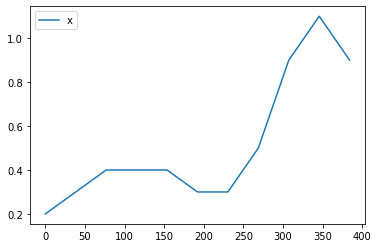

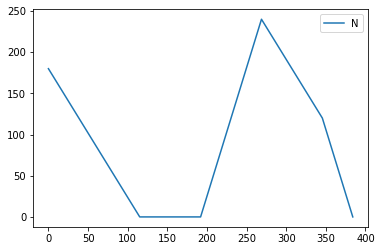

In [144]:
policy_to_be_plotted = policy #choose a particular policy from library
state = (0.2,180,0) #initial state
x_data = [state[0]] #store initial data
N_data = [state[1]]
t_data = [state[2]]
my_policy = []
for i in range(10): #take ten steps
        action = policy_to_be_plotted[state]
        state = transition(state, action)[0]
        my_policy += [action]
        x_data += [state[0]]
        N_data += [state[1]]
        t_data += [state[2]]
print('Current policy:', my_policy)
print('Concentration of x:', x_data)
print('Concentration of N:', N_data)
print('')
score = 100*x_data[-1] - N_data[-1]
print('Score:', score)
def plot(t_data, x_data, N_data):
    plt.figure()
    plt.plot(t_data, x_data, label = 'x')
    plt.legend()
    plt.figure()
    plt.plot(t_data, N_data, label = 'N')
    plt.legend()
    
plot(t_data, x_data, N_data)

In [102]:
def read_file(nth_policy,file_name):
    '''reads policy file library
    nth_policy = the nth number policy in policy library
    '''
    with open(file_name,'r') as f:
        contents = f.read()
        f.close()
    data = contents.split('{')[nth_policy][0:-3].split(',')
    data = [",".join(data[i:i+3]) for i in range(0, len(data), 3)]
    out_policy = {}
    for i in data:
        i.split(':')
    for datum in data:
        state = tuple([float(x) for x in datum.split(':')[0].split('(')[1].split(')')[0].split(',')])
        action = int(datum.split(':')[1].strip())
        out_policy[state] = action
    return out_policy
policy1 = read_file(nth_policy = 100,file_name = '200iterations_policy_library.txt')